##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Transfer learning & fine-tuning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/keras/transfer_learning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/keras-team/keras-io/blob/master/tf/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/keras-team/keras-io/blob/master/guides/transfer_learning.py"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/keras-io/tf/transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Setup


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras


## Introduction

**Transfer learning** consists of taking features learned on one problem, and
leveraging them on a new, similar problem. For instance, features from a model that has
learned to identify racoons may be useful to kick-start a model meant to identify
 tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to
 train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the
 following worfklow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during
 future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn
 the old features into predictions on a  new dataset.
4. Train the new layers on your dataset.

A last, optional step, is **fine-tuning**, which consists of unfreezing the entire
model you obtained above (or part of it), and re-training it on the new data with a
very low learning rate. This can potentially achieve meaningful improvements, by
 incrementally adapting the pretrained features to the new data.

First, we will go over the Keras `trainable` API in detail, which underlies most
 transfer learning & fine-tuning workflows.

Then, we'll demonstrate the typical workflow by taking a model pretrained on the
ImageNet dataset, and retraining it on the Kaggle "cats vs dogs" classification
 dataset.

This is adapted from
[Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)
 and the 2016 blog post
["building powerful image classification models using very little
 data"](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).


## Freezing layers: understanding the `trainable` attribute

Layers & models have three weight attributes:

- `weights` is the list of all weights variables of the layer.
- `trainable_weights` is the list of those that are meant to be updated (via gradient
 descent) to minimize the loss during training.
- `non_trainable_weights` is the list of those that aren't meant to be trained.
 Typically they are updated by the model during the forward pass.

**Example: the `Dense` layer has 2 trainable weights (kernel & bias)**


In [3]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


weights: 2
trainable_weights: 2
non_trainable_weights: 0


In general, all weights are trainable weights. The only built-in layer that has
non-trainable weights is the `BatchNormalization` layer. It uses non-trainable weights
 to keep track of the mean and variance of its inputs during training.
To learn how to use non-trainable weights in your own custom layers, see the
[guide to writing new layers from scratch](making_new_layers_and_models_via_subclassing).

**Example: the `BatchNormalization` layer has 2 trainable weights and 2 non-trainable
 weights**


In [4]:
layer = keras.layers.BatchNormalization()
layer.build((None, 4))  # Create the weights

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


weights: 4
trainable_weights: 2
non_trainable_weights: 2


Layers & models also feature a boolean attribute `trainable`. Its value can be changed.
Setting `layer.trainable` to `False` moves all the layer's weights from trainable to
non-trainable.  This is called "freezing" the layer: the state of a frozen layer won't
be updated during training (either when training with `fit()` or when training with
 any custom loop that relies on `trainable_weights` to apply gradient updates).

**Example: setting `trainable` to `False`**


In [5]:
layer = keras.layers.Dense(3)
layer.build((None, 4))  # Create the weights
layer.trainable = False  # Freeze the layer

print("weights:", len(layer.weights))
print("trainable_weights:", len(layer.trainable_weights))
print("non_trainable_weights:", len(layer.non_trainable_weights))


weights: 2
trainable_weights: 0
non_trainable_weights: 2


When a trainable weight becomes non-trainable, its value is no longer updated during
 training.


In [6]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()
np.testing.assert_allclose(
    initial_layer1_weights_values[0], final_layer1_weights_values[0]
)
np.testing.assert_allclose(
    initial_layer1_weights_values[1], final_layer1_weights_values[1]
)


1/1 [==============================] - ETA: 0s - loss: 0.0855

1/1 [==============================] - 0s 1ms/step - loss: 0.0855


Do not confuse the `layer.trainable` attribute with the argument `training` in
`layer.__call__()` (which controls whether the layer should run its forward pass in
 inference mode or training mode). For more information, see the
[Keras FAQ](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).


## Recursive setting of the `trainable` attribute

If you set `trainable = False` on a model or on any layer that has sublayers,
all children layers become non-trainable as well.

**Example:**


In [7]:
inner_model = keras.Sequential(
    [
        keras.Input(shape=(3,)),
        keras.layers.Dense(3, activation="relu"),
        keras.layers.Dense(3, activation="relu"),
    ]
)

model = keras.Sequential(
    [keras.Input(shape=(3,)), inner_model, keras.layers.Dense(3, activation="sigmoid"),]
)

model.trainable = False  # Freeze the outer model

assert inner_model.trainable == False  # All layers in `model` are now frozen
assert inner_model.layers[0].trainable == False  # `trainable` is propagated recursively


## The typical transfer-learning workflow

This leads us to how a typical transfer learning workflow can be implemented in Keras:

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting `trainable = False`.
3. Create a new model on top of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.

Note that an alternative, more lightweight workflow could also be:

1. Instantiate a base model and load pre-trained weights into it.
2. Run your new dataset through it and record the output of one (or several) layers
 from the base model. This is called **feature extraction**.
3. Use that output as input data for a new, smaller model.

A key advantage of that second workflow is that you only run the base model once one
 your data, rather than once per epoch of training. So it's a lot faster & cheaper.

An issue with that second workflow, though, is that it doesn't allow you to dynamically
modify the input data of your new model during training, which is required when doing
data augmentation, for instance. Transfer learning is typically used for tasks when
your new dataset has too little data to train a full-scale model from scratch, and in
such scenarios data augmentation is very important. So in what follows, we will focus
 on the first workflow.

Here's what the first workflow looks like in Keras:

First, instantiate a base model with pre-trained weigts.

```python
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.
```

Then, freeze the base model.

```python
base_model.trainable = False
```

Create a new model on top.

```python
inputs = keras.Input(shape=(150, 150, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
```

Train the model on new data.

```python
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])
model.fit(new_dataset, epochs=20, callbacks=..., validation_data=...)
```


## Fine-tuning

Once your model has converged on the new data, you can try to unfreeze all or part of
 the base model and retrain the whole model end-to-end with a very low learning rate.

This is an optional last step that can potentially give you incremental improvements.
 It could also potentially lead to quick overfitting -- keep that in mind.

It is critical to only do this step *after* the model with frozen layers has been
trained to convergence. If you mix randomly-initialized trainable layers with
trainable layers that hold pre-trained features, the randomly-initialized layers will
cause very large gradient updates during training, which will destroy your pre-trained
 features.

It's also critical to use a very low learning rate at this stage, because
you are training a much larger model than in the first round of training, on a dataset
 that is typically very small.
As a result, you are at risk of overfitting very quickly if you apply large weight
 updates. Here, you only want to readapt the pretrained weights in an incremental way.

This is how to implement fine-tuning of the whole base model:

```python
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are take into account
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

# Train end-to-end. Be careful to stop before you overfit!
model.fit(new_dataset, epochs=10, callbacks=..., validation_data=...)
```

**Important note about `compile()` and `trainable`**

Calling `compile()` on a model is meant to "freeze" the behavior of that model. This
 implies that the `trainable`
attribute values at the time the model is compiled should be preserved throughout the
 lifetime of that model,
until `compile` is called again. Hence, if you change any `trainable` value, make sure
 to call `compile()` again on your
model for your changes to be taken into account.

**Important notes about `BatchNormalization` layer**

Many image models contain `BatchNormalization` layers. That layer is a special case on
 every imaginable count. Here are a few things to keep in mind.

- `BatchNormalization` contains 2 non-trainable weights that get updated during
training. These are the variables tracking the mean and variance of the inputs.
- When you set `bn_layer.trainable = False`, the `BatchNormalization` layer will
run in inference mode, and will not update its mean & variance statistics. This is not
the case for other layers in general, as
[weight trainability & inference/training modes are two orthogonal concepts](
  https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute).
But the two are tied in the case of the `BatchNormalization` layer.
- When you unfreeze a model that contains `BatchNormalization` layers in order to do
fine-tuning, you should keep the `BatchNormalization` layers in inference mode by
 passing `training=False` when calling the base model.
Otherwise the updates applied to the non-trainable weights will suddenly destroy
what the model the model has learned.

You'll see this pattern in action in the end-to-end example at the end of this guide.



## Transfer learning & fine-tuning with a custom training loop

If instead of `fit()`, you are using your own low-level training loop, the workflow
stays essentially the same. You should be careful to only take into account the list
 `model.trainable_weights` when applying gradient updates:

```python
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

# Create new model on top.
inputs = keras.Input(shape=(150, 150, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = keras.optimizers.Adam()

# Iterate over the batches of a dataset.
for inputs, targets in new_dataset:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        predictions = model(inputs)
        # Compute the loss value for this batch.
        loss_value = loss_fn(targets, predictions)

    # Get gradients of loss wrt the *trainable* weights.
    gradients = tape.gradient(loss_value, model.trainable_weights)
    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
```


Likewise for fine-tuning.


## An end-to-end example: fine-tuning an image classification model on a cats vs. dogs
 dataset

To solidify these concepts, let's walk you through a concrete end-to-end transfer
learning & fine-tuning example. We will load the Xception model, pre-trained on
 ImageNet, and use it on the Kaggle "cats vs. dogs" classification dataset.


### Getting the data

First, let's fetch the cats vs. dogs dataset using TFDS. If you have your own dataset,
you'll probably want to use the utility
`tf.keras.preprocessing.image_dataset_from_directory` to generate similar labeled
 dataset objects from a set of images on disk filed into class-specific folders.

Tansfer learning is most useful when working with very small datases. To keep our
dataset small, we will use 40% of the original training data (25,000 images) for
 training, 10% for validation, and 10% for testing.


In [8]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:860: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /home/kbuilder/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteKQQCXE/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /home/kbuilder/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all
 different sizes.


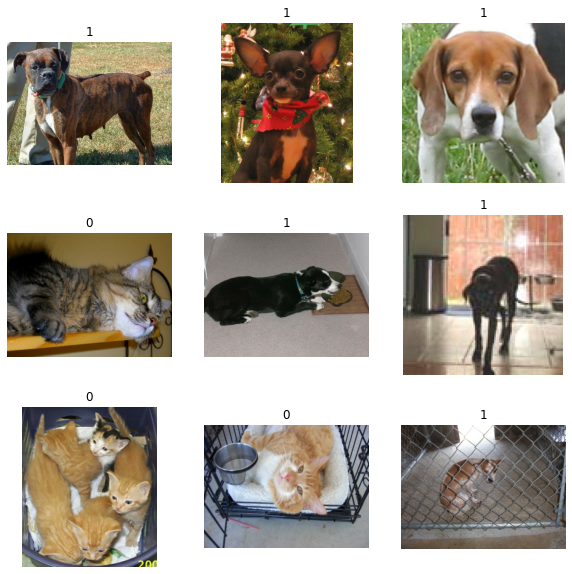

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


We can also see that label 1 is "dog" and label 0 is "cat".


### Standardizing the data

Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer
values between 0 and 255 (RGB level values). This isn't a great fit for feeding a
 neural network. We need to do 2 things:

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer as
 part of the model itself.

In general, it's a good practice to develop models that take raw data as input, as
opposed to models that take already-preprocessed data. The reason being that, if your
model expects preprocessed data, any time you export your model to use it elsewhere
(in a web browser, in a mobile app), you'll need to reimplement the exact same
preprocessing pipeline. This get very tricky very quickly. So we should do the least
 possible amount of preprocessing before hitting the model.

Here, we'll do image resizing in the data pipeline (because a deep neural network can
only process contiguous batches of data), and we'll do the input value scaling as part
 of the model, when we create it.

Let's resize images to 150x150:


In [10]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))


Besides, let's batch the data and use caching & prefetching to optimize loading speed.


In [11]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)


### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
 introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)


Let's visualize what the first image of the first batch looks like after various random
 transformations:


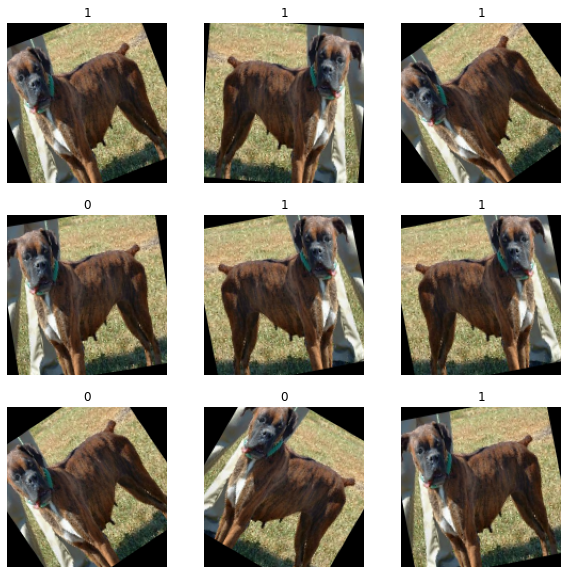

In [13]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Normalization` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.


In [14]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


    8192/83683744 [..............................] - ETA: 1s

 4202496/83683744 [>.............................] - ETA: 2s

 8396800/83683744 [==>...........................] - ETA: 3s

22781952/83683744 [=======>......................] - ETA: 1s

37986304/83683744 [============>.................] - ETA: 0s

41951232/83683744 [==============>...............] - ETA: 0s

57212928/83683744 [===================>..........] - ETA: 0s

72220672/83683744 [========================>.....] - ETA: 0s

75505664/83683744 [==========================>...] - ETA: 0s

83689472/83683744 [==============================] - 1s 0us/step


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049  

## Train the top layer


In [15]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Epoch 1/20


  1/291 [..............................] - ETA: 0s - loss: 0.7702 - binary_accuracy: 0.4062

  4/291 [..............................] - ETA: 5s - loss: 0.7085 - binary_accuracy: 0.5547

  7/291 [..............................] - ETA: 5s - loss: 0.6459 - binary_accuracy: 0.6429

 10/291 [>.............................] - ETA: 6s - loss: 0.5908 - binary_accuracy: 0.6625

 13/291 [>.............................] - ETA: 6s - loss: 0.5502 - binary_accuracy: 0.6971

 16/291 [>.............................] - ETA: 6s - loss: 0.5073 - binary_accuracy: 0.7324

 19/291 [>.............................] - ETA: 6s - loss: 0.4732 - binary_accuracy: 0.7533

 22/291 [=>............................] - ETA: 5s - loss: 0.4382 - binary_accuracy: 0.7756

 25/291 [=>............................] - ETA: 5s - loss: 0.4141 - binary_accuracy: 0.7925

 28/291 [=>............................] - ETA: 5s - loss: 0.4052 - binary_accuracy: 0.7980

 31/291 [==>...........................] - ETA: 5s - loss: 0.3955 - binary_accuracy: 0.8034

 34/291 [==>...........................] - ETA: 5s - loss: 0.3802 - binary_accuracy: 0.8088

 37/291 [==>...........................] - ETA: 5s - loss: 0.3631 - binary_accuracy: 0.8184

 40/291 [===>..........................] - ETA: 5s - loss: 0.3553 - binary_accuracy: 0.8234

 43/291 [===>..........................] - ETA: 5s - loss: 0.3436 - binary_accuracy: 0.8307

 46/291 [===>..........................] - ETA: 5s - loss: 0.3369 - binary_accuracy: 0.8336

 49/291 [====>.........................] - ETA: 5s - loss: 0.3304 - binary_accuracy: 0.8399

 52/291 [====>.........................] - ETA: 5s - loss: 0.3214 - binary_accuracy: 0.8462

 55/291 [====>.........................] - ETA: 5s - loss: 0.3160 - binary_accuracy: 0.8489

 58/291 [====>.........................] - ETA: 5s - loss: 0.3082 - binary_accuracy: 0.8524

 61/291 [=====>........................] - ETA: 5s - loss: 0.3010 - binary_accuracy: 0.8566

 64/291 [=====>........................] - ETA: 5s - loss: 0.2951 - binary_accuracy: 0.8599

 67/291 [=====>........................] - ETA: 5s - loss: 0.2905 - binary_accuracy: 0.8610

 70/291 [======>.......................] - ETA: 5s - loss: 0.2828 - binary_accuracy: 0.8661

 73/291 [======>.......................] - ETA: 4s - loss: 0.2783 - binary_accuracy: 0.8690

 76/291 [======>.......................] - ETA: 4s - loss: 0.2746 - binary_accuracy: 0.8713

 79/291 [=======>......................] - ETA: 4s - loss: 0.2704 - binary_accuracy: 0.8734

 82/291 [=======>......................] - ETA: 4s - loss: 0.2661 - binary_accuracy: 0.8758

 85/291 [=======>......................] - ETA: 4s - loss: 0.2614 - binary_accuracy: 0.8776

 88/291 [========>.....................] - ETA: 4s - loss: 0.2590 - binary_accuracy: 0.8782

 91/291 [========>.....................] - ETA: 4s - loss: 0.2562 - binary_accuracy: 0.8795

 94/291 [========>.....................] - ETA: 4s - loss: 0.2523 - binary_accuracy: 0.8816

 97/291 [=========>....................] - ETA: 4s - loss: 0.2506 - binary_accuracy: 0.8821

100/291 [=========>....................] - ETA: 4s - loss: 0.2477 - binary_accuracy: 0.8838

103/291 [=========>....................] - ETA: 4s - loss: 0.2453 - binary_accuracy: 0.8853

106/291 [=========>....................] - ETA: 4s - loss: 0.2437 - binary_accuracy: 0.8868

109/291 [==========>...................] - ETA: 4s - loss: 0.2397 - binary_accuracy: 0.8893

112/291 [==========>...................] - ETA: 4s - loss: 0.2399 - binary_accuracy: 0.8892

115/291 [==========>...................] - ETA: 4s - loss: 0.2361 - binary_accuracy: 0.8913

118/291 [===========>..................] - ETA: 3s - loss: 0.2341 - binary_accuracy: 0.8914

121/291 [===========>..................] - ETA: 3s - loss: 0.2306 - binary_accuracy: 0.8931

124/291 [===========>..................] - ETA: 3s - loss: 0.2291 - binary_accuracy: 0.8939

127/291 [============>.................] - ETA: 3s - loss: 0.2284 - binary_accuracy: 0.8947

130/291 [============>.................] - ETA: 3s - loss: 0.2273 - binary_accuracy: 0.8962

133/291 [============>.................] - ETA: 3s - loss: 0.2260 - binary_accuracy: 0.8969

136/291 [=============>................] - ETA: 3s - loss: 0.2232 - binary_accuracy: 0.8982

139/291 [=============>................] - ETA: 3s - loss: 0.2228 - binary_accuracy: 0.8979

142/291 [=============>................] - ETA: 3s - loss: 0.2227 - binary_accuracy: 0.8977

145/291 [=============>................] - ETA: 3s - loss: 0.2214 - binary_accuracy: 0.8978

148/291 [==============>...............] - ETA: 3s - loss: 0.2199 - binary_accuracy: 0.8984

151/291 [==============>...............] - ETA: 3s - loss: 0.2170 - binary_accuracy: 0.8994

154/291 [==============>...............] - ETA: 3s - loss: 0.2144 - binary_accuracy: 0.9012

157/291 [===============>..............] - ETA: 3s - loss: 0.2128 - binary_accuracy: 0.9021

160/291 [===============>..............] - ETA: 2s - loss: 0.2132 - binary_accuracy: 0.9023

163/291 [===============>..............] - ETA: 2s - loss: 0.2119 - binary_accuracy: 0.9030

166/291 [================>.............] - ETA: 2s - loss: 0.2107 - binary_accuracy: 0.9040

169/291 [================>.............] - ETA: 2s - loss: 0.2091 - binary_accuracy: 0.9051

172/291 [================>.............] - ETA: 2s - loss: 0.2086 - binary_accuracy: 0.9053

175/291 [=================>............] - ETA: 2s - loss: 0.2073 - binary_accuracy: 0.9061

178/291 [=================>............] - ETA: 2s - loss: 0.2065 - binary_accuracy: 0.9064

181/291 [=================>............] - ETA: 2s - loss: 0.2056 - binary_accuracy: 0.9064

184/291 [=================>............] - ETA: 2s - loss: 0.2040 - binary_accuracy: 0.9069

187/291 [==================>...........] - ETA: 2s - loss: 0.2051 - binary_accuracy: 0.9064

190/291 [==================>...........] - ETA: 2s - loss: 0.2057 - binary_accuracy: 0.9066

193/291 [==================>...........] - ETA: 2s - loss: 0.2054 - binary_accuracy: 0.9069

196/291 [===================>..........] - ETA: 2s - loss: 0.2042 - binary_accuracy: 0.9077

199/291 [===================>..........] - ETA: 2s - loss: 0.2030 - binary_accuracy: 0.9084

202/291 [===================>..........] - ETA: 2s - loss: 0.2030 - binary_accuracy: 0.9087

205/291 [====================>.........] - ETA: 1s - loss: 0.2023 - binary_accuracy: 0.9088

208/291 [====================>.........] - ETA: 1s - loss: 0.2016 - binary_accuracy: 0.9088

211/291 [====================>.........] - ETA: 1s - loss: 0.2018 - binary_accuracy: 0.9085

214/291 [=====================>........] - ETA: 1s - loss: 0.2004 - binary_accuracy: 0.9092

217/291 [=====================>........] - ETA: 1s - loss: 0.1993 - binary_accuracy: 0.9097

220/291 [=====================>........] - ETA: 1s - loss: 0.1993 - binary_accuracy: 0.9095

223/291 [=====================>........] - ETA: 1s - loss: 0.1988 - binary_accuracy: 0.9099

226/291 [======================>.......] - ETA: 1s - loss: 0.1982 - binary_accuracy: 0.9101

229/291 [======================>.......] - ETA: 1s - loss: 0.1974 - binary_accuracy: 0.9102

232/291 [======================>.......] - ETA: 1s - loss: 0.1973 - binary_accuracy: 0.9104

235/291 [=======================>......] - ETA: 1s - loss: 0.1961 - binary_accuracy: 0.9112

238/291 [=======================>......] - ETA: 1s - loss: 0.1945 - binary_accuracy: 0.9122

241/291 [=======================>......] - ETA: 1s - loss: 0.1934 - binary_accuracy: 0.9126

244/291 [========================>.....] - ETA: 1s - loss: 0.1927 - binary_accuracy: 0.9132

247/291 [========================>.....] - ETA: 1s - loss: 0.1920 - binary_accuracy: 0.9137

250/291 [========================>.....] - ETA: 0s - loss: 0.1921 - binary_accuracy: 0.9140

253/291 [=========================>....] - ETA: 0s - loss: 0.1914 - binary_accuracy: 0.9142

256/291 [=========================>....] - ETA: 0s - loss: 0.1915 - binary_accuracy: 0.9143

259/291 [=========================>....] - ETA: 0s - loss: 0.1908 - binary_accuracy: 0.9146

262/291 [==========================>...] - ETA: 0s - loss: 0.1902 - binary_accuracy: 0.9150

265/291 [==========================>...] - ETA: 0s - loss: 0.1901 - binary_accuracy: 0.9147

268/291 [==========================>...] - ETA: 0s - loss: 0.1900 - binary_accuracy: 0.9148

271/291 [==========================>...] - ETA: 0s - loss: 0.1889 - binary_accuracy: 0.9151

274/291 [===========================>..] - ETA: 0s - loss: 0.1881 - binary_accuracy: 0.9155

277/291 [===========================>..] - ETA: 0s - loss: 0.1867 - binary_accuracy: 0.9162

280/291 [===========================>..] - ETA: 0s - loss: 0.1862 - binary_accuracy: 0.9166

283/291 [============================>.] - ETA: 0s - loss: 0.1862 - binary_accuracy: 0.9165

286/291 [============================>.] - ETA: 0s - loss: 0.1858 - binary_accuracy: 0.9166

289/291 [============================>.] - ETA: 0s - loss: 0.1847 - binary_accuracy: 0.9174

291/291 [==============================] - ETA: 0s - loss: 0.1843 - binary_accuracy: 0.9177

291/291 [==============================] - 10s 33ms/step - loss: 0.1843 - binary_accuracy: 0.9177 - val_loss: 0.0878 - val_binary_accuracy: 0.9682


Epoch 2/20
  1/291 [..............................] - ETA: 0s - loss: 0.1332 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 4s - loss: 0.1985 - binary_accuracy: 0.9062

  7/291 [..............................] - ETA: 5s - loss: 0.1792 - binary_accuracy: 0.9286

 10/291 [>.............................] - ETA: 5s - loss: 0.1872 - binary_accuracy: 0.9156

 13/291 [>.............................] - ETA: 5s - loss: 0.1961 - binary_accuracy: 0.9135

 16/291 [>.............................] - ETA: 5s - loss: 0.1827 - binary_accuracy: 0.9180

 19/291 [>.............................] - ETA: 5s - loss: 0.1751 - binary_accuracy: 0.9211

 22/291 [=>............................] - ETA: 5s - loss: 0.1795 - binary_accuracy: 0.9190

 25/291 [=>............................] - ETA: 5s - loss: 0.1732 - binary_accuracy: 0.9225

 28/291 [=>............................] - ETA: 5s - loss: 0.1712 - binary_accuracy: 0.9230

 31/291 [==>...........................] - ETA: 5s - loss: 0.1743 - binary_accuracy: 0.9214

 34/291 [==>...........................] - ETA: 5s - loss: 0.1703 - binary_accuracy: 0.9200

 37/291 [==>...........................] - ETA: 5s - loss: 0.1636 - binary_accuracy: 0.9240

 40/291 [===>..........................] - ETA: 5s - loss: 0.1653 - binary_accuracy: 0.9219

 43/291 [===>..........................] - ETA: 5s - loss: 0.1650 - binary_accuracy: 0.9222

 46/291 [===>..........................] - ETA: 5s - loss: 0.1623 - binary_accuracy: 0.9239

 49/291 [====>.........................] - ETA: 5s - loss: 0.1625 - binary_accuracy: 0.9254

 52/291 [====>.........................] - ETA: 5s - loss: 0.1610 - binary_accuracy: 0.9243

 55/291 [====>.........................] - ETA: 5s - loss: 0.1576 - binary_accuracy: 0.9267

 58/291 [====>.........................] - ETA: 5s - loss: 0.1558 - binary_accuracy: 0.9278

 61/291 [=====>........................] - ETA: 5s - loss: 0.1538 - binary_accuracy: 0.9288

 64/291 [=====>........................] - ETA: 4s - loss: 0.1518 - binary_accuracy: 0.9292

 67/291 [=====>........................] - ETA: 4s - loss: 0.1512 - binary_accuracy: 0.9300

 70/291 [======>.......................] - ETA: 4s - loss: 0.1487 - binary_accuracy: 0.9312

 73/291 [======>.......................] - ETA: 4s - loss: 0.1489 - binary_accuracy: 0.9307

 76/291 [======>.......................] - ETA: 4s - loss: 0.1472 - binary_accuracy: 0.9313

 79/291 [=======>......................] - ETA: 4s - loss: 0.1468 - binary_accuracy: 0.9312

 82/291 [=======>......................] - ETA: 4s - loss: 0.1472 - binary_accuracy: 0.9322

 85/291 [=======>......................] - ETA: 4s - loss: 0.1470 - binary_accuracy: 0.9327

 88/291 [========>.....................] - ETA: 4s - loss: 0.1459 - binary_accuracy: 0.9329

 91/291 [========>.....................] - ETA: 4s - loss: 0.1461 - binary_accuracy: 0.9320

 94/291 [========>.....................] - ETA: 4s - loss: 0.1448 - binary_accuracy: 0.9325

 97/291 [=========>....................] - ETA: 4s - loss: 0.1473 - binary_accuracy: 0.9314

100/291 [=========>....................] - ETA: 4s - loss: 0.1474 - binary_accuracy: 0.9312

103/291 [=========>....................] - ETA: 4s - loss: 0.1467 - binary_accuracy: 0.9314

106/291 [=========>....................] - ETA: 4s - loss: 0.1484 - binary_accuracy: 0.9319

109/291 [==========>...................] - ETA: 4s - loss: 0.1471 - binary_accuracy: 0.9329

112/291 [==========>...................] - ETA: 3s - loss: 0.1472 - binary_accuracy: 0.9333

115/291 [==========>...................] - ETA: 3s - loss: 0.1453 - binary_accuracy: 0.9342

118/291 [===========>..................] - ETA: 3s - loss: 0.1462 - binary_accuracy: 0.9341

121/291 [===========>..................] - ETA: 3s - loss: 0.1453 - binary_accuracy: 0.9344

124/291 [===========>..................] - ETA: 3s - loss: 0.1465 - binary_accuracy: 0.9340

127/291 [============>.................] - ETA: 3s - loss: 0.1497 - binary_accuracy: 0.9333

130/291 [============>.................] - ETA: 3s - loss: 0.1495 - binary_accuracy: 0.9334

133/291 [============>.................] - ETA: 3s - loss: 0.1494 - binary_accuracy: 0.9328

136/291 [=============>................] - ETA: 3s - loss: 0.1497 - binary_accuracy: 0.9327

139/291 [=============>................] - ETA: 3s - loss: 0.1495 - binary_accuracy: 0.9330

142/291 [=============>................] - ETA: 3s - loss: 0.1490 - binary_accuracy: 0.9331

145/291 [=============>................] - ETA: 3s - loss: 0.1496 - binary_accuracy: 0.9328

148/291 [==============>...............] - ETA: 3s - loss: 0.1485 - binary_accuracy: 0.9333

151/291 [==============>...............] - ETA: 3s - loss: 0.1470 - binary_accuracy: 0.9342

154/291 [==============>...............] - ETA: 3s - loss: 0.1461 - binary_accuracy: 0.9349

157/291 [===============>..............] - ETA: 2s - loss: 0.1456 - binary_accuracy: 0.9353

160/291 [===============>..............] - ETA: 2s - loss: 0.1486 - binary_accuracy: 0.9352

163/291 [===============>..............] - ETA: 2s - loss: 0.1477 - binary_accuracy: 0.9354

166/291 [================>.............] - ETA: 2s - loss: 0.1468 - binary_accuracy: 0.9358

169/291 [================>.............] - ETA: 2s - loss: 0.1465 - binary_accuracy: 0.9360

172/291 [================>.............] - ETA: 2s - loss: 0.1457 - binary_accuracy: 0.9366

175/291 [=================>............] - ETA: 2s - loss: 0.1456 - binary_accuracy: 0.9366

178/291 [=================>............] - ETA: 2s - loss: 0.1460 - binary_accuracy: 0.9364

181/291 [=================>............] - ETA: 2s - loss: 0.1458 - binary_accuracy: 0.9366

184/291 [=================>............] - ETA: 2s - loss: 0.1454 - binary_accuracy: 0.9368

187/291 [==================>...........] - ETA: 2s - loss: 0.1455 - binary_accuracy: 0.9370

190/291 [==================>...........] - ETA: 2s - loss: 0.1455 - binary_accuracy: 0.9370

193/291 [==================>...........] - ETA: 2s - loss: 0.1452 - binary_accuracy: 0.9369

196/291 [===================>..........] - ETA: 2s - loss: 0.1447 - binary_accuracy: 0.9373

199/291 [===================>..........] - ETA: 2s - loss: 0.1448 - binary_accuracy: 0.9375

202/291 [===================>..........] - ETA: 1s - loss: 0.1444 - binary_accuracy: 0.9377

205/291 [====================>.........] - ETA: 1s - loss: 0.1447 - binary_accuracy: 0.9378

208/291 [====================>.........] - ETA: 1s - loss: 0.1453 - binary_accuracy: 0.9375

211/291 [====================>.........] - ETA: 1s - loss: 0.1458 - binary_accuracy: 0.9371

214/291 [=====================>........] - ETA: 1s - loss: 0.1452 - binary_accuracy: 0.9372

217/291 [=====================>........] - ETA: 1s - loss: 0.1446 - binary_accuracy: 0.9374

220/291 [=====================>........] - ETA: 1s - loss: 0.1438 - binary_accuracy: 0.9378

223/291 [=====================>........] - ETA: 1s - loss: 0.1443 - binary_accuracy: 0.9372

226/291 [======================>.......] - ETA: 1s - loss: 0.1438 - binary_accuracy: 0.9378

229/291 [======================>.......] - ETA: 1s - loss: 0.1430 - binary_accuracy: 0.9379

232/291 [======================>.......] - ETA: 1s - loss: 0.1432 - binary_accuracy: 0.9376

235/291 [=======================>......] - ETA: 1s - loss: 0.1431 - binary_accuracy: 0.9378

238/291 [=======================>......] - ETA: 1s - loss: 0.1423 - binary_accuracy: 0.9383

241/291 [=======================>......] - ETA: 1s - loss: 0.1420 - binary_accuracy: 0.9385

244/291 [========================>.....] - ETA: 1s - loss: 0.1419 - binary_accuracy: 0.9387

247/291 [========================>.....] - ETA: 0s - loss: 0.1415 - binary_accuracy: 0.9388

250/291 [========================>.....] - ETA: 0s - loss: 0.1417 - binary_accuracy: 0.9389

253/291 [=========================>....] - ETA: 0s - loss: 0.1414 - binary_accuracy: 0.9387

256/291 [=========================>....] - ETA: 0s - loss: 0.1413 - binary_accuracy: 0.9386

259/291 [=========================>....] - ETA: 0s - loss: 0.1411 - binary_accuracy: 0.9387

262/291 [==========================>...] - ETA: 0s - loss: 0.1408 - binary_accuracy: 0.9387

265/291 [==========================>...] - ETA: 0s - loss: 0.1409 - binary_accuracy: 0.9387

268/291 [==========================>...] - ETA: 0s - loss: 0.1416 - binary_accuracy: 0.9384

271/291 [==========================>...] - ETA: 0s - loss: 0.1411 - binary_accuracy: 0.9388

274/291 [===========================>..] - ETA: 0s - loss: 0.1411 - binary_accuracy: 0.9386

277/291 [===========================>..] - ETA: 0s - loss: 0.1411 - binary_accuracy: 0.9386

280/291 [===========================>..] - ETA: 0s - loss: 0.1408 - binary_accuracy: 0.9387

283/291 [============================>.] - ETA: 0s - loss: 0.1409 - binary_accuracy: 0.9386

286/291 [============================>.] - ETA: 0s - loss: 0.1409 - binary_accuracy: 0.9386

289/291 [============================>.] - ETA: 0s - loss: 0.1404 - binary_accuracy: 0.9388

291/291 [==============================] - 8s 28ms/step - loss: 0.1404 - binary_accuracy: 0.9389 - val_loss: 0.0881 - val_binary_accuracy: 0.9673


Epoch 3/20
  1/291 [..............................] - ETA: 0s - loss: 0.1203 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9531

  7/291 [..............................] - ETA: 5s - loss: 0.1059 - binary_accuracy: 0.9554

 10/291 [>.............................] - ETA: 5s - loss: 0.1216 - binary_accuracy: 0.9406

 13/291 [>.............................] - ETA: 5s - loss: 0.1282 - binary_accuracy: 0.9351

 16/291 [>.............................] - ETA: 5s - loss: 0.1271 - binary_accuracy: 0.9414

 19/291 [>.............................] - ETA: 5s - loss: 0.1191 - binary_accuracy: 0.9457

 22/291 [=>............................] - ETA: 5s - loss: 0.1207 - binary_accuracy: 0.9418

 25/291 [=>............................] - ETA: 5s - loss: 0.1178 - binary_accuracy: 0.9438

 28/291 [=>............................] - ETA: 5s - loss: 0.1248 - binary_accuracy: 0.9397

 31/291 [==>...........................] - ETA: 5s - loss: 0.1353 - binary_accuracy: 0.9365

 34/291 [==>...........................] - ETA: 5s - loss: 0.1334 - binary_accuracy: 0.9375

 37/291 [==>...........................] - ETA: 5s - loss: 0.1290 - binary_accuracy: 0.9400

 40/291 [===>..........................] - ETA: 5s - loss: 0.1309 - binary_accuracy: 0.9375

 43/291 [===>..........................] - ETA: 5s - loss: 0.1308 - binary_accuracy: 0.9382

 46/291 [===>..........................] - ETA: 5s - loss: 0.1299 - binary_accuracy: 0.9389

 49/291 [====>.........................] - ETA: 5s - loss: 0.1330 - binary_accuracy: 0.9375

 52/291 [====>.........................] - ETA: 5s - loss: 0.1303 - binary_accuracy: 0.9375

 55/291 [====>.........................] - ETA: 5s - loss: 0.1286 - binary_accuracy: 0.9381

 58/291 [====>.........................] - ETA: 5s - loss: 0.1279 - binary_accuracy: 0.9402

 61/291 [=====>........................] - ETA: 5s - loss: 0.1276 - binary_accuracy: 0.9406

 64/291 [=====>........................] - ETA: 4s - loss: 0.1259 - binary_accuracy: 0.9409

 67/291 [=====>........................] - ETA: 4s - loss: 0.1275 - binary_accuracy: 0.9412

 70/291 [======>.......................] - ETA: 4s - loss: 0.1254 - binary_accuracy: 0.9429

 73/291 [======>.......................] - ETA: 4s - loss: 0.1259 - binary_accuracy: 0.9422

 76/291 [======>.......................] - ETA: 4s - loss: 0.1257 - binary_accuracy: 0.9424

 79/291 [=======>......................] - ETA: 4s - loss: 0.1261 - binary_accuracy: 0.9419

 82/291 [=======>......................] - ETA: 4s - loss: 0.1238 - binary_accuracy: 0.9425

 85/291 [=======>......................] - ETA: 4s - loss: 0.1234 - binary_accuracy: 0.9426

 88/291 [========>.....................] - ETA: 4s - loss: 0.1241 - binary_accuracy: 0.9425

 91/291 [========>.....................] - ETA: 4s - loss: 0.1232 - binary_accuracy: 0.9427

 94/291 [========>.....................] - ETA: 4s - loss: 0.1229 - binary_accuracy: 0.9425

 97/291 [=========>....................] - ETA: 4s - loss: 0.1256 - binary_accuracy: 0.9410

100/291 [=========>....................] - ETA: 4s - loss: 0.1269 - binary_accuracy: 0.9403

103/291 [=========>....................] - ETA: 4s - loss: 0.1269 - binary_accuracy: 0.9411

106/291 [=========>....................] - ETA: 4s - loss: 0.1307 - binary_accuracy: 0.9413

109/291 [==========>...................] - ETA: 3s - loss: 0.1306 - binary_accuracy: 0.9418

112/291 [==========>...................] - ETA: 3s - loss: 0.1324 - binary_accuracy: 0.9411

115/291 [==========>...................] - ETA: 3s - loss: 0.1304 - binary_accuracy: 0.9424

118/291 [===========>..................] - ETA: 3s - loss: 0.1309 - binary_accuracy: 0.9423

121/291 [===========>..................] - ETA: 3s - loss: 0.1302 - binary_accuracy: 0.9424

124/291 [===========>..................] - ETA: 3s - loss: 0.1318 - binary_accuracy: 0.9423

127/291 [============>.................] - ETA: 3s - loss: 0.1336 - binary_accuracy: 0.9414

130/291 [============>.................] - ETA: 3s - loss: 0.1331 - binary_accuracy: 0.9416

133/291 [============>.................] - ETA: 3s - loss: 0.1336 - binary_accuracy: 0.9406

136/291 [=============>................] - ETA: 3s - loss: 0.1344 - binary_accuracy: 0.9400

139/291 [=============>................] - ETA: 3s - loss: 0.1344 - binary_accuracy: 0.9402

142/291 [=============>................] - ETA: 3s - loss: 0.1346 - binary_accuracy: 0.9401

145/291 [=============>................] - ETA: 3s - loss: 0.1334 - binary_accuracy: 0.9409

148/291 [==============>...............] - ETA: 3s - loss: 0.1339 - binary_accuracy: 0.9411

151/291 [==============>...............] - ETA: 3s - loss: 0.1325 - binary_accuracy: 0.9418

154/291 [==============>...............] - ETA: 3s - loss: 0.1326 - binary_accuracy: 0.9420



157/291 [===============>..............] - ETA: 2s - loss: 0.1329 - binary_accuracy: 0.9421

160/291 [===============>..............] - ETA: 2s - loss: 0.1346 - binary_accuracy: 0.9416

163/291 [===============>..............] - ETA: 2s - loss: 0.1335 - binary_accuracy: 0.9423

166/291 [================>.............] - ETA: 2s - loss: 0.1338 - binary_accuracy: 0.9420

169/291 [================>.............] - ETA: 2s - loss: 0.1331 - binary_accuracy: 0.9425

172/291 [================>.............] - ETA: 2s - loss: 0.1335 - binary_accuracy: 0.9422

175/291 [=================>............] - ETA: 2s - loss: 0.1337 - binary_accuracy: 0.9414

178/291 [=================>............] - ETA: 2s - loss: 0.1337 - binary_accuracy: 0.9415

181/291 [=================>............] - ETA: 2s - loss: 0.1349 - binary_accuracy: 0.9415

184/291 [=================>............] - ETA: 2s - loss: 0.1339 - binary_accuracy: 0.9419

187/291 [==================>...........] - ETA: 2s - loss: 0.1335 - binary_accuracy: 0.9423

190/291 [==================>...........] - ETA: 2s - loss: 0.1337 - binary_accuracy: 0.9424

193/291 [==================>...........] - ETA: 2s - loss: 0.1343 - binary_accuracy: 0.9422

196/291 [===================>..........] - ETA: 2s - loss: 0.1335 - binary_accuracy: 0.9428

199/291 [===================>..........] - ETA: 2s - loss: 0.1337 - binary_accuracy: 0.9427

202/291 [===================>..........] - ETA: 1s - loss: 0.1332 - binary_accuracy: 0.9431

205/291 [====================>.........] - ETA: 1s - loss: 0.1330 - binary_accuracy: 0.9431

208/291 [====================>.........] - ETA: 1s - loss: 0.1336 - binary_accuracy: 0.9426

211/291 [====================>.........] - ETA: 1s - loss: 0.1338 - binary_accuracy: 0.9422

214/291 [=====================>........] - ETA: 1s - loss: 0.1328 - binary_accuracy: 0.9426

217/291 [=====================>........] - ETA: 1s - loss: 0.1316 - binary_accuracy: 0.9433

220/291 [=====================>........] - ETA: 1s - loss: 0.1312 - binary_accuracy: 0.9436

223/291 [=====================>........] - ETA: 1s - loss: 0.1316 - binary_accuracy: 0.9435

226/291 [======================>.......] - ETA: 1s - loss: 0.1318 - binary_accuracy: 0.9436

229/291 [======================>.......] - ETA: 1s - loss: 0.1311 - binary_accuracy: 0.9441

232/291 [======================>.......] - ETA: 1s - loss: 0.1303 - binary_accuracy: 0.9442

235/291 [=======================>......] - ETA: 1s - loss: 0.1297 - binary_accuracy: 0.9444

238/291 [=======================>......] - ETA: 1s - loss: 0.1287 - binary_accuracy: 0.9450

241/291 [=======================>......] - ETA: 1s - loss: 0.1288 - binary_accuracy: 0.9446

244/291 [========================>.....] - ETA: 1s - loss: 0.1287 - binary_accuracy: 0.9447

247/291 [========================>.....] - ETA: 0s - loss: 0.1292 - binary_accuracy: 0.9446

250/291 [========================>.....] - ETA: 0s - loss: 0.1295 - binary_accuracy: 0.9442

253/291 [=========================>....] - ETA: 0s - loss: 0.1292 - binary_accuracy: 0.9444

256/291 [=========================>....] - ETA: 0s - loss: 0.1287 - binary_accuracy: 0.9445

259/291 [=========================>....] - ETA: 0s - loss: 0.1283 - binary_accuracy: 0.9449

262/291 [==========================>...] - ETA: 0s - loss: 0.1278 - binary_accuracy: 0.9453

265/291 [==========================>...] - ETA: 0s - loss: 0.1285 - binary_accuracy: 0.9450

268/291 [==========================>...] - ETA: 0s - loss: 0.1288 - binary_accuracy: 0.9448

271/291 [==========================>...] - ETA: 0s - loss: 0.1283 - binary_accuracy: 0.9449

274/291 [===========================>..] - ETA: 0s - loss: 0.1280 - binary_accuracy: 0.9451

277/291 [===========================>..] - ETA: 0s - loss: 0.1273 - binary_accuracy: 0.9453

280/291 [===========================>..] - ETA: 0s - loss: 0.1272 - binary_accuracy: 0.9453

283/291 [============================>.] - ETA: 0s - loss: 0.1271 - binary_accuracy: 0.9452

286/291 [============================>.] - ETA: 0s - loss: 0.1278 - binary_accuracy: 0.9450

289/291 [============================>.] - ETA: 0s - loss: 0.1271 - binary_accuracy: 0.9453

291/291 [==============================] - 8s 28ms/step - loss: 0.1270 - binary_accuracy: 0.9452 - val_loss: 0.0881 - val_binary_accuracy: 0.9669


Epoch 4/20
  1/291 [..............................] - ETA: 0s - loss: 0.2239 - binary_accuracy: 0.8438

  4/291 [..............................] - ETA: 4s - loss: 0.1838 - binary_accuracy: 0.8984

  7/291 [..............................] - ETA: 5s - loss: 0.1706 - binary_accuracy: 0.9196

 10/291 [>.............................] - ETA: 5s - loss: 0.1889 - binary_accuracy: 0.9156

 13/291 [>.............................] - ETA: 5s - loss: 0.1792 - binary_accuracy: 0.9207

 16/291 [>.............................] - ETA: 5s - loss: 0.1683 - binary_accuracy: 0.9258

 19/291 [>.............................] - ETA: 5s - loss: 0.1570 - binary_accuracy: 0.9309

 22/291 [=>............................] - ETA: 5s - loss: 0.1583 - binary_accuracy: 0.9318

 25/291 [=>............................] - ETA: 5s - loss: 0.1457 - binary_accuracy: 0.9362

 28/291 [=>............................] - ETA: 5s - loss: 0.1443 - binary_accuracy: 0.9386

 31/291 [==>...........................] - ETA: 5s - loss: 0.1458 - binary_accuracy: 0.9385

 34/291 [==>...........................] - ETA: 5s - loss: 0.1412 - binary_accuracy: 0.9393

 37/291 [==>...........................] - ETA: 5s - loss: 0.1386 - binary_accuracy: 0.9409

 40/291 [===>..........................] - ETA: 5s - loss: 0.1369 - binary_accuracy: 0.9414

 43/291 [===>..........................] - ETA: 5s - loss: 0.1388 - binary_accuracy: 0.9419

 46/291 [===>..........................] - ETA: 5s - loss: 0.1374 - binary_accuracy: 0.9416

 49/291 [====>.........................] - ETA: 5s - loss: 0.1397 - binary_accuracy: 0.9413

 52/291 [====>.........................] - ETA: 5s - loss: 0.1399 - binary_accuracy: 0.9411

 55/291 [====>.........................] - ETA: 5s - loss: 0.1398 - binary_accuracy: 0.9403

 58/291 [====>.........................] - ETA: 5s - loss: 0.1367 - binary_accuracy: 0.9418

 61/291 [=====>........................] - ETA: 5s - loss: 0.1388 - binary_accuracy: 0.9406

 64/291 [=====>........................] - ETA: 4s - loss: 0.1365 - binary_accuracy: 0.9414

 67/291 [=====>........................] - ETA: 4s - loss: 0.1354 - binary_accuracy: 0.9417

 70/291 [======>.......................] - ETA: 4s - loss: 0.1340 - binary_accuracy: 0.9420

 73/291 [======>.......................] - ETA: 4s - loss: 0.1324 - binary_accuracy: 0.9426

 76/291 [======>.......................] - ETA: 4s - loss: 0.1328 - binary_accuracy: 0.9428

 79/291 [=======>......................] - ETA: 4s - loss: 0.1317 - binary_accuracy: 0.9434

 82/291 [=======>......................] - ETA: 4s - loss: 0.1294 - binary_accuracy: 0.9447

 85/291 [=======>......................] - ETA: 4s - loss: 0.1305 - binary_accuracy: 0.9441

 88/291 [========>.....................] - ETA: 4s - loss: 0.1290 - binary_accuracy: 0.9446

 91/291 [========>.....................] - ETA: 4s - loss: 0.1284 - binary_accuracy: 0.9451

 94/291 [========>.....................] - ETA: 4s - loss: 0.1268 - binary_accuracy: 0.9461

 97/291 [=========>....................] - ETA: 4s - loss: 0.1278 - binary_accuracy: 0.9456

100/291 [=========>....................] - ETA: 4s - loss: 0.1273 - binary_accuracy: 0.9453

103/291 [=========>....................] - ETA: 4s - loss: 0.1260 - binary_accuracy: 0.9460

106/291 [=========>....................] - ETA: 4s - loss: 0.1282 - binary_accuracy: 0.9446

109/291 [==========>...................] - ETA: 4s - loss: 0.1273 - binary_accuracy: 0.9450

112/291 [==========>...................] - ETA: 3s - loss: 0.1284 - binary_accuracy: 0.9448

115/291 [==========>...................] - ETA: 3s - loss: 0.1262 - binary_accuracy: 0.9462

118/291 [===========>..................] - ETA: 3s - loss: 0.1256 - binary_accuracy: 0.9465

121/291 [===========>..................] - ETA: 3s - loss: 0.1244 - binary_accuracy: 0.9476

124/291 [===========>..................] - ETA: 3s - loss: 0.1247 - binary_accuracy: 0.9473

127/291 [============>.................] - ETA: 3s - loss: 0.1255 - binary_accuracy: 0.9469

130/291 [============>.................] - ETA: 3s - loss: 0.1241 - binary_accuracy: 0.9474

133/291 [============>.................] - ETA: 3s - loss: 0.1240 - binary_accuracy: 0.9471

136/291 [=============>................] - ETA: 3s - loss: 0.1236 - binary_accuracy: 0.9472

139/291 [=============>................] - ETA: 3s - loss: 0.1245 - binary_accuracy: 0.9467

142/291 [=============>................] - ETA: 3s - loss: 0.1244 - binary_accuracy: 0.9472

145/291 [=============>................] - ETA: 3s - loss: 0.1241 - binary_accuracy: 0.9472

148/291 [==============>...............] - ETA: 3s - loss: 0.1239 - binary_accuracy: 0.9466

151/291 [==============>...............] - ETA: 3s - loss: 0.1241 - binary_accuracy: 0.9470

154/291 [==============>...............] - ETA: 3s - loss: 0.1241 - binary_accuracy: 0.9472

157/291 [===============>..............] - ETA: 2s - loss: 0.1240 - binary_accuracy: 0.9475

160/291 [===============>..............] - ETA: 2s - loss: 0.1266 - binary_accuracy: 0.9463

163/291 [===============>..............] - ETA: 2s - loss: 0.1262 - binary_accuracy: 0.9461

166/291 [================>.............] - ETA: 2s - loss: 0.1263 - binary_accuracy: 0.9458

169/291 [================>.............] - ETA: 2s - loss: 0.1253 - binary_accuracy: 0.9464

172/291 [================>.............] - ETA: 2s - loss: 0.1255 - binary_accuracy: 0.9464

175/291 [=================>............] - ETA: 2s - loss: 0.1256 - binary_accuracy: 0.9468

178/291 [=================>............] - ETA: 2s - loss: 0.1279 - binary_accuracy: 0.9461

181/291 [=================>............] - ETA: 2s - loss: 0.1283 - binary_accuracy: 0.9458

184/291 [=================>............] - ETA: 2s - loss: 0.1277 - binary_accuracy: 0.9458

187/291 [==================>...........] - ETA: 2s - loss: 0.1273 - binary_accuracy: 0.9462

190/291 [==================>...........] - ETA: 2s - loss: 0.1277 - binary_accuracy: 0.9464

193/291 [==================>...........] - ETA: 2s - loss: 0.1275 - binary_accuracy: 0.9462

196/291 [===================>..........] - ETA: 2s - loss: 0.1272 - binary_accuracy: 0.9463

199/291 [===================>..........] - ETA: 2s - loss: 0.1271 - binary_accuracy: 0.9465

202/291 [===================>..........] - ETA: 1s - loss: 0.1273 - binary_accuracy: 0.9465

205/291 [====================>.........] - ETA: 1s - loss: 0.1268 - binary_accuracy: 0.9468

208/291 [====================>.........] - ETA: 1s - loss: 0.1286 - binary_accuracy: 0.9462

211/291 [====================>.........] - ETA: 1s - loss: 0.1286 - binary_accuracy: 0.9464

214/291 [=====================>........] - ETA: 1s - loss: 0.1281 - binary_accuracy: 0.9467

217/291 [=====================>........] - ETA: 1s - loss: 0.1276 - binary_accuracy: 0.9467

220/291 [=====================>........] - ETA: 1s - loss: 0.1274 - binary_accuracy: 0.9469

223/291 [=====================>........] - ETA: 1s - loss: 0.1282 - binary_accuracy: 0.9469

226/291 [======================>.......] - ETA: 1s - loss: 0.1277 - binary_accuracy: 0.9470

229/291 [======================>.......] - ETA: 1s - loss: 0.1269 - binary_accuracy: 0.9475

232/291 [======================>.......] - ETA: 1s - loss: 0.1266 - binary_accuracy: 0.9473

235/291 [=======================>......] - ETA: 1s - loss: 0.1266 - binary_accuracy: 0.9472

238/291 [=======================>......] - ETA: 1s - loss: 0.1259 - binary_accuracy: 0.9475

241/291 [=======================>......] - ETA: 1s - loss: 0.1257 - binary_accuracy: 0.9475

244/291 [========================>.....] - ETA: 1s - loss: 0.1250 - binary_accuracy: 0.9476

247/291 [========================>.....] - ETA: 0s - loss: 0.1248 - binary_accuracy: 0.9475

250/291 [========================>.....] - ETA: 0s - loss: 0.1247 - binary_accuracy: 0.9474

253/291 [=========================>....] - ETA: 0s - loss: 0.1241 - binary_accuracy: 0.9476

256/291 [=========================>....] - ETA: 0s - loss: 0.1241 - binary_accuracy: 0.9475

259/291 [=========================>....] - ETA: 0s - loss: 0.1238 - binary_accuracy: 0.9475

262/291 [==========================>...] - ETA: 0s - loss: 0.1237 - binary_accuracy: 0.9475

265/291 [==========================>...] - ETA: 0s - loss: 0.1242 - binary_accuracy: 0.9473

268/291 [==========================>...] - ETA: 0s - loss: 0.1248 - binary_accuracy: 0.9469

271/291 [==========================>...] - ETA: 0s - loss: 0.1245 - binary_accuracy: 0.9466

274/291 [===========================>..] - ETA: 0s - loss: 0.1240 - binary_accuracy: 0.9469

277/291 [===========================>..] - ETA: 0s - loss: 0.1231 - binary_accuracy: 0.9472

280/291 [===========================>..] - ETA: 0s - loss: 0.1233 - binary_accuracy: 0.9472

283/291 [============================>.] - ETA: 0s - loss: 0.1231 - binary_accuracy: 0.9474

286/291 [============================>.] - ETA: 0s - loss: 0.1239 - binary_accuracy: 0.9471

289/291 [============================>.] - ETA: 0s - loss: 0.1237 - binary_accuracy: 0.9473

291/291 [==============================] - 8s 28ms/step - loss: 0.1238 - binary_accuracy: 0.9472 - val_loss: 0.0826 - val_binary_accuracy: 0.9686


Epoch 5/20
  1/291 [..............................] - ETA: 0s - loss: 0.1445 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9531

  7/291 [..............................] - ETA: 5s - loss: 0.0983 - binary_accuracy: 0.9643

 10/291 [>.............................] - ETA: 5s - loss: 0.1103 - binary_accuracy: 0.9594

 13/291 [>.............................] - ETA: 5s - loss: 0.1197 - binary_accuracy: 0.9543

 16/291 [>.............................] - ETA: 5s - loss: 0.1230 - binary_accuracy: 0.9512

 19/291 [>.............................] - ETA: 5s - loss: 0.1154 - binary_accuracy: 0.9523

 22/291 [=>............................] - ETA: 5s - loss: 0.1176 - binary_accuracy: 0.9503

 25/291 [=>............................] - ETA: 5s - loss: 0.1135 - binary_accuracy: 0.9500

 28/291 [=>............................] - ETA: 5s - loss: 0.1157 - binary_accuracy: 0.9498

 31/291 [==>...........................] - ETA: 5s - loss: 0.1194 - binary_accuracy: 0.9496

 34/291 [==>...........................] - ETA: 5s - loss: 0.1255 - binary_accuracy: 0.9439

 37/291 [==>...........................] - ETA: 5s - loss: 0.1227 - binary_accuracy: 0.9451

 40/291 [===>..........................] - ETA: 5s - loss: 0.1269 - binary_accuracy: 0.9422

 43/291 [===>..........................] - ETA: 5s - loss: 0.1296 - binary_accuracy: 0.9404

 46/291 [===>..........................] - ETA: 5s - loss: 0.1322 - binary_accuracy: 0.9389

 49/291 [====>.........................] - ETA: 5s - loss: 0.1318 - binary_accuracy: 0.9381

 52/291 [====>.........................] - ETA: 5s - loss: 0.1279 - binary_accuracy: 0.9411

 55/291 [====>.........................] - ETA: 5s - loss: 0.1264 - binary_accuracy: 0.9420

 58/291 [====>.........................] - ETA: 5s - loss: 0.1239 - binary_accuracy: 0.9440

 61/291 [=====>........................] - ETA: 5s - loss: 0.1222 - binary_accuracy: 0.9462

 64/291 [=====>........................] - ETA: 4s - loss: 0.1203 - binary_accuracy: 0.9463

 67/291 [=====>........................] - ETA: 4s - loss: 0.1222 - binary_accuracy: 0.9454

 70/291 [======>.......................] - ETA: 4s - loss: 0.1193 - binary_accuracy: 0.9473

 73/291 [======>.......................] - ETA: 4s - loss: 0.1193 - binary_accuracy: 0.9469

 76/291 [======>.......................] - ETA: 4s - loss: 0.1187 - binary_accuracy: 0.9478

 79/291 [=======>......................] - ETA: 4s - loss: 0.1173 - binary_accuracy: 0.9482

 82/291 [=======>......................] - ETA: 4s - loss: 0.1165 - binary_accuracy: 0.9482

 85/291 [=======>......................] - ETA: 4s - loss: 0.1166 - binary_accuracy: 0.9482

 88/291 [========>.....................] - ETA: 4s - loss: 0.1169 - binary_accuracy: 0.9471

 91/291 [========>.....................] - ETA: 4s - loss: 0.1166 - binary_accuracy: 0.9471

 94/291 [========>.....................] - ETA: 4s - loss: 0.1162 - binary_accuracy: 0.9478

 97/291 [=========>....................] - ETA: 4s - loss: 0.1184 - binary_accuracy: 0.9468

100/291 [=========>....................] - ETA: 4s - loss: 0.1186 - binary_accuracy: 0.9469

103/291 [=========>....................] - ETA: 4s - loss: 0.1188 - binary_accuracy: 0.9472

106/291 [=========>....................] - ETA: 4s - loss: 0.1206 - binary_accuracy: 0.9469

109/291 [==========>...................] - ETA: 4s - loss: 0.1205 - binary_accuracy: 0.9467

112/291 [==========>...................] - ETA: 3s - loss: 0.1205 - binary_accuracy: 0.9467

115/291 [==========>...................] - ETA: 3s - loss: 0.1183 - binary_accuracy: 0.9481

118/291 [===========>..................] - ETA: 3s - loss: 0.1189 - binary_accuracy: 0.9476

121/291 [===========>..................] - ETA: 3s - loss: 0.1186 - binary_accuracy: 0.9476

124/291 [===========>..................] - ETA: 3s - loss: 0.1201 - binary_accuracy: 0.9471

127/291 [============>.................] - ETA: 3s - loss: 0.1216 - binary_accuracy: 0.9466

130/291 [============>.................] - ETA: 3s - loss: 0.1218 - binary_accuracy: 0.9469

133/291 [============>.................] - ETA: 3s - loss: 0.1217 - binary_accuracy: 0.9469

136/291 [=============>................] - ETA: 3s - loss: 0.1207 - binary_accuracy: 0.9467

139/291 [=============>................] - ETA: 3s - loss: 0.1218 - binary_accuracy: 0.9460

142/291 [=============>................] - ETA: 3s - loss: 0.1220 - binary_accuracy: 0.9459

145/291 [=============>................] - ETA: 3s - loss: 0.1218 - binary_accuracy: 0.9459

148/291 [==============>...............] - ETA: 3s - loss: 0.1214 - binary_accuracy: 0.9462

151/291 [==============>...............] - ETA: 3s - loss: 0.1211 - binary_accuracy: 0.9468

154/291 [==============>...............] - ETA: 3s - loss: 0.1198 - binary_accuracy: 0.9474

157/291 [===============>..............] - ETA: 2s - loss: 0.1197 - binary_accuracy: 0.9475

160/291 [===============>..............] - ETA: 2s - loss: 0.1217 - binary_accuracy: 0.9465

163/291 [===============>..............] - ETA: 2s - loss: 0.1209 - binary_accuracy: 0.9469

166/291 [================>.............] - ETA: 2s - loss: 0.1216 - binary_accuracy: 0.9460

169/291 [================>.............] - ETA: 2s - loss: 0.1218 - binary_accuracy: 0.9460

172/291 [================>.............] - ETA: 2s - loss: 0.1215 - binary_accuracy: 0.9462

175/291 [=================>............] - ETA: 2s - loss: 0.1220 - binary_accuracy: 0.9464

178/291 [=================>............] - ETA: 2s - loss: 0.1240 - binary_accuracy: 0.9458

181/291 [=================>............] - ETA: 2s - loss: 0.1243 - binary_accuracy: 0.9454

184/291 [=================>............] - ETA: 2s - loss: 0.1241 - binary_accuracy: 0.9453

187/291 [==================>...........] - ETA: 2s - loss: 0.1245 - binary_accuracy: 0.9454

190/291 [==================>...........] - ETA: 2s - loss: 0.1244 - binary_accuracy: 0.9451

193/291 [==================>...........] - ETA: 2s - loss: 0.1243 - binary_accuracy: 0.9451

196/291 [===================>..........] - ETA: 2s - loss: 0.1247 - binary_accuracy: 0.9452

199/291 [===================>..........] - ETA: 2s - loss: 0.1249 - binary_accuracy: 0.9450

202/291 [===================>..........] - ETA: 1s - loss: 0.1242 - binary_accuracy: 0.9451

205/291 [====================>.........] - ETA: 1s - loss: 0.1250 - binary_accuracy: 0.9450

208/291 [====================>.........] - ETA: 1s - loss: 0.1259 - binary_accuracy: 0.9443

211/291 [====================>.........] - ETA: 1s - loss: 0.1271 - binary_accuracy: 0.9439

214/291 [=====================>........] - ETA: 1s - loss: 0.1273 - binary_accuracy: 0.9436

217/291 [=====================>........] - ETA: 1s - loss: 0.1273 - binary_accuracy: 0.9440

220/291 [=====================>........] - ETA: 1s - loss: 0.1279 - binary_accuracy: 0.9440

223/291 [=====================>........] - ETA: 1s - loss: 0.1282 - binary_accuracy: 0.9438

226/291 [======================>.......] - ETA: 1s - loss: 0.1287 - binary_accuracy: 0.9436

229/291 [======================>.......] - ETA: 1s - loss: 0.1289 - binary_accuracy: 0.9435

232/291 [======================>.......] - ETA: 1s - loss: 0.1287 - binary_accuracy: 0.9437

235/291 [=======================>......] - ETA: 1s - loss: 0.1286 - binary_accuracy: 0.9439

238/291 [=======================>......] - ETA: 1s - loss: 0.1282 - binary_accuracy: 0.9441

241/291 [=======================>......] - ETA: 1s - loss: 0.1283 - binary_accuracy: 0.9439

244/291 [========================>.....] - ETA: 1s - loss: 0.1283 - binary_accuracy: 0.9436

247/291 [========================>.....] - ETA: 0s - loss: 0.1281 - binary_accuracy: 0.9438

250/291 [========================>.....] - ETA: 0s - loss: 0.1284 - binary_accuracy: 0.9436

253/291 [=========================>....] - ETA: 0s - loss: 0.1281 - binary_accuracy: 0.9436

256/291 [=========================>....] - ETA: 0s - loss: 0.1281 - binary_accuracy: 0.9435

259/291 [=========================>....] - ETA: 0s - loss: 0.1280 - binary_accuracy: 0.9437

262/291 [==========================>...] - ETA: 0s - loss: 0.1275 - binary_accuracy: 0.9441

265/291 [==========================>...] - ETA: 0s - loss: 0.1275 - binary_accuracy: 0.9439

268/291 [==========================>...] - ETA: 0s - loss: 0.1276 - binary_accuracy: 0.9439

271/291 [==========================>...] - ETA: 0s - loss: 0.1273 - binary_accuracy: 0.9440

274/291 [===========================>..] - ETA: 0s - loss: 0.1273 - binary_accuracy: 0.9440

277/291 [===========================>..] - ETA: 0s - loss: 0.1265 - binary_accuracy: 0.9445

280/291 [===========================>..] - ETA: 0s - loss: 0.1271 - binary_accuracy: 0.9442

283/291 [============================>.] - ETA: 0s - loss: 0.1271 - binary_accuracy: 0.9443

286/291 [============================>.] - ETA: 0s - loss: 0.1271 - binary_accuracy: 0.9443

289/291 [============================>.] - ETA: 0s - loss: 0.1265 - binary_accuracy: 0.9445

291/291 [==============================] - 8s 28ms/step - loss: 0.1265 - binary_accuracy: 0.9443 - val_loss: 0.0780 - val_binary_accuracy: 0.9686


Epoch 6/20
  1/291 [..............................] - ETA: 0s - loss: 0.1823 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 5s - loss: 0.1523 - binary_accuracy: 0.9141

  7/291 [..............................] - ETA: 5s - loss: 0.1743 - binary_accuracy: 0.9152

 10/291 [>.............................] - ETA: 5s - loss: 0.1800 - binary_accuracy: 0.9156

 13/291 [>.............................] - ETA: 5s - loss: 0.1746 - binary_accuracy: 0.9207

 16/291 [>.............................] - ETA: 5s - loss: 0.1608 - binary_accuracy: 0.9297

 19/291 [>.............................] - ETA: 5s - loss: 0.1454 - binary_accuracy: 0.9359

 22/291 [=>............................] - ETA: 5s - loss: 0.1502 - binary_accuracy: 0.9318

 25/291 [=>............................] - ETA: 5s - loss: 0.1428 - binary_accuracy: 0.9337

 28/291 [=>............................] - ETA: 5s - loss: 0.1465 - binary_accuracy: 0.9353

 31/291 [==>...........................] - ETA: 5s - loss: 0.1485 - binary_accuracy: 0.9325

 34/291 [==>...........................] - ETA: 5s - loss: 0.1488 - binary_accuracy: 0.9320

 37/291 [==>...........................] - ETA: 5s - loss: 0.1439 - binary_accuracy: 0.9341

 40/291 [===>..........................] - ETA: 5s - loss: 0.1421 - binary_accuracy: 0.9352

 43/291 [===>..........................] - ETA: 5s - loss: 0.1423 - binary_accuracy: 0.9353

 46/291 [===>..........................] - ETA: 5s - loss: 0.1399 - binary_accuracy: 0.9375

 49/291 [====>.........................] - ETA: 5s - loss: 0.1398 - binary_accuracy: 0.9381

 52/291 [====>.........................] - ETA: 5s - loss: 0.1381 - binary_accuracy: 0.9393

 55/291 [====>.........................] - ETA: 5s - loss: 0.1373 - binary_accuracy: 0.9398

 58/291 [====>.........................] - ETA: 5s - loss: 0.1354 - binary_accuracy: 0.9402

 61/291 [=====>........................] - ETA: 5s - loss: 0.1320 - binary_accuracy: 0.9421

 64/291 [=====>........................] - ETA: 4s - loss: 0.1311 - binary_accuracy: 0.9414

 67/291 [=====>........................] - ETA: 4s - loss: 0.1322 - binary_accuracy: 0.9398

 70/291 [======>.......................] - ETA: 4s - loss: 0.1298 - binary_accuracy: 0.9411

 73/291 [======>.......................] - ETA: 4s - loss: 0.1291 - binary_accuracy: 0.9405

 76/291 [======>.......................] - ETA: 4s - loss: 0.1317 - binary_accuracy: 0.9400

 79/291 [=======>......................] - ETA: 4s - loss: 0.1324 - binary_accuracy: 0.9383

 82/291 [=======>......................] - ETA: 4s - loss: 0.1314 - binary_accuracy: 0.9390

 85/291 [=======>......................] - ETA: 4s - loss: 0.1307 - binary_accuracy: 0.9393

 88/291 [========>.....................] - ETA: 4s - loss: 0.1286 - binary_accuracy: 0.9400

 91/291 [========>.....................] - ETA: 4s - loss: 0.1279 - binary_accuracy: 0.9399

 94/291 [========>.....................] - ETA: 4s - loss: 0.1279 - binary_accuracy: 0.9408

 97/291 [=========>....................] - ETA: 4s - loss: 0.1290 - binary_accuracy: 0.9398

100/291 [=========>....................] - ETA: 4s - loss: 0.1280 - binary_accuracy: 0.9388

103/291 [=========>....................] - ETA: 4s - loss: 0.1277 - binary_accuracy: 0.9393

106/291 [=========>....................] - ETA: 4s - loss: 0.1299 - binary_accuracy: 0.9393

109/291 [==========>...................] - ETA: 4s - loss: 0.1292 - binary_accuracy: 0.9398

112/291 [==========>...................] - ETA: 3s - loss: 0.1309 - binary_accuracy: 0.9395

115/291 [==========>...................] - ETA: 3s - loss: 0.1296 - binary_accuracy: 0.9405

118/291 [===========>..................] - ETA: 3s - loss: 0.1294 - binary_accuracy: 0.9407

121/291 [===========>..................] - ETA: 3s - loss: 0.1284 - binary_accuracy: 0.9411

124/291 [===========>..................] - ETA: 3s - loss: 0.1300 - binary_accuracy: 0.9405

127/291 [============>.................] - ETA: 3s - loss: 0.1319 - binary_accuracy: 0.9397

130/291 [============>.................] - ETA: 3s - loss: 0.1317 - binary_accuracy: 0.9399

133/291 [============>.................]

 - ETA: 3s - loss: 0.1319 - binary_accuracy: 0.9398

136/291 [=============>................] - ETA: 3s - loss: 0.1320 - binary_accuracy: 0.9398

139/291 [=============>................] - ETA: 3s - loss: 0.1321 - binary_accuracy: 0.9400

142/291 [=============>................] - ETA: 3s - loss: 0.1327 - binary_accuracy: 0.9390

145/291 [=============>................] - ETA: 3s - loss: 0.1323 - binary_accuracy: 0.9384

148/291 [==============>...............] - ETA: 3s - loss: 0.1314 - binary_accuracy: 0.9392

151/291 [==============>...............] - ETA: 3s - loss: 0.1304 - binary_accuracy: 0.9398

154/291 [==============>...............] - ETA: 3s - loss: 0.1302 - binary_accuracy: 0.9401

157/291 [===============>..............] - ETA: 2s - loss: 0.1307 - binary_accuracy: 0.9397

160/291 [===============>..............] - ETA: 2s - loss: 0.1308 - binary_accuracy: 0.9402

163/291 [===============>..............] - ETA: 2s - loss: 0.1296 - binary_accuracy: 0.9410

166/291 [================>.............] - ETA: 2s - loss: 0.1295 - binary_accuracy: 0.9411

169/291 [================>.............] - ETA: 2s - loss: 0.1291 - binary_accuracy: 0.9410

172/291 [================>.............] - ETA: 2s - loss: 0.1288 - binary_accuracy: 0.9413

175/291 [=================>............] - ETA: 2s - loss: 0.1290 - binary_accuracy: 0.9411

178/291 [=================>............] - ETA: 2s - loss: 0.1291 - binary_accuracy: 0.9412

181/291 [=================>............] - ETA: 2s - loss: 0.1289 - binary_accuracy: 0.9415

184/291 [=================>............] - ETA: 2s - loss: 0.1288 - binary_accuracy: 0.9409

187/291 [==================>...........] - ETA: 2s - loss: 0.1279 - binary_accuracy: 0.9413

190/291 [==================>...........] - ETA: 2s - loss: 0.1274 - binary_accuracy: 0.9419

193/291 [==================>...........] - ETA: 2s - loss: 0.1274 - binary_accuracy: 0.9419

196/291 [===================>..........] - ETA: 2s - loss: 0.1278 - binary_accuracy: 0.9418

199/291 [===================>..........] - ETA: 2s - loss: 0.1274 - binary_accuracy: 0.9422

202/291 [===================>..........] - ETA: 1s - loss: 0.1265 - binary_accuracy: 0.9426

205/291 [====================>.........] - ETA: 1s - loss: 0.1263 - binary_accuracy: 0.9428

208/291 [====================>.........] - ETA: 1s - loss: 0.1268 - binary_accuracy: 0.9426

211/291 [====================>.........] - ETA: 1s - loss: 0.1281 - binary_accuracy: 0.9421

214/291 [=====================>........] - ETA: 1s - loss: 0.1278 - binary_accuracy: 0.9425

217/291 [=====================>........] - ETA: 1s - loss: 0.1279 - binary_accuracy: 0.9425

220/291 [=====================>........] - ETA: 1s - loss: 0.1279 - binary_accuracy: 0.9425

223/291 [=====================>........] - ETA: 1s - loss: 0.1284 - binary_accuracy: 0.9424

226/291 [======================>.......] - ETA: 1s - loss: 0.1284 - binary_accuracy: 0.9428

229/291 [======================>.......] - ETA: 1s - loss: 0.1280 - binary_accuracy: 0.9427

232/291 [======================>.......] - ETA: 1s - loss: 0.1279 - binary_accuracy: 0.9428

235/291 [=======================>......] - ETA: 1s - loss: 0.1278 - binary_accuracy: 0.9430

238/291 [=======================>......] - ETA: 1s - loss: 0.1273 - binary_accuracy: 0.9430

241/291 [=======================>......] - ETA: 1s - loss: 0.1273 - binary_accuracy: 0.9428

244/291 [========================>.....] - ETA: 1s - loss: 0.1281 - binary_accuracy: 0.9422

247/291 [========================>.....] - ETA: 0s - loss: 0.1286 - binary_accuracy: 0.9424

250/291 [========================>.....] - ETA: 0s - loss: 0.1286 - binary_accuracy: 0.9426

253/291 [=========================>....] - ETA: 0s - loss: 0.1284 - binary_accuracy: 0.9427

256/291 [=========================>....] - ETA: 0s - loss: 0.1289 - binary_accuracy: 0.9427

259/291 [=========================>....] - ETA: 0s - loss: 0.1284 - binary_accuracy: 0.9429

262/291 [==========================>...] - ETA: 0s - loss: 0.1282 - binary_accuracy: 0.9432

265/291 [==========================>...] - ETA: 0s - loss: 0.1290 - binary_accuracy: 0.9429

268/291 [==========================>...] - ETA: 0s - loss: 0.1285 - binary_accuracy: 0.9432

271/291 [==========================>...] - ETA: 0s - loss: 0.1278 - binary_accuracy: 0.9436

274/291 [===========================>..] - ETA: 0s - loss: 0.1271 - binary_accuracy: 0.9441

277/291 [===========================>..] - ETA: 0s - loss: 0.1264 - binary_accuracy: 0.9446

280/291 [===========================>..] - ETA: 0s - loss: 0.1265 - binary_accuracy: 0.9445

283/291 [============================>.] - ETA: 0s - loss: 0.1264 - binary_accuracy: 0.9449

286/291 [============================>.] - ETA: 0s - loss: 0.1262 - binary_accuracy: 0.9449

289/291 [============================>.] - ETA: 0s - loss: 0.1257 - binary_accuracy: 0.9451

291/291 [==============================] - 8s 28ms/step - loss: 0.1258 - binary_accuracy: 0.9450 - val_loss: 0.0754 - val_binary_accuracy: 0.9721


Epoch 7/20
  1/291 [..............................] - ETA: 0s - loss: 0.1498 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 4s - loss: 0.1269 - binary_accuracy: 0.9375

  7/291 [..............................] - ETA: 5s - loss: 0.1709 - binary_accuracy: 0.9375

 10/291 [>.............................] - ETA: 5s - loss: 0.1560 - binary_accuracy: 0.9375

 13/291 [>.............................] - ETA: 5s - loss: 0.1400 - binary_accuracy: 0.9471

 16/291 [>.............................] - ETA: 5s - loss: 0.1350 - binary_accuracy: 0.9473

 19/291 [>.............................] - ETA: 5s - loss: 0.1234 - binary_accuracy: 0.9523

 22/291 [=>............................] - ETA: 5s - loss: 0.1214 - binary_accuracy: 0.9545

 25/291 [=>............................] - ETA: 5s - loss: 0.1153 - binary_accuracy: 0.9563

 28/291 [=>............................] - ETA: 5s - loss: 0.1160 - binary_accuracy: 0.9554

 31/291 [==>...........................] - ETA: 5s - loss: 0.1167 - binary_accuracy: 0.9536

 34/291 [==>...........................] - ETA: 5s - loss: 0.1181 - binary_accuracy: 0.9513

 37/291 [==>...........................] - ETA: 5s - loss: 0.1179 - binary_accuracy: 0.9510

 40/291 [===>..........................] - ETA: 5s - loss: 0.1193 - binary_accuracy: 0.9492

 43/291 [===>..........................] - ETA: 5s - loss: 0.1179 - binary_accuracy: 0.9499

 46/291 [===>..........................] - ETA: 5s - loss: 0.1196 - binary_accuracy: 0.9504

 49/291 [====>.........................] - ETA: 5s - loss: 0.1176 - binary_accuracy: 0.9515

 52/291 [====>.........................] - ETA: 5s - loss: 0.1145 - binary_accuracy: 0.9531

 55/291 [====>.........................] - ETA: 5s - loss: 0.1157 - binary_accuracy: 0.9528

 58/291 [====>.........................] - ETA: 5s - loss: 0.1130 - binary_accuracy: 0.9531

 61/291 [=====>........................] - ETA: 5s - loss: 0.1119 - binary_accuracy: 0.9539

 64/291 [=====>........................] - ETA: 4s - loss: 0.1108 - binary_accuracy: 0.9531

 67/291 [=====>........................] - ETA: 4s - loss: 0.1135 - binary_accuracy: 0.9529

 70/291 [======>.......................] - ETA: 4s - loss: 0.1120 - binary_accuracy: 0.9536

 73/291 [======>.......................] - ETA: 4s - loss: 0.1136 - binary_accuracy: 0.9516

 76/291 [======>.......................] - ETA: 4s - loss: 0.1149 - binary_accuracy: 0.9507

 79/291 [=======>......................] - ETA: 4s - loss: 0.1177 - binary_accuracy: 0.9506

 82/291 [=======>......................] - ETA: 4s - loss: 0.1163 - binary_accuracy: 0.9516

 85/291 [=======>......................] - ETA: 4s - loss: 0.1152 - binary_accuracy: 0.9515

 88/291 [========>.....................] - ETA: 4s - loss: 0.1167 - binary_accuracy: 0.9496

 91/291 [========>.....................] - ETA: 4s - loss: 0.1170 - binary_accuracy: 0.9488

 94/291 [========>.....................] - ETA: 4s - loss: 0.1163 - binary_accuracy: 0.9485

 97/291 [=========>....................] - ETA: 4s - loss: 0.1197 - binary_accuracy: 0.9478

100/291 [=========>....................] - ETA: 4s - loss: 0.1207 - binary_accuracy: 0.9475

103/291 [=========>....................] - ETA: 4s - loss: 0.1213 - binary_accuracy: 0.9481

106/291 [=========>....................] - ETA: 4s - loss: 0.1243 - binary_accuracy: 0.9475

109/291 [==========>...................] - ETA: 4s - loss: 0.1225 - binary_accuracy: 0.9484

112/291 [==========>...................] - ETA: 3s - loss: 0.1248 - binary_accuracy: 0.9470

115/291 [==========>...................] - ETA: 3s - loss: 0.1238 - binary_accuracy: 0.9476

118/291 [===========>..................] - ETA: 3s - loss: 0.1225 - binary_accuracy: 0.9476

121/291 [===========>..................] - ETA: 3s - loss: 0.1222 - binary_accuracy: 0.9476

124/291 [===========>..................] - ETA: 3s - loss: 0.1246 - binary_accuracy: 0.9471

127/291 [============>.................] - ETA: 3s - loss: 0.1258 - binary_accuracy: 0.9461

130/291 [============>.................] - ETA: 3s - loss: 0.1246 - binary_accuracy: 0.9464

133/291 [============>.................] - ETA: 3s - loss: 0.1264 - binary_accuracy: 0.9457

136/291 [=============>................] - ETA: 3s - loss: 0.1260 - binary_accuracy: 0.9458

139/291 [=============>................] - ETA: 3s - loss: 0.1254 - binary_accuracy: 0.9463

142/291 [=============>................] - ETA: 3s - loss: 0.1254 - binary_accuracy: 0.9461

145/291 [=============>................] - ETA: 3s - loss: 0.1238 - binary_accuracy: 0.9468

148/291 [==============>...............] - ETA: 3s - loss: 0.1234 - binary_accuracy: 0.9472

151/291 [==============>...............] - ETA: 3s - loss: 0.1235 - binary_accuracy: 0.9468

154/291 [==============>...............] - ETA: 3s - loss: 0.1233 - binary_accuracy: 0.9470

157/291 [===============>..............] - ETA: 2s - loss: 0.1235 - binary_accuracy: 0.9471

160/291 [===============>..............] - ETA: 2s - loss: 0.1233 - binary_accuracy: 0.9473

163/291 [===============>..............] - ETA: 2s - loss: 0.1232 - binary_accuracy: 0.9477

166/291 [================>.............] - ETA: 2s - loss: 0.1228 - binary_accuracy: 0.9475

169/291 [================>.............] - ETA: 2s - loss: 0.1221 - binary_accuracy: 0.9479

172/291 [================>.............] - ETA: 2s - loss: 0.1219 - binary_accuracy: 0.9482

175/291 [=================>............] - ETA: 2s - loss: 0.1217 - binary_accuracy: 0.9482

178/291 [=================>............] - ETA: 2s - loss: 0.1211 - binary_accuracy: 0.9486

181/291 [=================>............] - ETA: 2s - loss: 0.1212 - binary_accuracy: 0.9485

184/291 [=================>............] - ETA: 2s - loss: 0.1208 - binary_accuracy: 0.9487

187/291 [==================>...........] - ETA: 2s - loss: 0.1204 - binary_accuracy: 0.9487

190/291 [==================>...........] - ETA: 2s - loss: 0.1213 - binary_accuracy: 0.9488

193/291 [==================>...........] - ETA: 2s - loss: 0.1220 - binary_accuracy: 0.9488

196/291 [===================>..........] - ETA: 2s - loss: 0.1216 - binary_accuracy: 0.9491

199/291 [===================>..........] - ETA: 2s - loss: 0.1225 - binary_accuracy: 0.9493

202/291 [===================>..........] - ETA: 1s - loss: 0.1218 - binary_accuracy: 0.9496

205/291 [====================>.........] - ETA: 1s - loss: 0.1219 - binary_accuracy: 0.9492

208/291 [====================>.........] - ETA: 1s - loss: 0.1229 - binary_accuracy: 0.9486

211/291 [====================>.........] - ETA: 1s - loss: 0.1227 - binary_accuracy: 0.9483

214/291 [=====================>........] - ETA: 1s - loss: 0.1217 - binary_accuracy: 0.9487

217/291 [=====================>........] - ETA: 1s - loss: 0.1217 - binary_accuracy: 0.9486

220/291 [=====================>........] - ETA: 1s - loss: 0.1216 - binary_accuracy: 0.9487

223/291 [=====================>........] - ETA: 1s - loss: 0.1217 - binary_accuracy: 0.9486

226/291 [======================>.......] - ETA: 1s - loss: 0.1217 - binary_accuracy: 0.9488

229/291 [======================>.......] - ETA: 1s - loss: 0.1214 - binary_accuracy: 0.9487

232/291 [======================>.......] - ETA: 1s - loss: 0.1211 - binary_accuracy: 0.9487

235/291 [=======================>......] - ETA: 1s - loss: 0.1221 - binary_accuracy: 0.9480

238/291 [=======================>......] - ETA: 1s - loss: 0.1214 - binary_accuracy: 0.9481

241/291 [=======================>......] - ETA: 1s - loss: 0.1215 - binary_accuracy: 0.9481

244/291 [========================>.....] - ETA: 1s - loss: 0.1213 - binary_accuracy: 0.9480

247/291 [========================>.....] - ETA: 0s - loss: 0.1209 - binary_accuracy: 0.9481

250/291 [========================>.....] - ETA: 0s - loss: 0.1216 - binary_accuracy: 0.9476

253/291 [=========================>....] - ETA: 0s - loss: 0.1212 - binary_accuracy: 0.9480

256/291 [=========================>....] - ETA: 0s - loss: 0.1215 - binary_accuracy: 0.9480

259/291 [=========================>....] - ETA: 0s - loss: 0.1214 - binary_accuracy: 0.9479

262/291 [==========================>...] - ETA: 0s - loss: 0.1215 - binary_accuracy: 0.9478

265/291 [==========================>...] - ETA: 0s - loss: 0.1209 - binary_accuracy: 0.9481

268/291 [==========================>...] - ETA: 0s - loss: 0.1218 - binary_accuracy: 0.9479

271/291 [==========================>...] - ETA: 0s - loss: 0.1216 - binary_accuracy: 0.9479

274/291 [===========================>..] - ETA: 0s - loss: 0.1213 - binary_accuracy: 0.9480

277/291 [===========================>..] - ETA: 0s - loss: 0.1214 - binary_accuracy: 0.9481

280/291 [===========================>..] - ETA: 0s - loss: 0.1215 - binary_accuracy: 0.9479

283/291 [============================>.] - ETA: 0s - loss: 0.1218 - binary_accuracy: 0.9478

286/291 [============================>.] - ETA: 0s - loss: 0.1222 - binary_accuracy: 0.9478

289/291 [============================>.] - ETA: 0s - loss: 0.1221 - binary_accuracy: 0.9479

291/291 [==============================] - 8s 28ms/step - loss: 0.1217 - binary_accuracy: 0.9481 - val_loss: 0.0949 - val_binary_accuracy: 0.9652


Epoch 8/20
  1/291 [..............................] - ETA: 0s - loss: 0.1170 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 4s - loss: 0.0772 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 5s - loss: 0.1003 - binary_accuracy: 0.9643

 10/291 [>.............................] - ETA: 5s - loss: 0.1055 - binary_accuracy: 0.9656

 13/291 [>.............................] - ETA: 5s - loss: 0.1067 - binary_accuracy: 0.9615

 16/291 [>.............................] - ETA: 5s - loss: 0.1067 - binary_accuracy: 0.9609

 19/291 [>.............................] - ETA: 5s - loss: 0.1009 - binary_accuracy: 0.9605

 22/291 [=>............................] - ETA: 5s - loss: 0.1022 - binary_accuracy: 0.9574

 25/291 [=>............................] - ETA: 5s - loss: 0.0970 - binary_accuracy: 0.9600

 28/291 [=>............................] - ETA: 5s - loss: 0.1000 - binary_accuracy: 0.9554

 31/291 [==>...........................] - ETA: 5s - loss: 0.1101 - binary_accuracy: 0.9506

 34/291 [==>...........................] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9522

 37/291 [==>...........................] - ETA: 5s - loss: 0.1043 - binary_accuracy: 0.9527

 40/291 [===>..........................] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9508

 43/291 [===>..........................] - ETA: 5s - loss: 0.1061 - binary_accuracy: 0.9535

 46/291 [===>..........................] - ETA: 5s - loss: 0.1056 - binary_accuracy: 0.9531

 49/291 [====>.........................] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9528

 52/291 [====>.........................] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9525

 55/291 [====>.........................] - ETA: 5s - loss: 0.1073 - binary_accuracy: 0.9534

 58/291 [====>.........................] - ETA: 5s - loss: 0.1058 - binary_accuracy: 0.9542

 61/291 [=====>........................] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9544

 64/291 [=====>........................] - ETA: 4s - loss: 0.1030 - binary_accuracy: 0.9561

 67/291 [=====>........................] - ETA: 4s - loss: 0.1043 - binary_accuracy: 0.9552

 70/291 [======>.......................] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9549

 73/291 [======>.......................] - ETA: 4s - loss: 0.1064 - binary_accuracy: 0.9542

 76/291 [======>.......................] - ETA: 4s - loss: 0.1058 - binary_accuracy: 0.9535

 79/291 [=======>......................] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9537

 82/291 [=======>......................] - ETA: 4s - loss: 0.1033 - binary_accuracy: 0.9546

 85/291 [=======>......................] - ETA: 4s - loss: 0.1029 - binary_accuracy: 0.9548

 88/291 [========>.....................] - ETA: 4s - loss: 0.1021 - binary_accuracy: 0.9553

 91/291 [========>.....................] - ETA: 4s - loss: 0.1024 - binary_accuracy: 0.9550

 94/291 [========>.....................] - ETA: 4s - loss: 0.1014 - binary_accuracy: 0.9555

 97/291 [=========>....................] - ETA: 4s - loss: 0.1027 - binary_accuracy: 0.9536

100/291 [=========>....................] - ETA: 4s - loss: 0.1020 - binary_accuracy: 0.9538

103/291 [=========>....................] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9542

106/291 [=========>....................] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9531

109/291 [==========>...................] - ETA: 3s - loss: 0.1040 - binary_accuracy: 0.9538

112/291 [==========>...................] - ETA: 3s - loss: 0.1084 - binary_accuracy: 0.9526

115/291 [==========>...................] - ETA: 3s - loss: 0.1076 - binary_accuracy: 0.9524

118/291 [===========>..................] - ETA: 3s - loss: 0.1076 - binary_accuracy: 0.9521

121/291 [===========>..................] - ETA: 3s - loss: 0.1067 - binary_accuracy: 0.9522

124/291 [===========>..................] - ETA: 3s - loss: 0.1079 - binary_accuracy: 0.9519

127/291 [============>.................] - ETA: 3s - loss: 0.1097 - binary_accuracy: 0.9523

130/291 [============>.................] - ETA: 3s - loss: 0.1093 - binary_accuracy: 0.9522

133/291 [============>.................] - ETA: 3s - loss: 0.1104 - binary_accuracy: 0.9511

136/291 [=============>................] - ETA: 3s - loss: 0.1105 - binary_accuracy: 0.9511

139/291 [=============>................] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9505

142/291 [=============>................] - ETA: 3s - loss: 0.1126 - binary_accuracy: 0.9498

145/291 [=============>................] - ETA: 3s - loss: 0.1113 - binary_accuracy: 0.9504

148/291 [==============>...............] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9506

151/291 [==============>...............] - ETA: 3s - loss: 0.1113 - binary_accuracy: 0.9503

154/291 [==============>...............] - ETA: 3s - loss: 0.1113 - binary_accuracy: 0.9507

157/291 [===============>..............] - ETA: 2s - loss: 0.1112 - binary_accuracy: 0.9510

160/291 [===============>..............] - ETA: 2s - loss: 0.1125 - binary_accuracy: 0.9510

163/291 [===============>..............] - ETA: 2s - loss: 0.1117 - binary_accuracy: 0.9515

166/291 [================>.............] - ETA: 2s - loss: 0.1126 - binary_accuracy: 0.9516

169/291 [================>.............] - ETA: 2s - loss: 0.1121 - binary_accuracy: 0.9519

172/291 [================>.............] - ETA: 2s - loss: 0.1116 - binary_accuracy: 0.9519

175/291 [=================>............] - ETA: 2s - loss: 0.1117 - binary_accuracy: 0.9518

178/291 [=================>............] - ETA: 2s - loss: 0.1114 - binary_accuracy: 0.9519

181/291 [=================>............] - ETA: 2s - loss: 0.1118 - binary_accuracy: 0.9517

184/291 [=================>............] - ETA: 2s - loss: 0.1110 - binary_accuracy: 0.9519

187/291 [==================>...........] - ETA: 2s - loss: 0.1116 - binary_accuracy: 0.9512

190/291 [==================>...........] - ETA: 2s - loss: 0.1125 - binary_accuracy: 0.9508

193/291 [==================>...........] - ETA: 2s - loss: 0.1131 - binary_accuracy: 0.9506

196/291 [===================>..........] - ETA: 2s - loss: 0.1129 - binary_accuracy: 0.9507

199/291 [===================>..........] - ETA: 2s - loss: 0.1125 - binary_accuracy: 0.9512

202/291 [===================>..........] - ETA: 1s - loss: 0.1119 - binary_accuracy: 0.9511

205/291 [====================>.........] - ETA: 1s - loss: 0.1121 - binary_accuracy: 0.9512

208/291 [====================>.........] - ETA: 1s - loss: 0.1120 - binary_accuracy: 0.9512

211/291 [====================>.........] - ETA: 1s - loss: 0.1121 - binary_accuracy: 0.9510

214/291 [=====================>........] - ETA: 1s - loss: 0.1116 - binary_accuracy: 0.9511

217/291 [=====================>........] - ETA: 1s - loss: 0.1118 - binary_accuracy: 0.9512

220/291 [=====================>........] - ETA: 1s - loss: 0.1120 - binary_accuracy: 0.9513

223/291 [=====================>........] - ETA: 1s - loss: 0.1124 - binary_accuracy: 0.9510

226/291 [======================>.......] - ETA: 1s - loss: 0.1121 - binary_accuracy: 0.9511

229/291 [======================>.......] - ETA: 1s - loss: 0.1116 - binary_accuracy: 0.9511

232/291 [======================>.......] - ETA: 1s - loss: 0.1117 - binary_accuracy: 0.9514

235/291 [=======================>......] - ETA: 1s - loss: 0.1117 - binary_accuracy: 0.9513

238/291 [=======================>......] - ETA: 1s - loss: 0.1110 - binary_accuracy: 0.9517

241/291 [=======================>......] - ETA: 1s - loss: 0.1107 - binary_accuracy: 0.9522

244/291 [========================>.....] - ETA: 1s - loss: 0.1107 - binary_accuracy: 0.9522

247/291 [========================>.....] - ETA: 0s - loss: 0.1105 - binary_accuracy: 0.9526

250/291 [========================>.....] - ETA: 0s - loss: 0.1108 - binary_accuracy: 0.9526

253/291 [=========================>....] - ETA: 0s - loss: 0.1101 - binary_accuracy: 0.9531

256/291 [=========================>....] - ETA: 0s - loss: 0.1099 - binary_accuracy: 0.9532

259/291 [=========================>....] - ETA: 0s - loss: 0.1098 - binary_accuracy: 0.9532

262/291 [==========================>...] - ETA: 0s - loss: 0.1095 - binary_accuracy: 0.9532

265/291 [==========================>...] - ETA: 0s - loss: 0.1095 - binary_accuracy: 0.9533

268/291 [==========================>...] - ETA: 0s - loss: 0.1100 - binary_accuracy: 0.9529

271/291 [==========================>...] - ETA: 0s - loss: 0.1102 - binary_accuracy: 0.9526

274/291 [===========================>..] - ETA: 0s - loss: 0.1098 - binary_accuracy: 0.9528

277/291 [===========================>..] - ETA: 0s - loss: 0.1091 - binary_accuracy: 0.9532

280/291 [===========================>..] - ETA: 0s - loss: 0.1090 - binary_accuracy: 0.9530

283/291 [============================>.] - ETA: 0s - loss: 0.1090 - binary_accuracy: 0.9530

286/291 [============================>.] - ETA: 0s - loss: 0.1096 - binary_accuracy: 0.9529

289/291 [============================>.] - ETA: 0s - loss: 0.1093 - binary_accuracy: 0.9531

291/291 [==============================] - 8s 28ms/step - loss: 0.1094 - binary_accuracy: 0.9530 - val_loss: 0.0723 - val_binary_accuracy: 0.9733


Epoch 9/20
  1/291 [..............................] - ETA: 0s - loss: 0.1101 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 4s - loss: 0.1400 - binary_accuracy: 0.9219

  7/291 [..............................] - ETA: 5s - loss: 0.1497 - binary_accuracy: 0.9241

 10/291 [>.............................] - ETA: 5s - loss: 0.1649 - binary_accuracy: 0.9187

 13/291 [>.............................] - ETA: 5s - loss: 0.1440 - binary_accuracy: 0.9327

 16/291 [>.............................] - ETA: 5s - loss: 0.1364 - binary_accuracy: 0.9316

 19/291 [>.............................] - ETA: 5s - loss: 0.1241 - binary_accuracy: 0.9391

 22/291 [=>............................] - ETA: 5s - loss: 0.1190 - binary_accuracy: 0.9446

 25/291 [=>............................] - ETA: 5s - loss: 0.1114 - binary_accuracy: 0.9488

 28/291 [=>............................] - ETA: 5s - loss: 0.1104 - binary_accuracy: 0.9487

 31/291 [==>...........................] - ETA: 5s - loss: 0.1150 - binary_accuracy: 0.9456

 34/291 [==>...........................] - ETA: 5s - loss: 0.1212 - binary_accuracy: 0.9439

 37/291 [==>...........................] - ETA: 5s - loss: 0.1188 - binary_accuracy: 0.9443

 40/291 [===>..........................] - ETA: 5s - loss: 0.1239 - binary_accuracy: 0.9414

 43/291 [===>..........................] - ETA: 5s - loss: 0.1268 - binary_accuracy: 0.9419

 46/291 [===>..........................] - ETA: 5s - loss: 0.1270 - binary_accuracy: 0.9416

 49/291 [====>.........................] - ETA: 5s - loss: 0.1277 - binary_accuracy: 0.9426

 52/291 [====>.........................] - ETA: 5s - loss: 0.1286 - binary_accuracy: 0.9447

 55/291 [====>.........................] - ETA: 5s - loss: 0.1285 - binary_accuracy: 0.9455

 58/291 [====>.........................] - ETA: 5s - loss: 0.1261 - binary_accuracy: 0.9467

 61/291 [=====>........................] - ETA: 4s - loss: 0.1274 - binary_accuracy: 0.9447

 64/291 [=====>........................] - ETA: 4s - loss: 0.1252 - binary_accuracy: 0.9453

 67/291 [=====>........................] - ETA: 4s - loss: 0.1255 - binary_accuracy: 0.9440

 70/291 [======>.......................] - ETA: 4s - loss: 0.1247 - binary_accuracy: 0.9455

 73/291 [======>.......................] - ETA: 4s - loss: 0.1246 - binary_accuracy: 0.9448

 76/291 [======>.......................] - ETA: 4s - loss: 0.1258 - binary_accuracy: 0.9437

 79/291 [=======>......................] - ETA: 4s - loss: 0.1240 - binary_accuracy: 0.9442

 82/291 [=======>......................] - ETA: 4s - loss: 0.1236 - binary_accuracy: 0.9440

 85/291 [=======>......................] - ETA: 4s - loss: 0.1244 - binary_accuracy: 0.9441

 88/291 [========>.....................] - ETA: 4s - loss: 0.1246 - binary_accuracy: 0.9442

 91/291 [========>.....................] - ETA: 4s - loss: 0.1235 - binary_accuracy: 0.9447

 94/291 [========>.....................] - ETA: 4s - loss: 0.1215 - binary_accuracy: 0.9448

 97/291 [=========>....................] - ETA: 4s - loss: 0.1209 - binary_accuracy: 0.9446

100/291 [=========>....................] - ETA: 4s - loss: 0.1196 - binary_accuracy: 0.9453

103/291 [=========>....................] - ETA: 4s - loss: 0.1195 - binary_accuracy: 0.9454

106/291 [=========>....................] - ETA: 4s - loss: 0.1207 - binary_accuracy: 0.9452

109/291 [==========>...................] - ETA: 3s - loss: 0.1193 - binary_accuracy: 0.9458

112/291 [==========>...................] - ETA: 3s - loss: 0.1206 - binary_accuracy: 0.9453

115/291 [==========>...................] - ETA: 3s - loss: 0.1192 - binary_accuracy: 0.9459

118/291 [===========>..................] - ETA: 3s - loss: 0.1177 - binary_accuracy: 0.9468

121/291 [===========>..................] - ETA: 3s - loss: 0.1157 - binary_accuracy: 0.9478

124/291 [===========>..................] - ETA: 3s - loss: 0.1173 - binary_accuracy: 0.9466

127/291 [============>.................] - ETA: 3s - loss: 0.1188 - binary_accuracy: 0.9459

130/291 [============>.................] - ETA: 3s - loss: 0.1178 - binary_accuracy: 0.9464

133/291 [============>.................] - ETA: 3s - loss: 0.1176 - binary_accuracy: 0.9460

136/291 [=============>................] - ETA: 3s - loss: 0.1182 - binary_accuracy: 0.9462

139/291 [=============>................] - ETA: 3s - loss: 0.1186 - binary_accuracy: 0.9454

142/291 [=============>................] - ETA: 3s - loss: 0.1198 - binary_accuracy: 0.9454

145/291 [=============>................] - ETA: 3s - loss: 0.1200 - binary_accuracy: 0.9455

148/291 [==============>...............] - ETA: 3s - loss: 0.1196 - binary_accuracy: 0.9464

151/291 [==============>...............] - ETA: 3s - loss: 0.1184 - binary_accuracy: 0.9468

154/291 [==============>...............] - ETA: 3s - loss: 0.1180 - binary_accuracy: 0.9470

157/291 [===============>..............] - ETA: 2s - loss: 0.1179 - binary_accuracy: 0.9465

160/291 [===============>..............] - ETA: 2s - loss: 0.1178 - binary_accuracy: 0.9463

163/291 [===============>..............] - ETA: 2s - loss: 0.1169 - binary_accuracy: 0.9467

166/291 [================>.............] - ETA: 2s - loss: 0.1176 - binary_accuracy: 0.9467

169/291 [================>.............] - ETA: 2s - loss: 0.1165 - binary_accuracy: 0.9475

172/291 [================>.............] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9473

175/291 [=================>............] - ETA: 2s - loss: 0.1172 - binary_accuracy: 0.9473

178/291 [=================>............] - ETA: 2s - loss: 0.1174 - binary_accuracy: 0.9472

181/291 [=================>............] - ETA: 2s - loss: 0.1177 - binary_accuracy: 0.9465

184/291 [=================>............] - ETA: 2s - loss: 0.1185 - binary_accuracy: 0.9457

187/291 [==================>...........] - ETA: 2s - loss: 0.1180 - binary_accuracy: 0.9460

190/291 [==================>...........] - ETA: 2s - loss: 0.1183 - binary_accuracy: 0.9462

193/291 [==================>...........] - ETA: 2s - loss: 0.1184 - binary_accuracy: 0.9461

196/291 [===================>..........] - ETA: 2s - loss: 0.1178 - binary_accuracy: 0.9466

199/291 [===================>..........] - ETA: 2s - loss: 0.1177 - binary_accuracy: 0.9468

202/291 [===================>..........] - ETA: 1s - loss: 0.1174 - binary_accuracy: 0.9465

205/291 [====================>.........] - ETA: 1s - loss: 0.1180 - binary_accuracy: 0.9462

208/291 [====================>.........] - ETA: 1s - loss: 0.1181 - binary_accuracy: 0.9458

211/291 [====================>.........] - ETA: 1s - loss: 0.1194 - binary_accuracy: 0.9455

214/291 [=====================>........] - ETA: 1s - loss: 0.1190 - binary_accuracy: 0.9460

217/291 [=====================>........] - ETA: 1s - loss: 0.1188 - binary_accuracy: 0.9461

220/291 [=====================>........] - ETA: 1s - loss: 0.1185 - binary_accuracy: 0.9466

223/291 [=====================>........] - ETA: 1s - loss: 0.1187 - binary_accuracy: 0.9466

226/291 [======================>.......] - ETA: 1s - loss: 0.1189 - binary_accuracy: 0.9466

229/291 [======================>.......] - ETA: 1s - loss: 0.1187 - binary_accuracy: 0.9469

232/291 [======================>.......] - ETA: 1s - loss: 0.1184 - binary_accuracy: 0.9468

235/291 [=======================>......] - ETA: 1s - loss: 0.1183 - binary_accuracy: 0.9468

238/291 [=======================>......] - ETA: 1s - loss: 0.1180 - binary_accuracy: 0.9470

241/291 [=======================>......] - ETA: 1s - loss: 0.1178 - binary_accuracy: 0.9468

244/291 [========================>.....] - ETA: 1s - loss: 0.1178 - binary_accuracy: 0.9465

247/291 [========================>.....] - ETA: 0s - loss: 0.1185 - binary_accuracy: 0.9465

250/291 [========================>.....] - ETA: 0s - loss: 0.1190 - binary_accuracy: 0.9463

253/291 [=========================>....] - ETA: 0s - loss: 0.1187 - binary_accuracy: 0.9464

256/291 [=========================>....] - ETA: 0s - loss: 0.1185 - binary_accuracy: 0.9464

259/291 [=========================>....] - ETA: 0s - loss: 0.1182 - binary_accuracy: 0.9465

262/291 [==========================>...] - ETA: 0s - loss: 0.1181 - binary_accuracy: 0.9464

265/291 [==========================>...] - ETA: 0s - loss: 0.1185 - binary_accuracy: 0.9461

268/291 [==========================>...] - ETA: 0s - loss: 0.1186 - binary_accuracy: 0.9461

271/291 [==========================>...] - ETA: 0s - loss: 0.1184 - binary_accuracy: 0.9463

274/291 [===========================>..] - ETA: 0s - loss: 0.1178 - binary_accuracy: 0.9464

277/291 [===========================>..] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.9466

280/291 [===========================>..] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.9467

283/291 [============================>.] - ETA: 0s - loss: 0.1179 - binary_accuracy: 0.9468

286/291 [============================>.] - ETA: 0s - loss: 0.1182 - binary_accuracy: 0.9465

289/291 [============================>.] - ETA: 0s - loss: 0.1178 - binary_accuracy: 0.9466

291/291 [==============================] - 8s 28ms/step - loss: 0.1177 - binary_accuracy: 0.9466 - val_loss: 0.0806 - val_binary_accuracy: 0.9695


Epoch 10/20
  1/291 [..............................] - ETA: 0s - loss: 0.1382 - binary_accuracy: 0.8750

  4/291 [..............................] - ETA: 4s - loss: 0.1298 - binary_accuracy: 0.9297

  7/291 [..............................] - ETA: 5s - loss: 0.1365 - binary_accuracy: 0.9330

 10/291 [>.............................] - ETA: 5s - loss: 0.1288 - binary_accuracy: 0.9344

 13/291 [>.............................] - ETA: 5s - loss: 0.1230 - binary_accuracy: 0.9399

 16/291 [>.............................] - ETA: 5s - loss: 0.1129 - binary_accuracy: 0.9492

 19/291 [>.............................] - ETA: 5s - loss: 0.1053 - binary_accuracy: 0.9539

 22/291 [=>............................] - ETA: 5s - loss: 0.1083 - binary_accuracy: 0.9517

 25/291 [=>............................] - ETA: 5s - loss: 0.1099 - binary_accuracy: 0.9500

 28/291 [=>............................] - ETA: 5s - loss: 0.1100 - binary_accuracy: 0.9487

 31/291 [==>...........................] - ETA: 5s - loss: 0.1119 - binary_accuracy: 0.9466

 34/291 [==>...........................] - ETA: 5s - loss: 0.1106 - binary_accuracy: 0.9485

 37/291 [==>...........................] - ETA: 5s - loss: 0.1080 - binary_accuracy: 0.9510

 40/291 [===>..........................] - ETA: 5s - loss: 0.1096 - binary_accuracy: 0.9508

 43/291 [===>..........................] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9506

 46/291 [===>..........................] - ETA: 5s - loss: 0.1090 - binary_accuracy: 0.9497

 49/291 [====>.........................] - ETA: 5s - loss: 0.1082 - binary_accuracy: 0.9503

 52/291 [====>.........................] - ETA: 5s - loss: 0.1051 - binary_accuracy: 0.9519

 55/291 [====>.........................] - ETA: 5s - loss: 0.1062 - binary_accuracy: 0.9523

 58/291 [====>.........................] - ETA: 5s - loss: 0.1037 - binary_accuracy: 0.9537

 61/291 [=====>........................] - ETA: 5s - loss: 0.1021 - binary_accuracy: 0.9544

 64/291 [=====>........................] - ETA: 4s - loss: 0.0997 - binary_accuracy: 0.9556

 67/291 [=====>........................] - ETA: 4s - loss: 0.1040 - binary_accuracy: 0.9548

 70/291 [======>.......................] - ETA: 4s - loss: 0.1011 - binary_accuracy: 0.9563

 73/291 [======>.......................] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9568

 76/291 [======>.......................] - ETA: 4s - loss: 0.1005 - binary_accuracy: 0.9556

 79/291 [=======>......................] - ETA: 4s - loss: 0.1012 - binary_accuracy: 0.9553

 82/291 [=======>......................] - ETA: 4s - loss: 0.1001 - binary_accuracy: 0.9558

 85/291 [=======>......................] - ETA: 4s - loss: 0.1040 - binary_accuracy: 0.9544

 88/291 [========>.....................] - ETA: 4s - loss: 0.1039 - binary_accuracy: 0.9542

 91/291 [========>.....................] - ETA: 4s - loss: 0.1050 - binary_accuracy: 0.9533

 94/291 [========>.....................] - ETA: 4s - loss: 0.1067 - binary_accuracy: 0.9531

 97/291 [=========>....................] - ETA: 4s - loss: 0.1089 - binary_accuracy: 0.9517

100/291 [=========>....................] - ETA: 4s - loss: 0.1092 - binary_accuracy: 0.9522

103/291 [=========>....................] - ETA: 4s - loss: 0.1086 - binary_accuracy: 0.9524

106/291 [=========>....................] - ETA: 4s - loss: 0.1112 - binary_accuracy: 0.9519

109/291 [==========>...................] - ETA: 3s - loss: 0.1098 - binary_accuracy: 0.9527

112/291 [==========>...................] - ETA: 3s - loss: 0.1104 - binary_accuracy: 0.9528

115/291 [==========>...................] - ETA: 3s - loss: 0.1103 - binary_accuracy: 0.9530

118/291 [===========>..................] - ETA: 3s - loss: 0.1100 - binary_accuracy: 0.9534

121/291 [===========>..................] - ETA: 3s - loss: 0.1104 - binary_accuracy: 0.9535

124/291 [===========>..................] - ETA: 3s - loss: 0.1102 - binary_accuracy: 0.9531

127/291 [============>.................] - ETA: 3s - loss: 0.1107 - binary_accuracy: 0.9525

130/291 [============>.................] - ETA: 3s - loss: 0.1095 - binary_accuracy: 0.9529

133/291 [============>.................] - ETA: 3s - loss: 0.1105 - binary_accuracy: 0.9523

136/291 [=============>................] - ETA: 3s - loss: 0.1130 - binary_accuracy: 0.9520

139/291 [=============>................] - ETA: 3s - loss: 0.1134 - binary_accuracy: 0.9514

142/291 [=============>................] - ETA: 3s - loss: 0.1136 - binary_accuracy: 0.9511

145/291 [=============>................] - ETA: 3s - loss: 0.1141 - binary_accuracy: 0.9511

148/291 [==============>...............] - ETA: 3s - loss: 0.1139 - binary_accuracy: 0.9514

151/291 [==============>...............] - ETA: 3s - loss: 0.1139 - binary_accuracy: 0.9514

154/291 [==============>...............] - ETA: 3s - loss: 0.1134 - binary_accuracy: 0.9517

157/291 [===============>..............] - ETA: 2s - loss: 0.1138 - binary_accuracy: 0.9516

160/291 [===============>..............] - ETA: 2s - loss: 0.1158 - binary_accuracy: 0.9514

163/291 [===============>..............] - ETA: 2s - loss: 0.1153 - binary_accuracy: 0.9515

166/291 [================>.............] - ETA: 2s - loss: 0.1160 - binary_accuracy: 0.9516

169/291 [================>.............] - ETA: 2s - loss: 0.1149 - binary_accuracy: 0.9523

172/291 [================>.............] - ETA: 2s - loss: 0.1158 - binary_accuracy: 0.9520

175/291 [=================>............] - ETA: 2s - loss: 0.1156 - binary_accuracy: 0.9521

178/291 [=================>............] - ETA: 2s - loss: 0.1162 - binary_accuracy: 0.9517

181/291 [=================>............] - ETA: 2s - loss: 0.1180 - binary_accuracy: 0.9504

184/291 [=================>............] - ETA: 2s - loss: 0.1180 - binary_accuracy: 0.9501

187/291 [==================>...........] - ETA: 2s - loss: 0.1187 - binary_accuracy: 0.9499

190/291 [==================>...........] - ETA: 2s - loss: 0.1199 - binary_accuracy: 0.9493

193/291 [==================>...........] - ETA: 2s - loss: 0.1201 - binary_accuracy: 0.9493

196/291 [===================>..........] - ETA: 2s - loss: 0.1197 - binary_accuracy: 0.9495

199/291 [===================>..........] - ETA: 2s - loss: 0.1198 - binary_accuracy: 0.9494

202/291 [===================>..........] - ETA: 1s - loss: 0.1190 - binary_accuracy: 0.9496

205/291 [====================>.........] - ETA: 1s - loss: 0.1187 - binary_accuracy: 0.9498

208/291 [====================>.........] - ETA: 1s - loss: 0.1187 - binary_accuracy: 0.9495

211/291 [====================>.........] - ETA: 1s - loss: 0.1199 - binary_accuracy: 0.9486

214/291 [=====================>........] - ETA: 1s - loss: 0.1188 - binary_accuracy: 0.9492

217/291 [=====================>........] - ETA: 1s - loss: 0.1181 - binary_accuracy: 0.9493

220/291 [=====================>........] - ETA: 1s - loss: 0.1180 - binary_accuracy: 0.9491

223/291 [=====================>........] - ETA: 1s - loss: 0.1177 - binary_accuracy: 0.9493

226/291 [======================>.......] - ETA: 1s - loss: 0.1184 - binary_accuracy: 0.9493

229/291 [======================>.......] - ETA: 1s - loss: 0.1183 - binary_accuracy: 0.9494

232/291 [======================>.......] - ETA: 1s - loss: 0.1176 - binary_accuracy: 0.9499

235/291 [=======================>......] - ETA: 1s - loss: 0.1178 - binary_accuracy: 0.9499

238/291 [=======================>......] - ETA: 1s - loss: 0.1180 - binary_accuracy: 0.9494

241/291 [=======================>......] - ETA: 1s - loss: 0.1175 - binary_accuracy: 0.9498

244/291 [========================>.....] - ETA: 1s - loss: 0.1176 - binary_accuracy: 0.9499

247/291 [========================>.....] - ETA: 0s - loss: 0.1173 - binary_accuracy: 0.9500

250/291 [========================>.....] - ETA: 0s - loss: 0.1177 - binary_accuracy: 0.9498

253/291 [=========================>....] - ETA: 0s - loss: 0.1174 - binary_accuracy: 0.9499

256/291 [=========================>....] - ETA: 0s - loss: 0.1175 - binary_accuracy: 0.9501

259/291 [=========================>....] - ETA: 0s - loss: 0.1172 - binary_accuracy: 0.9500

262/291 [==========================>...] - ETA: 0s - loss: 0.1179 - binary_accuracy: 0.9497

265/291 [==========================>...] - ETA: 0s - loss: 0.1181 - binary_accuracy: 0.9495

268/291 [==========================>...] - ETA: 0s - loss: 0.1191 - binary_accuracy: 0.9492

271/291 [==========================>...] - ETA: 0s - loss: 0.1189 - binary_accuracy: 0.9491

274/291 [===========================>..] - ETA: 0s - loss: 0.1186 - binary_accuracy: 0.9492

277/291 [===========================>..] - ETA: 0s - loss: 0.1181 - binary_accuracy: 0.9493

280/291 [===========================>..] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.9494

283/291 [============================>.] - ETA: 0s - loss: 0.1180 - binary_accuracy: 0.9492

286/291 [============================>.] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.9495

289/291 [============================>.] - ETA: 0s - loss: 0.1175 - binary_accuracy: 0.9496

291/291 [==============================] - 8s 28ms/step - loss: 0.1174 - binary_accuracy: 0.9496 - val_loss: 0.0823 - val_binary_accuracy: 0.9660


Epoch 11/20
  1/291 [..............................] - ETA: 0s - loss: 0.1760 - binary_accuracy: 0.8750

  4/291 [..............................] - ETA: 4s - loss: 0.1126 - binary_accuracy: 0.9453

  7/291 [..............................] - ETA: 5s - loss: 0.1136 - binary_accuracy: 0.9464

 10/291 [>.............................] - ETA: 5s - loss: 0.1313 - binary_accuracy: 0.9375

 13/291 [>.............................] - ETA: 5s - loss: 0.1423 - binary_accuracy: 0.9351

 16/291 [>.............................] - ETA: 5s - loss: 0.1323 - binary_accuracy: 0.9395

 19/291 [>.............................] - ETA: 5s - loss: 0.1226 - binary_accuracy: 0.9424

 22/291 [=>............................] - ETA: 5s - loss: 0.1211 - binary_accuracy: 0.9432

 25/291 [=>............................] - ETA: 5s - loss: 0.1109 - binary_accuracy: 0.9488

 28/291 [=>............................] - ETA: 5s - loss: 0.1117 - binary_accuracy: 0.9475

 31/291 [==>...........................] - ETA: 5s - loss: 0.1165 - binary_accuracy: 0.9456

 34/291 [==>...........................] - ETA: 5s - loss: 0.1151 - binary_accuracy: 0.9476

 37/291 [==>...........................] - ETA: 5s - loss: 0.1118 - binary_accuracy: 0.9502

 40/291 [===>..........................] - ETA: 5s - loss: 0.1157 - binary_accuracy: 0.9484

 43/291 [===>..........................] - ETA: 5s - loss: 0.1139 - binary_accuracy: 0.9491

 46/291 [===>..........................] - ETA: 5s - loss: 0.1122 - binary_accuracy: 0.9497

 49/291 [====>.........................] - ETA: 5s - loss: 0.1127 - binary_accuracy: 0.9496

 52/291 [====>.........................] - ETA: 5s - loss: 0.1100 - binary_accuracy: 0.9513

 55/291 [====>.........................] - ETA: 5s - loss: 0.1082 - binary_accuracy: 0.9528

 58/291 [====>.........................] - ETA: 5s - loss: 0.1084 - binary_accuracy: 0.9526

 61/291 [=====>........................] - ETA: 5s - loss: 0.1079 - binary_accuracy: 0.9534

 64/291 [=====>........................] - ETA: 4s - loss: 0.1073 - binary_accuracy: 0.9536

 67/291 [=====>........................] - ETA: 4s - loss: 0.1073 - binary_accuracy: 0.9538

 70/291 [======>.......................] - ETA: 4s - loss: 0.1059 - binary_accuracy: 0.9545

 73/291 [======>.......................] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9542

 76/291 [======>.......................] - ETA: 4s - loss: 0.1055 - binary_accuracy: 0.9531

 79/291 [=======>......................] - ETA: 4s - loss: 0.1054 - binary_accuracy: 0.9525

 82/291 [=======>......................] - ETA: 4s - loss: 0.1067 - binary_accuracy: 0.9527

 85/291 [=======>......................] - ETA: 4s - loss: 0.1083 - binary_accuracy: 0.9518

 88/291 [========>.....................] - ETA: 4s - loss: 0.1115 - binary_accuracy: 0.9503

 91/291 [========>.....................] - ETA: 4s - loss: 0.1122 - binary_accuracy: 0.9502

 94/291 [========>.....................] - ETA: 4s - loss: 0.1112 - binary_accuracy: 0.9505

 97/291 [=========>....................] - ETA: 4s - loss: 0.1155 - binary_accuracy: 0.9485

100/291 [=========>....................] - ETA: 4s - loss: 0.1148 - binary_accuracy: 0.9484

103/291 [=========>....................] - ETA: 4s - loss: 0.1144 - binary_accuracy: 0.9487

106/291 [=========>....................] - ETA: 4s - loss: 0.1156 - binary_accuracy: 0.9490

109/291 [==========>...................] - ETA: 4s - loss: 0.1148 - binary_accuracy: 0.9498

112/291 [==========>...................] - ETA: 3s - loss: 0.1155 - binary_accuracy: 0.9498

115/291 [==========>...................] - ETA: 3s - loss: 0.1140 - binary_accuracy: 0.9505

118/291 [===========>..................] - ETA: 3s - loss: 0.1135 - binary_accuracy: 0.9510

121/291 [===========>..................] - ETA: 3s - loss: 0.1120 - binary_accuracy: 0.9520

124/291 [===========>..................] - ETA: 3s - loss: 0.1126 - binary_accuracy: 0.9519

127/291 [============>.................] - ETA: 3s - loss: 0.1133 - binary_accuracy: 0.9520

130/291 [============>.................] - ETA: 3s - loss: 0.1133 - binary_accuracy: 0.9522

133/291 [============>.................] - ETA: 3s - loss: 0.1142 - binary_accuracy: 0.9518

136/291 [=============>................] - ETA: 3s - loss: 0.1126 - binary_accuracy: 0.9524

139/291 [=============>................] - ETA: 3s - loss: 0.1132 - binary_accuracy: 0.9523

142/291 [=============>................] - ETA: 3s - loss: 0.1134 - binary_accuracy: 0.9522

145/291 [=============>................] - ETA: 3s - loss: 0.1130 - binary_accuracy: 0.9524

148/291 [==============>...............] - ETA: 3s - loss: 0.1128 - binary_accuracy: 0.9529

151/291 [==============>...............] - ETA: 3s - loss: 0.1119 - binary_accuracy: 0.9530

154/291 [==============>...............] - ETA: 3s - loss: 0.1111 - binary_accuracy: 0.9535

157/291 [===============>..............] - ETA: 2s - loss: 0.1107 - binary_accuracy: 0.9540

160/291 [===============>..............] - ETA: 2s - loss: 0.1113 - binary_accuracy: 0.9537

163/291 [===============>..............] - ETA: 2s - loss: 0.1108 - binary_accuracy: 0.9540

166/291 [================>.............] - ETA: 2s - loss: 0.1117 - binary_accuracy: 0.9535

169/291 [================>.............] - ETA: 2s - loss: 0.1108 - binary_accuracy: 0.9540

172/291 [================>.............] - ETA: 2s - loss: 0.1107 - binary_accuracy: 0.9542

175/291 [=================>............] - ETA: 2s - loss: 0.1113 - binary_accuracy: 0.9536

178/291 [=================>............] - ETA: 2s - loss: 0.1123 - binary_accuracy: 0.9531

181/291 [=================>............] - ETA: 2s - loss: 0.1124 - binary_accuracy: 0.9527

184/291 [=================>............] - ETA: 2s - loss: 0.1117 - binary_accuracy: 0.9528

187/291 [==================>...........] - ETA: 2s - loss: 0.1120 - binary_accuracy: 0.9522

190/291 [==================>...........] - ETA: 2s - loss: 0.1125 - binary_accuracy: 0.9520

193/291 [==================>...........] - ETA: 2s - loss: 0.1134 - binary_accuracy: 0.9514

196/291 [===================>..........] - ETA: 2s - loss: 0.1128 - binary_accuracy: 0.9518

199/291 [===================>..........] - ETA: 2s - loss: 0.1127 - binary_accuracy: 0.9523

202/291 [===================>..........] - ETA: 1s - loss: 0.1127 - binary_accuracy: 0.9527

205/291 [====================>.........] - ETA: 1s - loss: 0.1120 - binary_accuracy: 0.9532

208/291 [====================>.........] - ETA: 1s - loss: 0.1126 - binary_accuracy: 0.9527

211/291 [====================>.........] - ETA: 1s - loss: 0.1132 - binary_accuracy: 0.9526

214/291 [=====================>........] - ETA: 1s - loss: 0.1121 - binary_accuracy: 0.9531

217/291 [=====================>........] - ETA: 1s - loss: 0.1119 - binary_accuracy: 0.9531

220/291 [=====================>........] - ETA: 1s - loss: 0.1118 - binary_accuracy: 0.9534

223/291 [=====================>........] - ETA: 1s - loss: 0.1117 - binary_accuracy: 0.9533

226/291 [======================>.......] - ETA: 1s - loss: 0.1117 - binary_accuracy: 0.9531

229/291 [======================>.......] - ETA: 1s - loss: 0.1113 - binary_accuracy: 0.9531

232/291 [======================>.......] - ETA: 1s - loss: 0.1118 - binary_accuracy: 0.9533

235/291 [=======================>......] - ETA: 1s - loss: 0.1119 - binary_accuracy: 0.9532

238/291 [=======================>......] - ETA: 1s - loss: 0.1115 - binary_accuracy: 0.9534

241/291 [=======================>......] - ETA: 1s - loss: 0.1113 - binary_accuracy: 0.9533

244/291 [========================>.....] - ETA: 1s - loss: 0.1108 - binary_accuracy: 0.9536

247/291 [========================>.....] - ETA: 0s - loss: 0.1107 - binary_accuracy: 0.9537

250/291 [========================>.....] - ETA: 0s - loss: 0.1108 - binary_accuracy: 0.9538

253/291 [=========================>....] - ETA: 0s - loss: 0.1105 - binary_accuracy: 0.9539

256/291 [=========================>....] - ETA: 0s - loss: 0.1107 - binary_accuracy: 0.9537

259/291 [=========================>....] - ETA: 0s - loss: 0.1110 - binary_accuracy: 0.9535

262/291 [==========================>...] - ETA: 0s - loss: 0.1108 - binary_accuracy: 0.9537

265/291 [==========================>...] - ETA: 0s - loss: 0.1114 - binary_accuracy: 0.9537

268/291 [==========================>...] - ETA: 0s - loss: 0.1116 - binary_accuracy: 0.9536

271/291 [==========================>...] - ETA: 0s - loss: 0.1112 - binary_accuracy: 0.9539

274/291 [===========================>..] - ETA: 0s - loss: 0.1106 - binary_accuracy: 0.9542

277/291 [===========================>..] - ETA: 0s - loss: 0.1104 - binary_accuracy: 0.9542

280/291 [===========================>..] - ETA: 0s - loss: 0.1102 - binary_accuracy: 0.9542

283/291 [============================>.] - ETA: 0s - loss: 0.1102 - binary_accuracy: 0.9543

286/291 [============================>.] - ETA: 0s - loss: 0.1101 - binary_accuracy: 0.9544

289/291 [============================>.] - ETA: 0s - loss: 0.1097 - binary_accuracy: 0.9545

291/291 [==============================] - 8s 28ms/step - loss: 0.1094 - binary_accuracy: 0.9545 - val_loss: 0.0770 - val_binary_accuracy: 0.9712


Epoch 12/20
  1/291 [..............................] - ETA: 0s - loss: 0.1690 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 4s - loss: 0.1354 - binary_accuracy: 0.9453

  7/291 [..............................] - ETA: 5s - loss: 0.1318 - binary_accuracy: 0.9464

 10/291 [>.............................] - ETA: 5s - loss: 0.1531 - binary_accuracy: 0.9312

 13/291 [>.............................] - ETA: 5s - loss: 0.1555 - binary_accuracy: 0.9327

 16/291 [>.............................] - ETA: 5s - loss: 0.1429 - binary_accuracy: 0.9395

 19/291 [>.............................] - ETA: 5s - loss: 0.1266 - binary_accuracy: 0.9457

 22/291 [=>............................] - ETA: 5s - loss: 0.1283 - binary_accuracy: 0.9432

 25/291 [=>............................] - ETA: 5s - loss: 0.1240 - binary_accuracy: 0.9438

 28/291 [=>............................] - ETA: 5s - loss: 0.1269 - binary_accuracy: 0.9475

 31/291 [==>...........................] - ETA: 5s - loss: 0.1339 - binary_accuracy: 0.9425

 34/291 [==>...........................] - ETA: 5s - loss: 0.1345 - binary_accuracy: 0.9393

 37/291 [==>...........................] - ETA: 5s - loss: 0.1307 - binary_accuracy: 0.9426

 40/291 [===>..........................] - ETA: 5s - loss: 0.1307 - binary_accuracy: 0.9414

 43/291 [===>..........................] - ETA: 5s - loss: 0.1308 - binary_accuracy: 0.9433

 46/291 [===>..........................] - ETA: 5s - loss: 0.1301 - binary_accuracy: 0.9423

 49/291 [====>.........................] - ETA: 5s - loss: 0.1298 - binary_accuracy: 0.9439

 52/291 [====>.........................] - ETA: 5s - loss: 0.1278 - binary_accuracy: 0.9459

 55/291 [====>.........................] - ETA: 5s - loss: 0.1274 - binary_accuracy: 0.9449

 58/291 [====>.........................] - ETA: 5s - loss: 0.1241 - binary_accuracy: 0.9467

 61/291 [=====>........................] - ETA: 5s - loss: 0.1244 - binary_accuracy: 0.9457

 64/291 [=====>........................] - ETA: 4s - loss: 0.1222 - binary_accuracy: 0.9468

 67/291 [=====>........................] - ETA: 4s - loss: 0.1214 - binary_accuracy: 0.9478

 70/291 [======>.......................] - ETA: 4s - loss: 0.1187 - binary_accuracy: 0.9487

 73/291 [======>.......................] - ETA: 4s - loss: 0.1172 - binary_accuracy: 0.9491

 76/291 [======>.......................] - ETA: 4s - loss: 0.1194 - binary_accuracy: 0.9486

 79/291 [=======>......................] - ETA: 4s - loss: 0.1202 - binary_accuracy: 0.9486

 82/291 [=======>......................] - ETA: 4s - loss: 0.1187 - binary_accuracy: 0.9489

 85/291 [=======>......................] - ETA: 4s - loss: 0.1187 - binary_accuracy: 0.9493

 88/291 [========>.....................] - ETA: 4s - loss: 0.1196 - binary_accuracy: 0.9482

 91/291 [========>.....................] - ETA: 4s - loss: 0.1191 - binary_accuracy: 0.9485

 94/291 [========>.....................] - ETA: 4s - loss: 0.1178 - binary_accuracy: 0.9488

 97/291 [=========>....................] - ETA: 4s - loss: 0.1206 - binary_accuracy: 0.9485

100/291 [=========>....................] - ETA: 4s - loss: 0.1198 - binary_accuracy: 0.9484

103/291 [=========>....................] - ETA: 4s - loss: 0.1202 - binary_accuracy: 0.9487

106/291 [=========>....................] - ETA: 4s - loss: 0.1228 - binary_accuracy: 0.9487

109/291 [==========>...................] - ETA: 4s - loss: 0.1216 - binary_accuracy: 0.9493

112/291 [==========>...................] - ETA: 3s - loss: 0.1214 - binary_accuracy: 0.9492

115/291 [==========>...................] - ETA: 3s - loss: 0.1196 - binary_accuracy: 0.9500

118/291 [===========>..................] - ETA: 3s - loss: 0.1193 - binary_accuracy: 0.9499

121/291 [===========>..................] - ETA: 3s - loss: 0.1186 - binary_accuracy: 0.9499

124/291 [===========>..................] - ETA: 3s - loss: 0.1187 - binary_accuracy: 0.9498

127/291 [============>.................] - ETA: 3s - loss: 0.1182 - binary_accuracy: 0.9493

130/291 [============>.................] - ETA: 3s - loss: 0.1184 - binary_accuracy: 0.9490

133/291 [============>.................] - ETA: 3s - loss: 0.1187 - binary_accuracy: 0.9490

136/291 [=============>................] - ETA: 3s - loss: 0.1179 - binary_accuracy: 0.9490

139/291 [=============>................] - ETA: 3s - loss: 0.1184 - binary_accuracy: 0.9485

142/291 [=============>................] - ETA: 3s - loss: 0.1195 - binary_accuracy: 0.9474

145/291 [=============>................] - ETA: 3s - loss: 0.1200 - binary_accuracy: 0.9470

148/291 [==============>...............] - ETA: 3s - loss: 0.1187 - binary_accuracy: 0.9478

151/291 [==============>...............] - ETA: 3s - loss: 0.1175 - binary_accuracy: 0.9481

154/291 [==============>...............] - ETA: 3s - loss: 0.1165 - binary_accuracy: 0.9489

157/291 [===============>..............] - ETA: 2s - loss: 0.1168 - binary_accuracy: 0.9484

160/291 [===============>..............] - ETA: 2s - loss: 0.1166 - binary_accuracy: 0.9488

163/291 [===============>..............] - ETA: 2s - loss: 0.1167 - binary_accuracy: 0.9490

166/291 [================>.............] - ETA: 2s - loss: 0.1165 - binary_accuracy: 0.9490

169/291 [================>.............] - ETA: 2s - loss: 0.1170 - binary_accuracy: 0.9486

172/291 [================>.............] - ETA: 2s - loss: 0.1175 - binary_accuracy: 0.9489

175/291 [=================>............] - ETA: 2s - loss: 0.1176 - binary_accuracy: 0.9491

178/291 [=================>............] - ETA: 2s - loss: 0.1189 - binary_accuracy: 0.9484

181/291 [=================>............] - ETA: 2s - loss: 0.1187 - binary_accuracy: 0.9482

184/291 [=================>............] - ETA: 2s - loss: 0.1183 - binary_accuracy: 0.9485

187/291 [==================>...........] - ETA: 2s - loss: 0.1178 - binary_accuracy: 0.9487

190/291 [==================>...........] - ETA: 2s - loss: 0.1189 - binary_accuracy: 0.9482

193/291 [==================>...........] - ETA: 2s - loss: 0.1196 - binary_accuracy: 0.9482

196/291 [===================>..........] - ETA: 2s - loss: 0.1194 - binary_accuracy: 0.9488

199/291 [===================>..........] - ETA: 2s - loss: 0.1191 - binary_accuracy: 0.9491

202/291 [===================>..........] - ETA: 1s - loss: 0.1193 - binary_accuracy: 0.9489

205/291 [====================>.........] - ETA: 1s - loss: 0.1191 - binary_accuracy: 0.9491

208/291 [====================>.........] - ETA: 1s - loss: 0.1192 - binary_accuracy: 0.9489

211/291 [====================>.........] - ETA: 1s - loss: 0.1199 - binary_accuracy: 0.9483

214/291 [=====================>........] - ETA: 1s - loss: 0.1190 - binary_accuracy: 0.9486

217/291 [=====================>........] - ETA: 1s - loss: 0.1182 - binary_accuracy: 0.9492

220/291 [=====================>........] - ETA: 1s - loss: 0.1178 - binary_accuracy: 0.9493

223/291 [=====================>........] - ETA: 1s - loss: 0.1176 - binary_accuracy: 0.9491

226/291 [======================>.......] - ETA: 1s - loss: 0.1174 - binary_accuracy: 0.9493

229/291 [======================>.......] - ETA: 1s - loss: 0.1170 - binary_accuracy: 0.9495

232/291 [======================>.......] - ETA: 1s - loss: 0.1166 - binary_accuracy: 0.9498

235/291 [=======================>......] - ETA: 1s - loss: 0.1169 - binary_accuracy: 0.9495

238/291 [=======================>......] - ETA: 1s - loss: 0.1170 - binary_accuracy: 0.9493

241/291 [=======================>......] - ETA: 1s - loss: 0.1168 - binary_accuracy: 0.9493

244/291 [========================>.....] - ETA: 1s - loss: 0.1166 - binary_accuracy: 0.9494

247/291 [========================>.....] - ETA: 0s - loss: 0.1160 - binary_accuracy: 0.9498

250/291 [========================>.....] - ETA: 0s - loss: 0.1163 - binary_accuracy: 0.9495

253/291 [=========================>....] - ETA: 0s - loss: 0.1159 - binary_accuracy: 0.9497

256/291 [=========================>....] - ETA: 0s - loss: 0.1162 - binary_accuracy: 0.9495

259/291 [=========================>....] - ETA: 0s - loss: 0.1161 - binary_accuracy: 0.9497

262/291 [==========================>...] - ETA: 0s - loss: 0.1156 - binary_accuracy: 0.9497

265/291 [==========================>...] - ETA: 0s - loss: 0.1152 - binary_accuracy: 0.9500

268/291 [==========================>...] - ETA: 0s - loss: 0.1150 - binary_accuracy: 0.9500

271/291 [==========================>...] - ETA: 0s - loss: 0.1149 - binary_accuracy: 0.9498

274/291 [===========================>..] - ETA: 0s - loss: 0.1145 - binary_accuracy: 0.9499

277/291 [===========================>..] - ETA: 0s - loss: 0.1136 - binary_accuracy: 0.9504

280/291 [===========================>..] - ETA: 0s - loss: 0.1131 - binary_accuracy: 0.9507

283/291 [============================>.] - ETA: 0s - loss: 0.1131 - binary_accuracy: 0.9506

286/291 [============================>.] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.9506

289/291 [============================>.] - ETA: 0s - loss: 0.1124 - binary_accuracy: 0.9510

291/291 [==============================] - 8s 28ms/step - loss: 0.1125 - binary_accuracy: 0.9511 - val_loss: 0.0932 - val_binary_accuracy: 0.9643


Epoch 13/20
  1/291 [..............................] - ETA: 0s - loss: 0.0626 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 4s - loss: 0.0626 - binary_accuracy: 0.9609

  7/291 [..............................] - ETA: 5s - loss: 0.0925 - binary_accuracy: 0.9598

 10/291 [>.............................] - ETA: 5s - loss: 0.1044 - binary_accuracy: 0.9531

 13/291 [>.............................] - ETA: 5s - loss: 0.1095 - binary_accuracy: 0.9495

 16/291 [>.............................] - ETA: 5s - loss: 0.1194 - binary_accuracy: 0.9414

 19/291 [>.............................] - ETA: 5s - loss: 0.1047 - binary_accuracy: 0.9507

 22/291 [=>............................] - ETA: 5s - loss: 0.1062 - binary_accuracy: 0.9531

 25/291 [=>............................] - ETA: 5s - loss: 0.1059 - binary_accuracy: 0.9563

 28/291 [=>............................] - ETA: 5s - loss: 0.1121 - binary_accuracy: 0.9565

 31/291 [==>...........................] - ETA: 5s - loss: 0.1099 - binary_accuracy: 0.9567

 34/291 [==>...........................] - ETA: 5s - loss: 0.1136 - binary_accuracy: 0.9531

 37/291 [==>...........................] - ETA: 5s - loss: 0.1143 - binary_accuracy: 0.9527

 40/291 [===>..........................] - ETA: 5s - loss: 0.1251 - binary_accuracy: 0.9469

 43/291 [===>..........................] - ETA: 5s - loss: 0.1262 - binary_accuracy: 0.9440

 46/291 [===>..........................] - ETA: 5s - loss: 0.1235 - binary_accuracy: 0.9457

 49/291 [====>.........................] - ETA: 5s - loss: 0.1263 - binary_accuracy: 0.9464

 52/291 [====>.........................] - ETA: 5s - loss: 0.1215 - binary_accuracy: 0.9495

 55/291 [====>.........................] - ETA: 5s - loss: 0.1201 - binary_accuracy: 0.9500

 58/291 [====>.........................] - ETA: 5s - loss: 0.1167 - binary_accuracy: 0.9520

 61/291 [=====>........................] - ETA: 5s - loss: 0.1172 - binary_accuracy: 0.9518

 64/291 [=====>........................] - ETA: 4s - loss: 0.1151 - binary_accuracy: 0.9531

 67/291 [=====>........................] - ETA: 4s - loss: 0.1165 - binary_accuracy: 0.9515

 70/291 [======>.......................] - ETA: 4s - loss: 0.1145 - binary_accuracy: 0.9527

 73/291 [======>.......................] - ETA: 4s - loss: 0.1149 - binary_accuracy: 0.9521

 76/291 [======>.......................] - ETA: 4s - loss: 0.1180 - binary_accuracy: 0.9507

 79/291 [=======>......................] - ETA: 4s - loss: 0.1168 - binary_accuracy: 0.9506

 82/291 [=======>......................] - ETA: 4s - loss: 0.1152 - binary_accuracy: 0.9516

 85/291 [=======>......................] - ETA: 4s - loss: 0.1140 - binary_accuracy: 0.9518

 88/291 [========>.....................] - ETA: 4s - loss: 0.1131 - binary_accuracy: 0.9517

 91/291 [========>.....................] - ETA: 4s - loss: 0.1138 - binary_accuracy: 0.9512

 94/291 [========>.....................] - ETA: 4s - loss: 0.1131 - binary_accuracy: 0.9511

 97/291 [=========>....................] - ETA: 4s - loss: 0.1186 - binary_accuracy: 0.9491

100/291 [=========>....................] - ETA: 4s - loss: 0.1183 - binary_accuracy: 0.9488

103/291 [=========>....................] - ETA: 4s - loss: 0.1175 - binary_accuracy: 0.9490

106/291 [=========>....................] - ETA: 4s - loss: 0.1200 - binary_accuracy: 0.9487

109/291 [==========>...................] - ETA: 4s - loss: 0.1190 - binary_accuracy: 0.9495

112/291 [==========>...................] - ETA: 3s - loss: 0.1205 - binary_accuracy: 0.9489

115/291 [==========>...................] - ETA: 3s - loss: 0.1190 - binary_accuracy: 0.9497

118/291 [===========>..................] - ETA: 3s - loss: 0.1181 - binary_accuracy: 0.9499

121/291 [===========>..................] - ETA: 3s - loss: 0.1165 - binary_accuracy: 0.9509

124/291 [===========>..................] - ETA: 3s - loss: 0.1159 - binary_accuracy: 0.9511

127/291 [============>.................] - ETA: 3s - loss: 0.1175 - binary_accuracy: 0.9496

130/291 [============>.................] - ETA: 3s - loss: 0.1162 - binary_accuracy: 0.9500

133/291 [============>.................] - ETA: 3s - loss: 0.1168 - binary_accuracy: 0.9492

136/291 [=============>................] - ETA: 3s - loss: 0.1190 - binary_accuracy: 0.9490

139/291 [=============>................] - ETA: 3s - loss: 0.1191 - binary_accuracy: 0.9492

142/291 [=============>................] - ETA: 3s - loss: 0.1189 - binary_accuracy: 0.9489

145/291 [=============>................] - ETA: 3s - loss: 0.1186 - binary_accuracy: 0.9487

148/291 [==============>...............] - ETA: 3s - loss: 0.1173 - binary_accuracy: 0.9495

151/291 [==============>...............] - ETA: 3s - loss: 0.1169 - binary_accuracy: 0.9499

154/291 [==============>...............] - ETA: 3s - loss: 0.1167 - binary_accuracy: 0.9503

157/291 [===============>..............] - ETA: 2s - loss: 0.1175 - binary_accuracy: 0.9502

160/291 [===============>..............] - ETA: 2s - loss: 0.1179 - binary_accuracy: 0.9498

163/291 [===============>..............] - ETA: 2s - loss: 0.1170 - binary_accuracy: 0.9498

166/291 [================>.............] - ETA: 2s - loss: 0.1177 - binary_accuracy: 0.9497

169/291 [================>.............] - ETA: 2s - loss: 0.1172 - binary_accuracy: 0.9501

172/291 [================>.............] - ETA: 2s - loss: 0.1182 - binary_accuracy: 0.9499

175/291 [=================>............] - ETA: 2s - loss: 0.1185 - binary_accuracy: 0.9498

178/291 [=================>............] - ETA: 2s - loss: 0.1179 - binary_accuracy: 0.9500

181/291 [=================>............] - ETA: 2s - loss: 0.1186 - binary_accuracy: 0.9498

184/291 [=================>............] - ETA: 2s - loss: 0.1184 - binary_accuracy: 0.9499

187/291 [==================>...........] - ETA: 2s - loss: 0.1183 - binary_accuracy: 0.9499

190/291 [==================>...........] - ETA: 2s - loss: 0.1198 - binary_accuracy: 0.9497

193/291 [==================>...........] - ETA: 2s - loss: 0.1212 - binary_accuracy: 0.9495

196/291 [===================>..........] - ETA: 2s - loss: 0.1207 - binary_accuracy: 0.9498

199/291 [===================>..........] - ETA: 2s - loss: 0.1205 - binary_accuracy: 0.9497

202/291 [===================>..........] - ETA: 1s - loss: 0.1194 - binary_accuracy: 0.9502

205/291 [====================>.........] - ETA: 1s - loss: 0.1199 - binary_accuracy: 0.9500

208/291 [====================>.........] - ETA: 1s - loss: 0.1212 - binary_accuracy: 0.9495

211/291 [====================>.........] - ETA: 1s - loss: 0.1223 - binary_accuracy: 0.9488

214/291 [=====================>........] - ETA: 1s - loss: 0.1218 - binary_accuracy: 0.9489

217/291 [=====================>........] - ETA: 1s - loss: 0.1213 - binary_accuracy: 0.9495

220/291 [=====================>........] - ETA: 1s - loss: 0.1216 - binary_accuracy: 0.9494

223/291 [=====================>........] - ETA: 1s - loss: 0.1214 - binary_accuracy: 0.9494

226/291 [======================>.......] - ETA: 1s - loss: 0.1214 - binary_accuracy: 0.9494

229/291 [======================>.......] - ETA: 1s - loss: 0.1209 - binary_accuracy: 0.9494

232/291 [======================>.......] - ETA: 1s - loss: 0.1202 - binary_accuracy: 0.9496

235/291 [=======================>......] - ETA: 1s - loss: 0.1203 - binary_accuracy: 0.9495

238/291 [=======================>......] - ETA: 1s - loss: 0.1199 - binary_accuracy: 0.9494

241/291 [=======================>......] - ETA: 1s - loss: 0.1196 - binary_accuracy: 0.9496

244/291 [========================>.....] - ETA: 1s - loss: 0.1193 - binary_accuracy: 0.9495

247/291 [========================>.....] - ETA: 0s - loss: 0.1192 - binary_accuracy: 0.9498

250/291 [========================>.....] - ETA: 0s - loss: 0.1198 - binary_accuracy: 0.9494

253/291 [=========================>....] - ETA: 0s - loss: 0.1190 - binary_accuracy: 0.9499

256/291 [=========================>....] - ETA: 0s - loss: 0.1195 - binary_accuracy: 0.9496

259/291 [=========================>....] - ETA: 0s - loss: 0.1193 - binary_accuracy: 0.9494

262/291 [==========================>...] - ETA: 0s - loss: 0.1196 - binary_accuracy: 0.9492

265/291 [==========================>...] - ETA: 0s - loss: 0.1194 - binary_accuracy: 0.9491

268/291 [==========================>...] - ETA: 0s - loss: 0.1198 - binary_accuracy: 0.9487

271/291 [==========================>...] - ETA: 0s - loss: 0.1190 - binary_accuracy: 0.9491

274/291 [===========================>..] - ETA: 0s - loss: 0.1186 - binary_accuracy: 0.9495

277/291 [===========================>..] - ETA: 0s - loss: 0.1177 - binary_accuracy: 0.9499

280/291 [===========================>..] - ETA: 0s - loss: 0.1172 - binary_accuracy: 0.9502

283/291 [============================>.] - ETA: 0s - loss: 0.1177 - binary_accuracy: 0.9499

286/291 [============================>.] - ETA: 0s - loss: 0.1173 - binary_accuracy: 0.9500

289/291 [============================>.] - ETA: 0s - loss: 0.1165 - binary_accuracy: 0.9503

291/291 [==============================] - 8s 28ms/step - loss: 0.1163 - binary_accuracy: 0.9505 - val_loss: 0.0838 - val_binary_accuracy: 0.9690


Epoch 14/20
  1/291 [..............................] - ETA: 0s - loss: 0.1217 - binary_accuracy: 0.9062

  4/291 [..............................] - ETA: 4s - loss: 0.1137 - binary_accuracy: 0.9297

  7/291 [..............................] - ETA: 5s - loss: 0.1282 - binary_accuracy: 0.9375

 10/291 [>.............................] - ETA: 5s - loss: 0.1322 - binary_accuracy: 0.9469

 13/291 [>.............................] - ETA: 5s - loss: 0.1374 - binary_accuracy: 0.9423

 16/291 [>.............................] - ETA: 5s - loss: 0.1272 - binary_accuracy: 0.9473

 19/291 [>.............................] - ETA: 5s - loss: 0.1166 - binary_accuracy: 0.9523

 22/291 [=>............................] - ETA: 5s - loss: 0.1176 - binary_accuracy: 0.9517

 25/291 [=>............................] - ETA: 5s - loss: 0.1129 - binary_accuracy: 0.9525

 28/291 [=>............................] - ETA: 5s - loss: 0.1151 - binary_accuracy: 0.9509

 31/291 [==>...........................] - ETA: 5s - loss: 0.1154 - binary_accuracy: 0.9476

 34/291 [==>...........................] - ETA: 5s - loss: 0.1194 - binary_accuracy: 0.9458

 37/291 [==>...........................] - ETA: 5s - loss: 0.1157 - binary_accuracy: 0.9476

 40/291 [===>..........................] - ETA: 5s - loss: 0.1139 - binary_accuracy: 0.9469

 43/291 [===>..........................] - ETA: 5s - loss: 0.1172 - binary_accuracy: 0.9469

 46/291 [===>..........................] - ETA: 5s - loss: 0.1211 - binary_accuracy: 0.9463

 49/291 [====>.........................] - ETA: 5s - loss: 0.1204 - binary_accuracy: 0.9483

 52/291 [====>.........................] - ETA: 5s - loss: 0.1209 - binary_accuracy: 0.9465

 55/291 [====>.........................] - ETA: 5s - loss: 0.1191 - binary_accuracy: 0.9477

 58/291 [====>.........................] - ETA: 5s - loss: 0.1175 - binary_accuracy: 0.9483

 61/291 [=====>........................] - ETA: 5s - loss: 0.1180 - binary_accuracy: 0.9493

 64/291 [=====>........................] - ETA: 4s - loss: 0.1172 - binary_accuracy: 0.9492

 67/291 [=====>........................] - ETA: 4s - loss: 0.1186 - binary_accuracy: 0.9482

 70/291 [======>.......................] - ETA: 4s - loss: 0.1166 - binary_accuracy: 0.9487

 73/291 [======>.......................] - ETA: 4s - loss: 0.1161 - binary_accuracy: 0.9491

 76/291 [======>.......................] - ETA: 4s - loss: 0.1173 - binary_accuracy: 0.9478

 79/291 [=======>......................] - ETA: 4s - loss: 0.1172 - binary_accuracy: 0.9478

 82/291 [=======>......................] - ETA: 4s - loss: 0.1156 - binary_accuracy: 0.9493

 85/291 [=======>......................] - ETA: 4s - loss: 0.1159 - binary_accuracy: 0.9489

 88/291 [========>.....................] - ETA: 4s - loss: 0.1145 - binary_accuracy: 0.9489

 91/291 [========>.....................] - ETA: 4s - loss: 0.1156 - binary_accuracy: 0.9488

 94/291 [========>.....................] - ETA: 4s - loss: 0.1139 - binary_accuracy: 0.9491

 97/291 [=========>....................] - ETA: 4s - loss: 0.1159 - binary_accuracy: 0.9485

100/291 [=========>....................] - ETA: 4s - loss: 0.1159 - binary_accuracy: 0.9484

103/291 [=========>....................] - ETA: 4s - loss: 0.1141 - binary_accuracy: 0.9496

106/291 [=========>....................] - ETA: 4s - loss: 0.1151 - binary_accuracy: 0.9499

109/291 [==========>...................] - ETA: 4s - loss: 0.1151 - binary_accuracy: 0.9501

112/291 [==========>...................] - ETA: 3s - loss: 0.1153 - binary_accuracy: 0.9501

115/291 [==========>...................] - ETA: 3s - loss: 0.1139 - binary_accuracy: 0.9508

118/291 [===========>..................] - ETA: 3s - loss: 0.1139 - binary_accuracy: 0.9510

121/291 [===========>..................] - ETA: 3s - loss: 0.1122 - binary_accuracy: 0.9517

124/291 [===========>..................] - ETA: 3s - loss: 0.1121 - binary_accuracy: 0.9514

127/291 [============>.................] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9513

130/291 [============>.................] - ETA: 3s - loss: 0.1133 - binary_accuracy: 0.9514

133/291 [============>.................] - ETA: 3s - loss: 0.1143 - binary_accuracy: 0.9507

136/291 [=============>................] - ETA: 3s - loss: 0.1132 - binary_accuracy: 0.9515

139/291 [=============>................] - ETA: 3s - loss: 0.1133 - binary_accuracy: 0.9512

142/291 [=============>................] - ETA: 3s - loss: 0.1131 - binary_accuracy: 0.9505

145/291 [=============>................] - ETA: 3s - loss: 0.1131 - binary_accuracy: 0.9504

148/291 [==============>...............] - ETA: 3s - loss: 0.1128 - binary_accuracy: 0.9506

151/291 [==============>...............] - ETA: 3s - loss: 0.1128 - binary_accuracy: 0.9507

154/291 [==============>...............] - ETA: 3s - loss: 0.1124 - binary_accuracy: 0.9511

157/291 [===============>..............] - ETA: 2s - loss: 0.1123 - binary_accuracy: 0.9510

160/291 [===============>..............] - ETA: 2s - loss: 0.1140 - binary_accuracy: 0.9502

163/291 [===============>..............] - ETA: 2s - loss: 0.1135 - binary_accuracy: 0.9503

166/291 [================>.............] - ETA: 2s - loss: 0.1138 - binary_accuracy: 0.9507

169/291 [================>.............] - ETA: 2s - loss: 0.1136 - binary_accuracy: 0.9510

172/291 [================>.............] - ETA: 2s - loss: 0.1126 - binary_accuracy: 0.9513

175/291 [=================>............] - ETA: 2s - loss: 0.1129 - binary_accuracy: 0.9511

178/291 [=================>............] - ETA: 2s - loss: 0.1122 - binary_accuracy: 0.9512

181/291 [=================>............] - ETA: 2s - loss: 0.1129 - binary_accuracy: 0.9503

184/291 [=================>............] - ETA: 2s - loss: 0.1128 - binary_accuracy: 0.9502

187/291 [==================>...........] - ETA: 2s - loss: 0.1137 - binary_accuracy: 0.9495

190/291 [==================>...........] - ETA: 2s - loss: 0.1146 - binary_accuracy: 0.9490

193/291 [==================>...........] - ETA: 2s - loss: 0.1149 - binary_accuracy: 0.9488

196/291 [===================>..........] - ETA: 2s - loss: 0.1143 - binary_accuracy: 0.9493

199/291 [===================>..........] - ETA: 2s - loss: 0.1145 - binary_accuracy: 0.9493

202/291 [===================>..........] - ETA: 1s - loss: 0.1134 - binary_accuracy: 0.9499

205/291 [====================>.........] - ETA: 1s - loss: 0.1137 - binary_accuracy: 0.9497

208/291 [====================>.........] - ETA: 1s - loss: 0.1134 - binary_accuracy: 0.9497

211/291 [====================>.........] - ETA: 1s - loss: 0.1139 - binary_accuracy: 0.9496

214/291 [=====================>........] - ETA: 1s - loss: 0.1140 - binary_accuracy: 0.9499

217/291 [=====================>........] - ETA: 1s - loss: 0.1140 - binary_accuracy: 0.9503

220/291 [=====================>........] - ETA: 1s - loss: 0.1148 - binary_accuracy: 0.9497

223/291 [=====================>........] - ETA: 1s - loss: 0.1152 - binary_accuracy: 0.9493

226/291 [======================>.......] - ETA: 1s - loss: 0.1156 - binary_accuracy: 0.9491

229/291 [======================>.......] - ETA: 1s - loss: 0.1150 - binary_accuracy: 0.9492

232/291 [======================>.......] - ETA: 1s - loss: 0.1146 - binary_accuracy: 0.9494

235/291 [=======================>......] - ETA: 1s - loss: 0.1145 - binary_accuracy: 0.9496

238/291 [=======================>......] - ETA: 1s - loss: 0.1144 - binary_accuracy: 0.9498

241/291 [=======================>......] - ETA: 1s - loss: 0.1143 - binary_accuracy: 0.9499

244/291 [========================>.....] - ETA: 1s - loss: 0.1139 - binary_accuracy: 0.9501

247/291 [========================>.....] - ETA: 0s - loss: 0.1136 - binary_accuracy: 0.9504

250/291 [========================>.....] - ETA: 0s - loss: 0.1138 - binary_accuracy: 0.9504

253/291 [=========================>....] - ETA: 0s - loss: 0.1131 - binary_accuracy: 0.9507

256/291 [=========================>....] - ETA: 0s - loss: 0.1127 - binary_accuracy: 0.9508

259/291 [=========================>....] - ETA: 0s - loss: 0.1126 - binary_accuracy: 0.9509

262/291 [==========================>...] - ETA: 0s - loss: 0.1124 - binary_accuracy: 0.9509

265/291 [==========================>...] - ETA: 0s - loss: 0.1131 - binary_accuracy: 0.9505

268/291 [==========================>...] - ETA: 0s - loss: 0.1135 - binary_accuracy: 0.9503

271/291 [==========================>...] - ETA: 0s - loss: 0.1134 - binary_accuracy: 0.9504

274/291 [===========================>..] - ETA: 0s - loss: 0.1131 - binary_accuracy: 0.9506

277/291 [===========================>..] - ETA: 0s - loss: 0.1127 - binary_accuracy: 0.9508

280/291 [===========================>..] - ETA: 0s - loss: 0.1126 - binary_accuracy: 0.9508

283/291 [============================>.] - ETA: 0s - loss: 0.1122 - binary_accuracy: 0.9509

286/291 [============================>.] - ETA: 0s - loss: 0.1121 - binary_accuracy: 0.9509

289/291 [============================>.] - ETA: 0s - loss: 0.1115 - binary_accuracy: 0.9511

291/291 [==============================] - 8s 28ms/step - loss: 0.1116 - binary_accuracy: 0.9510 - val_loss: 0.0875 - val_binary_accuracy: 0.9678


Epoch 15/20
  1/291 [..............................] - ETA: 0s - loss: 0.1271 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 4s - loss: 0.1067 - binary_accuracy: 0.9453

  7/291 [..............................] - ETA: 5s - loss: 0.1344 - binary_accuracy: 0.9330

 10/291 [>.............................] - ETA: 5s - loss: 0.1262 - binary_accuracy: 0.9406

 13/291 [>.............................] - ETA: 5s - loss: 0.1255 - binary_accuracy: 0.9423

 16/291 [>.............................] - ETA: 5s - loss: 0.1207 - binary_accuracy: 0.9434

 19/291 [>.............................] - ETA: 5s - loss: 0.1144 - binary_accuracy: 0.9441

 22/291 [=>............................] - ETA: 5s - loss: 0.1147 - binary_accuracy: 0.9446

 25/291 [=>............................] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9475

 28/291 [=>............................] - ETA: 5s - loss: 0.1150 - binary_accuracy: 0.9464

 31/291 [==>...........................] - ETA: 5s - loss: 0.1134 - binary_accuracy: 0.9446

 34/291 [==>...........................] - ETA: 5s - loss: 0.1162 - binary_accuracy: 0.9449

 37/291 [==>...........................] - ETA: 5s - loss: 0.1127 - binary_accuracy: 0.9476

 40/291 [===>..........................] - ETA: 5s - loss: 0.1131 - binary_accuracy: 0.9477

 43/291 [===>..........................] - ETA: 5s - loss: 0.1161 - binary_accuracy: 0.9469

 46/291 [===>..........................] - ETA: 5s - loss: 0.1119 - binary_accuracy: 0.9497

 49/291 [====>.........................] - ETA: 5s - loss: 0.1108 - binary_accuracy: 0.9509

 52/291 [====>.........................] - ETA: 5s - loss: 0.1094 - binary_accuracy: 0.9501

 55/291 [====>.........................] - ETA: 5s - loss: 0.1087 - binary_accuracy: 0.9511

 58/291 [====>.........................] - ETA: 5s - loss: 0.1070 - binary_accuracy: 0.9520

 61/291 [=====>........................] - ETA: 5s - loss: 0.1082 - binary_accuracy: 0.9524

 64/291 [=====>........................] - ETA: 4s - loss: 0.1069 - binary_accuracy: 0.9536

 67/291 [=====>........................] - ETA: 4s - loss: 0.1086 - binary_accuracy: 0.9524

 70/291 [======>.......................] - ETA: 4s - loss: 0.1083 - binary_accuracy: 0.9527

 73/291 [======>.......................] - ETA: 4s - loss: 0.1064 - binary_accuracy: 0.9529

 76/291 [======>.......................] - ETA: 4s - loss: 0.1087 - binary_accuracy: 0.9515

 79/291 [=======>......................] - ETA: 4s - loss: 0.1106 - binary_accuracy: 0.9506

 82/291 [=======>......................] - ETA: 4s - loss: 0.1095 - binary_accuracy: 0.9512

 85/291 [=======>......................] - ETA: 4s - loss: 0.1114 - binary_accuracy: 0.9496

 88/291 [========>.....................] - ETA: 4s - loss: 0.1106 - binary_accuracy: 0.9496

 91/291 [========>.....................] - ETA: 4s - loss: 0.1113 - binary_accuracy: 0.9485

 94/291 [========>.....................] - ETA: 4s - loss: 0.1112 - binary_accuracy: 0.9481

 97/291 [=========>....................] - ETA: 4s - loss: 0.1137 - binary_accuracy: 0.9472

100/291 [=========>....................] - ETA: 4s - loss: 0.1125 - binary_accuracy: 0.9475

103/291 [=========>....................] - ETA: 4s - loss: 0.1118 - binary_accuracy: 0.9472

106/291 [=========>....................] - ETA: 4s - loss: 0.1153 - binary_accuracy: 0.9460

109/291 [==========>...................] - ETA: 4s - loss: 0.1169 - binary_accuracy: 0.9455

112/291 [==========>...................] - ETA: 3s - loss: 0.1177 - binary_accuracy: 0.9459

115/291 [==========>...................] - ETA: 3s - loss: 0.1155 - binary_accuracy: 0.9473

118/291 [===========>..................] - ETA: 3s - loss: 0.1142 - binary_accuracy: 0.9478

121/291 [===========>..................] - ETA: 3s - loss: 0.1138 - binary_accuracy: 0.9478

124/291 [===========>..................] - ETA: 3s - loss: 0.1144 - binary_accuracy: 0.9481

127/291 [============>.................] - ETA: 3s - loss: 0.1148 - binary_accuracy: 0.9483

130/291 [============>.................] - ETA: 3s - loss: 0.1132 - binary_accuracy: 0.9490

133/291 [============>.................] - ETA: 3s - loss: 0.1147 - binary_accuracy: 0.9483

136/291 [=============>................] - ETA: 3s - loss: 0.1145 - binary_accuracy: 0.9483

139/291 [=============>................] - ETA: 3s - loss: 0.1144 - binary_accuracy: 0.9485

142/291 [=============>................] - ETA: 3s - loss: 0.1150 - binary_accuracy: 0.9485

145/291 [=============>................] - ETA: 3s - loss: 0.1138 - binary_accuracy: 0.9491

148/291 [==============>...............] - ETA: 3s - loss: 0.1128 - binary_accuracy: 0.9497

151/291 [==============>...............] - ETA: 3s - loss: 0.1128 - binary_accuracy: 0.9497

154/291 [==============>...............] - ETA: 3s - loss: 0.1121 - binary_accuracy: 0.9503

157/291 [===============>..............] - ETA: 2s - loss: 0.1115 - binary_accuracy: 0.9504

160/291 [===============>..............] - ETA: 2s - loss: 0.1146 - binary_accuracy: 0.9498

163/291 [===============>..............] - ETA: 2s - loss: 0.1149 - binary_accuracy: 0.9500

166/291 [================>.............] - ETA: 2s - loss: 0.1149 - binary_accuracy: 0.9499

169/291 [================>.............] - ETA: 2s - loss: 0.1140 - binary_accuracy: 0.9503

172/291 [================>.............] - ETA: 2s - loss: 0.1142 - binary_accuracy: 0.9502

175/291 [=================>............] - ETA: 2s - loss: 0.1143 - binary_accuracy: 0.9504

178/291 [=================>............] - ETA: 2s - loss: 0.1142 - binary_accuracy: 0.9505

181/291 [=================>............] - ETA: 2s - loss: 0.1151 - binary_accuracy: 0.9496

184/291 [=================>............] - ETA: 2s - loss: 0.1157 - binary_accuracy: 0.9489

187/291 [==================>...........] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9485

190/291 [==================>...........] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9487

193/291 [==================>...........] - ETA: 2s - loss: 0.1168 - binary_accuracy: 0.9487

196/291 [===================>..........] - ETA: 2s - loss: 0.1174 - binary_accuracy: 0.9485

199/291 [===================>..........] - ETA: 2s - loss: 0.1172 - binary_accuracy: 0.9486

202/291 [===================>..........] - ETA: 1s - loss: 0.1162 - binary_accuracy: 0.9493

205/291 [====================>.........] - ETA: 1s - loss: 0.1176 - binary_accuracy: 0.9485

208/291 [====================>.........] - ETA: 1s - loss: 0.1179 - binary_accuracy: 0.9485

211/291 [====================>.........] - ETA: 1s - loss: 0.1175 - binary_accuracy: 0.9485

214/291 [=====================>........] - ETA: 1s - loss: 0.1171 - binary_accuracy: 0.9489

217/291 [=====================>........] - ETA: 1s - loss: 0.1169 - binary_accuracy: 0.9492

220/291 [=====================>........] - ETA: 1s - loss: 0.1161 - binary_accuracy: 0.9494

223/291 [=====================>........] - ETA: 1s - loss: 0.1154 - binary_accuracy: 0.9497

226/291 [======================>.......] - ETA: 1s - loss: 0.1161 - binary_accuracy: 0.9495

229/291 [======================>.......] - ETA: 1s - loss: 0.1154 - binary_accuracy: 0.9498

232/291 [======================>.......] - ETA: 1s - loss: 0.1152 - binary_accuracy: 0.9499

235/291 [=======================>......] - ETA: 1s - loss: 0.1157 - binary_accuracy: 0.9499

238/291 [=======================>......] - ETA: 1s - loss: 0.1155 - binary_accuracy: 0.9500

241/291 [=======================>......] - ETA: 1s - loss: 0.1154 - binary_accuracy: 0.9498

244/291 [========================>.....] - ETA: 1s - loss: 0.1159 - binary_accuracy: 0.9497

247/291 [========================>.....] - ETA: 0s - loss: 0.1167 - binary_accuracy: 0.9495

250/291 [========================>.....] - ETA: 0s - loss: 0.1178 - binary_accuracy: 0.9490

253/291 [=========================>....] - ETA: 0s - loss: 0.1172 - binary_accuracy: 0.9491

256/291 [=========================>....] - ETA: 0s - loss: 0.1174 - binary_accuracy: 0.9490

259/291 [=========================>....] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.9491

262/291 [==========================>...] - ETA: 0s - loss: 0.1175 - binary_accuracy: 0.9491

265/291 [==========================>...] - ETA: 0s - loss: 0.1173 - binary_accuracy: 0.9489

268/291 [==========================>...] - ETA: 0s - loss: 0.1176 - binary_accuracy: 0.9487

271/291 [==========================>...] - ETA: 0s - loss: 0.1175 - binary_accuracy: 0.9487

274/291 [===========================>..] - ETA: 0s - loss: 0.1168 - binary_accuracy: 0.9488

277/291 [===========================>..] - ETA: 0s - loss: 0.1162 - binary_accuracy: 0.9489

280/291 [===========================>..] - ETA: 0s - loss: 0.1158 - binary_accuracy: 0.9490

283/291 [============================>.] - ETA: 0s - loss: 0.1155 - binary_accuracy: 0.9493

286/291 [============================>.] - ETA: 0s - loss: 0.1159 - binary_accuracy: 0.9490

289/291 [============================>.] - ETA: 0s - loss: 0.1159 - binary_accuracy: 0.9491

291/291 [==============================] - 8s 28ms/step - loss: 0.1160 - binary_accuracy: 0.9488 - val_loss: 0.0798 - val_binary_accuracy: 0.9712


Epoch 16/20
  1/291 [..............................] - ETA: 0s - loss: 0.0276 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 4s - loss: 0.1073 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 5s - loss: 0.1040 - binary_accuracy: 0.9643

 10/291 [>.............................] - ETA: 5s - loss: 0.1661 - binary_accuracy: 0.9375

 13/291 [>.............................] - ETA: 5s - loss: 0.1537 - binary_accuracy: 0.9423

 16/291 [>.............................] - ETA: 5s - loss: 0.1413 - binary_accuracy: 0.9473

 19/291 [>.............................] - ETA: 5s - loss: 0.1262 - binary_accuracy: 0.9539

 22/291 [=>............................] - ETA: 5s - loss: 0.1263 - binary_accuracy: 0.9531

 25/291 [=>............................] - ETA: 5s - loss: 0.1334 - binary_accuracy: 0.9513

 28/291 [=>............................] - ETA: 5s - loss: 0.1303 - binary_accuracy: 0.9509

 31/291 [==>...........................] - ETA: 5s - loss: 0.1333 - binary_accuracy: 0.9466

 34/291 [==>...........................] - ETA: 5s - loss: 0.1317 - binary_accuracy: 0.9458

 37/291 [==>...........................] - ETA: 5s - loss: 0.1271 - binary_accuracy: 0.9459

 40/291 [===>..........................] - ETA: 5s - loss: 0.1291 - binary_accuracy: 0.9430

 43/291 [===>..........................] - ETA: 5s - loss: 0.1297 - binary_accuracy: 0.9440

 46/291 [===>..........................] - ETA: 5s - loss: 0.1261 - binary_accuracy: 0.9457

 49/291 [====>.........................] - ETA: 5s - loss: 0.1239 - binary_accuracy: 0.9464

 52/291 [====>.........................] - ETA: 5s - loss: 0.1202 - binary_accuracy: 0.9489

 55/291 [====>.........................] - ETA: 5s - loss: 0.1180 - binary_accuracy: 0.9483

 58/291 [====>.........................] - ETA: 5s - loss: 0.1156 - binary_accuracy: 0.9499

 61/291 [=====>........................] - ETA: 5s - loss: 0.1165 - binary_accuracy: 0.9483

 64/291 [=====>........................] - ETA: 4s - loss: 0.1157 - binary_accuracy: 0.9482

 67/291 [=====>........................] - ETA: 4s - loss: 0.1166 - binary_accuracy: 0.9487

 70/291 [======>.......................] - ETA: 4s - loss: 0.1134 - binary_accuracy: 0.9504

 73/291 [======>.......................] - ETA: 4s - loss: 0.1133 - binary_accuracy: 0.9512

 76/291 [======>.......................] - ETA: 4s - loss: 0.1131 - binary_accuracy: 0.9511

 79/291 [=======>......................] - ETA: 4s - loss: 0.1136 - binary_accuracy: 0.9506

 82/291 [=======>......................] - ETA: 4s - loss: 0.1122 - binary_accuracy: 0.9512

 85/291 [=======>......................] - ETA: 4s - loss: 0.1108 - binary_accuracy: 0.9511

 88/291 [========>.....................] - ETA: 4s - loss: 0.1119 - binary_accuracy: 0.9510

 91/291 [========>.....................] - ETA: 4s - loss: 0.1112 - binary_accuracy: 0.9512

 94/291 [========>.....................] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9518

 97/291 [=========>....................] - ETA: 4s - loss: 0.1107 - binary_accuracy: 0.9510

100/291 [=========>....................] - ETA: 4s - loss: 0.1104 - binary_accuracy: 0.9516

103/291 [=========>....................] - ETA: 4s - loss: 0.1095 - binary_accuracy: 0.9521

106/291 [=========>....................] - ETA: 4s - loss: 0.1119 - binary_accuracy: 0.9519

109/291 [==========>...................] - ETA: 4s - loss: 0.1101 - binary_accuracy: 0.9527

112/291 [==========>...................] - ETA: 3s - loss: 0.1114 - binary_accuracy: 0.9520

115/291 [==========>...................] - ETA: 3s - loss: 0.1101 - binary_accuracy: 0.9527

118/291 [===========>..................] - ETA: 3s - loss: 0.1101 - binary_accuracy: 0.9523

121/291 [===========>..................] - ETA: 3s - loss: 0.1087 - binary_accuracy: 0.9525

124/291 [===========>..................] - ETA: 3s - loss: 0.1099 - binary_accuracy: 0.9516

127/291 [============>.................] - ETA: 3s - loss: 0.1103 - binary_accuracy: 0.9508

130/291 [============>.................] - ETA: 3s - loss: 0.1097 - binary_accuracy: 0.9512

133/291 [============>.................] - ETA: 3s - loss: 0.1106 - binary_accuracy: 0.9509

136/291 [=============>................] - ETA: 3s - loss: 0.1122 - binary_accuracy: 0.9506

139/291 [=============>................] - ETA: 3s - loss: 0.1129 - binary_accuracy: 0.9503

142/291 [=============>................] - ETA: 3s - loss: 0.1127 - binary_accuracy: 0.9500

145/291 [=============>................] - ETA: 3s - loss: 0.1124 - binary_accuracy: 0.9498

148/291 [==============>...............] - ETA: 3s - loss: 0.1124 - binary_accuracy: 0.9495

151/291 [==============>...............] - ETA: 3s - loss: 0.1134 - binary_accuracy: 0.9493

154/291 [==============>...............] - ETA: 3s - loss: 0.1126 - binary_accuracy: 0.9495

157/291 [===============>..............] - ETA: 2s - loss: 0.1133 - binary_accuracy: 0.9490

160/291 [===============>..............] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9484

163/291 [===============>..............] - ETA: 2s - loss: 0.1159 - binary_accuracy: 0.9488

166/291 [================>.............] - ETA: 2s - loss: 0.1161 - binary_accuracy: 0.9488

169/291 [================>.............] - ETA: 2s - loss: 0.1157 - binary_accuracy: 0.9488

172/291 [================>.............] - ETA: 2s - loss: 0.1156 - binary_accuracy: 0.9488

175/291 [=================>............] - ETA: 2s - loss: 0.1156 - binary_accuracy: 0.9491

178/291 [=================>............] - ETA: 2s - loss: 0.1152 - binary_accuracy: 0.9491

181/291 [=================>............] - ETA: 2s - loss: 0.1158 - binary_accuracy: 0.9492

184/291 [=================>............] - ETA: 2s - loss: 0.1158 - binary_accuracy: 0.9490

187/291 [==================>...........] - ETA: 2s - loss: 0.1155 - binary_accuracy: 0.9492

190/291 [==================>...........] - ETA: 2s - loss: 0.1155 - binary_accuracy: 0.9493

193/291 [==================>...........] - ETA: 2s - loss: 0.1163 - binary_accuracy: 0.9487

196/291 [===================>..........] - ETA: 2s - loss: 0.1160 - binary_accuracy: 0.9491

199/291 [===================>..........] - ETA: 2s - loss: 0.1160 - binary_accuracy: 0.9496

202/291 [===================>..........] - ETA: 1s - loss: 0.1149 - binary_accuracy: 0.9500

205/291 [====================>.........] - ETA: 1s - loss: 0.1158 - binary_accuracy: 0.9497

208/291 [====================>.........] - ETA: 1s - loss: 0.1158 - binary_accuracy: 0.9495

211/291 [====================>.........] - ETA: 1s - loss: 0.1164 - binary_accuracy: 0.9492

214/291 [=====================>........] - ETA: 1s - loss: 0.1157 - binary_accuracy: 0.9495

217/291 [=====================>........] - ETA: 1s - loss: 0.1156 - binary_accuracy: 0.9496

220/291 [=====================>........] - ETA: 1s - loss: 0.1159 - binary_accuracy: 0.9494

223/291 [=====================>........] - ETA: 1s - loss: 0.1155 - binary_accuracy: 0.9494

226/291 [======================>.......] - ETA: 1s - loss: 0.1159 - binary_accuracy: 0.9493

229/291 [======================>.......] - ETA: 1s - loss: 0.1158 - binary_accuracy: 0.9494

232/291 [======================>.......] - ETA: 1s - loss: 0.1161 - binary_accuracy: 0.9489

235/291 [=======================>......] - ETA: 1s - loss: 0.1160 - binary_accuracy: 0.9492

238/291 [=======================>......] - ETA: 1s - loss: 0.1152 - binary_accuracy: 0.9497

241/291 [=======================>......] - ETA: 1s - loss: 0.1147 - binary_accuracy: 0.9499

244/291 [========================>.....] - ETA: 1s - loss: 0.1141 - binary_accuracy: 0.9503

247/291 [========================>.....] - ETA: 0s - loss: 0.1135 - binary_accuracy: 0.9507

250/291 [========================>.....] - ETA: 0s - loss: 0.1144 - binary_accuracy: 0.9507

253/291 [=========================>....] - ETA: 0s - loss: 0.1139 - binary_accuracy: 0.9510

256/291 [=========================>....] - ETA: 0s - loss: 0.1137 - binary_accuracy: 0.9512

259/291 [=========================>....] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.9514

262/291 [==========================>...] - ETA: 0s - loss: 0.1129 - binary_accuracy: 0.9515

265/291 [==========================>...] - ETA: 0s - loss: 0.1134 - binary_accuracy: 0.9513

268/291 [==========================>...] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.9513

271/291 [==========================>...] - ETA: 0s - loss: 0.1131 - binary_accuracy: 0.9513

274/291 [===========================>..] - ETA: 0s - loss: 0.1125 - binary_accuracy: 0.9516

277/291 [===========================>..] - ETA: 0s - loss: 0.1122 - binary_accuracy: 0.9518

280/291 [===========================>..] - ETA: 0s - loss: 0.1127 - binary_accuracy: 0.9515

283/291 [============================>.] - ETA: 0s - loss: 0.1130 - binary_accuracy: 0.9514

286/291 [============================>.] - ETA: 0s - loss: 0.1131 - binary_accuracy: 0.9513

289/291 [============================>.] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.9513

291/291 [==============================] - 8s 28ms/step - loss: 0.1133 - binary_accuracy: 0.9511 - val_loss: 0.0793 - val_binary_accuracy: 0.9703


Epoch 17/20
  1/291 [..............................] - ETA: 0s - loss: 0.1283 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 4s - loss: 0.2048 - binary_accuracy: 0.9219

  7/291 [..............................] - ETA: 5s - loss: 0.1616 - binary_accuracy: 0.9375

 10/291 [>.............................] - ETA: 5s - loss: 0.1415 - binary_accuracy: 0.9500

 13/291 [>.............................] - ETA: 6s - loss: 0.1543 - binary_accuracy: 0.9399

 16/291 [>.............................] - ETA: 5s - loss: 0.1470 - binary_accuracy: 0.9375

 19/291 [>.............................] - ETA: 5s - loss: 0.1340 - binary_accuracy: 0.9457

 22/291 [=>............................] - ETA: 5s - loss: 0.1308 - binary_accuracy: 0.9446

 25/291 [=>............................] - ETA: 5s - loss: 0.1229 - binary_accuracy: 0.9475

 28/291 [=>............................] - ETA: 5s - loss: 0.1264 - binary_accuracy: 0.9475

 31/291 [==>...........................] - ETA: 5s - loss: 0.1363 - binary_accuracy: 0.9456

 34/291 [==>...........................] - ETA: 5s - loss: 0.1341 - binary_accuracy: 0.9449

 37/291 [==>...........................] - ETA: 5s - loss: 0.1296 - binary_accuracy: 0.9468

 40/291 [===>..........................] - ETA: 5s - loss: 0.1313 - binary_accuracy: 0.9469

 43/291 [===>..........................] - ETA: 5s - loss: 0.1370 - binary_accuracy: 0.9433

 46/291 [===>..........................] - ETA: 5s - loss: 0.1330 - binary_accuracy: 0.9457

 49/291 [====>.........................] - ETA: 5s - loss: 0.1341 - binary_accuracy: 0.9445

 52/291 [====>.........................] - ETA: 5s - loss: 0.1336 - binary_accuracy: 0.9435

 55/291 [====>.........................] - ETA: 5s - loss: 0.1299 - binary_accuracy: 0.9455

 58/291 [====>.........................] - ETA: 5s - loss: 0.1296 - binary_accuracy: 0.9456

 61/291 [=====>........................] - ETA: 5s - loss: 0.1321 - binary_accuracy: 0.9442

 64/291 [=====>........................] - ETA: 5s - loss: 0.1315 - binary_accuracy: 0.9434

 67/291 [=====>........................] - ETA: 4s - loss: 0.1294 - binary_accuracy: 0.9450

 70/291 [======>.......................] - ETA: 4s - loss: 0.1253 - binary_accuracy: 0.9469

 73/291 [======>.......................] - ETA: 4s - loss: 0.1233 - binary_accuracy: 0.9473

 76/291 [======>.......................] - ETA: 4s - loss: 0.1262 - binary_accuracy: 0.9457

 79/291 [=======>......................] - ETA: 4s - loss: 0.1258 - binary_accuracy: 0.9458

 82/291 [=======>......................] - ETA: 4s - loss: 0.1244 - binary_accuracy: 0.9463

 85/291 [=======>......................] - ETA: 4s - loss: 0.1267 - binary_accuracy: 0.9452

 88/291 [========>.....................] - ETA: 4s - loss: 0.1238 - binary_accuracy: 0.9471

 91/291 [========>.....................] - ETA: 4s - loss: 0.1242 - binary_accuracy: 0.9471

 94/291 [========>.....................] - ETA: 4s - loss: 0.1225 - binary_accuracy: 0.9471

 97/291 [=========>....................] - ETA: 4s - loss: 0.1251 - binary_accuracy: 0.9462

100/291 [=========>....................] - ETA: 4s - loss: 0.1243 - binary_accuracy: 0.9463

103/291 [=========>....................] - ETA: 4s - loss: 0.1221 - binary_accuracy: 0.9472

106/291 [=========>....................] - ETA: 4s - loss: 0.1231 - binary_accuracy: 0.9469

109/291 [==========>...................] - ETA: 4s - loss: 0.1216 - binary_accuracy: 0.9475

112/291 [==========>...................] - ETA: 3s - loss: 0.1248 - binary_accuracy: 0.9461

115/291 [==========>...................] - ETA: 3s - loss: 0.1233 - binary_accuracy: 0.9467

118/291 [===========>..................] - ETA: 3s - loss: 0.1234 - binary_accuracy: 0.9470

121/291 [===========>..................] - ETA: 3s - loss: 0.1220 - binary_accuracy: 0.9476

124/291 [===========>..................] - ETA: 3s - loss: 0.1215 - binary_accuracy: 0.9481

127/291 [============>.................] - ETA: 3s - loss: 0.1215 - binary_accuracy: 0.9481

130/291 [============>.................] - ETA: 3s - loss: 0.1208 - binary_accuracy: 0.9483

133/291 [============>.................] - ETA: 3s - loss: 0.1206 - binary_accuracy: 0.9478

136/291 [=============>................] - ETA: 3s - loss: 0.1210 - binary_accuracy: 0.9474

139/291 [=============>................] - ETA: 3s - loss: 0.1216 - binary_accuracy: 0.9474

142/291 [=============>................] - ETA: 3s - loss: 0.1223 - binary_accuracy: 0.9470

145/291 [=============>................] - ETA: 3s - loss: 0.1214 - binary_accuracy: 0.9476

148/291 [==============>...............] - ETA: 3s - loss: 0.1222 - binary_accuracy: 0.9470

151/291 [==============>...............] - ETA: 3s - loss: 0.1216 - binary_accuracy: 0.9472

154/291 [==============>...............] - ETA: 3s - loss: 0.1210 - binary_accuracy: 0.9478

157/291 [===============>..............] - ETA: 2s - loss: 0.1207 - binary_accuracy: 0.9480

160/291 [===============>..............] - ETA: 2s - loss: 0.1209 - binary_accuracy: 0.9477

163/291 [===============>..............] - ETA: 2s - loss: 0.1204 - binary_accuracy: 0.9479

166/291 [================>.............] - ETA: 2s - loss: 0.1204 - binary_accuracy: 0.9482

169/291 [================>.............] - ETA: 2s - loss: 0.1206 - binary_accuracy: 0.9479

172/291 [================>.............] - ETA: 2s - loss: 0.1203 - binary_accuracy: 0.9482

175/291 [=================>............] - ETA: 2s - loss: 0.1214 - binary_accuracy: 0.9480

178/291 [=================>............] - ETA: 2s - loss: 0.1223 - binary_accuracy: 0.9479

181/291 [=================>............] - ETA: 2s - loss: 0.1226 - binary_accuracy: 0.9475

184/291 [=================>............] - ETA: 2s - loss: 0.1223 - binary_accuracy: 0.9475

187/291 [==================>...........] - ETA: 2s - loss: 0.1229 - binary_accuracy: 0.9472

190/291 [==================>...........] - ETA: 2s - loss: 0.1233 - binary_accuracy: 0.9474

193/291 [==================>...........] - ETA: 2s - loss: 0.1236 - binary_accuracy: 0.9471

196/291 [===================>..........] - ETA: 2s - loss: 0.1235 - binary_accuracy: 0.9472

199/291 [===================>..........] - ETA: 2s - loss: 0.1237 - binary_accuracy: 0.9474

202/291 [===================>..........] - ETA: 1s - loss: 0.1244 - binary_accuracy: 0.9474

205/291 [====================>.........] - ETA: 1s - loss: 0.1243 - binary_accuracy: 0.9476

208/291 [====================>.........] - ETA: 1s - loss: 0.1249 - binary_accuracy: 0.9473

211/291 [====================>.........] - ETA: 1s - loss: 0.1258 - binary_accuracy: 0.9468

214/291 [=====================>........] - ETA: 1s - loss: 0.1246 - binary_accuracy: 0.9474

217/291 [=====================>........] - ETA: 1s - loss: 0.1247 - binary_accuracy: 0.9473

220/291 [=====================>........] - ETA: 1s - loss: 0.1241 - binary_accuracy: 0.9474

223/291 [=====================>........] - ETA: 1s - loss: 0.1243 - binary_accuracy: 0.9476

226/291 [======================>.......] - ETA: 1s - loss: 0.1234 - binary_accuracy: 0.9481

229/291 [======================>.......] - ETA: 1s - loss: 0.1229 - binary_accuracy: 0.9484

232/291 [======================>.......] - ETA: 1s - loss: 0.1224 - binary_accuracy: 0.9487

235/291 [=======================>......] - ETA: 1s - loss: 0.1223 - binary_accuracy: 0.9487

238/291 [=======================>......] - ETA: 1s - loss: 0.1219 - binary_accuracy: 0.9489

241/291 [=======================>......] - ETA: 1s - loss: 0.1213 - binary_accuracy: 0.9493

244/291 [========================>.....] - ETA: 1s - loss: 0.1207 - binary_accuracy: 0.9497

247/291 [========================>.....] - ETA: 0s - loss: 0.1200 - binary_accuracy: 0.9499

250/291 [========================>.....] - ETA: 0s - loss: 0.1198 - binary_accuracy: 0.9501

253/291 [=========================>....] - ETA: 0s - loss: 0.1198 - binary_accuracy: 0.9502

256/291 [=========================>....] - ETA: 0s - loss: 0.1200 - binary_accuracy: 0.9503

259/291 [=========================>....] - ETA: 0s - loss: 0.1195 - binary_accuracy: 0.9504

262/291 [==========================>...] - ETA: 0s - loss: 0.1191 - binary_accuracy: 0.9507

265/291 [==========================>...] - ETA: 0s - loss: 0.1188 - binary_accuracy: 0.9511

268/291 [==========================>...] - ETA: 0s - loss: 0.1184 - binary_accuracy: 0.9513

271/291 [==========================>...] - ETA: 0s - loss: 0.1178 - binary_accuracy: 0.9515

274/291 [===========================>..] - ETA: 0s - loss: 0.1175 - binary_accuracy: 0.9516

277/291 [===========================>..] - ETA: 0s - loss: 0.1165 - binary_accuracy: 0.9521

280/291 [===========================>..] - ETA: 0s - loss: 0.1159 - binary_accuracy: 0.9523

283/291 [============================>.] - ETA: 0s - loss: 0.1158 - binary_accuracy: 0.9523

286/291 [============================>.] - ETA: 0s - loss: 0.1158 - binary_accuracy: 0.9521

289/291 [============================>.] - ETA: 0s - loss: 0.1154 - binary_accuracy: 0.9523

291/291 [==============================] - 8s 28ms/step - loss: 0.1158 - binary_accuracy: 0.9521 - val_loss: 0.0823 - val_binary_accuracy: 0.9686


Epoch 18/20
  1/291 [..............................] - ETA: 0s - loss: 0.1172 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 4s - loss: 0.1070 - binary_accuracy: 0.9609

  7/291 [..............................] - ETA: 5s - loss: 0.1005 - binary_accuracy: 0.9732

 10/291 [>.............................] - ETA: 5s - loss: 0.1227 - binary_accuracy: 0.9594

 13/291 [>.............................] - ETA: 5s - loss: 0.1181 - binary_accuracy: 0.9591

 16/291 [>.............................] - ETA: 5s - loss: 0.1221 - binary_accuracy: 0.9570

 19/291 [>.............................] - ETA: 5s - loss: 0.1140 - binary_accuracy: 0.9622

 22/291 [=>............................] - ETA: 5s - loss: 0.1148 - binary_accuracy: 0.9574

 25/291 [=>............................] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9613

 28/291 [=>............................] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9621

 31/291 [==>...........................] - ETA: 5s - loss: 0.1108 - binary_accuracy: 0.9617

 34/291 [==>...........................] - ETA: 5s - loss: 0.1125 - binary_accuracy: 0.9596

 37/291 [==>...........................] - ETA: 5s - loss: 0.1095 - binary_accuracy: 0.9603

 40/291 [===>..........................] - ETA: 5s - loss: 0.1140 - binary_accuracy: 0.9578

 43/291 [===>..........................] - ETA: 5s - loss: 0.1137 - binary_accuracy: 0.9571

 46/291 [===>..........................] - ETA: 5s - loss: 0.1160 - binary_accuracy: 0.9538

 49/291 [====>.........................] - ETA: 5s - loss: 0.1158 - binary_accuracy: 0.9534

 52/291 [====>.........................] - ETA: 5s - loss: 0.1151 - binary_accuracy: 0.9531

 55/291 [====>.........................] - ETA: 5s - loss: 0.1134 - binary_accuracy: 0.9540

 58/291 [====>.........................] - ETA: 5s - loss: 0.1105 - binary_accuracy: 0.9553

 61/291 [=====>........................] - ETA: 5s - loss: 0.1127 - binary_accuracy: 0.9544

 64/291 [=====>........................] - ETA: 4s - loss: 0.1113 - binary_accuracy: 0.9546

 67/291 [=====>........................] - ETA: 4s - loss: 0.1118 - binary_accuracy: 0.9548

 70/291 [======>.......................] - ETA: 4s - loss: 0.1104 - binary_accuracy: 0.9554

 73/291 [======>.......................] - ETA: 4s - loss: 0.1103 - binary_accuracy: 0.9555

 76/291 [======>.......................] - ETA: 4s - loss: 0.1119 - binary_accuracy: 0.9544

 79/291 [=======>......................] - ETA: 4s - loss: 0.1108 - binary_accuracy: 0.9549

 82/291 [=======>......................] - ETA: 4s - loss: 0.1111 - binary_accuracy: 0.9554

 85/291 [=======>......................] - ETA: 4s - loss: 0.1128 - binary_accuracy: 0.9537

 88/291 [========>.....................] - ETA: 4s - loss: 0.1119 - binary_accuracy: 0.9535

 91/291 [========>.....................] - ETA: 4s - loss: 0.1107 - binary_accuracy: 0.9536

 94/291 [========>.....................] - ETA: 4s - loss: 0.1085 - binary_accuracy: 0.9545

 97/291 [=========>....................] - ETA: 4s - loss: 0.1078 - binary_accuracy: 0.9549

100/291 [=========>....................] - ETA: 4s - loss: 0.1076 - binary_accuracy: 0.9544

103/291 [=========>....................] - ETA: 4s - loss: 0.1079 - binary_accuracy: 0.9539

106/291 [=========>....................] - ETA: 4s - loss: 0.1087 - binary_accuracy: 0.9540

109/291 [==========>...................] - ETA: 4s - loss: 0.1079 - binary_accuracy: 0.9544

112/291 [==========>...................] - ETA: 3s - loss: 0.1085 - binary_accuracy: 0.9548

115/291 [==========>...................] - ETA: 3s - loss: 0.1078 - binary_accuracy: 0.9549

118/291 [===========>..................] - ETA: 3s - loss: 0.1073 - binary_accuracy: 0.9550

121/291 [===========>..................] - ETA: 3s - loss: 0.1066 - binary_accuracy: 0.9545

124/291 [===========>..................] - ETA: 3s - loss: 0.1067 - binary_accuracy: 0.9546

127/291 [============>.................] - ETA: 3s - loss: 0.1085 - binary_accuracy: 0.9537

130/291 [============>.................] - ETA: 3s - loss: 0.1081 - binary_accuracy: 0.9536

133/291 [============>.................] - ETA: 3s - loss: 0.1078 - binary_accuracy: 0.9537

136/291 [=============>................] - ETA: 3s - loss: 0.1088 - binary_accuracy: 0.9538

139/291 [=============>................] - ETA: 3s - loss: 0.1089 - binary_accuracy: 0.9535

142/291 [=============>................] - ETA: 3s - loss: 0.1106 - binary_accuracy: 0.9525

145/291 [=============>................] - ETA: 3s - loss: 0.1110 - binary_accuracy: 0.9515

148/291 [==============>...............] - ETA: 3s - loss: 0.1138 - binary_accuracy: 0.9512

151/291 [==============>...............] - ETA: 3s - loss: 0.1131 - binary_accuracy: 0.9514

154/291 [==============>...............] - ETA: 3s - loss: 0.1136 - binary_accuracy: 0.9515

157/291 [===============>..............] - ETA: 2s - loss: 0.1140 - binary_accuracy: 0.9512

160/291 [===============>..............] - ETA: 2s - loss: 0.1151 - binary_accuracy: 0.9506

163/291 [===============>..............] - ETA: 2s - loss: 0.1150 - binary_accuracy: 0.9507

166/291 [================>.............] - ETA: 2s - loss: 0.1147 - binary_accuracy: 0.9509

169/291 [================>.............] - ETA: 2s - loss: 0.1136 - binary_accuracy: 0.9516

172/291 [================>.............] - ETA: 2s - loss: 0.1136 - binary_accuracy: 0.9520

175/291 [=================>............] - ETA: 2s - loss: 0.1129 - binary_accuracy: 0.9525

178/291 [=================>............] - ETA: 2s - loss: 0.1141 - binary_accuracy: 0.9521

181/291 [=================>............] - ETA: 2s - loss: 0.1140 - binary_accuracy: 0.9518

184/291 [=================>............] - ETA: 2s - loss: 0.1127 - binary_accuracy: 0.9524

187/291 [==================>...........] - ETA: 2s - loss: 0.1129 - binary_accuracy: 0.9527

190/291 [==================>...........] - ETA: 2s - loss: 0.1131 - binary_accuracy: 0.9526

193/291 [==================>...........] - ETA: 2s - loss: 0.1148 - binary_accuracy: 0.9519

196/291 [===================>..........] - ETA: 2s - loss: 0.1149 - binary_accuracy: 0.9522

199/291 [===================>..........] - ETA: 2s - loss: 0.1159 - binary_accuracy: 0.9518

202/291 [===================>..........] - ETA: 1s - loss: 0.1162 - binary_accuracy: 0.9520

205/291 [====================>.........] - ETA: 1s - loss: 0.1160 - binary_accuracy: 0.9517

208/291 [====================>.........] - ETA: 1s - loss: 0.1156 - binary_accuracy: 0.9518

211/291 [====================>.........] - ETA: 1s - loss: 0.1158 - binary_accuracy: 0.9514

214/291 [=====================>........] - ETA: 1s - loss: 0.1155 - binary_accuracy: 0.9515

217/291 [=====================>........] - ETA: 1s - loss: 0.1148 - binary_accuracy: 0.9518

220/291 [=====================>........] - ETA: 1s - loss: 0.1144 - binary_accuracy: 0.9516

223/291 [=====================>........] - ETA: 1s - loss: 0.1146 - binary_accuracy: 0.9518

226/291 [======================>.......] - ETA: 1s - loss: 0.1144 - binary_accuracy: 0.9515

229/291 [======================>.......] - ETA: 1s - loss: 0.1140 - binary_accuracy: 0.9517

232/291 [======================>.......] - ETA: 1s - loss: 0.1147 - binary_accuracy: 0.9518

235/291 [=======================>......] - ETA: 1s - loss: 0.1146 - binary_accuracy: 0.9519

238/291 [=======================>......] - ETA: 1s - loss: 0.1139 - binary_accuracy: 0.9523

241/291 [=======================>......] - ETA: 1s - loss: 0.1136 - binary_accuracy: 0.9525

244/291 [========================>.....] - ETA: 1s - loss: 0.1135 - binary_accuracy: 0.9526

247/291 [========================>.....] - ETA: 0s - loss: 0.1141 - binary_accuracy: 0.9523

250/291 [========================>.....] - ETA: 0s - loss: 0.1141 - binary_accuracy: 0.9520

253/291 [=========================>....] - ETA: 0s - loss: 0.1140 - binary_accuracy: 0.9520

256/291 [=========================>....] - ETA: 0s - loss: 0.1145 - binary_accuracy: 0.9517

259/291 [=========================>....] - ETA: 0s - loss: 0.1144 - binary_accuracy: 0.9515

262/291 [==========================>...] - ETA: 0s - loss: 0.1150 - binary_accuracy: 0.9512

265/291 [==========================>...] - ETA: 0s - loss: 0.1149 - binary_accuracy: 0.9514

268/291 [==========================>...] - ETA: 0s - loss: 0.1143 - binary_accuracy: 0.9515

271/291 [==========================>...] - ETA: 0s - loss: 0.1145 - binary_accuracy: 0.9512

274/291 [===========================>..] - ETA: 0s - loss: 0.1137 - binary_accuracy: 0.9516

277/291 [===========================>..] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.9519

280/291 [===========================>..] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.9520

283/291 [============================>.] - ETA: 0s - loss: 0.1132 - binary_accuracy: 0.9517

286/291 [============================>.] - ETA: 0s - loss: 0.1127 - binary_accuracy: 0.9518

289/291 [============================>.] - ETA: 0s - loss: 0.1124 - binary_accuracy: 0.9519

291/291 [==============================] - 8s 28ms/step - loss: 0.1124 - binary_accuracy: 0.9519 - val_loss: 0.0759 - val_binary_accuracy: 0.9733


Epoch 19/20
  1/291 [..............................] - ETA: 0s - loss: 0.0525 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 4s - loss: 0.0963 - binary_accuracy: 0.9688

  7/291 [..............................] - ETA: 5s - loss: 0.0917 - binary_accuracy: 0.9777

 10/291 [>.............................] - ETA: 5s - loss: 0.1226 - binary_accuracy: 0.9531

 13/291 [>.............................] - ETA: 5s - loss: 0.1074 - binary_accuracy: 0.9591

 16/291 [>.............................] - ETA: 5s - loss: 0.1010 - binary_accuracy: 0.9629

 19/291 [>.............................] - ETA: 5s - loss: 0.0924 - binary_accuracy: 0.9688

 22/291 [=>............................] - ETA: 5s - loss: 0.0949 - binary_accuracy: 0.9659

 25/291 [=>............................] - ETA: 5s - loss: 0.0899 - binary_accuracy: 0.9688

 28/291 [=>............................] - ETA: 5s - loss: 0.0907 - binary_accuracy: 0.9665

 31/291 [==>...........................] - ETA: 5s - loss: 0.0957 - binary_accuracy: 0.9657

 34/291 [==>...........................] - ETA: 5s - loss: 0.1006 - binary_accuracy: 0.9642

 37/291 [==>...........................] - ETA: 5s - loss: 0.0998 - binary_accuracy: 0.9637

 40/291 [===>..........................] - ETA: 5s - loss: 0.1005 - binary_accuracy: 0.9633

 43/291 [===>..........................] - ETA: 5s - loss: 0.1018 - binary_accuracy: 0.9622

 46/291 [===>..........................] - ETA: 5s - loss: 0.1006 - binary_accuracy: 0.9620

 49/291 [====>.........................] - ETA: 5s - loss: 0.1045 - binary_accuracy: 0.9605

 52/291 [====>.........................] - ETA: 5s - loss: 0.1050 - binary_accuracy: 0.9591

 55/291 [====>.........................] - ETA: 5s - loss: 0.1033 - binary_accuracy: 0.9597

 58/291 [====>.........................] - ETA: 5s - loss: 0.1015 - binary_accuracy: 0.9607

 61/291 [=====>........................] - ETA: 5s - loss: 0.1012 - binary_accuracy: 0.9606

 64/291 [=====>........................] - ETA: 4s - loss: 0.0998 - binary_accuracy: 0.9614

 67/291 [=====>........................] - ETA: 4s - loss: 0.1053 - binary_accuracy: 0.9599

 70/291 [======>.......................] - ETA: 4s - loss: 0.1047 - binary_accuracy: 0.9607

 73/291 [======>.......................] - ETA: 4s - loss: 0.1062 - binary_accuracy: 0.9598

 76/291 [======>.......................] - ETA: 4s - loss: 0.1049 - binary_accuracy: 0.9605

 79/291 [=======>......................] - ETA: 4s - loss: 0.1056 - binary_accuracy: 0.9597

 82/291 [=======>......................] - ETA: 4s - loss: 0.1073 - binary_accuracy: 0.9600

 85/291 [=======>......................] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9577

 88/291 [========>.....................] - ETA: 4s - loss: 0.1092 - binary_accuracy: 0.9577

 91/291 [========>.....................] - ETA: 4s - loss: 0.1095 - binary_accuracy: 0.9578

 94/291 [========>.....................] - ETA: 4s - loss: 0.1090 - binary_accuracy: 0.9578

 97/291 [=========>....................] - ETA: 4s - loss: 0.1097 - binary_accuracy: 0.9572

100/291 [=========>....................] - ETA: 4s - loss: 0.1096 - binary_accuracy: 0.9572

103/291 [=========>....................] - ETA: 4s - loss: 0.1099 - binary_accuracy: 0.9566

106/291 [=========>....................] - ETA: 4s - loss: 0.1126 - binary_accuracy: 0.9558

109/291 [==========>...................] - ETA: 3s - loss: 0.1118 - binary_accuracy: 0.9561

112/291 [==========>...................] - ETA: 3s - loss: 0.1125 - binary_accuracy: 0.9556

115/291 [==========>...................] - ETA: 3s - loss: 0.1109 - binary_accuracy: 0.9563

118/291 [===========>..................] - ETA: 3s - loss: 0.1109 - binary_accuracy: 0.9563

121/291 [===========>..................] - ETA: 3s - loss: 0.1103 - binary_accuracy: 0.9566

124/291 [===========>..................] - ETA: 3s - loss: 0.1091 - binary_accuracy: 0.9572

127/291 [============>.................] - ETA: 3s - loss: 0.1108 - binary_accuracy: 0.9567

130/291 [============>.................] - ETA: 3s - loss: 0.1108 - binary_accuracy: 0.9565

133/291 [============>.................] - ETA: 3s - loss: 0.1108 - binary_accuracy: 0.9565

136/291 [=============>................] - ETA: 3s - loss: 0.1103 - binary_accuracy: 0.9563

139/291 [=============>................] - ETA: 3s - loss: 0.1111 - binary_accuracy: 0.9555

142/291 [=============>................] - ETA: 3s - loss: 0.1109 - binary_accuracy: 0.9553

145/291 [=============>................] - ETA: 3s - loss: 0.1102 - binary_accuracy: 0.9556

148/291 [==============>...............] - ETA: 3s - loss: 0.1103 - binary_accuracy: 0.9559

151/291 [==============>...............] - ETA: 3s - loss: 0.1106 - binary_accuracy: 0.9557

154/291 [==============>...............] - ETA: 3s - loss: 0.1094 - binary_accuracy: 0.9564

157/291 [===============>..............] - ETA: 2s - loss: 0.1096 - binary_accuracy: 0.9560

160/291 [===============>..............] - ETA: 2s - loss: 0.1108 - binary_accuracy: 0.9557

163/291 [===============>..............] - ETA: 2s - loss: 0.1107 - binary_accuracy: 0.9557

166/291 [================>.............] - ETA: 2s - loss: 0.1108 - binary_accuracy: 0.9556

169/291 [================>.............] - ETA: 2s - loss: 0.1101 - binary_accuracy: 0.9560

172/291 [================>.............] - ETA: 2s - loss: 0.1098 - binary_accuracy: 0.9562

175/291 [=================>............] - ETA: 2s - loss: 0.1092 - binary_accuracy: 0.9564

178/291 [=================>............] - ETA: 2s - loss: 0.1092 - binary_accuracy: 0.9563

181/291 [=================>............] - ETA: 2s - loss: 0.1102 - binary_accuracy: 0.9558

184/291 [=================>............] - ETA: 2s - loss: 0.1096 - binary_accuracy: 0.9560

187/291 [==================>...........] - ETA: 2s - loss: 0.1101 - binary_accuracy: 0.9557

190/291 [==================>...........] - ETA: 2s - loss: 0.1099 - binary_accuracy: 0.9558

193/291 [==================>...........] - ETA: 2s - loss: 0.1105 - binary_accuracy: 0.9553

196/291 [===================>..........] - ETA: 2s - loss: 0.1099 - binary_accuracy: 0.9558

199/291 [===================>..........] - ETA: 2s - loss: 0.1101 - binary_accuracy: 0.9560

202/291 [===================>..........] - ETA: 1s - loss: 0.1091 - binary_accuracy: 0.9562

205/291 [====================>.........] - ETA: 1s - loss: 0.1094 - binary_accuracy: 0.9563

208/291 [====================>.........] - ETA: 1s - loss: 0.1109 - binary_accuracy: 0.9560

211/291 [====================>.........] - ETA: 1s - loss: 0.1115 - binary_accuracy: 0.9556

214/291 [=====================>........] - ETA: 1s - loss: 0.1110 - binary_accuracy: 0.9558

217/291 [=====================>........] - ETA: 1s - loss: 0.1106 - binary_accuracy: 0.9558

220/291 [=====================>........] - ETA: 1s - loss: 0.1104 - binary_accuracy: 0.9561

223/291 [=====================>........] - ETA: 1s - loss: 0.1099 - binary_accuracy: 0.9563

226/291 [======================>.......] - ETA: 1s - loss: 0.1102 - binary_accuracy: 0.9562

229/291 [======================>.......] - ETA: 1s - loss: 0.1097 - binary_accuracy: 0.9562

232/291 [======================>.......] - ETA: 1s - loss: 0.1094 - binary_accuracy: 0.9564

235/291 [=======================>......] - ETA: 1s - loss: 0.1096 - binary_accuracy: 0.9561

238/291 [=======================>......] - ETA: 1s - loss: 0.1096 - binary_accuracy: 0.9563

241/291 [=======================>......] - ETA: 1s - loss: 0.1095 - binary_accuracy: 0.9563

244/291 [========================>.....] - ETA: 1s - loss: 0.1093 - binary_accuracy: 0.9559

247/291 [========================>.....] - ETA: 0s - loss: 0.1093 - binary_accuracy: 0.9560

250/291 [========================>.....] - ETA: 0s - loss: 0.1100 - binary_accuracy: 0.9555

253/291 [=========================>....] - ETA: 0s - loss: 0.1097 - binary_accuracy: 0.9557

256/291 [=========================>....] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9559

259/291 [=========================>....] - ETA: 0s - loss: 0.1093 - binary_accuracy: 0.9560

262/291 [==========================>...] - ETA: 0s - loss: 0.1097 - binary_accuracy: 0.9556

265/291 [==========================>...] - ETA: 0s - loss: 0.1093 - binary_accuracy: 0.9557

268/291 [==========================>...] - ETA: 0s - loss: 0.1095 - binary_accuracy: 0.9557

271/291 [==========================>...] - ETA: 0s - loss: 0.1092 - binary_accuracy: 0.9557

274/291 [===========================>..] - ETA: 0s - loss: 0.1087 - binary_accuracy: 0.9560

277/291 [===========================>..] - ETA: 0s - loss: 0.1082 - binary_accuracy: 0.9562

280/291 [===========================>..] - ETA: 0s - loss: 0.1081 - binary_accuracy: 0.9564

283/291 [============================>.] - ETA: 0s - loss: 0.1080 - binary_accuracy: 0.9563

286/291 [============================>.] - ETA: 0s - loss: 0.1081 - binary_accuracy: 0.9561

289/291 [============================>.] - ETA: 0s - loss: 0.1076 - binary_accuracy: 0.9562

291/291 [==============================] - 8s 28ms/step - loss: 0.1079 - binary_accuracy: 0.9560 - val_loss: 0.0833 - val_binary_accuracy: 0.9721


Epoch 20/20
  1/291 [..............................] - ETA: 0s - loss: 0.1055 - binary_accuracy: 0.9688

  4/291 [..............................] - ETA: 4s - loss: 0.1020 - binary_accuracy: 0.9609

  7/291 [..............................] - ETA: 5s - loss: 0.1158 - binary_accuracy: 0.9509

 10/291 [>.............................] - ETA: 5s - loss: 0.1328 - binary_accuracy: 0.9375

 13/291 [>.............................] - ETA: 5s - loss: 0.1218 - binary_accuracy: 0.9447

 16/291 [>.............................] - ETA: 5s - loss: 0.1181 - binary_accuracy: 0.9473

 19/291 [>.............................] - ETA: 5s - loss: 0.1091 - binary_accuracy: 0.9507

 22/291 [=>............................] - ETA: 5s - loss: 0.1037 - binary_accuracy: 0.9517

 25/291 [=>............................] - ETA: 5s - loss: 0.1001 - binary_accuracy: 0.9525

 28/291 [=>............................] - ETA: 5s - loss: 0.0974 - binary_accuracy: 0.9531

 31/291 [==>...........................] - ETA: 5s - loss: 0.0982 - binary_accuracy: 0.9526

 34/291 [==>...........................] - ETA: 5s - loss: 0.1013 - binary_accuracy: 0.9513

 37/291 [==>...........................] - ETA: 5s - loss: 0.1000 - binary_accuracy: 0.9535

 40/291 [===>..........................] - ETA: 5s - loss: 0.1009 - binary_accuracy: 0.9523

 43/291 [===>..........................] - ETA: 5s - loss: 0.1024 - binary_accuracy: 0.9520

 46/291 [===>..........................] - ETA: 5s - loss: 0.1025 - binary_accuracy: 0.9504

 49/291 [====>.........................] - ETA: 5s - loss: 0.1035 - binary_accuracy: 0.9496

 52/291 [====>.........................] - ETA: 5s - loss: 0.1040 - binary_accuracy: 0.9495

 55/291 [====>.........................] - ETA: 5s - loss: 0.1021 - binary_accuracy: 0.9517

 58/291 [====>.........................] - ETA: 5s - loss: 0.1007 - binary_accuracy: 0.9531

 61/291 [=====>........................] - ETA: 5s - loss: 0.1003 - binary_accuracy: 0.9539

 64/291 [=====>........................] - ETA: 5s - loss: 0.1007 - binary_accuracy: 0.9536

 67/291 [=====>........................] - ETA: 4s - loss: 0.1018 - binary_accuracy: 0.9529

 70/291 [======>.......................] - ETA: 4s - loss: 0.0993 - binary_accuracy: 0.9545

 73/291 [======>.......................] - ETA: 4s - loss: 0.0980 - binary_accuracy: 0.9542

 76/291 [======>.......................] - ETA: 4s - loss: 0.0995 - binary_accuracy: 0.9531

 79/291 [=======>......................] - ETA: 4s - loss: 0.0983 - binary_accuracy: 0.9537

 82/291 [=======>......................] - ETA: 4s - loss: 0.0984 - binary_accuracy: 0.9550

 85/291 [=======>......................] - ETA: 4s - loss: 0.1004 - binary_accuracy: 0.9544

 88/291 [========>.....................] - ETA: 4s - loss: 0.0985 - binary_accuracy: 0.9553

 91/291 [========>.....................] - ETA: 4s - loss: 0.0991 - binary_accuracy: 0.9547

 94/291 [========>.....................] - ETA: 4s - loss: 0.0969 - binary_accuracy: 0.9561

 97/291 [=========>....................] - ETA: 4s - loss: 0.0975 - binary_accuracy: 0.9562

100/291 [=========>....................] - ETA: 4s - loss: 0.0976 - binary_accuracy: 0.9566

103/291 [=========>....................] - ETA: 4s - loss: 0.0974 - binary_accuracy: 0.9569

106/291 [=========>....................] - ETA: 4s - loss: 0.0990 - binary_accuracy: 0.9555

109/291 [==========>...................] - ETA: 4s - loss: 0.0988 - binary_accuracy: 0.9558

112/291 [==========>...................] - ETA: 3s - loss: 0.1000 - binary_accuracy: 0.9556

115/291 [==========>...................] - ETA: 3s - loss: 0.0984 - binary_accuracy: 0.9565

118/291 [===========>..................] - ETA: 3s - loss: 0.0973 - binary_accuracy: 0.9568

121/291 [===========>..................] - ETA: 3s - loss: 0.0961 - binary_accuracy: 0.9574

124/291 [===========>..................] - ETA: 3s - loss: 0.0967 - binary_accuracy: 0.9569

127/291 [============>.................] - ETA: 3s - loss: 0.0975 - binary_accuracy: 0.9564

130/291 [============>.................] - ETA: 3s - loss: 0.0972 - binary_accuracy: 0.9565

133/291 [============>.................] - ETA: 3s - loss: 0.0990 - binary_accuracy: 0.9554

136/291 [=============>................] - ETA: 3s - loss: 0.1006 - binary_accuracy: 0.9545

139/291 [=============>................] - ETA: 3s - loss: 0.1007 - binary_accuracy: 0.9546

142/291 [=============>................] - ETA: 3s - loss: 0.1017 - binary_accuracy: 0.9540

145/291 [=============>................] - ETA: 3s - loss: 0.1015 - binary_accuracy: 0.9543

148/291 [==============>...............] - ETA: 3s - loss: 0.1002 - binary_accuracy: 0.9552

151/291 [==============>...............] - ETA: 3s - loss: 0.0992 - binary_accuracy: 0.9557

154/291 [==============>...............] - ETA: 3s - loss: 0.0998 - binary_accuracy: 0.9554

157/291 [===============>..............] - ETA: 2s - loss: 0.1008 - binary_accuracy: 0.9548

160/291 [===============>..............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9543

163/291 [===============>..............] - ETA: 2s - loss: 0.1027 - binary_accuracy: 0.9548

166/291 [================>.............] - ETA: 2s - loss: 0.1034 - binary_accuracy: 0.9546

169/291 [================>.............] - ETA: 2s - loss: 0.1031 - binary_accuracy: 0.9551

172/291 [================>.............] - ETA: 2s - loss: 0.1028 - binary_accuracy: 0.9553

175/291 [=================>............] - ETA: 2s - loss: 0.1037 - binary_accuracy: 0.9554

178/291 [=================>............] - ETA: 2s - loss: 0.1055 - binary_accuracy: 0.9551

181/291 [=================>............] - ETA: 2s - loss: 0.1056 - binary_accuracy: 0.9548

184/291 [=================>............] - ETA: 2s - loss: 0.1061 - binary_accuracy: 0.9547

187/291 [==================>...........] - ETA: 2s - loss: 0.1060 - binary_accuracy: 0.9545

190/291 [==================>...........] - ETA: 2s - loss: 0.1059 - binary_accuracy: 0.9543

193/291 [==================>...........] - ETA: 2s - loss: 0.1063 - binary_accuracy: 0.9539

196/291 [===================>..........] - ETA: 2s - loss: 0.1062 - binary_accuracy: 0.9541

199/291 [===================>..........] - ETA: 2s - loss: 0.1063 - binary_accuracy: 0.9538

202/291 [===================>..........] - ETA: 1s - loss: 0.1074 - binary_accuracy: 0.9537

205/291 [====================>.........] - ETA: 1s - loss: 0.1074 - binary_accuracy: 0.9532

208/291 [====================>.........] - ETA: 1s - loss: 0.1075 - binary_accuracy: 0.9530

211/291 [====================>.........] - ETA: 1s - loss: 0.1068 - binary_accuracy: 0.9532

214/291 [=====================>........] - ETA: 1s - loss: 0.1064 - binary_accuracy: 0.9533

217/291 [=====================>........] - ETA: 1s - loss: 0.1061 - binary_accuracy: 0.9533

220/291 [=====================>........] - ETA: 1s - loss: 0.1066 - binary_accuracy: 0.9530

223/291 [=====================>........] - ETA: 1s - loss: 0.1068 - binary_accuracy: 0.9529

226/291 [======================>.......] - ETA: 1s - loss: 0.1067 - binary_accuracy: 0.9530

229/291 [======================>.......] - ETA: 1s - loss: 0.1065 - binary_accuracy: 0.9526

232/291 [======================>.......] - ETA: 1s - loss: 0.1063 - binary_accuracy: 0.9529

235/291 [=======================>......] - ETA: 1s - loss: 0.1059 - binary_accuracy: 0.9533

238/291 [=======================>......] - ETA: 1s - loss: 0.1058 - binary_accuracy: 0.9531

241/291 [=======================>......] - ETA: 1s - loss: 0.1055 - binary_accuracy: 0.9532

244/291 [========================>.....] - ETA: 1s - loss: 0.1053 - binary_accuracy: 0.9533

247/291 [========================>.....] - ETA: 0s - loss: 0.1056 - binary_accuracy: 0.9529

250/291 [========================>.....] - ETA: 0s - loss: 0.1063 - binary_accuracy: 0.9529

253/291 [=========================>....] - ETA: 0s - loss: 0.1060 - binary_accuracy: 0.9529

256/291 [=========================>....] - ETA: 0s - loss: 0.1061 - binary_accuracy: 0.9530

259/291 [=========================>....] - ETA: 0s - loss: 0.1061 - binary_accuracy: 0.9532

262/291 [==========================>...] - ETA: 0s - loss: 0.1064 - binary_accuracy: 0.9529

265/291 [==========================>...] - ETA: 0s - loss: 0.1066 - binary_accuracy: 0.9526

268/291 [==========================>...] - ETA: 0s - loss: 0.1074 - binary_accuracy: 0.9523

271/291 [==========================>...] - ETA: 0s - loss: 0.1077 - binary_accuracy: 0.9520

274/291 [===========================>..] - ETA: 0s - loss: 0.1074 - binary_accuracy: 0.9523

277/291 [===========================>..] - ETA: 0s - loss: 0.1069 - binary_accuracy: 0.9525

280/291 [===========================>..] - ETA: 0s - loss: 0.1075 - binary_accuracy: 0.9525

283/291 [============================>.] - ETA: 0s - loss: 0.1084 - binary_accuracy: 0.9521

286/291 [============================>.] - ETA: 0s - loss: 0.1087 - binary_accuracy: 0.9520

289/291 [============================>.] - ETA: 0s - loss: 0.1080 - binary_accuracy: 0.9524

291/291 [==============================] - 8s 28ms/step - loss: 0.1079 - binary_accuracy: 0.9524 - val_loss: 0.0857 - val_binary_accuracy: 0.9703


## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.


In [16]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Model)             (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2049  

  1/291 [..............................] - ETA: 0s - loss: 0.0973 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 17s - loss: 0.1742 - binary_accuracy: 0.9375

  3/291 [..............................] - ETA: 23s - loss: 0.1370 - binary_accuracy: 0.9375

  4/291 [..............................] - ETA: 26s - loss: 0.1188 - binary_accuracy: 0.9531

  5/291 [..............................] - ETA: 27s - loss: 0.1146 - binary_accuracy: 0.9563

  6/291 [..............................] - ETA: 29s - loss: 0.1191 - binary_accuracy: 0.9479

  7/291 [..............................] - ETA: 29s - loss: 0.1442 - binary_accuracy: 0.9375

  8/291 [..............................] - ETA: 30s - loss: 0.1436 - binary_accuracy: 0.9336

  9/291 [..............................] - ETA: 30s - loss: 0.1470 - binary_accuracy: 0.9340

 10/291 [>.............................] - ETA: 31s - loss: 0.1453 - binary_accuracy: 0.9344

 11/291 [>.............................] - ETA: 31s - loss: 0.1444 - binary_accuracy: 0.9375

 12/291 [>.............................] - ETA: 31s - loss: 0.1341 - binary_accuracy: 0.9427

 13/291 [>.............................] - ETA: 31s - loss: 0.1279 - binary_accuracy: 0.9423

 14/291 [>.............................] - ETA: 31s - loss: 0.1354 - binary_accuracy: 0.9397

 15/291 [>.............................] - ETA: 31s - loss: 0.1319 - binary_accuracy: 0.9417

 16/291 [>.............................] - ETA: 31s - loss: 0.1340 - binary_accuracy: 0.9375

 17/291 [>.............................] - ETA: 31s - loss: 0.1276 - binary_accuracy: 0.9412

 18/291 [>.............................] - ETA: 31s - loss: 0.1229 - binary_accuracy: 0.9427

 19/291 [>.............................] - ETA: 31s - loss: 0.1175 - binary_accuracy: 0.9457

 20/291 [=>............................] - ETA: 31s - loss: 0.1137 - binary_accuracy: 0.9484

 21/291 [=>............................] - ETA: 31s - loss: 0.1169 - binary_accuracy: 0.9464

 22/291 [=>............................] - ETA: 31s - loss: 0.1149 - binary_accuracy: 0.9474

 23/291 [=>............................] - ETA: 31s - loss: 0.1190 - binary_accuracy: 0.9457

 24/291 [=>............................] - ETA: 31s - loss: 0.1163 - binary_accuracy: 0.9466

 25/291 [=>............................] - ETA: 31s - loss: 0.1121 - binary_accuracy: 0.9488

 26/291 [=>............................] - ETA: 31s - loss: 0.1128 - binary_accuracy: 0.9495

 27/291 [=>............................] - ETA: 31s - loss: 0.1162 - binary_accuracy: 0.9491

 28/291 [=>............................] - ETA: 31s - loss: 0.1151 - binary_accuracy: 0.9487

 29/291 [=>............................] - ETA: 31s - loss: 0.1191 - binary_accuracy: 0.9472

 30/291 [==>...........................] - ETA: 30s - loss: 0.1217 - binary_accuracy: 0.9469

 31/291 [==>...........................] - ETA: 30s - loss: 0.1240 - binary_accuracy: 0.9446

 32/291 [==>...........................] - ETA: 30s - loss: 0.1265 - binary_accuracy: 0.9453

 33/291 [==>...........................] - ETA: 30s - loss: 0.1297 - binary_accuracy: 0.9422

 34/291 [==>...........................] - ETA: 30s - loss: 0.1297 - binary_accuracy: 0.9412

 35/291 [==>...........................] - ETA: 30s - loss: 0.1283 - binary_accuracy: 0.9411

 36/291 [==>...........................] - ETA: 30s - loss: 0.1257 - binary_accuracy: 0.9427

 37/291 [==>...........................] - ETA: 30s - loss: 0.1228 - binary_accuracy: 0.9443

 38/291 [==>...........................] - ETA: 30s - loss: 0.1241 - binary_accuracy: 0.9441

 39/291 [===>..........................] - ETA: 30s - loss: 0.1272 - binary_accuracy: 0.9431

 40/291 [===>..........................] - ETA: 30s - loss: 0.1265 - binary_accuracy: 0.9438

 41/291 [===>..........................] - ETA: 29s - loss: 0.1269 - binary_accuracy: 0.9444

 42/291 [===>..........................] - ETA: 29s - loss: 0.1251 - binary_accuracy: 0.9457

 43/291 [===>..........................] - ETA: 29s - loss: 0.1255 - binary_accuracy: 0.9448

 44/291 [===>..........................] - ETA: 29s - loss: 0.1242 - binary_accuracy: 0.9453

 45/291 [===>..........................] - ETA: 29s - loss: 0.1235 - binary_accuracy: 0.9458

 46/291 [===>..........................] - ETA: 29s - loss: 0.1235 - binary_accuracy: 0.9450

 47/291 [===>..........................] - ETA: 29s - loss: 0.1276 - binary_accuracy: 0.9441

 48/291 [===>..........................] - ETA: 29s - loss: 0.1252 - binary_accuracy: 0.9453

 49/291 [====>.........................] - ETA: 29s - loss: 0.1239 - binary_accuracy: 0.9458

 50/291 [====>.........................] - ETA: 28s - loss: 0.1221 - binary_accuracy: 0.9469

 51/291 [====>.........................] - ETA: 28s - loss: 0.1202 - binary_accuracy: 0.9479

 52/291 [====>.........................] - ETA: 28s - loss: 0.1187 - binary_accuracy: 0.9483

 53/291 [====>.........................] - ETA: 28s - loss: 0.1167 - binary_accuracy: 0.9493

 54/291 [====>.........................] - ETA: 28s - loss: 0.1154 - binary_accuracy: 0.9502

 55/291 [====>.........................] - ETA: 28s - loss: 0.1137 - binary_accuracy: 0.9511

 56/291 [====>.........................] - ETA: 28s - loss: 0.1121 - binary_accuracy: 0.9520

 57/291 [====>.........................] - ETA: 28s - loss: 0.1115 - binary_accuracy: 0.9523

 58/291 [====>.........................] - ETA: 28s - loss: 0.1113 - binary_accuracy: 0.9520

 59/291 [=====>........................] - ETA: 27s - loss: 0.1098 - binary_accuracy: 0.9529

 60/291 [=====>........................] - ETA: 27s - loss: 0.1097 - binary_accuracy: 0.9531

 61/291 [=====>........................] - ETA: 27s - loss: 0.1092 - binary_accuracy: 0.9529

 62/291 [=====>........................] - ETA: 27s - loss: 0.1078 - binary_accuracy: 0.9536

 63/291 [=====>........................] - ETA: 27s - loss: 0.1063 - binary_accuracy: 0.9544

 64/291 [=====>........................] - ETA: 27s - loss: 0.1062 - binary_accuracy: 0.9546

 65/291 [=====>........................] - ETA: 27s - loss: 0.1055 - binary_accuracy: 0.9543

 66/291 [=====>........................] - ETA: 27s - loss: 0.1052 - binary_accuracy: 0.9545

 67/291 [=====>........................] - ETA: 27s - loss: 0.1074 - binary_accuracy: 0.9534

 68/291 [======>.......................] - ETA: 26s - loss: 0.1064 - binary_accuracy: 0.9540

 69/291 [======>.......................] - ETA: 26s - loss: 0.1058 - binary_accuracy: 0.9543

 70/291 [======>.......................] - ETA: 26s - loss: 0.1056 - binary_accuracy: 0.9545

 71/291 [======>.......................] - ETA: 26s - loss: 0.1047 - binary_accuracy: 0.9547

 72/291 [======>.......................] - ETA: 26s - loss: 0.1037 - binary_accuracy: 0.9553

 73/291 [======>.......................] - ETA: 26s - loss: 0.1038 - binary_accuracy: 0.9555

 74/291 [======>.......................] - ETA: 26s - loss: 0.1038 - binary_accuracy: 0.9552

 75/291 [======>.......................] - ETA: 26s - loss: 0.1041 - binary_accuracy: 0.9546

 76/291 [======>.......................] - ETA: 26s - loss: 0.1041 - binary_accuracy: 0.9548

 77/291 [======>.......................] - ETA: 25s - loss: 0.1043 - binary_accuracy: 0.9545

 78/291 [=======>......................] - ETA: 25s - loss: 0.1041 - binary_accuracy: 0.9543

 79/291 [=======>......................] - ETA: 25s - loss: 0.1045 - binary_accuracy: 0.9541

 80/291 [=======>......................] - ETA: 25s - loss: 0.1057 - binary_accuracy: 0.9539

 81/291 [=======>......................] - ETA: 25s - loss: 0.1054 - binary_accuracy: 0.9541

 82/291 [=======>......................] - ETA: 25s - loss: 0.1052 - binary_accuracy: 0.9543

 83/291 [=======>......................] - ETA: 25s - loss: 0.1047 - binary_accuracy: 0.9544

 84/291 [=======>......................] - ETA: 25s - loss: 0.1048 - binary_accuracy: 0.9542

 85/291 [=======>......................] - ETA: 24s - loss: 0.1046 - binary_accuracy: 0.9540

 86/291 [=======>......................] - ETA: 24s - loss: 0.1037 - binary_accuracy: 0.9546

 87/291 [=======>......................] - ETA: 24s - loss: 0.1041 - binary_accuracy: 0.9547

 88/291 [========>.....................] - ETA: 24s - loss: 0.1036 - binary_accuracy: 0.9549

 89/291 [========>.....................] - ETA: 24s - loss: 0.1031 - binary_accuracy: 0.9554

 90/291 [========>.....................] - ETA: 24s - loss: 0.1023 - binary_accuracy: 0.9559

 91/291 [========>.....................] - ETA: 24s - loss: 0.1018 - binary_accuracy: 0.9564

 92/291 [========>.....................] - ETA: 24s - loss: 0.1010 - binary_accuracy: 0.9569

 93/291 [========>.....................] - ETA: 24s - loss: 0.1013 - binary_accuracy: 0.9563

 94/291 [========>.....................] - ETA: 23s - loss: 0.1009 - binary_accuracy: 0.9564

 95/291 [========>.....................] - ETA: 23s - loss: 0.1016 - binary_accuracy: 0.9559

 96/291 [========>.....................] - ETA: 23s - loss: 0.1011 - binary_accuracy: 0.9561

 97/291 [=========>....................] - ETA: 23s - loss: 0.1009 - binary_accuracy: 0.9562

 98/291 [=========>....................] - ETA: 23s - loss: 0.1009 - binary_accuracy: 0.9560

 99/291 [=========>....................] - ETA: 23s - loss: 0.1018 - binary_accuracy: 0.9561

100/291 [=========>....................] - ETA: 23s - loss: 0.1023 - binary_accuracy: 0.9553

101/291 [=========>....................] - ETA: 23s - loss: 0.1015 - binary_accuracy: 0.9558

102/291 [=========>....................] - ETA: 22s - loss: 0.1008 - binary_accuracy: 0.9562

103/291 [=========>....................] - ETA: 22s - loss: 0.1007 - binary_accuracy: 0.9560

104/291 [=========>....................] - ETA: 22s - loss: 0.1008 - binary_accuracy: 0.9555

105/291 [=========>....................] - ETA: 22s - loss: 0.1029 - binary_accuracy: 0.9548

106/291 [=========>....................] - ETA: 22s - loss: 0.1026 - binary_accuracy: 0.9549

107/291 [==========>...................] - ETA: 22s - loss: 0.1016 - binary_accuracy: 0.9553

108/291 [==========>...................] - ETA: 22s - loss: 0.1014 - binary_accuracy: 0.9554

109/291 [==========>...................] - ETA: 22s - loss: 0.1006 - binary_accuracy: 0.9558

110/291 [==========>...................] - ETA: 22s - loss: 0.1002 - binary_accuracy: 0.9563

111/291 [==========>...................] - ETA: 21s - loss: 0.1000 - binary_accuracy: 0.9564

112/291 [==========>...................] - ETA: 21s - loss: 0.1017 - binary_accuracy: 0.9562

113/291 [==========>...................] - ETA: 21s - loss: 0.1008 - binary_accuracy: 0.9566

114/291 [==========>...................] - ETA: 21s - loss: 0.1001 - binary_accuracy: 0.9570

115/291 [==========>...................] - ETA: 21s - loss: 0.0999 - binary_accuracy: 0.9571

116/291 [==========>...................] - ETA: 21s - loss: 0.1004 - binary_accuracy: 0.9566

117/291 [===========>..................] - ETA: 21s - loss: 0.0999 - binary_accuracy: 0.9570

118/291 [===========>..................] - ETA: 21s - loss: 0.0992 - binary_accuracy: 0.9574

119/291 [===========>..................] - ETA: 20s - loss: 0.0990 - binary_accuracy: 0.9575

120/291 [===========>..................] - ETA: 20s - loss: 0.0987 - binary_accuracy: 0.9576

121/291 [===========>..................] - ETA: 20s - loss: 0.0980 - binary_accuracy: 0.9579

122/291 [===========>..................] - ETA: 20s - loss: 0.0984 - binary_accuracy: 0.9580

123/291 [===========>..................] - ETA: 20s - loss: 0.0985 - binary_accuracy: 0.9581

124/291 [===========>..................] - ETA: 20s - loss: 0.0984 - binary_accuracy: 0.9582

125/291 [===========>..................] - ETA: 20s - loss: 0.0998 - binary_accuracy: 0.9575

126/291 [===========>..................] - ETA: 20s - loss: 0.0993 - binary_accuracy: 0.9578

127/291 [============>.................] - ETA: 19s - loss: 0.0992 - binary_accuracy: 0.9579

128/291 [============>.................] - ETA: 19s - loss: 0.0992 - binary_accuracy: 0.9580

129/291 [============>.................] - ETA: 19s - loss: 0.0986 - binary_accuracy: 0.9583

130/291 [============>.................] - ETA: 19s - loss: 0.0982 - binary_accuracy: 0.9584

131/291 [============>.................] - ETA: 19s - loss: 0.0977 - binary_accuracy: 0.9587

132/291 [============>.................] - ETA: 19s - loss: 0.0994 - binary_accuracy: 0.9583

133/291 [============>.................] - ETA: 19s - loss: 0.0996 - binary_accuracy: 0.9582

134/291 [============>.................] - ETA: 19s - loss: 0.1004 - binary_accuracy: 0.9580

135/291 [============>.................] - ETA: 19s - loss: 0.0997 - binary_accuracy: 0.9583

136/291 [=============>................] - ETA: 18s - loss: 0.0994 - binary_accuracy: 0.9584

137/291 [=============>................] - ETA: 18s - loss: 0.0987 - binary_accuracy: 0.9587

138/291 [=============>................] - ETA: 18s - loss: 0.0995 - binary_accuracy: 0.9583

139/291 [=============>................] - ETA: 18s - loss: 0.0991 - binary_accuracy: 0.9584

140/291 [=============>................] - ETA: 18s - loss: 0.0987 - binary_accuracy: 0.9585

141/291 [=============>................] - ETA: 18s - loss: 0.0987 - binary_accuracy: 0.9583

142/291 [=============>................] - ETA: 18s - loss: 0.0987 - binary_accuracy: 0.9584

143/291 [=============>................] - ETA: 18s - loss: 0.0985 - binary_accuracy: 0.9585

144/291 [=============>................] - ETA: 17s - loss: 0.0982 - binary_accuracy: 0.9586

145/291 [=============>................] - ETA: 17s - loss: 0.0980 - binary_accuracy: 0.9586

146/291 [==============>...............] - ETA: 17s - loss: 0.0975 - binary_accuracy: 0.9589

147/291 [==============>...............] - ETA: 17s - loss: 0.0973 - binary_accuracy: 0.9590

148/291 [==============>...............] - ETA: 17s - loss: 0.0971 - binary_accuracy: 0.9590

149/291 [==============>...............] - ETA: 17s - loss: 0.0972 - binary_accuracy: 0.9591

150/291 [==============>...............] - ETA: 17s - loss: 0.0972 - binary_accuracy: 0.9592

151/291 [==============>...............] - ETA: 17s - loss: 0.0971 - binary_accuracy: 0.9590

152/291 [==============>...............] - ETA: 16s - loss: 0.0967 - binary_accuracy: 0.9593

153/291 [==============>...............] - ETA: 16s - loss: 0.0962 - binary_accuracy: 0.9596

154/291 [==============>...............] - ETA: 16s - loss: 0.0958 - binary_accuracy: 0.9598

155/291 [==============>...............] - ETA: 16s - loss: 0.0955 - binary_accuracy: 0.9601

156/291 [===============>..............] - ETA: 16s - loss: 0.0958 - binary_accuracy: 0.9599

157/291 [===============>..............] - ETA: 16s - loss: 0.0957 - binary_accuracy: 0.9598

158/291 [===============>..............] - ETA: 16s - loss: 0.0952 - binary_accuracy: 0.9600

159/291 [===============>..............] - ETA: 16s - loss: 0.0956 - binary_accuracy: 0.9599

160/291 [===============>..............] - ETA: 15s - loss: 0.0969 - binary_accuracy: 0.9592

161/291 [===============>..............] - ETA: 15s - loss: 0.0970 - binary_accuracy: 0.9590

162/291 [===============>..............] - ETA: 15s - loss: 0.0970 - binary_accuracy: 0.9591

163/291 [===============>..............] - ETA: 15s - loss: 0.0965 - binary_accuracy: 0.9594

164/291 [===============>..............] - ETA: 15s - loss: 0.0965 - binary_accuracy: 0.9594

165/291 [================>.............] - ETA: 15s - loss: 0.0964 - binary_accuracy: 0.9595

166/291 [================>.............] - ETA: 15s - loss: 0.0960 - binary_accuracy: 0.9597

167/291 [================>.............] - ETA: 15s - loss: 0.0956 - binary_accuracy: 0.9598

168/291 [================>.............] - ETA: 15s - loss: 0.0954 - binary_accuracy: 0.9600

169/291 [================>.............] - ETA: 14s - loss: 0.0949 - binary_accuracy: 0.9602

170/291 [================>.............] - ETA: 14s - loss: 0.0945 - binary_accuracy: 0.9605

171/291 [================>.............] - ETA: 14s - loss: 0.0951 - binary_accuracy: 0.9602

172/291 [================>.............] - ETA: 14s - loss: 0.0949 - binary_accuracy: 0.9602

173/291 [================>.............] - ETA: 14s - loss: 0.0944 - binary_accuracy: 0.9604

174/291 [================>.............] - ETA: 14s - loss: 0.0943 - binary_accuracy: 0.9605

175/291 [=================>............] - ETA: 14s - loss: 0.0951 - binary_accuracy: 0.9605

176/291 [=================>............] - ETA: 14s - loss: 0.0957 - binary_accuracy: 0.9604

177/291 [=================>............] - ETA: 13s - loss: 0.0956 - binary_accuracy: 0.9605

178/291 [=================>............] - ETA: 13s - loss: 0.0961 - binary_accuracy: 0.9603

179/291 [=================>............] - ETA: 13s - loss: 0.0960 - binary_accuracy: 0.9602

180/291 [=================>............] - ETA: 13s - loss: 0.0960 - binary_accuracy: 0.9601

181/291 [=================>............] - ETA: 13s - loss: 0.0965 - binary_accuracy: 0.9599

182/291 [=================>............] - ETA: 13s - loss: 0.0966 - binary_accuracy: 0.9596

183/291 [=================>............] - ETA: 13s - loss: 0.0963 - binary_accuracy: 0.9597

184/291 [=================>............] - ETA: 13s - loss: 0.0958 - binary_accuracy: 0.9599

185/291 [==================>...........] - ETA: 12s - loss: 0.0956 - binary_accuracy: 0.9601

186/291 [==================>...........] - ETA: 12s - loss: 0.0955 - binary_accuracy: 0.9602

187/291 [==================>...........] - ETA: 12s - loss: 0.0951 - binary_accuracy: 0.9604

188/291 [==================>...........] - ETA: 12s - loss: 0.0964 - binary_accuracy: 0.9598

189/291 [==================>...........] - ETA: 12s - loss: 0.0969 - binary_accuracy: 0.9597

190/291 [==================>...........] - ETA: 12s - loss: 0.0965 - binary_accuracy: 0.9599

191/291 [==================>...........] - ETA: 12s - loss: 0.0980 - binary_accuracy: 0.9596

192/291 [==================>...........] - ETA: 12s - loss: 0.0977 - binary_accuracy: 0.9596

193/291 [==================>...........] - ETA: 11s - loss: 0.0979 - binary_accuracy: 0.9595

194/291 [===================>..........] - ETA: 11s - loss: 0.0979 - binary_accuracy: 0.9594

195/291 [===================>..........] - ETA: 11s - loss: 0.0977 - binary_accuracy: 0.9596

196/291 [===================>..........] - ETA: 11s - loss: 0.0976 - binary_accuracy: 0.9597

197/291 [===================>..........] - ETA: 11s - loss: 0.0972 - binary_accuracy: 0.9599

198/291 [===================>..........] - ETA: 11s - loss: 0.0973 - binary_accuracy: 0.9598

199/291 [===================>..........] - ETA: 11s - loss: 0.0973 - binary_accuracy: 0.9598

200/291 [===================>..........] - ETA: 11s - loss: 0.0968 - binary_accuracy: 0.9600

201/291 [===================>..........] - ETA: 10s - loss: 0.0966 - binary_accuracy: 0.9600

202/291 [===================>..........] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9601

203/291 [===================>..........] - ETA: 10s - loss: 0.0961 - binary_accuracy: 0.9603

204/291 [====================>.........] - ETA: 10s - loss: 0.0962 - binary_accuracy: 0.9602

205/291 [====================>.........] - ETA: 10s - loss: 0.0965 - binary_accuracy: 0.9599

206/291 [====================>.........] - ETA: 10s - loss: 0.0970 - binary_accuracy: 0.9600

207/291 [====================>.........] - ETA: 10s - loss: 0.0972 - binary_accuracy: 0.9598

208/291 [====================>.........] - ETA: 10s - loss: 0.0969 - binary_accuracy: 0.9599

209/291 [====================>.........] - ETA: 10s - loss: 0.0973 - binary_accuracy: 0.9595

210/291 [====================>.........] - ETA: 9s - loss: 0.0977 - binary_accuracy: 0.9594 

211/291 [====================>.........] - ETA: 9s - loss: 0.0975 - binary_accuracy: 0.9594

212/291 [====================>.........] - ETA: 9s - loss: 0.0976 - binary_accuracy: 0.9595

213/291 [====================>.........] - ETA: 9s - loss: 0.0972 - binary_accuracy: 0.9597

214/291 [=====================>........] - ETA: 9s - loss: 0.0968 - binary_accuracy: 0.9598

215/291 [=====================>........] - ETA: 9s - loss: 0.0967 - binary_accuracy: 0.9600

216/291 [=====================>........] - ETA: 9s - loss: 0.0963 - binary_accuracy: 0.9602

217/291 [=====================>........] - ETA: 9s - loss: 0.0962 - binary_accuracy: 0.9603

218/291 [=====================>........] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9601

219/291 [=====================>........] - ETA: 8s - loss: 0.0964 - binary_accuracy: 0.9602

220/291 [=====================>........] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9604

221/291 [=====================>........] - ETA: 8s - loss: 0.0959 - binary_accuracy: 0.9605

222/291 [=====================>........] - ETA: 8s - loss: 0.0963 - binary_accuracy: 0.9604

223/291 [=====================>........] - ETA: 8s - loss: 0.0962 - binary_accuracy: 0.9606

224/291 [======================>.......] - ETA: 8s - loss: 0.0958 - binary_accuracy: 0.9608

225/291 [======================>.......] - ETA: 8s - loss: 0.0965 - binary_accuracy: 0.9607

226/291 [======================>.......] - ETA: 7s - loss: 0.0963 - binary_accuracy: 0.9607

227/291 [======================>.......] - ETA: 7s - loss: 0.0962 - binary_accuracy: 0.9608

228/291 [======================>.......] - ETA: 7s - loss: 0.0961 - binary_accuracy: 0.9608

229/291 [======================>.......] - ETA: 7s - loss: 0.0958 - binary_accuracy: 0.9610

230/291 [======================>.......] - ETA: 7s - loss: 0.0956 - binary_accuracy: 0.9610

231/291 [======================>.......] - ETA: 7s - loss: 0.0954 - binary_accuracy: 0.9612

232/291 [======================>.......] - ETA: 7s - loss: 0.0952 - binary_accuracy: 0.9613

233/291 [=======================>......] - ETA: 7s - loss: 0.0962 - binary_accuracy: 0.9614

234/291 [=======================>......] - ETA: 6s - loss: 0.0961 - binary_accuracy: 0.9614

235/291 [=======================>......] - ETA: 6s - loss: 0.0958 - binary_accuracy: 0.9616

236/291 [=======================>......] - ETA: 6s - loss: 0.0955 - binary_accuracy: 0.9616

237/291 [=======================>......] - ETA: 6s - loss: 0.0953 - binary_accuracy: 0.9616

238/291 [=======================>......] - ETA: 6s - loss: 0.0951 - binary_accuracy: 0.9617

239/291 [=======================>......] - ETA: 6s - loss: 0.0948 - binary_accuracy: 0.9618

240/291 [=======================>......] - ETA: 6s - loss: 0.0951 - binary_accuracy: 0.9616

241/291 [=======================>......] - ETA: 6s - loss: 0.0947 - binary_accuracy: 0.9617

242/291 [=======================>......] - ETA: 5s - loss: 0.0945 - binary_accuracy: 0.9619

243/291 [========================>.....] - ETA: 5s - loss: 0.0943 - binary_accuracy: 0.9619

244/291 [========================>.....] - ETA: 5s - loss: 0.0941 - binary_accuracy: 0.9620

245/291 [========================>.....] - ETA: 5s - loss: 0.0938 - binary_accuracy: 0.9621

246/291 [========================>.....] - ETA: 5s - loss: 0.0936 - binary_accuracy: 0.9621

247/291 [========================>.....] - ETA: 5s - loss: 0.0937 - binary_accuracy: 0.9622

248/291 [========================>.....] - ETA: 5s - loss: 0.0945 - binary_accuracy: 0.9619

249/291 [========================>.....] - ETA: 5s - loss: 0.0943 - binary_accuracy: 0.9620

250/291 [========================>.....] - ETA: 5s - loss: 0.0943 - binary_accuracy: 0.9620

251/291 [========================>.....] - ETA: 4s - loss: 0.0940 - binary_accuracy: 0.9620

252/291 [========================>.....] - ETA: 4s - loss: 0.0938 - binary_accuracy: 0.9622

253/291 [=========================>....] - ETA: 4s - loss: 0.0935 - binary_accuracy: 0.9623

254/291 [=========================>....] - ETA: 4s - loss: 0.0937 - binary_accuracy: 0.9622

255/291 [=========================>....] - ETA: 4s - loss: 0.0936 - binary_accuracy: 0.9623

256/291 [=========================>....] - ETA: 4s - loss: 0.0933 - binary_accuracy: 0.9624

257/291 [=========================>....] - ETA: 4s - loss: 0.0931 - binary_accuracy: 0.9624

258/291 [=========================>....] - ETA: 4s - loss: 0.0934 - binary_accuracy: 0.9622

259/291 [=========================>....] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9621

260/291 [=========================>....] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9621

261/291 [=========================>....] - ETA: 3s - loss: 0.0940 - binary_accuracy: 0.9619

262/291 [==========================>...] - ETA: 3s - loss: 0.0942 - binary_accuracy: 0.9620

263/291 [==========================>...] - ETA: 3s - loss: 0.0943 - binary_accuracy: 0.9620

264/291 [==========================>...] - ETA: 3s - loss: 0.0941 - binary_accuracy: 0.9621

265/291 [==========================>...] - ETA: 3s - loss: 0.0938 - binary_accuracy: 0.9623

266/291 [==========================>...] - ETA: 3s - loss: 0.0939 - binary_accuracy: 0.9623

267/291 [==========================>...] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9624

268/291 [==========================>...] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9623

269/291 [==========================>...] - ETA: 2s - loss: 0.0937 - binary_accuracy: 0.9624

270/291 [==========================>...] - ETA: 2s - loss: 0.0936 - binary_accuracy: 0.9623

271/291 [==========================>...] - ETA: 2s - loss: 0.0933 - binary_accuracy: 0.9624

272/291 [===========================>..] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9625

273/291 [===========================>..] - ETA: 2s - loss: 0.0931 - binary_accuracy: 0.9626

274/291 [===========================>..] - ETA: 2s - loss: 0.0930 - binary_accuracy: 0.9626

275/291 [===========================>..] - ETA: 1s - loss: 0.0928 - binary_accuracy: 0.9626

276/291 [===========================>..] - ETA: 1s - loss: 0.0927 - binary_accuracy: 0.9625

277/291 [===========================>..] - ETA: 1s - loss: 0.0925 - binary_accuracy: 0.9625

278/291 [===========================>..] - ETA: 1s - loss: 0.0923 - binary_accuracy: 0.9627

279/291 [===========================>..] - ETA: 1s - loss: 0.0921 - binary_accuracy: 0.9628

280/291 [===========================>..] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9628

281/291 [===========================>..] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9629

282/291 [============================>.] - ETA: 1s - loss: 0.0920 - binary_accuracy: 0.9629

283/291 [============================>.] - ETA: 0s - loss: 0.0924 - binary_accuracy: 0.9627

284/291 [============================>.] - ETA: 0s - loss: 0.0921 - binary_accuracy: 0.9628

285/291 [============================>.] - ETA: 0s - loss: 0.0918 - binary_accuracy: 0.9629

286/291 [============================>.] - ETA: 0s - loss: 0.0922 - binary_accuracy: 0.9628

287/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9630

288/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9629

289/291 [============================>.] - ETA: 0s - loss: 0.0919 - binary_accuracy: 0.9628

290/291 [============================>.] - ETA: 0s - loss: 0.0917 - binary_accuracy: 0.9629

291/291 [==============================] - ETA: 0s - loss: 0.0916 - binary_accuracy: 0.9629

291/291 [==============================] - 38s 131ms/step - loss: 0.0916 - binary_accuracy: 0.9629 - val_loss: 0.0531 - val_binary_accuracy: 0.9768


Epoch 2/10
  1/291 [..............................] - ETA: 0s - loss: 0.0543 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 17s - loss: 0.0288 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 23s - loss: 0.0279 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 26s - loss: 0.0241 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 28s - loss: 0.0220 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 29s - loss: 0.0228 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 29s - loss: 0.0280 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 30s - loss: 0.0296 - binary_accuracy: 0.9883

  9/291 [..............................] - ETA: 30s - loss: 0.0493 - binary_accuracy: 0.9757

 10/291 [>.............................] - ETA: 31s - loss: 0.0492 - binary_accuracy: 0.9750

 11/291 [>.............................] - ETA: 31s - loss: 0.0478 - binary_accuracy: 0.9773

 12/291 [>.............................] - ETA: 31s - loss: 0.0457 - binary_accuracy: 0.9792

 13/291 [>.............................] - ETA: 31s - loss: 0.0481 - binary_accuracy: 0.9784

 14/291 [>.............................] - ETA: 31s - loss: 0.0455 - binary_accuracy: 0.9799

 15/291 [>.............................] - ETA: 31s - loss: 0.0497 - binary_accuracy: 0.9792

 16/291 [>.............................] - ETA: 31s - loss: 0.0475 - binary_accuracy: 0.9805

 17/291 [>.............................] - ETA: 31s - loss: 0.0492 - binary_accuracy: 0.9798

 18/291 [>.............................] - ETA: 31s - loss: 0.0486 - binary_accuracy: 0.9792

 19/291 [>.............................] - ETA: 31s - loss: 0.0464 - binary_accuracy: 0.9803

 20/291 [=>............................] - ETA: 31s - loss: 0.0443 - binary_accuracy: 0.9812

 21/291 [=>............................] - ETA: 31s - loss: 0.0537 - binary_accuracy: 0.9777

 22/291 [=>............................] - ETA: 31s - loss: 0.0526 - binary_accuracy: 0.9787

 23/291 [=>............................] - ETA: 31s - loss: 0.0543 - binary_accuracy: 0.9769

 24/291 [=>............................] - ETA: 31s - loss: 0.0539 - binary_accuracy: 0.9779

 25/291 [=>............................] - ETA: 31s - loss: 0.0523 - binary_accuracy: 0.9787

 26/291 [=>............................] - ETA: 31s - loss: 0.0524 - binary_accuracy: 0.9784

 27/291 [=>............................] - ETA: 31s - loss: 0.0526 - binary_accuracy: 0.9792

 28/291 [=>............................] - ETA: 31s - loss: 0.0518 - binary_accuracy: 0.9799

 29/291 [=>............................] - ETA: 31s - loss: 0.0519 - binary_accuracy: 0.9806

 30/291 [==>...........................] - ETA: 30s - loss: 0.0519 - binary_accuracy: 0.9802

 31/291 [==>...........................] - ETA: 30s - loss: 0.0516 - binary_accuracy: 0.9798

 32/291 [==>...........................] - ETA: 30s - loss: 0.0553 - binary_accuracy: 0.9795

 33/291 [==>...........................] - ETA: 30s - loss: 0.0542 - binary_accuracy: 0.9801

 34/291 [==>...........................] - ETA: 30s - loss: 0.0536 - binary_accuracy: 0.9807

 35/291 [==>...........................] - ETA: 30s - loss: 0.0537 - binary_accuracy: 0.9804

 36/291 [==>...........................] - ETA: 30s - loss: 0.0534 - binary_accuracy: 0.9809

 37/291 [==>...........................] - ETA: 30s - loss: 0.0520 - binary_accuracy: 0.9814

 38/291 [==>...........................] - ETA: 30s - loss: 0.0517 - binary_accuracy: 0.9819

 39/291 [===>..........................] - ETA: 30s - loss: 0.0512 - binary_accuracy: 0.9816

 40/291 [===>..........................] - ETA: 30s - loss: 0.0552 - binary_accuracy: 0.9805

 41/291 [===>..........................] - ETA: 29s - loss: 0.0566 - binary_accuracy: 0.9802

 42/291 [===>..........................] - ETA: 29s - loss: 0.0556 - binary_accuracy: 0.9807

 43/291 [===>..........................] - ETA: 29s - loss: 0.0556 - binary_accuracy: 0.9804

 44/291 [===>..........................] - ETA: 29s - loss: 0.0552 - binary_accuracy: 0.9801

 45/291 [===>..........................] - ETA: 29s - loss: 0.0554 - binary_accuracy: 0.9799

 46/291 [===>..........................] - ETA: 29s - loss: 0.0557 - binary_accuracy: 0.9796

 47/291 [===>..........................] - ETA: 29s - loss: 0.0554 - binary_accuracy: 0.9794

 48/291 [===>..........................] - ETA: 29s - loss: 0.0550 - binary_accuracy: 0.9798

 49/291 [====>.........................] - ETA: 29s - loss: 0.0554 - binary_accuracy: 0.9796

 50/291 [====>.........................] - ETA: 28s - loss: 0.0549 - binary_accuracy: 0.9800

 51/291 [====>.........................] - ETA: 28s - loss: 0.0554 - binary_accuracy: 0.9792

 52/291 [====>.........................] - ETA: 28s - loss: 0.0556 - binary_accuracy: 0.9790

 53/291 [====>.........................] - ETA: 28s - loss: 0.0554 - binary_accuracy: 0.9794

 54/291 [====>.........................] - ETA: 28s - loss: 0.0547 - binary_accuracy: 0.9797

 55/291 [====>.........................] - ETA: 28s - loss: 0.0541 - binary_accuracy: 0.9801

 56/291 [====>.........................] - ETA: 28s - loss: 0.0531 - binary_accuracy: 0.9805

 57/291 [====>.........................] - ETA: 28s - loss: 0.0535 - binary_accuracy: 0.9797

 58/291 [====>.........................] - ETA: 28s - loss: 0.0539 - binary_accuracy: 0.9795

 59/291 [=====>........................] - ETA: 27s - loss: 0.0530 - binary_accuracy: 0.9799

 60/291 [=====>........................] - ETA: 27s - loss: 0.0530 - binary_accuracy: 0.9797

 61/291 [=====>........................] - ETA: 27s - loss: 0.0536 - binary_accuracy: 0.9795

 62/291 [=====>........................] - ETA: 27s - loss: 0.0533 - binary_accuracy: 0.9798

 63/291 [=====>........................] - ETA: 27s - loss: 0.0536 - binary_accuracy: 0.9797

 64/291 [=====>........................] - ETA: 27s - loss: 0.0532 - binary_accuracy: 0.9800

 65/291 [=====>........................] - ETA: 27s - loss: 0.0526 - binary_accuracy: 0.9803

 66/291 [=====>........................] - ETA: 27s - loss: 0.0523 - binary_accuracy: 0.9801

 67/291 [=====>........................] - ETA: 27s - loss: 0.0539 - binary_accuracy: 0.9790

 68/291 [======>.......................] - ETA: 26s - loss: 0.0538 - binary_accuracy: 0.9789

 69/291 [======>.......................] - ETA: 26s - loss: 0.0539 - binary_accuracy: 0.9787

 70/291 [======>.......................] - ETA: 26s - loss: 0.0533 - binary_accuracy: 0.9790

 71/291 [======>.......................] - ETA: 26s - loss: 0.0533 - binary_accuracy: 0.9789

 72/291 [======>.......................] - ETA: 26s - loss: 0.0536 - binary_accuracy: 0.9787

 73/291 [======>.......................] - ETA: 26s - loss: 0.0541 - binary_accuracy: 0.9786

 74/291 [======>.......................] - ETA: 26s - loss: 0.0545 - binary_accuracy: 0.9780

 75/291 [======>.......................] - ETA: 26s - loss: 0.0544 - binary_accuracy: 0.9779

 76/291 [======>.......................] - ETA: 26s - loss: 0.0543 - binary_accuracy: 0.9778

 77/291 [======>.......................] - ETA: 25s - loss: 0.0543 - binary_accuracy: 0.9781

 78/291 [=======>......................] - ETA: 25s - loss: 0.0538 - binary_accuracy: 0.9784

 79/291 [=======>......................] - ETA: 25s - loss: 0.0532 - binary_accuracy: 0.9786

 80/291 [=======>......................] - ETA: 25s - loss: 0.0534 - binary_accuracy: 0.9785

 81/291 [=======>......................] - ETA: 25s - loss: 0.0536 - binary_accuracy: 0.9784

 82/291 [=======>......................] - ETA: 25s - loss: 0.0530 - binary_accuracy: 0.9787

 83/291 [=======>......................] - ETA: 25s - loss: 0.0537 - binary_accuracy: 0.9782

 84/291 [=======>......................] - ETA: 25s - loss: 0.0540 - binary_accuracy: 0.9777

 85/291 [=======>......................] - ETA: 24s - loss: 0.0550 - binary_accuracy: 0.9768

 86/291 [=======>......................] - ETA: 24s - loss: 0.0547 - binary_accuracy: 0.9771

 87/291 [=======>......................] - ETA: 24s - loss: 0.0565 - binary_accuracy: 0.9770

 88/291 [========>.....................] - ETA: 24s - loss: 0.0566 - binary_accuracy: 0.9769

 89/291 [========>.....................] - ETA: 24s - loss: 0.0570 - binary_accuracy: 0.9765

 90/291 [========>.....................] - ETA: 24s - loss: 0.0564 - binary_accuracy: 0.9767

 91/291 [========>.....................] - ETA: 24s - loss: 0.0563 - binary_accuracy: 0.9770

 92/291 [========>.....................] - ETA: 24s - loss: 0.0564 - binary_accuracy: 0.9769

 93/291 [========>.....................] - ETA: 24s - loss: 0.0561 - binary_accuracy: 0.9772

 94/291 [========>.....................] - ETA: 23s - loss: 0.0556 - binary_accuracy: 0.9774

 95/291 [========>.....................] - ETA: 23s - loss: 0.0562 - binary_accuracy: 0.9766

 96/291 [========>.....................] - ETA: 23s - loss: 0.0562 - binary_accuracy: 0.9762

 97/291 [=========>....................] - ETA: 23s - loss: 0.0573 - binary_accuracy: 0.9755

 98/291 [=========>....................] - ETA: 23s - loss: 0.0572 - binary_accuracy: 0.9754

 99/291 [=========>....................] - ETA: 23s - loss: 0.0580 - binary_accuracy: 0.9754

100/291 [=========>....................] - ETA: 23s - loss: 0.0582 - binary_accuracy: 0.9753

101/291 [=========>....................] - ETA: 23s - loss: 0.0584 - binary_accuracy: 0.9752

102/291 [=========>....................] - ETA: 22s - loss: 0.0593 - binary_accuracy: 0.9749

103/291 [=========>....................] - ETA: 22s - loss: 0.0588 - binary_accuracy: 0.9751

104/291 [=========>....................] - ETA: 22s - loss: 0.0584 - binary_accuracy: 0.9754

105/291 [=========>....................] - ETA: 22s - loss: 0.0601 - binary_accuracy: 0.9750

106/291 [=========>....................] - ETA: 22s - loss: 0.0606 - binary_accuracy: 0.9746

107/291 [==========>...................] - ETA: 22s - loss: 0.0601 - binary_accuracy: 0.9749

108/291 [==========>...................] - ETA: 22s - loss: 0.0605 - binary_accuracy: 0.9748

109/291 [==========>...................] - ETA: 22s - loss: 0.0599 - binary_accuracy: 0.9751

110/291 [==========>...................] - ETA: 21s - loss: 0.0595 - binary_accuracy: 0.9753

111/291 [==========>...................] - ETA: 21s - loss: 0.0601 - binary_accuracy: 0.9749

112/291 [==========>...................] - ETA: 21s - loss: 0.0602 - binary_accuracy: 0.9749

113/291 [==========>...................] - ETA: 21s - loss: 0.0599 - binary_accuracy: 0.9748

114/291 [==========>...................] - ETA: 21s - loss: 0.0596 - binary_accuracy: 0.9751

115/291 [==========>...................] - ETA: 21s - loss: 0.0595 - binary_accuracy: 0.9750

116/291 [==========>...................] - ETA: 21s - loss: 0.0603 - binary_accuracy: 0.9747

117/291 [===========>..................] - ETA: 21s - loss: 0.0601 - binary_accuracy: 0.9746

118/291 [===========>..................] - ETA: 21s - loss: 0.0597 - binary_accuracy: 0.9748

119/291 [===========>..................] - ETA: 20s - loss: 0.0598 - binary_accuracy: 0.9748

120/291 [===========>..................] - ETA: 20s - loss: 0.0593 - binary_accuracy: 0.9750

121/291 [===========>..................] - ETA: 20s - loss: 0.0589 - binary_accuracy: 0.9752

122/291 [===========>..................] - ETA: 20s - loss: 0.0587 - binary_accuracy: 0.9754

123/291 [===========>..................] - ETA: 20s - loss: 0.0595 - binary_accuracy: 0.9751

124/291 [===========>..................] - ETA: 20s - loss: 0.0593 - binary_accuracy: 0.9753

125/291 [===========>..................] - ETA: 20s - loss: 0.0600 - binary_accuracy: 0.9753

126/291 [===========>..................] - ETA: 20s - loss: 0.0598 - binary_accuracy: 0.9754

127/291 [============>.................] - ETA: 19s - loss: 0.0599 - binary_accuracy: 0.9754

128/291 [============>.................] - ETA: 19s - loss: 0.0604 - binary_accuracy: 0.9753

129/291 [============>.................] - ETA: 19s - loss: 0.0601 - binary_accuracy: 0.9753

130/291 [============>.................] - ETA: 19s - loss: 0.0599 - binary_accuracy: 0.9755

131/291 [============>.................] - ETA: 19s - loss: 0.0597 - binary_accuracy: 0.9757

132/291 [============>.................] - ETA: 19s - loss: 0.0596 - binary_accuracy: 0.9756

133/291 [============>.................] - ETA: 19s - loss: 0.0605 - binary_accuracy: 0.9753

134/291 [============>.................] - ETA: 19s - loss: 0.0604 - binary_accuracy: 0.9753

135/291 [============>.................] - ETA: 18s - loss: 0.0601 - binary_accuracy: 0.9755

136/291 [=============>................] - ETA: 18s - loss: 0.0601 - binary_accuracy: 0.9752

137/291 [=============>................] - ETA: 18s - loss: 0.0602 - binary_accuracy: 0.9751

138/291 [=============>................] - ETA: 18s - loss: 0.0603 - binary_accuracy: 0.9751

139/291 [=============>................] - ETA: 18s - loss: 0.0600 - binary_accuracy: 0.9753

140/291 [=============>................] - ETA: 18s - loss: 0.0603 - binary_accuracy: 0.9752

141/291 [=============>................] - ETA: 18s - loss: 0.0603 - binary_accuracy: 0.9754

142/291 [=============>................] - ETA: 18s - loss: 0.0610 - binary_accuracy: 0.9754

143/291 [=============>................] - ETA: 18s - loss: 0.0607 - binary_accuracy: 0.9753

144/291 [=============>................] - ETA: 17s - loss: 0.0603 - binary_accuracy: 0.9755

145/291 [=============>................] - ETA: 17s - loss: 0.0601 - binary_accuracy: 0.9756

146/291 [==============>...............] - ETA: 17s - loss: 0.0606 - binary_accuracy: 0.9754

147/291 [==============>...............] - ETA: 17s - loss: 0.0603 - binary_accuracy: 0.9756

148/291 [==============>...............] - ETA: 17s - loss: 0.0600 - binary_accuracy: 0.9757

149/291 [==============>...............] - ETA: 17s - loss: 0.0602 - binary_accuracy: 0.9755

150/291 [==============>...............] - ETA: 17s - loss: 0.0599 - binary_accuracy: 0.9756

151/291 [==============>...............] - ETA: 17s - loss: 0.0596 - binary_accuracy: 0.9758

152/291 [==============>...............] - ETA: 16s - loss: 0.0596 - binary_accuracy: 0.9757

153/291 [==============>...............] - ETA: 16s - loss: 0.0593 - binary_accuracy: 0.9759

154/291 [==============>...............] - ETA: 16s - loss: 0.0591 - binary_accuracy: 0.9761

155/291 [==============>...............] - ETA: 16s - loss: 0.0603 - binary_accuracy: 0.9752

156/291 [===============>..............] - ETA: 16s - loss: 0.0600 - binary_accuracy: 0.9754

157/291 [===============>..............] - ETA: 16s - loss: 0.0603 - binary_accuracy: 0.9751

158/291 [===============>..............] - ETA: 16s - loss: 0.0601 - binary_accuracy: 0.9753

159/291 [===============>..............] - ETA: 16s - loss: 0.0609 - binary_accuracy: 0.9750

160/291 [===============>..............] - ETA: 15s - loss: 0.0617 - binary_accuracy: 0.9746

161/291 [===============>..............] - ETA: 15s - loss: 0.0618 - binary_accuracy: 0.9746

162/291 [===============>..............] - ETA: 15s - loss: 0.0616 - binary_accuracy: 0.9747

163/291 [===============>..............] - ETA: 15s - loss: 0.0613 - binary_accuracy: 0.9749

164/291 [===============>..............] - ETA: 15s - loss: 0.0614 - binary_accuracy: 0.9748

165/291 [================>.............] - ETA: 15s - loss: 0.0614 - binary_accuracy: 0.9750

166/291 [================>.............] - ETA: 15s - loss: 0.0613 - binary_accuracy: 0.9752

167/291 [================>.............] - ETA: 15s - loss: 0.0615 - binary_accuracy: 0.9751

168/291 [================>.............] - ETA: 14s - loss: 0.0612 - binary_accuracy: 0.9753

169/291 [================>.............] - ETA: 14s - loss: 0.0615 - binary_accuracy: 0.9752

170/291 [================>.............] - ETA: 14s - loss: 0.0613 - binary_accuracy: 0.9752

171/291 [================>.............] - ETA: 14s - loss: 0.0619 - binary_accuracy: 0.9750

172/291 [================>.............] - ETA: 14s - loss: 0.0617 - binary_accuracy: 0.9751

173/291 [================>.............] - ETA: 14s - loss: 0.0614 - binary_accuracy: 0.9753

174/291 [================>.............] - ETA: 14s - loss: 0.0613 - binary_accuracy: 0.9752

175/291 [=================>............] - ETA: 14s - loss: 0.0616 - binary_accuracy: 0.9752

176/291 [=================>............] - ETA: 14s - loss: 0.0619 - binary_accuracy: 0.9751

177/291 [=================>............] - ETA: 13s - loss: 0.0616 - binary_accuracy: 0.9753

178/291 [=================>............] - ETA: 13s - loss: 0.0629 - binary_accuracy: 0.9749

179/291 [=================>............] - ETA: 13s - loss: 0.0628 - binary_accuracy: 0.9749

180/291 [=================>............] - ETA: 13s - loss: 0.0637 - binary_accuracy: 0.9747

181/291 [=================>............] - ETA: 13s - loss: 0.0641 - binary_accuracy: 0.9744

182/291 [=================>............] - ETA: 13s - loss: 0.0641 - binary_accuracy: 0.9744

183/291 [=================>............] - ETA: 13s - loss: 0.0639 - binary_accuracy: 0.9744

184/291 [=================>............] - ETA: 13s - loss: 0.0636 - binary_accuracy: 0.9745

185/291 [==================>...........] - ETA: 12s - loss: 0.0634 - binary_accuracy: 0.9747

186/291 [==================>...........] - ETA: 12s - loss: 0.0639 - binary_accuracy: 0.9745

187/291 [==================>...........] - ETA: 12s - loss: 0.0636 - binary_accuracy: 0.9746

188/291 [==================>...........] - ETA: 12s - loss: 0.0639 - binary_accuracy: 0.9746

189/291 [==================>...........] - ETA: 12s - loss: 0.0638 - binary_accuracy: 0.9745

190/291 [==================>...........] - ETA: 12s - loss: 0.0637 - binary_accuracy: 0.9747

191/291 [==================>...........] - ETA: 12s - loss: 0.0639 - binary_accuracy: 0.9745

192/291 [==================>...........] - ETA: 12s - loss: 0.0643 - binary_accuracy: 0.9744

193/291 [==================>...........] - ETA: 11s - loss: 0.0647 - binary_accuracy: 0.9744

194/291 [===================>..........] - ETA: 11s - loss: 0.0650 - binary_accuracy: 0.9744

195/291 [===================>..........] - ETA: 11s - loss: 0.0648 - binary_accuracy: 0.9745

196/291 [===================>..........] - ETA: 11s - loss: 0.0650 - binary_accuracy: 0.9745

197/291 [===================>..........] - ETA: 11s - loss: 0.0648 - binary_accuracy: 0.9746

198/291 [===================>..........] - ETA: 11s - loss: 0.0649 - binary_accuracy: 0.9746

199/291 [===================>..........] - ETA: 11s - loss: 0.0653 - binary_accuracy: 0.9744

200/291 [===================>..........] - ETA: 11s - loss: 0.0650 - binary_accuracy: 0.9745

201/291 [===================>..........] - ETA: 10s - loss: 0.0650 - binary_accuracy: 0.9745

202/291 [===================>..........] - ETA: 10s - loss: 0.0655 - binary_accuracy: 0.9745

203/291 [===================>..........] - ETA: 10s - loss: 0.0653 - binary_accuracy: 0.9746

204/291 [====================>.........] - ETA: 10s - loss: 0.0652 - binary_accuracy: 0.9747

205/291 [====================>.........] - ETA: 10s - loss: 0.0656 - binary_accuracy: 0.9747

206/291 [====================>.........] - ETA: 10s - loss: 0.0661 - binary_accuracy: 0.9744

207/291 [====================>.........] - ETA: 10s - loss: 0.0660 - binary_accuracy: 0.9743

208/291 [====================>.........] - ETA: 10s - loss: 0.0658 - binary_accuracy: 0.9745

209/291 [====================>.........] - ETA: 9s - loss: 0.0658 - binary_accuracy: 0.9744 

210/291 [====================>.........] - ETA: 9s - loss: 0.0656 - binary_accuracy: 0.9746

211/291 [====================>.........] - ETA: 9s - loss: 0.0656 - binary_accuracy: 0.9745

212/291 [====================>.........] - ETA: 9s - loss: 0.0654 - binary_accuracy: 0.9746

213/291 [====================>.........] - ETA: 9s - loss: 0.0654 - binary_accuracy: 0.9746

214/291 [=====================>........] - ETA: 9s - loss: 0.0652 - binary_accuracy: 0.9747

215/291 [=====================>........] - ETA: 9s - loss: 0.0651 - binary_accuracy: 0.9747

216/291 [=====================>........] - ETA: 9s - loss: 0.0649 - binary_accuracy: 0.9748

217/291 [=====================>........] - ETA: 9s - loss: 0.0648 - binary_accuracy: 0.9749

218/291 [=====================>........] - ETA: 8s - loss: 0.0648 - binary_accuracy: 0.9749

219/291 [=====================>........] - ETA: 8s - loss: 0.0648 - binary_accuracy: 0.9747

220/291 [=====================>........] - ETA: 8s - loss: 0.0648 - binary_accuracy: 0.9747

221/291 [=====================>........] - ETA: 8s - loss: 0.0645 - binary_accuracy: 0.9748

222/291 [=====================>........] - ETA: 8s - loss: 0.0645 - binary_accuracy: 0.9748

223/291 [=====================>........] - ETA: 8s - loss: 0.0646 - binary_accuracy: 0.9748

224/291 [======================>.......] - ETA: 8s - loss: 0.0644 - binary_accuracy: 0.9747

225/291 [======================>.......] - ETA: 8s - loss: 0.0647 - binary_accuracy: 0.9747

226/291 [======================>.......] - ETA: 7s - loss: 0.0645 - binary_accuracy: 0.9748

227/291 [======================>.......] - ETA: 7s - loss: 0.0642 - binary_accuracy: 0.9749

228/291 [======================>.......] - ETA: 7s - loss: 0.0641 - binary_accuracy: 0.9749

229/291 [======================>.......] - ETA: 7s - loss: 0.0640 - binary_accuracy: 0.9749

230/291 [======================>.......] - ETA: 7s - loss: 0.0639 - binary_accuracy: 0.9750

231/291 [======================>.......] - ETA: 7s - loss: 0.0639 - binary_accuracy: 0.9750

232/291 [======================>.......] - ETA: 7s - loss: 0.0642 - binary_accuracy: 0.9748

233/291 [=======================>......] - ETA: 7s - loss: 0.0644 - binary_accuracy: 0.9748

234/291 [=======================>......] - ETA: 6s - loss: 0.0643 - binary_accuracy: 0.9749

235/291 [=======================>......] - ETA: 6s - loss: 0.0640 - binary_accuracy: 0.9750

236/291 [=======================>......] - ETA: 6s - loss: 0.0639 - binary_accuracy: 0.9751

237/291 [=======================>......] - ETA: 6s - loss: 0.0638 - binary_accuracy: 0.9751

238/291 [=======================>......] - ETA: 6s - loss: 0.0637 - binary_accuracy: 0.9751

239/291 [=======================>......] - ETA: 6s - loss: 0.0636 - binary_accuracy: 0.9752

240/291 [=======================>......] - ETA: 6s - loss: 0.0634 - binary_accuracy: 0.9751

241/291 [=======================>......] - ETA: 6s - loss: 0.0632 - binary_accuracy: 0.9752

242/291 [=======================>......] - ETA: 5s - loss: 0.0629 - binary_accuracy: 0.9753

243/291 [========================>.....] - ETA: 5s - loss: 0.0628 - binary_accuracy: 0.9753

244/291 [========================>.....] - ETA: 5s - loss: 0.0630 - binary_accuracy: 0.9753

245/291 [========================>.....] - ETA: 5s - loss: 0.0629 - binary_accuracy: 0.9753

246/291 [========================>.....] - ETA: 5s - loss: 0.0626 - binary_accuracy: 0.9754

247/291 [========================>.....] - ETA: 5s - loss: 0.0626 - binary_accuracy: 0.9753

248/291 [========================>.....] - ETA: 5s - loss: 0.0631 - binary_accuracy: 0.9751

249/291 [========================>.....] - ETA: 5s - loss: 0.0629 - binary_accuracy: 0.9752

250/291 [========================>.....] - ETA: 4s - loss: 0.0628 - binary_accuracy: 0.9753

251/291 [========================>.....] - ETA: 4s - loss: 0.0628 - binary_accuracy: 0.9752

252/291 [========================>.....] - ETA: 4s - loss: 0.0626 - binary_accuracy: 0.9753

253/291 [=========================>....] - ETA: 4s - loss: 0.0624 - binary_accuracy: 0.9754

254/291 [=========================>....] - ETA: 4s - loss: 0.0628 - binary_accuracy: 0.9754

255/291 [=========================>....] - ETA: 4s - loss: 0.0628 - binary_accuracy: 0.9752

256/291 [=========================>....] - ETA: 4s - loss: 0.0626 - binary_accuracy: 0.9753

257/291 [=========================>....] - ETA: 4s - loss: 0.0629 - binary_accuracy: 0.9752

258/291 [=========================>....] - ETA: 4s - loss: 0.0628 - binary_accuracy: 0.9752

259/291 [=========================>....] - ETA: 3s - loss: 0.0627 - binary_accuracy: 0.9753

260/291 [=========================>....] - ETA: 3s - loss: 0.0629 - binary_accuracy: 0.9752

261/291 [=========================>....] - ETA: 3s - loss: 0.0632 - binary_accuracy: 0.9751

262/291 [==========================>...] - ETA: 3s - loss: 0.0630 - binary_accuracy: 0.9752

263/291 [==========================>...] - ETA: 3s - loss: 0.0637 - binary_accuracy: 0.9749

264/291 [==========================>...] - ETA: 3s - loss: 0.0636 - binary_accuracy: 0.9749

265/291 [==========================>...] - ETA: 3s - loss: 0.0635 - binary_accuracy: 0.9750

266/291 [==========================>...] - ETA: 3s - loss: 0.0633 - binary_accuracy: 0.9751

267/291 [==========================>...] - ETA: 2s - loss: 0.0631 - binary_accuracy: 0.9752

268/291 [==========================>...] - ETA: 2s - loss: 0.0634 - binary_accuracy: 0.9750

269/291 [==========================>...] - ETA: 2s - loss: 0.0633 - binary_accuracy: 0.9750

270/291 [==========================>...] - ETA: 2s - loss: 0.0631 - binary_accuracy: 0.9751

271/291 [==========================>...] - ETA: 2s - loss: 0.0629 - binary_accuracy: 0.9752

272/291 [===========================>..] - ETA: 2s - loss: 0.0627 - binary_accuracy: 0.9753

273/291 [===========================>..] - ETA: 2s - loss: 0.0626 - binary_accuracy: 0.9754

274/291 [===========================>..] - ETA: 2s - loss: 0.0625 - binary_accuracy: 0.9755

275/291 [===========================>..] - ETA: 1s - loss: 0.0623 - binary_accuracy: 0.9756

276/291 [===========================>..] - ETA: 1s - loss: 0.0622 - binary_accuracy: 0.9757

277/291 [===========================>..] - ETA: 1s - loss: 0.0620 - binary_accuracy: 0.9757

278/291 [===========================>..] - ETA: 1s - loss: 0.0620 - binary_accuracy: 0.9758

279/291 [===========================>..] - ETA: 1s - loss: 0.0619 - binary_accuracy: 0.9759

280/291 [===========================>..] - ETA: 1s - loss: 0.0619 - binary_accuracy: 0.9759

281/291 [===========================>..] - ETA: 1s - loss: 0.0620 - binary_accuracy: 0.9759

282/291 [============================>.] - ETA: 1s - loss: 0.0618 - binary_accuracy: 0.9760

283/291 [============================>.] - ETA: 0s - loss: 0.0620 - binary_accuracy: 0.9759

284/291 [============================>.] - ETA: 0s - loss: 0.0618 - binary_accuracy: 0.9760

285/291 [============================>.] - ETA: 0s - loss: 0.0623 - binary_accuracy: 0.9758

286/291 [============================>.] - ETA: 0s - loss: 0.0626 - binary_accuracy: 0.9755

287/291 [============================>.] - ETA: 0s - loss: 0.0624 - binary_accuracy: 0.9756

288/291 [============================>.] - ETA: 0s - loss: 0.0622 - binary_accuracy: 0.9757

289/291 [============================>.] - ETA: 0s - loss: 0.0620 - binary_accuracy: 0.9758

290/291 [============================>.] - ETA: 0s - loss: 0.0618 - binary_accuracy: 0.9759

291/291 [==============================] - ETA: 0s - loss: 0.0617 - binary_accuracy: 0.9759

291/291 [==============================] - 37s 128ms/step - loss: 0.0617 - binary_accuracy: 0.9759 - val_loss: 0.0467 - val_binary_accuracy: 0.9794


Epoch 3/10
  1/291 [..............................] - ETA: 0s - loss: 0.0317 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 17s - loss: 0.0205 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 23s - loss: 0.0242 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 26s - loss: 0.0251 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 28s - loss: 0.0253 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 29s - loss: 0.0261 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 29s - loss: 0.0234 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 30s - loss: 0.0270 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 30s - loss: 0.0298 - binary_accuracy: 0.9931

 10/291 [>.............................] - ETA: 31s - loss: 0.0309 - binary_accuracy: 0.9937

 11/291 [>.............................] - ETA: 31s - loss: 0.0304 - binary_accuracy: 0.9943

 12/291 [>.............................] - ETA: 31s - loss: 0.0286 - binary_accuracy: 0.9948

 13/291 [>.............................] - ETA: 31s - loss: 0.0279 - binary_accuracy: 0.9952

 14/291 [>.............................] - ETA: 31s - loss: 0.0297 - binary_accuracy: 0.9933

 15/291 [>.............................] - ETA: 31s - loss: 0.0339 - binary_accuracy: 0.9917

 16/291 [>.............................] - ETA: 31s - loss: 0.0349 - binary_accuracy: 0.9902

 17/291 [>.............................] - ETA: 31s - loss: 0.0330 - binary_accuracy: 0.9908

 18/291 [>.............................] - ETA: 31s - loss: 0.0359 - binary_accuracy: 0.9878

 19/291 [>.............................] - ETA: 31s - loss: 0.0348 - binary_accuracy: 0.9885

 20/291 [=>............................] - ETA: 31s - loss: 0.0368 - binary_accuracy: 0.9875

 21/291 [=>............................] - ETA: 31s - loss: 0.0460 - binary_accuracy: 0.9851

 22/291 [=>............................] - ETA: 31s - loss: 0.0464 - binary_accuracy: 0.9844

 23/291 [=>............................] - ETA: 31s - loss: 0.0490 - binary_accuracy: 0.9810

 24/291 [=>............................] - ETA: 31s - loss: 0.0471 - binary_accuracy: 0.9818

 25/291 [=>............................] - ETA: 31s - loss: 0.0463 - binary_accuracy: 0.9825

 26/291 [=>............................] - ETA: 31s - loss: 0.0478 - binary_accuracy: 0.9820

 27/291 [=>............................] - ETA: 31s - loss: 0.0469 - binary_accuracy: 0.9826

 28/291 [=>............................] - ETA: 31s - loss: 0.0458 - binary_accuracy: 0.9833

 29/291 [=>............................] - ETA: 31s - loss: 0.0490 - binary_accuracy: 0.9828

 30/291 [==>...........................] - ETA: 31s - loss: 0.0494 - binary_accuracy: 0.9802

 31/291 [==>...........................] - ETA: 30s - loss: 0.0486 - binary_accuracy: 0.9798

 32/291 [==>...........................] - ETA: 30s - loss: 0.0515 - binary_accuracy: 0.9795

 33/291 [==>...........................] - ETA: 30s - loss: 0.0563 - binary_accuracy: 0.9782

 34/291 [==>...........................] - ETA: 30s - loss: 0.0558 - binary_accuracy: 0.9779

 35/291 [==>...........................] - ETA: 30s - loss: 0.0546 - binary_accuracy: 0.9786

 36/291 [==>...........................] - ETA: 30s - loss: 0.0543 - binary_accuracy: 0.9792

 37/291 [==>...........................] - ETA: 30s - loss: 0.0530 - binary_accuracy: 0.9797

 38/291 [==>...........................] - ETA: 30s - loss: 0.0541 - binary_accuracy: 0.9794

 39/291 [===>..........................] - ETA: 30s - loss: 0.0538 - binary_accuracy: 0.9792

 40/291 [===>..........................] - ETA: 30s - loss: 0.0533 - binary_accuracy: 0.9789

 41/291 [===>..........................] - ETA: 30s - loss: 0.0536 - binary_accuracy: 0.9787

 42/291 [===>..........................] - ETA: 29s - loss: 0.0525 - binary_accuracy: 0.9792

 43/291 [===>..........................] - ETA: 29s - loss: 0.0519 - binary_accuracy: 0.9797

 44/291 [===>..........................] - ETA: 29s - loss: 0.0509 - binary_accuracy: 0.9801

 45/291 [===>..........................] - ETA: 29s - loss: 0.0508 - binary_accuracy: 0.9799

 46/291 [===>..........................] - ETA: 29s - loss: 0.0507 - binary_accuracy: 0.9796

 47/291 [===>..........................] - ETA: 29s - loss: 0.0510 - binary_accuracy: 0.9794

 48/291 [===>..........................] - ETA: 29s - loss: 0.0500 - binary_accuracy: 0.9798

 49/291 [====>.........................] - ETA: 29s - loss: 0.0494 - binary_accuracy: 0.9802

 50/291 [====>.........................] - ETA: 29s - loss: 0.0495 - binary_accuracy: 0.9800

 51/291 [====>.........................] - ETA: 28s - loss: 0.0496 - binary_accuracy: 0.9798

 52/291 [====>.........................] - ETA: 28s - loss: 0.0488 - binary_accuracy: 0.9802

 53/291 [====>.........................] - ETA: 28s - loss: 0.0481 - binary_accuracy: 0.9805

 54/291 [====>.........................] - ETA: 28s - loss: 0.0480 - binary_accuracy: 0.9803

 55/291 [====>.........................] - ETA: 28s - loss: 0.0475 - binary_accuracy: 0.9807

 56/291 [====>.........................] - ETA: 28s - loss: 0.0469 - binary_accuracy: 0.9810

 57/291 [====>.........................] - ETA: 28s - loss: 0.0471 - binary_accuracy: 0.9808

 58/291 [====>.........................] - ETA: 28s - loss: 0.0464 - binary_accuracy: 0.9811

 59/291 [=====>........................] - ETA: 28s - loss: 0.0457 - binary_accuracy: 0.9815

 60/291 [=====>........................] - ETA: 27s - loss: 0.0450 - binary_accuracy: 0.9818

 61/291 [=====>........................] - ETA: 27s - loss: 0.0446 - binary_accuracy: 0.9821

 62/291 [=====>........................] - ETA: 27s - loss: 0.0444 - binary_accuracy: 0.9824

 63/291 [=====>........................] - ETA: 27s - loss: 0.0448 - binary_accuracy: 0.9821

 64/291 [=====>........................] - ETA: 27s - loss: 0.0450 - binary_accuracy: 0.9819

 65/291 [=====>........................] - ETA: 27s - loss: 0.0443 - binary_accuracy: 0.9822

 66/291 [=====>........................] - ETA: 27s - loss: 0.0441 - binary_accuracy: 0.9825

 67/291 [=====>........................] - ETA: 27s - loss: 0.0456 - binary_accuracy: 0.9818

 68/291 [======>.......................] - ETA: 27s - loss: 0.0451 - binary_accuracy: 0.9821

 69/291 [======>.......................] - ETA: 26s - loss: 0.0448 - binary_accuracy: 0.9823

 70/291 [======>.......................] - ETA: 26s - loss: 0.0445 - binary_accuracy: 0.9826

 71/291 [======>.......................] - ETA: 26s - loss: 0.0442 - binary_accuracy: 0.9828

 72/291 [======>.......................] - ETA: 26s - loss: 0.0439 - binary_accuracy: 0.9826

 73/291 [======>.......................] - ETA: 26s - loss: 0.0441 - binary_accuracy: 0.9824

 74/291 [======>.......................] - ETA: 26s - loss: 0.0447 - binary_accuracy: 0.9818

 75/291 [======>.......................] - ETA: 26s - loss: 0.0442 - binary_accuracy: 0.9821

 76/291 [======>.......................] - ETA: 26s - loss: 0.0440 - binary_accuracy: 0.9823

 77/291 [======>.......................] - ETA: 25s - loss: 0.0439 - binary_accuracy: 0.9821

 78/291 [=======>......................] - ETA: 25s - loss: 0.0435 - binary_accuracy: 0.9824

 79/291 [=======>......................] - ETA: 25s - loss: 0.0431 - binary_accuracy: 0.9826

 80/291 [=======>......................] - ETA: 25s - loss: 0.0429 - binary_accuracy: 0.9828

 81/291 [=======>......................] - ETA: 25s - loss: 0.0434 - binary_accuracy: 0.9826

 82/291 [=======>......................] - ETA: 25s - loss: 0.0437 - binary_accuracy: 0.9825

 83/291 [=======>......................] - ETA: 25s - loss: 0.0437 - binary_accuracy: 0.9823

 84/291 [=======>......................] - ETA: 25s - loss: 0.0435 - binary_accuracy: 0.9825

 85/291 [=======>......................] - ETA: 25s - loss: 0.0433 - binary_accuracy: 0.9827

 86/291 [=======>......................] - ETA: 24s - loss: 0.0438 - binary_accuracy: 0.9826

 87/291 [=======>......................] - ETA: 24s - loss: 0.0435 - binary_accuracy: 0.9828

 88/291 [========>.....................] - ETA: 24s - loss: 0.0432 - binary_accuracy: 0.9830

 89/291 [========>.....................] - ETA: 24s - loss: 0.0443 - binary_accuracy: 0.9828

 90/291 [========>.....................] - ETA: 24s - loss: 0.0442 - binary_accuracy: 0.9830

 91/291 [========>.....................] - ETA: 24s - loss: 0.0443 - binary_accuracy: 0.9828

 92/291 [========>.....................] - ETA: 24s - loss: 0.0439 - binary_accuracy: 0.9830

 93/291 [========>.....................] - ETA: 24s - loss: 0.0434 - binary_accuracy: 0.9832

 94/291 [========>.....................] - ETA: 23s - loss: 0.0430 - binary_accuracy: 0.9834

 95/291 [========>.....................] - ETA: 23s - loss: 0.0445 - binary_accuracy: 0.9829

 96/291 [========>.....................] - ETA: 23s - loss: 0.0442 - binary_accuracy: 0.9831

 97/291 [=========>....................] - ETA: 23s - loss: 0.0448 - binary_accuracy: 0.9829

 98/291 [=========>....................] - ETA: 23s - loss: 0.0445 - binary_accuracy: 0.9831

 99/291 [=========>....................] - ETA: 23s - loss: 0.0445 - binary_accuracy: 0.9830

100/291 [=========>....................] - ETA: 23s - loss: 0.0450 - binary_accuracy: 0.9822

101/291 [=========>....................] - ETA: 23s - loss: 0.0448 - binary_accuracy: 0.9821

102/291 [=========>....................] - ETA: 23s - loss: 0.0447 - binary_accuracy: 0.9819

103/291 [=========>....................] - ETA: 22s - loss: 0.0443 - binary_accuracy: 0.9821

104/291 [=========>....................] - ETA: 22s - loss: 0.0439 - binary_accuracy: 0.9823

105/291 [=========>....................] - ETA: 22s - loss: 0.0460 - binary_accuracy: 0.9818

106/291 [=========>....................] - ETA: 22s - loss: 0.0457 - binary_accuracy: 0.9820

107/291 [==========>...................] - ETA: 22s - loss: 0.0453 - binary_accuracy: 0.9822

108/291 [==========>...................] - ETA: 22s - loss: 0.0450 - binary_accuracy: 0.9823

109/291 [==========>...................] - ETA: 22s - loss: 0.0447 - binary_accuracy: 0.9825

110/291 [==========>...................] - ETA: 22s - loss: 0.0444 - binary_accuracy: 0.9827

111/291 [==========>...................] - ETA: 21s - loss: 0.0449 - binary_accuracy: 0.9825

112/291 [==========>...................] - ETA: 21s - loss: 0.0455 - binary_accuracy: 0.9824

113/291 [==========>...................] - ETA: 21s - loss: 0.0454 - binary_accuracy: 0.9823

114/291 [==========>...................] - ETA: 21s - loss: 0.0451 - binary_accuracy: 0.9825

115/291 [==========>...................] - ETA: 21s - loss: 0.0465 - binary_accuracy: 0.9823

116/291 [==========>...................] - ETA: 21s - loss: 0.0476 - binary_accuracy: 0.9820

117/291 [===========>..................] - ETA: 21s - loss: 0.0476 - binary_accuracy: 0.9818

118/291 [===========>..................] - ETA: 21s - loss: 0.0472 - binary_accuracy: 0.9820

119/291 [===========>..................] - ETA: 20s - loss: 0.0471 - binary_accuracy: 0.9821

120/291 [===========>..................] - ETA: 20s - loss: 0.0469 - binary_accuracy: 0.9820

121/291 [===========>..................] - ETA: 20s - loss: 0.0465 - binary_accuracy: 0.9822

122/291 [===========>..................] - ETA: 20s - loss: 0.0467 - binary_accuracy: 0.9821

123/291 [===========>..................] - ETA: 20s - loss: 0.0474 - binary_accuracy: 0.9817

124/291 [===========>..................] - ETA: 20s - loss: 0.0471 - binary_accuracy: 0.9819

125/291 [===========>..................] - ETA: 20s - loss: 0.0472 - binary_accuracy: 0.9818

126/291 [===========>..................] - ETA: 20s - loss: 0.0468 - binary_accuracy: 0.9819

127/291 [============>.................] - ETA: 19s - loss: 0.0471 - binary_accuracy: 0.9815

128/291 [============>.................] - ETA: 19s - loss: 0.0468 - binary_accuracy: 0.9817

129/291 [============>.................] - ETA: 19s - loss: 0.0467 - binary_accuracy: 0.9816

130/291 [============>.................] - ETA: 19s - loss: 0.0468 - binary_accuracy: 0.9815

131/291 [============>.................] - ETA: 19s - loss: 0.0466 - binary_accuracy: 0.9816

132/291 [============>.................] - ETA: 19s - loss: 0.0467 - binary_accuracy: 0.9815

133/291 [============>.................] - ETA: 19s - loss: 0.0467 - binary_accuracy: 0.9814

134/291 [============>.................] - ETA: 19s - loss: 0.0465 - binary_accuracy: 0.9816

135/291 [============>.................] - ETA: 19s - loss: 0.0464 - binary_accuracy: 0.9815

136/291 [=============>................] - ETA: 18s - loss: 0.0469 - binary_accuracy: 0.9812

137/291 [=============>................] - ETA: 18s - loss: 0.0466 - binary_accuracy: 0.9813

138/291 [=============>................] - ETA: 18s - loss: 0.0472 - binary_accuracy: 0.9810

139/291 [=============>................] - ETA: 18s - loss: 0.0469 - binary_accuracy: 0.9811

140/291 [=============>................] - ETA: 18s - loss: 0.0466 - binary_accuracy: 0.9812

141/291 [=============>................] - ETA: 18s - loss: 0.0468 - binary_accuracy: 0.9812

142/291 [=============>................] - ETA: 18s - loss: 0.0468 - binary_accuracy: 0.9813

143/291 [=============>................] - ETA: 18s - loss: 0.0466 - binary_accuracy: 0.9814

144/291 [=============>................] - ETA: 17s - loss: 0.0463 - binary_accuracy: 0.9816

145/291 [=============>................] - ETA: 17s - loss: 0.0461 - binary_accuracy: 0.9817

146/291 [==============>...............] - ETA: 17s - loss: 0.0459 - binary_accuracy: 0.9818

147/291 [==============>...............] - ETA: 17s - loss: 0.0456 - binary_accuracy: 0.9819

148/291 [==============>...............] - ETA: 17s - loss: 0.0455 - binary_accuracy: 0.9821

149/291 [==============>...............] - ETA: 17s - loss: 0.0453 - binary_accuracy: 0.9822

150/291 [==============>...............] - ETA: 17s - loss: 0.0451 - binary_accuracy: 0.9823

151/291 [==============>...............] - ETA: 17s - loss: 0.0448 - binary_accuracy: 0.9824

152/291 [==============>...............] - ETA: 16s - loss: 0.0448 - binary_accuracy: 0.9825

153/291 [==============>...............] - ETA: 16s - loss: 0.0445 - binary_accuracy: 0.9826

154/291 [==============>...............] - ETA: 16s - loss: 0.0443 - binary_accuracy: 0.9828

155/291 [==============>...............] - ETA: 16s - loss: 0.0441 - binary_accuracy: 0.9829

156/291 [===============>..............] - ETA: 16s - loss: 0.0440 - binary_accuracy: 0.9830

157/291 [===============>..............] - ETA: 16s - loss: 0.0440 - binary_accuracy: 0.9831

158/291 [===============>..............] - ETA: 16s - loss: 0.0439 - binary_accuracy: 0.9832

159/291 [===============>..............] - ETA: 16s - loss: 0.0442 - binary_accuracy: 0.9831

160/291 [===============>..............] - ETA: 15s - loss: 0.0441 - binary_accuracy: 0.9832

161/291 [===============>..............] - ETA: 15s - loss: 0.0441 - binary_accuracy: 0.9831

162/291 [===============>..............] - ETA: 15s - loss: 0.0439 - binary_accuracy: 0.9832

163/291 [===============>..............] - ETA: 15s - loss: 0.0437 - binary_accuracy: 0.9833

164/291 [===============>..............] - ETA: 15s - loss: 0.0440 - binary_accuracy: 0.9832

165/291 [================>.............] - ETA: 15s - loss: 0.0439 - binary_accuracy: 0.9833

166/291 [================>.............] - ETA: 15s - loss: 0.0437 - binary_accuracy: 0.9834

167/291 [================>.............] - ETA: 15s - loss: 0.0436 - binary_accuracy: 0.9835

168/291 [================>.............] - ETA: 15s - loss: 0.0435 - binary_accuracy: 0.9836

169/291 [================>.............] - ETA: 14s - loss: 0.0433 - binary_accuracy: 0.9837

170/291 [================>.............] - ETA: 14s - loss: 0.0431 - binary_accuracy: 0.9838

171/291 [================>.............] - ETA: 14s - loss: 0.0434 - binary_accuracy: 0.9836

172/291 [================>.............] - ETA: 14s - loss: 0.0435 - binary_accuracy: 0.9835

173/291 [================>.............] - ETA: 14s - loss: 0.0432 - binary_accuracy: 0.9836

174/291 [================>.............] - ETA: 14s - loss: 0.0431 - binary_accuracy: 0.9837

175/291 [=================>............] - ETA: 14s - loss: 0.0435 - binary_accuracy: 0.9836

176/291 [=================>............] - ETA: 14s - loss: 0.0437 - binary_accuracy: 0.9835

177/291 [=================>............] - ETA: 13s - loss: 0.0437 - binary_accuracy: 0.9836

178/291 [=================>............] - ETA: 13s - loss: 0.0442 - binary_accuracy: 0.9835

179/291 [=================>............] - ETA: 13s - loss: 0.0440 - binary_accuracy: 0.9836

180/291 [=================>............] - ETA: 13s - loss: 0.0443 - binary_accuracy: 0.9835

181/291 [=================>............] - ETA: 13s - loss: 0.0446 - binary_accuracy: 0.9834

182/291 [=================>............] - ETA: 13s - loss: 0.0445 - binary_accuracy: 0.9833

183/291 [=================>............] - ETA: 13s - loss: 0.0443 - binary_accuracy: 0.9834

184/291 [=================>............] - ETA: 13s - loss: 0.0441 - binary_accuracy: 0.9835

185/291 [==================>...........] - ETA: 12s - loss: 0.0441 - binary_accuracy: 0.9836

186/291 [==================>...........] - ETA: 12s - loss: 0.0448 - binary_accuracy: 0.9834

187/291 [==================>...........] - ETA: 12s - loss: 0.0447 - binary_accuracy: 0.9835

188/291 [==================>...........] - ETA: 12s - loss: 0.0451 - binary_accuracy: 0.9834

189/291 [==================>...........] - ETA: 12s - loss: 0.0452 - binary_accuracy: 0.9833

190/291 [==================>...........] - ETA: 12s - loss: 0.0452 - binary_accuracy: 0.9834

191/291 [==================>...........] - ETA: 12s - loss: 0.0461 - binary_accuracy: 0.9831

192/291 [==================>...........] - ETA: 12s - loss: 0.0461 - binary_accuracy: 0.9832

193/291 [==================>...........] - ETA: 11s - loss: 0.0466 - binary_accuracy: 0.9832

194/291 [===================>..........] - ETA: 11s - loss: 0.0464 - binary_accuracy: 0.9832

195/291 [===================>..........] - ETA: 11s - loss: 0.0465 - binary_accuracy: 0.9832

196/291 [===================>..........] - ETA: 11s - loss: 0.0466 - binary_accuracy: 0.9831

197/291 [===================>..........] - ETA: 11s - loss: 0.0467 - binary_accuracy: 0.9830

198/291 [===================>..........] - ETA: 11s - loss: 0.0470 - binary_accuracy: 0.9830

199/291 [===================>..........] - ETA: 11s - loss: 0.0476 - binary_accuracy: 0.9827

200/291 [===================>..........] - ETA: 11s - loss: 0.0474 - binary_accuracy: 0.9828

201/291 [===================>..........] - ETA: 10s - loss: 0.0472 - binary_accuracy: 0.9829

202/291 [===================>..........] - ETA: 10s - loss: 0.0471 - binary_accuracy: 0.9830

203/291 [===================>..........] - ETA: 10s - loss: 0.0470 - binary_accuracy: 0.9831

204/291 [====================>.........] - ETA: 10s - loss: 0.0470 - binary_accuracy: 0.9830

205/291 [====================>.........] - ETA: 10s - loss: 0.0469 - binary_accuracy: 0.9831

206/291 [====================>.........] - ETA: 10s - loss: 0.0473 - binary_accuracy: 0.9826

207/291 [====================>.........] - ETA: 10s - loss: 0.0473 - binary_accuracy: 0.9825

208/291 [====================>.........] - ETA: 10s - loss: 0.0472 - binary_accuracy: 0.9824

209/291 [====================>.........] - ETA: 10s - loss: 0.0476 - binary_accuracy: 0.9824

210/291 [====================>.........] - ETA: 9s - loss: 0.0475 - binary_accuracy: 0.9823 

211/291 [====================>.........] - ETA: 9s - loss: 0.0476 - binary_accuracy: 0.9821

212/291 [====================>.........] - ETA: 9s - loss: 0.0474 - binary_accuracy: 0.9822

213/291 [====================>.........] - ETA: 9s - loss: 0.0474 - binary_accuracy: 0.9821

214/291 [=====================>........] - ETA: 9s - loss: 0.0474 - binary_accuracy: 0.9820

215/291 [=====================>........] - ETA: 9s - loss: 0.0472 - binary_accuracy: 0.9821

216/291 [=====================>........] - ETA: 9s - loss: 0.0471 - binary_accuracy: 0.9822

217/291 [=====================>........] - ETA: 9s - loss: 0.0469 - binary_accuracy: 0.9823

218/291 [=====================>........] - ETA: 8s - loss: 0.0468 - binary_accuracy: 0.9824

219/291 [=====================>........] - ETA: 8s - loss: 0.0466 - binary_accuracy: 0.9824

220/291 [=====================>........] - ETA: 8s - loss: 0.0466 - binary_accuracy: 0.9824

221/291 [=====================>........] - ETA: 8s - loss: 0.0464 - binary_accuracy: 0.9825

222/291 [=====================>........] - ETA: 8s - loss: 0.0467 - binary_accuracy: 0.9823

223/291 [=====================>........] - ETA: 8s - loss: 0.0470 - binary_accuracy: 0.9822

224/291 [======================>.......] - ETA: 8s - loss: 0.0469 - binary_accuracy: 0.9823

225/291 [======================>.......] - ETA: 8s - loss: 0.0480 - binary_accuracy: 0.9819

226/291 [======================>.......] - ETA: 7s - loss: 0.0478 - binary_accuracy: 0.9820

227/291 [======================>.......] - ETA: 7s - loss: 0.0476 - binary_accuracy: 0.9821

228/291 [======================>.......] - ETA: 7s - loss: 0.0480 - binary_accuracy: 0.9819

229/291 [======================>.......] - ETA: 7s - loss: 0.0479 - binary_accuracy: 0.9820

230/291 [======================>.......] - ETA: 7s - loss: 0.0477 - binary_accuracy: 0.9821

231/291 [======================>.......] - ETA: 7s - loss: 0.0476 - binary_accuracy: 0.9821

232/291 [======================>.......] - ETA: 7s - loss: 0.0475 - binary_accuracy: 0.9822

233/291 [=======================>......] - ETA: 7s - loss: 0.0474 - binary_accuracy: 0.9823

234/291 [=======================>......] - ETA: 6s - loss: 0.0473 - binary_accuracy: 0.9822

235/291 [=======================>......] - ETA: 6s - loss: 0.0474 - binary_accuracy: 0.9822

236/291 [=======================>......] - ETA: 6s - loss: 0.0472 - binary_accuracy: 0.9823

237/291 [=======================>......] - ETA: 6s - loss: 0.0472 - binary_accuracy: 0.9822

238/291 [=======================>......] - ETA: 6s - loss: 0.0484 - binary_accuracy: 0.9820

239/291 [=======================>......] - ETA: 6s - loss: 0.0484 - binary_accuracy: 0.9821

240/291 [=======================>......] - ETA: 6s - loss: 0.0483 - binary_accuracy: 0.9822

241/291 [=======================>......] - ETA: 6s - loss: 0.0481 - binary_accuracy: 0.9821

242/291 [=======================>......] - ETA: 5s - loss: 0.0480 - binary_accuracy: 0.9822

243/291 [========================>.....] - ETA: 5s - loss: 0.0478 - binary_accuracy: 0.9823

244/291 [========================>.....] - ETA: 5s - loss: 0.0477 - binary_accuracy: 0.9823

245/291 [========================>.....] - ETA: 5s - loss: 0.0475 - binary_accuracy: 0.9824

246/291 [========================>.....] - ETA: 5s - loss: 0.0474 - binary_accuracy: 0.9825

247/291 [========================>.....] - ETA: 5s - loss: 0.0472 - binary_accuracy: 0.9825

248/291 [========================>.....] - ETA: 5s - loss: 0.0473 - binary_accuracy: 0.9825

249/291 [========================>.....] - ETA: 5s - loss: 0.0471 - binary_accuracy: 0.9826

250/291 [========================>.....] - ETA: 5s - loss: 0.0473 - binary_accuracy: 0.9824

251/291 [========================>.....] - ETA: 4s - loss: 0.0473 - binary_accuracy: 0.9823

252/291 [========================>.....] - ETA: 4s - loss: 0.0474 - binary_accuracy: 0.9821

253/291 [=========================>....] - ETA: 4s - loss: 0.0472 - binary_accuracy: 0.9822

254/291 [=========================>....] - ETA: 4s - loss: 0.0472 - binary_accuracy: 0.9822

255/291 [=========================>....] - ETA: 4s - loss: 0.0472 - binary_accuracy: 0.9822

256/291 [=========================>....] - ETA: 4s - loss: 0.0470 - binary_accuracy: 0.9823

257/291 [=========================>....] - ETA: 4s - loss: 0.0469 - binary_accuracy: 0.9824

258/291 [=========================>....] - ETA: 4s - loss: 0.0468 - binary_accuracy: 0.9824

259/291 [=========================>....] - ETA: 3s - loss: 0.0467 - binary_accuracy: 0.9825

260/291 [=========================>....] - ETA: 3s - loss: 0.0468 - binary_accuracy: 0.9823

261/291 [=========================>....] - ETA: 3s - loss: 0.0467 - binary_accuracy: 0.9824

262/291 [==========================>...] - ETA: 3s - loss: 0.0467 - binary_accuracy: 0.9825

263/291 [==========================>...] - ETA: 3s - loss: 0.0467 - binary_accuracy: 0.9824

264/291 [==========================>...] - ETA: 3s - loss: 0.0465 - binary_accuracy: 0.9825

265/291 [==========================>...] - ETA: 3s - loss: 0.0464 - binary_accuracy: 0.9825

266/291 [==========================>...] - ETA: 3s - loss: 0.0463 - binary_accuracy: 0.9826

267/291 [==========================>...] - ETA: 2s - loss: 0.0462 - binary_accuracy: 0.9826

268/291 [==========================>...] - ETA: 2s - loss: 0.0465 - binary_accuracy: 0.9824

269/291 [==========================>...] - ETA: 2s - loss: 0.0465 - binary_accuracy: 0.9822

270/291 [==========================>...] - ETA: 2s - loss: 0.0464 - binary_accuracy: 0.9822

271/291 [==========================>...] - ETA: 2s - loss: 0.0464 - binary_accuracy: 0.9821

272/291 [===========================>..] - ETA: 2s - loss: 0.0463 - binary_accuracy: 0.9822

273/291 [===========================>..] - ETA: 2s - loss: 0.0463 - binary_accuracy: 0.9821

274/291 [===========================>..] - ETA: 2s - loss: 0.0464 - binary_accuracy: 0.9821

275/291 [===========================>..] - ETA: 1s - loss: 0.0463 - binary_accuracy: 0.9822

276/291 [===========================>..] - ETA: 1s - loss: 0.0466 - binary_accuracy: 0.9821

277/291 [===========================>..] - ETA: 1s - loss: 0.0465 - binary_accuracy: 0.9822

278/291 [===========================>..] - ETA: 1s - loss: 0.0464 - binary_accuracy: 0.9822

279/291 [===========================>..] - ETA: 1s - loss: 0.0463 - binary_accuracy: 0.9823

280/291 [===========================>..] - ETA: 1s - loss: 0.0461 - binary_accuracy: 0.9824

281/291 [===========================>..] - ETA: 1s - loss: 0.0460 - binary_accuracy: 0.9823

282/291 [============================>.] - ETA: 1s - loss: 0.0459 - binary_accuracy: 0.9824

283/291 [============================>.] - ETA: 0s - loss: 0.0460 - binary_accuracy: 0.9823

284/291 [============================>.] - ETA: 0s - loss: 0.0458 - binary_accuracy: 0.9824

285/291 [============================>.] - ETA: 0s - loss: 0.0458 - binary_accuracy: 0.9823

286/291 [============================>.] - ETA: 0s - loss: 0.0462 - binary_accuracy: 0.9822

287/291 [============================>.] - ETA: 0s - loss: 0.0460 - binary_accuracy: 0.9823

288/291 [============================>.] - ETA: 0s - loss: 0.0464 - binary_accuracy: 0.9822

289/291 [============================>.] - ETA: 0s - loss: 0.0463 - binary_accuracy: 0.9823

290/291 [============================>.] - ETA: 0s - loss: 0.0462 - binary_accuracy: 0.9823

291/291 [==============================] - ETA: 0s - loss: 0.0462 - binary_accuracy: 0.9823

291/291 [==============================] - 37s 128ms/step - loss: 0.0462 - binary_accuracy: 0.9823 - val_loss: 0.0444 - val_binary_accuracy: 0.9802


Epoch 4/10
  1/291 [..............................] - ETA: 0s - loss: 0.0228 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 17s - loss: 0.0140 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 23s - loss: 0.0115 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 26s - loss: 0.0111 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 27s - loss: 0.0106 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 28s - loss: 0.0209 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 29s - loss: 0.0190 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 30s - loss: 0.0211 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 30s - loss: 0.0533 - binary_accuracy: 0.9861

 10/291 [>.............................] - ETA: 30s - loss: 0.0531 - binary_accuracy: 0.9844

 11/291 [>.............................] - ETA: 31s - loss: 0.0488 - binary_accuracy: 0.9858

 12/291 [>.............................] - ETA: 31s - loss: 0.0486 - binary_accuracy: 0.9844

 13/291 [>.............................] - ETA: 31s - loss: 0.0451 - binary_accuracy: 0.9856

 14/291 [>.............................] - ETA: 31s - loss: 0.0480 - binary_accuracy: 0.9821

 15/291 [>.............................] - ETA: 31s - loss: 0.0549 - binary_accuracy: 0.9812

 16/291 [>.............................] - ETA: 31s - loss: 0.0518 - binary_accuracy: 0.9824

 17/291 [>.............................] - ETA: 31s - loss: 0.0489 - binary_accuracy: 0.9835

 18/291 [>.............................] - ETA: 31s - loss: 0.0478 - binary_accuracy: 0.9826

 19/291 [>.............................] - ETA: 31s - loss: 0.0459 - binary_accuracy: 0.9836

 20/291 [=>............................] - ETA: 31s - loss: 0.0439 - binary_accuracy: 0.9844

 21/291 [=>............................] - ETA: 31s - loss: 0.0445 - binary_accuracy: 0.9836

 22/291 [=>............................] - ETA: 31s - loss: 0.0447 - binary_accuracy: 0.9830

 23/291 [=>............................] - ETA: 31s - loss: 0.0458 - binary_accuracy: 0.9823

 24/291 [=>............................] - ETA: 31s - loss: 0.0440 - binary_accuracy: 0.9831

 25/291 [=>............................] - ETA: 31s - loss: 0.0425 - binary_accuracy: 0.9837

 26/291 [=>............................] - ETA: 31s - loss: 0.0423 - binary_accuracy: 0.9844

 27/291 [=>............................] - ETA: 31s - loss: 0.0449 - binary_accuracy: 0.9838

 28/291 [=>............................] - ETA: 31s - loss: 0.0443 - binary_accuracy: 0.9844

 29/291 [=>............................] - ETA: 30s - loss: 0.0495 - binary_accuracy: 0.9828

 30/291 [==>...........................] - ETA: 30s - loss: 0.0486 - binary_accuracy: 0.9833

 31/291 [==>...........................] - ETA: 30s - loss: 0.0482 - binary_accuracy: 0.9839

 32/291 [==>...........................] - ETA: 30s - loss: 0.0511 - binary_accuracy: 0.9834

 33/291 [==>...........................] - ETA: 30s - loss: 0.0525 - binary_accuracy: 0.9820

 34/291 [==>...........................] - ETA: 30s - loss: 0.0538 - binary_accuracy: 0.9807

 35/291 [==>...........................] - ETA: 30s - loss: 0.0525 - binary_accuracy: 0.9812

 36/291 [==>...........................] - ETA: 30s - loss: 0.0517 - binary_accuracy: 0.9818

 37/291 [==>...........................] - ETA: 30s - loss: 0.0528 - binary_accuracy: 0.9814

 38/291 [==>...........................] - ETA: 30s - loss: 0.0542 - binary_accuracy: 0.9811

 39/291 [===>..........................] - ETA: 30s - loss: 0.0541 - binary_accuracy: 0.9816

 40/291 [===>..........................] - ETA: 29s - loss: 0.0534 - binary_accuracy: 0.9812

 41/291 [===>..........................] - ETA: 29s - loss: 0.0528 - binary_accuracy: 0.9817

 42/291 [===>..........................] - ETA: 29s - loss: 0.0519 - binary_accuracy: 0.9821

 43/291 [===>..........................] - ETA: 29s - loss: 0.0516 - binary_accuracy: 0.9826

 44/291 [===>..........................] - ETA: 29s - loss: 0.0505 - binary_accuracy: 0.9830

 45/291 [===>..........................] - ETA: 29s - loss: 0.0505 - binary_accuracy: 0.9826

 46/291 [===>..........................] - ETA: 29s - loss: 0.0499 - binary_accuracy: 0.9830

 47/291 [===>..........................] - ETA: 29s - loss: 0.0501 - binary_accuracy: 0.9827

 48/291 [===>..........................] - ETA: 29s - loss: 0.0506 - binary_accuracy: 0.9824

 49/291 [====>.........................] - ETA: 29s - loss: 0.0498 - binary_accuracy: 0.9828

 50/291 [====>.........................] - ETA: 28s - loss: 0.0491 - binary_accuracy: 0.9831

 51/291 [====>.........................] - ETA: 28s - loss: 0.0482 - binary_accuracy: 0.9835

 52/291 [====>.........................] - ETA: 28s - loss: 0.0481 - binary_accuracy: 0.9832

 53/291 [====>.........................] - ETA: 28s - loss: 0.0473 - binary_accuracy: 0.9835

 54/291 [====>.........................] - ETA: 28s - loss: 0.0471 - binary_accuracy: 0.9838

 55/291 [====>.........................] - ETA: 28s - loss: 0.0464 - binary_accuracy: 0.9841

 56/291 [====>.........................] - ETA: 28s - loss: 0.0456 - binary_accuracy: 0.9844

 57/291 [====>.........................] - ETA: 28s - loss: 0.0461 - binary_accuracy: 0.9836

 58/291 [====>.........................] - ETA: 28s - loss: 0.0454 - binary_accuracy: 0.9838

 59/291 [=====>........................] - ETA: 27s - loss: 0.0448 - binary_accuracy: 0.9841

 60/291 [=====>........................] - ETA: 27s - loss: 0.0450 - binary_accuracy: 0.9833

 61/291 [=====>........................] - ETA: 27s - loss: 0.0445 - binary_accuracy: 0.9836

 62/291 [=====>........................] - ETA: 27s - loss: 0.0444 - binary_accuracy: 0.9839

 63/291 [=====>........................] - ETA: 27s - loss: 0.0440 - binary_accuracy: 0.9841

 64/291 [=====>........................] - ETA: 27s - loss: 0.0436 - binary_accuracy: 0.9844

 65/291 [=====>........................] - ETA: 27s - loss: 0.0431 - binary_accuracy: 0.9846

 66/291 [=====>........................] - ETA: 27s - loss: 0.0427 - binary_accuracy: 0.9848

 67/291 [=====>........................] - ETA: 26s - loss: 0.0435 - binary_accuracy: 0.9846

 68/291 [======>.......................] - ETA: 26s - loss: 0.0431 - binary_accuracy: 0.9848

 69/291 [======>.......................] - ETA: 26s - loss: 0.0426 - binary_accuracy: 0.9851

 70/291 [======>.......................] - ETA: 26s - loss: 0.0429 - binary_accuracy: 0.9848

 71/291 [======>.......................] - ETA: 26s - loss: 0.0432 - binary_accuracy: 0.9842

 72/291 [======>.......................] - ETA: 26s - loss: 0.0429 - binary_accuracy: 0.9844

 73/291 [======>.......................] - ETA: 26s - loss: 0.0424 - binary_accuracy: 0.9846

 74/291 [======>.......................] - ETA: 26s - loss: 0.0419 - binary_accuracy: 0.9848

 75/291 [======>.......................] - ETA: 26s - loss: 0.0415 - binary_accuracy: 0.9850

 76/291 [======>.......................] - ETA: 25s - loss: 0.0413 - binary_accuracy: 0.9852

 77/291 [======>.......................] - ETA: 25s - loss: 0.0431 - binary_accuracy: 0.9846

 78/291 [=======>......................] - ETA: 25s - loss: 0.0425 - binary_accuracy: 0.9848

 79/291 [=======>......................] - ETA: 25s - loss: 0.0422 - binary_accuracy: 0.9850

 80/291 [=======>......................] - ETA: 25s - loss: 0.0419 - binary_accuracy: 0.9852

 81/291 [=======>......................] - ETA: 25s - loss: 0.0417 - binary_accuracy: 0.9853

 82/291 [=======>......................] - ETA: 25s - loss: 0.0413 - binary_accuracy: 0.9855

 83/291 [=======>......................] - ETA: 25s - loss: 0.0408 - binary_accuracy: 0.9857

 84/291 [=======>......................] - ETA: 25s - loss: 0.0419 - binary_accuracy: 0.9855

 85/291 [=======>......................] - ETA: 24s - loss: 0.0420 - binary_accuracy: 0.9857

 86/291 [=======>......................] - ETA: 24s - loss: 0.0416 - binary_accuracy: 0.9858

 87/291 [=======>......................] - ETA: 24s - loss: 0.0413 - binary_accuracy: 0.9860

 88/291 [========>.....................] - ETA: 24s - loss: 0.0409 - binary_accuracy: 0.9862

 89/291 [========>.....................] - ETA: 24s - loss: 0.0415 - binary_accuracy: 0.9860

 90/291 [========>.....................] - ETA: 24s - loss: 0.0416 - binary_accuracy: 0.9858

 91/291 [========>.....................] - ETA: 24s - loss: 0.0415 - binary_accuracy: 0.9859

 92/291 [========>.....................] - ETA: 24s - loss: 0.0412 - binary_accuracy: 0.9861

 93/291 [========>.....................] - ETA: 23s - loss: 0.0410 - binary_accuracy: 0.9862

 94/291 [========>.....................] - ETA: 23s - loss: 0.0410 - binary_accuracy: 0.9860

 95/291 [========>.....................] - ETA: 23s - loss: 0.0413 - binary_accuracy: 0.9859

 96/291 [========>.....................] - ETA: 23s - loss: 0.0415 - binary_accuracy: 0.9857

 97/291 [=========>....................] - ETA: 23s - loss: 0.0428 - binary_accuracy: 0.9845

 98/291 [=========>....................] - ETA: 23s - loss: 0.0434 - binary_accuracy: 0.9844

 99/291 [=========>....................] - ETA: 23s - loss: 0.0431 - binary_accuracy: 0.9845

100/291 [=========>....................] - ETA: 23s - loss: 0.0429 - binary_accuracy: 0.9844

101/291 [=========>....................] - ETA: 23s - loss: 0.0426 - binary_accuracy: 0.9845

102/291 [=========>....................] - ETA: 22s - loss: 0.0426 - binary_accuracy: 0.9844

103/291 [=========>....................] - ETA: 22s - loss: 0.0426 - binary_accuracy: 0.9842

104/291 [=========>....................] - ETA: 22s - loss: 0.0423 - binary_accuracy: 0.9844

105/291 [=========>....................] - ETA: 22s - loss: 0.0437 - binary_accuracy: 0.9842

106/291 [=========>....................] - ETA: 22s - loss: 0.0434 - binary_accuracy: 0.9844

107/291 [==========>...................] - ETA: 22s - loss: 0.0430 - binary_accuracy: 0.9845

108/291 [==========>...................] - ETA: 22s - loss: 0.0439 - binary_accuracy: 0.9844

109/291 [==========>...................] - ETA: 22s - loss: 0.0435 - binary_accuracy: 0.9845

110/291 [==========>...................] - ETA: 21s - loss: 0.0439 - binary_accuracy: 0.9844

111/291 [==========>...................] - ETA: 21s - loss: 0.0438 - binary_accuracy: 0.9845

112/291 [==========>...................] - ETA: 21s - loss: 0.0435 - binary_accuracy: 0.9847

113/291 [==========>...................] - ETA: 21s - loss: 0.0431 - binary_accuracy: 0.9848

114/291 [==========>...................] - ETA: 21s - loss: 0.0428 - binary_accuracy: 0.9849

115/291 [==========>...................] - ETA: 21s - loss: 0.0426 - binary_accuracy: 0.9851

116/291 [==========>...................] - ETA: 21s - loss: 0.0424 - binary_accuracy: 0.9852

117/291 [===========>..................] - ETA: 21s - loss: 0.0421 - binary_accuracy: 0.9853

118/291 [===========>..................] - ETA: 20s - loss: 0.0418 - binary_accuracy: 0.9854

119/291 [===========>..................] - ETA: 20s - loss: 0.0415 - binary_accuracy: 0.9856

120/291 [===========>..................] - ETA: 20s - loss: 0.0412 - binary_accuracy: 0.9857

121/291 [===========>..................] - ETA: 20s - loss: 0.0409 - binary_accuracy: 0.9858

122/291 [===========>..................] - ETA: 20s - loss: 0.0406 - binary_accuracy: 0.9859

123/291 [===========>..................] - ETA: 20s - loss: 0.0404 - binary_accuracy: 0.9860

124/291 [===========>..................] - ETA: 20s - loss: 0.0404 - binary_accuracy: 0.9861

125/291 [===========>..................] - ETA: 20s - loss: 0.0411 - binary_accuracy: 0.9860

126/291 [===========>..................] - ETA: 20s - loss: 0.0412 - binary_accuracy: 0.9859

127/291 [============>.................] - ETA: 19s - loss: 0.0413 - binary_accuracy: 0.9855

128/291 [============>.................] - ETA: 19s - loss: 0.0410 - binary_accuracy: 0.9856

129/291 [============>.................] - ETA: 19s - loss: 0.0407 - binary_accuracy: 0.9857

130/291 [============>.................] - ETA: 19s - loss: 0.0404 - binary_accuracy: 0.9858

131/291 [============>.................] - ETA: 19s - loss: 0.0402 - binary_accuracy: 0.9859

132/291 [============>.................] - ETA: 19s - loss: 0.0402 - binary_accuracy: 0.9858

133/291 [============>.................] - ETA: 19s - loss: 0.0406 - binary_accuracy: 0.9857

134/291 [============>.................] - ETA: 19s - loss: 0.0404 - binary_accuracy: 0.9858

135/291 [============>.................] - ETA: 18s - loss: 0.0401 - binary_accuracy: 0.9859

136/291 [=============>................] - ETA: 18s - loss: 0.0407 - binary_accuracy: 0.9855

137/291 [=============>................] - ETA: 18s - loss: 0.0404 - binary_accuracy: 0.9856

138/291 [=============>................] - ETA: 18s - loss: 0.0407 - binary_accuracy: 0.9855

139/291 [=============>................] - ETA: 18s - loss: 0.0404 - binary_accuracy: 0.9856

140/291 [=============>................] - ETA: 18s - loss: 0.0402 - binary_accuracy: 0.9857

141/291 [=============>................] - ETA: 18s - loss: 0.0401 - binary_accuracy: 0.9858

142/291 [=============>................] - ETA: 18s - loss: 0.0404 - binary_accuracy: 0.9855

143/291 [=============>................] - ETA: 17s - loss: 0.0402 - binary_accuracy: 0.9856

144/291 [=============>................] - ETA: 17s - loss: 0.0401 - binary_accuracy: 0.9855

145/291 [=============>................] - ETA: 17s - loss: 0.0400 - binary_accuracy: 0.9856

146/291 [==============>...............] - ETA: 17s - loss: 0.0401 - binary_accuracy: 0.9852

147/291 [==============>...............] - ETA: 17s - loss: 0.0399 - binary_accuracy: 0.9853

148/291 [==============>...............] - ETA: 17s - loss: 0.0397 - binary_accuracy: 0.9854

149/291 [==============>...............] - ETA: 17s - loss: 0.0395 - binary_accuracy: 0.9855

150/291 [==============>...............] - ETA: 17s - loss: 0.0393 - binary_accuracy: 0.9856

151/291 [==============>...............] - ETA: 16s - loss: 0.0391 - binary_accuracy: 0.9857

152/291 [==============>...............] - ETA: 16s - loss: 0.0393 - binary_accuracy: 0.9856

153/291 [==============>...............] - ETA: 16s - loss: 0.0391 - binary_accuracy: 0.9857

154/291 [==============>...............] - ETA: 16s - loss: 0.0390 - binary_accuracy: 0.9858

155/291 [==============>...............] - ETA: 16s - loss: 0.0396 - binary_accuracy: 0.9855

156/291 [===============>..............] - ETA: 16s - loss: 0.0400 - binary_accuracy: 0.9854

157/291 [===============>..............] - ETA: 16s - loss: 0.0399 - binary_accuracy: 0.9855

158/291 [===============>..............] - ETA: 16s - loss: 0.0401 - binary_accuracy: 0.9854

159/291 [===============>..............] - ETA: 16s - loss: 0.0399 - binary_accuracy: 0.9855

160/291 [===============>..............] - ETA: 15s - loss: 0.0406 - binary_accuracy: 0.9852

161/291 [===============>..............] - ETA: 15s - loss: 0.0405 - binary_accuracy: 0.9852

162/291 [===============>..............] - ETA: 15s - loss: 0.0406 - binary_accuracy: 0.9853

163/291 [===============>..............] - ETA: 15s - loss: 0.0403 - binary_accuracy: 0.9854

164/291 [===============>..............] - ETA: 15s - loss: 0.0402 - binary_accuracy: 0.9853

165/291 [================>.............] - ETA: 15s - loss: 0.0400 - binary_accuracy: 0.9854

166/291 [================>.............] - ETA: 15s - loss: 0.0399 - binary_accuracy: 0.9855

167/291 [================>.............] - ETA: 15s - loss: 0.0398 - binary_accuracy: 0.9856

168/291 [================>.............] - ETA: 14s - loss: 0.0398 - binary_accuracy: 0.9857

169/291 [================>.............] - ETA: 14s - loss: 0.0404 - binary_accuracy: 0.9854

170/291 [================>.............] - ETA: 14s - loss: 0.0402 - binary_accuracy: 0.9855

171/291 [================>.............] - ETA: 14s - loss: 0.0401 - binary_accuracy: 0.9856

172/291 [================>.............] - ETA: 14s - loss: 0.0402 - binary_accuracy: 0.9855

173/291 [================>.............] - ETA: 14s - loss: 0.0400 - binary_accuracy: 0.9855

174/291 [================>.............] - ETA: 14s - loss: 0.0402 - binary_accuracy: 0.9855

175/291 [=================>............] - ETA: 14s - loss: 0.0400 - binary_accuracy: 0.9855

176/291 [=================>............] - ETA: 13s - loss: 0.0399 - binary_accuracy: 0.9854

177/291 [=================>............] - ETA: 13s - loss: 0.0400 - binary_accuracy: 0.9853

178/291 [=================>............] - ETA: 13s - loss: 0.0399 - binary_accuracy: 0.9854

179/291 [=================>............] - ETA: 13s - loss: 0.0397 - binary_accuracy: 0.9855

180/291 [=================>............] - ETA: 13s - loss: 0.0398 - binary_accuracy: 0.9854

181/291 [=================>............] - ETA: 13s - loss: 0.0402 - binary_accuracy: 0.9852

182/291 [=================>............] - ETA: 13s - loss: 0.0401 - binary_accuracy: 0.9852

183/291 [=================>............] - ETA: 13s - loss: 0.0400 - binary_accuracy: 0.9853

184/291 [=================>............] - ETA: 13s - loss: 0.0398 - binary_accuracy: 0.9854

185/291 [==================>...........] - ETA: 12s - loss: 0.0396 - binary_accuracy: 0.9855

186/291 [==================>...........] - ETA: 12s - loss: 0.0406 - binary_accuracy: 0.9854

187/291 [==================>...........] - ETA: 12s - loss: 0.0404 - binary_accuracy: 0.9855

188/291 [==================>...........] - ETA: 12s - loss: 0.0404 - binary_accuracy: 0.9855

189/291 [==================>...........] - ETA: 12s - loss: 0.0407 - binary_accuracy: 0.9854

190/291 [==================>...........] - ETA: 12s - loss: 0.0406 - binary_accuracy: 0.9855

191/291 [==================>...........] - ETA: 12s - loss: 0.0406 - binary_accuracy: 0.9854

192/291 [==================>...........] - ETA: 12s - loss: 0.0407 - binary_accuracy: 0.9854

193/291 [==================>...........] - ETA: 11s - loss: 0.0413 - binary_accuracy: 0.9853

194/291 [===================>..........] - ETA: 11s - loss: 0.0412 - binary_accuracy: 0.9853

195/291 [===================>..........] - ETA: 11s - loss: 0.0411 - binary_accuracy: 0.9854

196/291 [===================>..........] - ETA: 11s - loss: 0.0409 - binary_accuracy: 0.9855

197/291 [===================>..........] - ETA: 11s - loss: 0.0408 - binary_accuracy: 0.9856

198/291 [===================>..........] - ETA: 11s - loss: 0.0407 - binary_accuracy: 0.9856

199/291 [===================>..........] - ETA: 11s - loss: 0.0407 - binary_accuracy: 0.9857

200/291 [===================>..........] - ETA: 11s - loss: 0.0406 - binary_accuracy: 0.9858

201/291 [===================>..........] - ETA: 10s - loss: 0.0404 - binary_accuracy: 0.9859

202/291 [===================>..........] - ETA: 10s - loss: 0.0404 - binary_accuracy: 0.9859

203/291 [===================>..........] - ETA: 10s - loss: 0.0403 - binary_accuracy: 0.9860

204/291 [====================>.........] - ETA: 10s - loss: 0.0401 - binary_accuracy: 0.9861

205/291 [====================>.........] - ETA: 10s - loss: 0.0402 - binary_accuracy: 0.9860

206/291 [====================>.........] - ETA: 10s - loss: 0.0402 - binary_accuracy: 0.9860

207/291 [====================>.........] - ETA: 10s - loss: 0.0401 - binary_accuracy: 0.9861

208/291 [====================>.........] - ETA: 10s - loss: 0.0400 - binary_accuracy: 0.9862

209/291 [====================>.........] - ETA: 9s - loss: 0.0399 - binary_accuracy: 0.9861 

210/291 [====================>.........] - ETA: 9s - loss: 0.0402 - binary_accuracy: 0.9860

211/291 [====================>.........] - ETA: 9s - loss: 0.0401 - binary_accuracy: 0.9859

212/291 [====================>.........] - ETA: 9s - loss: 0.0400 - binary_accuracy: 0.9860

213/291 [====================>.........] - ETA: 9s - loss: 0.0400 - binary_accuracy: 0.9859

214/291 [=====================>........] - ETA: 9s - loss: 0.0398 - binary_accuracy: 0.9860

215/291 [=====================>........] - ETA: 9s - loss: 0.0396 - binary_accuracy: 0.9860

216/291 [=====================>........] - ETA: 9s - loss: 0.0395 - binary_accuracy: 0.9861

217/291 [=====================>........] - ETA: 9s - loss: 0.0394 - binary_accuracy: 0.9860

218/291 [=====================>........] - ETA: 8s - loss: 0.0393 - binary_accuracy: 0.9861

219/291 [=====================>........] - ETA: 8s - loss: 0.0392 - binary_accuracy: 0.9862

220/291 [=====================>........] - ETA: 8s - loss: 0.0390 - binary_accuracy: 0.9862

221/291 [=====================>........] - ETA: 8s - loss: 0.0389 - binary_accuracy: 0.9863

222/291 [=====================>........] - ETA: 8s - loss: 0.0388 - binary_accuracy: 0.9862

223/291 [=====================>........] - ETA: 8s - loss: 0.0388 - binary_accuracy: 0.9861

224/291 [======================>.......] - ETA: 8s - loss: 0.0387 - binary_accuracy: 0.9862

225/291 [======================>.......] - ETA: 8s - loss: 0.0393 - binary_accuracy: 0.9860

226/291 [======================>.......] - ETA: 7s - loss: 0.0393 - binary_accuracy: 0.9859

227/291 [======================>.......] - ETA: 7s - loss: 0.0391 - binary_accuracy: 0.9860

228/291 [======================>.......] - ETA: 7s - loss: 0.0392 - binary_accuracy: 0.9859

229/291 [======================>.......] - ETA: 7s - loss: 0.0390 - binary_accuracy: 0.9859

230/291 [======================>.......] - ETA: 7s - loss: 0.0389 - binary_accuracy: 0.9860

231/291 [======================>.......] - ETA: 7s - loss: 0.0389 - binary_accuracy: 0.9859

232/291 [======================>.......] - ETA: 7s - loss: 0.0388 - binary_accuracy: 0.9860

233/291 [=======================>......] - ETA: 7s - loss: 0.0387 - binary_accuracy: 0.9861

234/291 [=======================>......] - ETA: 6s - loss: 0.0386 - binary_accuracy: 0.9861

235/291 [=======================>......] - ETA: 6s - loss: 0.0386 - binary_accuracy: 0.9860

236/291 [=======================>......] - ETA: 6s - loss: 0.0384 - binary_accuracy: 0.9861

237/291 [=======================>......] - ETA: 6s - loss: 0.0384 - binary_accuracy: 0.9862

238/291 [=======================>......] - ETA: 6s - loss: 0.0382 - binary_accuracy: 0.9862

239/291 [=======================>......] - ETA: 6s - loss: 0.0381 - binary_accuracy: 0.9863

240/291 [=======================>......] - ETA: 6s - loss: 0.0381 - binary_accuracy: 0.9863

241/291 [=======================>......] - ETA: 6s - loss: 0.0379 - binary_accuracy: 0.9864

242/291 [=======================>......] - ETA: 5s - loss: 0.0378 - binary_accuracy: 0.9864

243/291 [========================>.....] - ETA: 5s - loss: 0.0376 - binary_accuracy: 0.9865

244/291 [========================>.....] - ETA: 5s - loss: 0.0376 - binary_accuracy: 0.9866

245/291 [========================>.....] - ETA: 5s - loss: 0.0374 - binary_accuracy: 0.9866

246/291 [========================>.....] - ETA: 5s - loss: 0.0377 - binary_accuracy: 0.9865

247/291 [========================>.....] - ETA: 5s - loss: 0.0377 - binary_accuracy: 0.9865

248/291 [========================>.....] - ETA: 5s - loss: 0.0380 - binary_accuracy: 0.9863

249/291 [========================>.....] - ETA: 5s - loss: 0.0379 - binary_accuracy: 0.9863

250/291 [========================>.....] - ETA: 4s - loss: 0.0378 - binary_accuracy: 0.9864

251/291 [========================>.....] - ETA: 4s - loss: 0.0378 - binary_accuracy: 0.9863

252/291 [========================>.....] - ETA: 4s - loss: 0.0377 - binary_accuracy: 0.9864

253/291 [=========================>....] - ETA: 4s - loss: 0.0376 - binary_accuracy: 0.9864

254/291 [=========================>....] - ETA: 4s - loss: 0.0376 - binary_accuracy: 0.9863

255/291 [=========================>....] - ETA: 4s - loss: 0.0379 - binary_accuracy: 0.9862

256/291 [=========================>....] - ETA: 4s - loss: 0.0378 - binary_accuracy: 0.9862

257/291 [=========================>....] - ETA: 4s - loss: 0.0378 - binary_accuracy: 0.9863

258/291 [=========================>....] - ETA: 4s - loss: 0.0378 - binary_accuracy: 0.9863

259/291 [=========================>....] - ETA: 3s - loss: 0.0377 - binary_accuracy: 0.9864

260/291 [=========================>....] - ETA: 3s - loss: 0.0378 - binary_accuracy: 0.9863

261/291 [=========================>....] - ETA: 3s - loss: 0.0378 - binary_accuracy: 0.9862

262/291 [==========================>...] - ETA: 3s - loss: 0.0377 - binary_accuracy: 0.9863

263/291 [==========================>...] - ETA: 3s - loss: 0.0378 - binary_accuracy: 0.9863

264/291 [==========================>...] - ETA: 3s - loss: 0.0377 - binary_accuracy: 0.9864

265/291 [==========================>...] - ETA: 3s - loss: 0.0377 - binary_accuracy: 0.9863

266/291 [==========================>...] - ETA: 3s - loss: 0.0376 - binary_accuracy: 0.9864

267/291 [==========================>...] - ETA: 2s - loss: 0.0375 - binary_accuracy: 0.9864

268/291 [==========================>...] - ETA: 2s - loss: 0.0376 - binary_accuracy: 0.9864

269/291 [==========================>...] - ETA: 2s - loss: 0.0375 - binary_accuracy: 0.9864

270/291 [==========================>...] - ETA: 2s - loss: 0.0374 - binary_accuracy: 0.9865

271/291 [==========================>...] - ETA: 2s - loss: 0.0373 - binary_accuracy: 0.9865

272/291 [===========================>..] - ETA: 2s - loss: 0.0372 - binary_accuracy: 0.9866

273/291 [===========================>..] - ETA: 2s - loss: 0.0371 - binary_accuracy: 0.9866

274/291 [===========================>..] - ETA: 2s - loss: 0.0370 - binary_accuracy: 0.9867

275/291 [===========================>..] - ETA: 1s - loss: 0.0369 - binary_accuracy: 0.9867

276/291 [===========================>..] - ETA: 1s - loss: 0.0368 - binary_accuracy: 0.9868

277/291 [===========================>..] - ETA: 1s - loss: 0.0367 - binary_accuracy: 0.9867

278/291 [===========================>..] - ETA: 1s - loss: 0.0367 - binary_accuracy: 0.9867

279/291 [===========================>..] - ETA: 1s - loss: 0.0366 - binary_accuracy: 0.9868

280/291 [===========================>..] - ETA: 1s - loss: 0.0364 - binary_accuracy: 0.9868

281/291 [===========================>..] - ETA: 1s - loss: 0.0364 - binary_accuracy: 0.9869

282/291 [============================>.] - ETA: 1s - loss: 0.0365 - binary_accuracy: 0.9868

283/291 [============================>.] - ETA: 0s - loss: 0.0368 - binary_accuracy: 0.9867

284/291 [============================>.] - ETA: 0s - loss: 0.0367 - binary_accuracy: 0.9868

285/291 [============================>.] - ETA: 0s - loss: 0.0367 - binary_accuracy: 0.9868

286/291 [============================>.] - ETA: 0s - loss: 0.0367 - binary_accuracy: 0.9868

287/291 [============================>.] - ETA: 0s - loss: 0.0366 - binary_accuracy: 0.9868

288/291 [============================>.] - ETA: 0s - loss: 0.0367 - binary_accuracy: 0.9868

289/291 [============================>.] - ETA: 0s - loss: 0.0366 - binary_accuracy: 0.9868

290/291 [============================>.] - ETA: 0s - loss: 0.0365 - binary_accuracy: 0.9869

291/291 [==============================] - ETA: 0s - loss: 0.0365 - binary_accuracy: 0.9868

291/291 [==============================] - 37s 127ms/step - loss: 0.0365 - binary_accuracy: 0.9868 - val_loss: 0.0480 - val_binary_accuracy: 0.9828


Epoch 5/10
  1/291 [..............................] - ETA: 0s - loss: 0.0061 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 17s - loss: 0.0075 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 23s - loss: 0.0278 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 26s - loss: 0.0273 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 28s - loss: 0.0253 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 29s - loss: 0.0286 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 29s - loss: 0.0250 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 30s - loss: 0.0252 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 30s - loss: 0.0368 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 31s - loss: 0.0381 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 31s - loss: 0.0348 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 31s - loss: 0.0400 - binary_accuracy: 0.9870

 13/291 [>.............................] - ETA: 31s - loss: 0.0380 - binary_accuracy: 0.9880

 14/291 [>.............................] - ETA: 31s - loss: 0.0433 - binary_accuracy: 0.9866

 15/291 [>.............................] - ETA: 31s - loss: 0.0423 - binary_accuracy: 0.9875

 16/291 [>.............................] - ETA: 31s - loss: 0.0410 - binary_accuracy: 0.9883

 17/291 [>.............................] - ETA: 31s - loss: 0.0387 - binary_accuracy: 0.9890

 18/291 [>.............................] - ETA: 31s - loss: 0.0487 - binary_accuracy: 0.9878

 19/291 [>.............................] - ETA: 31s - loss: 0.0482 - binary_accuracy: 0.9885

 20/291 [=>............................] - ETA: 31s - loss: 0.0458 - binary_accuracy: 0.9891

 21/291 [=>............................] - ETA: 31s - loss: 0.0488 - binary_accuracy: 0.9881

 22/291 [=>............................] - ETA: 31s - loss: 0.0469 - binary_accuracy: 0.9886

 23/291 [=>............................] - ETA: 31s - loss: 0.0460 - binary_accuracy: 0.9891

 24/291 [=>............................] - ETA: 31s - loss: 0.0442 - binary_accuracy: 0.9896

 25/291 [=>............................] - ETA: 31s - loss: 0.0435 - binary_accuracy: 0.9900

 26/291 [=>............................] - ETA: 31s - loss: 0.0420 - binary_accuracy: 0.9904

 27/291 [=>............................] - ETA: 31s - loss: 0.0421 - binary_accuracy: 0.9907

 28/291 [=>............................] - ETA: 31s - loss: 0.0409 - binary_accuracy: 0.9911

 29/291 [=>............................] - ETA: 30s - loss: 0.0404 - binary_accuracy: 0.9914

 30/291 [==>...........................] - ETA: 30s - loss: 0.0393 - binary_accuracy: 0.9917

 31/291 [==>...........................] - ETA: 30s - loss: 0.0415 - binary_accuracy: 0.9909

 32/291 [==>...........................] - ETA: 30s - loss: 0.0424 - binary_accuracy: 0.9902

 33/291 [==>...........................] - ETA: 30s - loss: 0.0414 - binary_accuracy: 0.9905

 34/291 [==>...........................] - ETA: 30s - loss: 0.0406 - binary_accuracy: 0.9908

 35/291 [==>...........................] - ETA: 30s - loss: 0.0395 - binary_accuracy: 0.9911

 36/291 [==>...........................] - ETA: 30s - loss: 0.0391 - binary_accuracy: 0.9913

 37/291 [==>...........................] - ETA: 30s - loss: 0.0380 - binary_accuracy: 0.9916

 38/291 [==>...........................] - ETA: 30s - loss: 0.0377 - binary_accuracy: 0.9918

 39/291 [===>..........................] - ETA: 30s - loss: 0.0369 - binary_accuracy: 0.9920

 40/291 [===>..........................] - ETA: 29s - loss: 0.0380 - binary_accuracy: 0.9914

 41/291 [===>..........................] - ETA: 29s - loss: 0.0416 - binary_accuracy: 0.9909

 42/291 [===>..........................] - ETA: 29s - loss: 0.0408 - binary_accuracy: 0.9911

 43/291 [===>..........................] - ETA: 29s - loss: 0.0411 - binary_accuracy: 0.9906

 44/291 [===>..........................] - ETA: 29s - loss: 0.0404 - binary_accuracy: 0.9908

 45/291 [===>..........................] - ETA: 29s - loss: 0.0402 - binary_accuracy: 0.9910

 46/291 [===>..........................] - ETA: 29s - loss: 0.0395 - binary_accuracy: 0.9912

 47/291 [===>..........................] - ETA: 29s - loss: 0.0391 - binary_accuracy: 0.9914

 48/291 [===>..........................] - ETA: 29s - loss: 0.0386 - binary_accuracy: 0.9915

 49/291 [====>.........................] - ETA: 28s - loss: 0.0381 - binary_accuracy: 0.9917

 50/291 [====>.........................] - ETA: 28s - loss: 0.0380 - binary_accuracy: 0.9912

 51/291 [====>.........................] - ETA: 28s - loss: 0.0373 - binary_accuracy: 0.9914

 52/291 [====>.........................] - ETA: 28s - loss: 0.0367 - binary_accuracy: 0.9916

 53/291 [====>.........................] - ETA: 28s - loss: 0.0360 - binary_accuracy: 0.9917

 54/291 [====>.........................] - ETA: 28s - loss: 0.0355 - binary_accuracy: 0.9919

 55/291 [====>.........................] - ETA: 28s - loss: 0.0349 - binary_accuracy: 0.9920

 56/291 [====>.........................] - ETA: 28s - loss: 0.0343 - binary_accuracy: 0.9922

 57/291 [====>.........................] - ETA: 28s - loss: 0.0353 - binary_accuracy: 0.9918

 58/291 [====>.........................] - ETA: 28s - loss: 0.0354 - binary_accuracy: 0.9914

 59/291 [=====>........................] - ETA: 27s - loss: 0.0348 - binary_accuracy: 0.9915

 60/291 [=====>........................] - ETA: 27s - loss: 0.0352 - binary_accuracy: 0.9906

 61/291 [=====>........................] - ETA: 27s - loss: 0.0349 - binary_accuracy: 0.9908

 62/291 [=====>........................] - ETA: 27s - loss: 0.0345 - binary_accuracy: 0.9909

 63/291 [=====>........................] - ETA: 27s - loss: 0.0352 - binary_accuracy: 0.9906

 64/291 [=====>........................] - ETA: 27s - loss: 0.0351 - binary_accuracy: 0.9902

 65/291 [=====>........................] - ETA: 27s - loss: 0.0346 - binary_accuracy: 0.9904

 66/291 [=====>........................] - ETA: 27s - loss: 0.0347 - binary_accuracy: 0.9905

 67/291 [=====>........................] - ETA: 27s - loss: 0.0345 - binary_accuracy: 0.9907

 68/291 [======>.......................] - ETA: 26s - loss: 0.0342 - binary_accuracy: 0.9908

 69/291 [======>.......................] - ETA: 26s - loss: 0.0345 - binary_accuracy: 0.9905

 70/291 [======>.......................] - ETA: 26s - loss: 0.0348 - binary_accuracy: 0.9902

 71/291 [======>.......................] - ETA: 26s - loss: 0.0349 - binary_accuracy: 0.9899

 72/291 [======>.......................] - ETA: 26s - loss: 0.0346 - binary_accuracy: 0.9900

 73/291 [======>.......................] - ETA: 26s - loss: 0.0347 - binary_accuracy: 0.9897

 74/291 [======>.......................] - ETA: 26s - loss: 0.0346 - binary_accuracy: 0.9899

 75/291 [======>.......................] - ETA: 26s - loss: 0.0343 - binary_accuracy: 0.9900

 76/291 [======>.......................] - ETA: 25s - loss: 0.0341 - binary_accuracy: 0.9901

 77/291 [======>.......................] - ETA: 25s - loss: 0.0338 - binary_accuracy: 0.9903

 78/291 [=======>......................] - ETA: 25s - loss: 0.0335 - binary_accuracy: 0.9904

 79/291 [=======>......................] - ETA: 25s - loss: 0.0332 - binary_accuracy: 0.9905

 80/291 [=======>......................] - ETA: 25s - loss: 0.0347 - binary_accuracy: 0.9902

 81/291 [=======>......................] - ETA: 25s - loss: 0.0346 - binary_accuracy: 0.9904

 82/291 [=======>......................] - ETA: 25s - loss: 0.0342 - binary_accuracy: 0.9905

 83/291 [=======>......................] - ETA: 25s - loss: 0.0343 - binary_accuracy: 0.9902

 84/291 [=======>......................] - ETA: 25s - loss: 0.0340 - binary_accuracy: 0.9903

 85/291 [=======>......................] - ETA: 24s - loss: 0.0338 - binary_accuracy: 0.9904

 86/291 [=======>......................] - ETA: 24s - loss: 0.0334 - binary_accuracy: 0.9906

 87/291 [=======>......................] - ETA: 24s - loss: 0.0331 - binary_accuracy: 0.9907

 88/291 [========>.....................] - ETA: 24s - loss: 0.0330 - binary_accuracy: 0.9904

 89/291 [========>.....................] - ETA: 24s - loss: 0.0330 - binary_accuracy: 0.9905

 90/291 [========>.....................] - ETA: 24s - loss: 0.0327 - binary_accuracy: 0.9906

 91/291 [========>.....................] - ETA: 24s - loss: 0.0327 - binary_accuracy: 0.9907

 92/291 [========>.....................] - ETA: 24s - loss: 0.0324 - binary_accuracy: 0.9908

 93/291 [========>.....................] - ETA: 23s - loss: 0.0321 - binary_accuracy: 0.9909

 94/291 [========>.....................] - ETA: 23s - loss: 0.0319 - binary_accuracy: 0.9910

 95/291 [========>.....................] - ETA: 23s - loss: 0.0322 - binary_accuracy: 0.9908

 96/291 [========>.....................] - ETA: 23s - loss: 0.0329 - binary_accuracy: 0.9906

 97/291 [=========>....................] - ETA: 23s - loss: 0.0326 - binary_accuracy: 0.9907

 98/291 [=========>....................] - ETA: 23s - loss: 0.0324 - binary_accuracy: 0.9908

 99/291 [=========>....................] - ETA: 23s - loss: 0.0325 - binary_accuracy: 0.9905

100/291 [=========>....................] - ETA: 23s - loss: 0.0328 - binary_accuracy: 0.9900

101/291 [=========>....................] - ETA: 22s - loss: 0.0325 - binary_accuracy: 0.9901

102/291 [=========>....................] - ETA: 22s - loss: 0.0323 - binary_accuracy: 0.9902

103/291 [=========>....................] - ETA: 22s - loss: 0.0325 - binary_accuracy: 0.9900

104/291 [=========>....................] - ETA: 22s - loss: 0.0323 - binary_accuracy: 0.9901

105/291 [=========>....................] - ETA: 22s - loss: 0.0333 - binary_accuracy: 0.9899

106/291 [=========>....................] - ETA: 22s - loss: 0.0332 - binary_accuracy: 0.9900

107/291 [==========>...................] - ETA: 22s - loss: 0.0331 - binary_accuracy: 0.9901

108/291 [==========>...................] - ETA: 22s - loss: 0.0328 - binary_accuracy: 0.9902

109/291 [==========>...................] - ETA: 22s - loss: 0.0326 - binary_accuracy: 0.9903

110/291 [==========>...................] - ETA: 21s - loss: 0.0324 - binary_accuracy: 0.9903

111/291 [==========>...................] - ETA: 21s - loss: 0.0323 - binary_accuracy: 0.9901

112/291 [==========>...................] - ETA: 21s - loss: 0.0325 - binary_accuracy: 0.9900

113/291 [==========>...................] - ETA: 21s - loss: 0.0323 - binary_accuracy: 0.9900

114/291 [==========>...................] - ETA: 21s - loss: 0.0321 - binary_accuracy: 0.9901

115/291 [==========>...................] - ETA: 21s - loss: 0.0319 - binary_accuracy: 0.9902

116/291 [==========>...................] - ETA: 21s - loss: 0.0326 - binary_accuracy: 0.9900

117/291 [===========>..................] - ETA: 21s - loss: 0.0323 - binary_accuracy: 0.9901

118/291 [===========>..................] - ETA: 20s - loss: 0.0321 - binary_accuracy: 0.9902

119/291 [===========>..................] - ETA: 20s - loss: 0.0319 - binary_accuracy: 0.9903

120/291 [===========>..................] - ETA: 20s - loss: 0.0317 - binary_accuracy: 0.9904

121/291 [===========>..................] - ETA: 20s - loss: 0.0316 - binary_accuracy: 0.9904

122/291 [===========>..................] - ETA: 20s - loss: 0.0320 - binary_accuracy: 0.9903

123/291 [===========>..................] - ETA: 20s - loss: 0.0321 - binary_accuracy: 0.9901

124/291 [===========>..................] - ETA: 20s - loss: 0.0322 - binary_accuracy: 0.9899

125/291 [===========>..................] - ETA: 20s - loss: 0.0320 - binary_accuracy: 0.9900

126/291 [===========>..................] - ETA: 20s - loss: 0.0318 - binary_accuracy: 0.9901

127/291 [============>.................] - ETA: 19s - loss: 0.0321 - binary_accuracy: 0.9899

128/291 [============>.................] - ETA: 19s - loss: 0.0319 - binary_accuracy: 0.9900

129/291 [============>.................] - ETA: 19s - loss: 0.0316 - binary_accuracy: 0.9901

130/291 [============>.................] - ETA: 19s - loss: 0.0316 - binary_accuracy: 0.9901

131/291 [============>.................] - ETA: 19s - loss: 0.0314 - binary_accuracy: 0.9902

132/291 [============>.................] - ETA: 19s - loss: 0.0313 - binary_accuracy: 0.9903

133/291 [============>.................] - ETA: 19s - loss: 0.0311 - binary_accuracy: 0.9904

134/291 [============>.................] - ETA: 19s - loss: 0.0310 - binary_accuracy: 0.9904

135/291 [============>.................] - ETA: 18s - loss: 0.0308 - binary_accuracy: 0.9905

136/291 [=============>................] - ETA: 18s - loss: 0.0310 - binary_accuracy: 0.9903

137/291 [=============>................] - ETA: 18s - loss: 0.0308 - binary_accuracy: 0.9904

138/291 [=============>................] - ETA: 18s - loss: 0.0308 - binary_accuracy: 0.9905

139/291 [=============>................] - ETA: 18s - loss: 0.0307 - binary_accuracy: 0.9906

140/291 [=============>................] - ETA: 18s - loss: 0.0305 - binary_accuracy: 0.9906

141/291 [=============>................] - ETA: 18s - loss: 0.0303 - binary_accuracy: 0.9907

142/291 [=============>................] - ETA: 18s - loss: 0.0308 - binary_accuracy: 0.9901

143/291 [=============>................] - ETA: 17s - loss: 0.0310 - binary_accuracy: 0.9899

144/291 [=============>................] - ETA: 17s - loss: 0.0308 - binary_accuracy: 0.9900

145/291 [=============>................] - ETA: 17s - loss: 0.0306 - binary_accuracy: 0.9901

146/291 [==============>...............] - ETA: 17s - loss: 0.0317 - binary_accuracy: 0.9899

147/291 [==============>...............] - ETA: 17s - loss: 0.0315 - binary_accuracy: 0.9900

148/291 [==============>...............] - ETA: 17s - loss: 0.0315 - binary_accuracy: 0.9901

149/291 [==============>...............] - ETA: 17s - loss: 0.0314 - binary_accuracy: 0.9901

150/291 [==============>...............] - ETA: 17s - loss: 0.0320 - binary_accuracy: 0.9898

151/291 [==============>...............] - ETA: 16s - loss: 0.0319 - binary_accuracy: 0.9899

152/291 [==============>...............] - ETA: 16s - loss: 0.0320 - binary_accuracy: 0.9897

153/291 [==============>...............] - ETA: 16s - loss: 0.0318 - binary_accuracy: 0.9898

154/291 [==============>...............] - ETA: 16s - loss: 0.0316 - binary_accuracy: 0.9899

155/291 [==============>...............] - ETA: 16s - loss: 0.0316 - binary_accuracy: 0.9899

156/291 [===============>..............] - ETA: 16s - loss: 0.0315 - binary_accuracy: 0.9900

157/291 [===============>..............] - ETA: 16s - loss: 0.0314 - binary_accuracy: 0.9900

158/291 [===============>..............] - ETA: 16s - loss: 0.0313 - binary_accuracy: 0.9901

159/291 [===============>..............] - ETA: 16s - loss: 0.0311 - binary_accuracy: 0.9902

160/291 [===============>..............] - ETA: 15s - loss: 0.0312 - binary_accuracy: 0.9900

161/291 [===============>..............] - ETA: 15s - loss: 0.0311 - binary_accuracy: 0.9901

162/291 [===============>..............] - ETA: 15s - loss: 0.0309 - binary_accuracy: 0.9902

163/291 [===============>..............] - ETA: 15s - loss: 0.0315 - binary_accuracy: 0.9900

164/291 [===============>..............] - ETA: 15s - loss: 0.0313 - binary_accuracy: 0.9901

165/291 [================>.............] - ETA: 15s - loss: 0.0315 - binary_accuracy: 0.9900

166/291 [================>.............] - ETA: 15s - loss: 0.0314 - binary_accuracy: 0.9900

167/291 [================>.............] - ETA: 15s - loss: 0.0314 - binary_accuracy: 0.9901

168/291 [================>.............] - ETA: 14s - loss: 0.0313 - binary_accuracy: 0.9901

169/291 [================>.............] - ETA: 14s - loss: 0.0312 - binary_accuracy: 0.9902

170/291 [================>.............] - ETA: 14s - loss: 0.0311 - binary_accuracy: 0.9903

171/291 [================>.............] - ETA: 14s - loss: 0.0309 - binary_accuracy: 0.9903

172/291 [================>.............] - ETA: 14s - loss: 0.0308 - binary_accuracy: 0.9904

173/291 [================>.............] - ETA: 14s - loss: 0.0306 - binary_accuracy: 0.9904

174/291 [================>.............] - ETA: 14s - loss: 0.0311 - binary_accuracy: 0.9903

175/291 [=================>............] - ETA: 14s - loss: 0.0309 - binary_accuracy: 0.9904

176/291 [=================>............] - ETA: 13s - loss: 0.0310 - binary_accuracy: 0.9902

177/291 [=================>............] - ETA: 13s - loss: 0.0308 - binary_accuracy: 0.9903

178/291 [=================>............] - ETA: 13s - loss: 0.0308 - binary_accuracy: 0.9903

179/291 [=================>............] - ETA: 13s - loss: 0.0311 - binary_accuracy: 0.9902

180/291 [=================>............] - ETA: 13s - loss: 0.0315 - binary_accuracy: 0.9901

181/291 [=================>............] - ETA: 13s - loss: 0.0327 - binary_accuracy: 0.9896

182/291 [=================>............] - ETA: 13s - loss: 0.0325 - binary_accuracy: 0.9897

183/291 [=================>............] - ETA: 13s - loss: 0.0324 - binary_accuracy: 0.9898

184/291 [=================>............] - ETA: 12s - loss: 0.0322 - binary_accuracy: 0.9898

185/291 [==================>...........] - ETA: 12s - loss: 0.0321 - binary_accuracy: 0.9899

186/291 [==================>...........] - ETA: 12s - loss: 0.0328 - binary_accuracy: 0.9898

187/291 [==================>...........] - ETA: 12s - loss: 0.0329 - binary_accuracy: 0.9896

188/291 [==================>...........] - ETA: 12s - loss: 0.0333 - binary_accuracy: 0.9895

189/291 [==================>...........] - ETA: 12s - loss: 0.0332 - binary_accuracy: 0.9896

190/291 [==================>...........] - ETA: 12s - loss: 0.0330 - binary_accuracy: 0.9896

191/291 [==================>...........] - ETA: 12s - loss: 0.0330 - binary_accuracy: 0.9897

192/291 [==================>...........] - ETA: 12s - loss: 0.0329 - binary_accuracy: 0.9897

193/291 [==================>...........] - ETA: 11s - loss: 0.0332 - binary_accuracy: 0.9896

194/291 [===================>..........] - ETA: 11s - loss: 0.0331 - binary_accuracy: 0.9897

195/291 [===================>..........] - ETA: 11s - loss: 0.0330 - binary_accuracy: 0.9897

196/291 [===================>..........] - ETA: 11s - loss: 0.0329 - binary_accuracy: 0.9898

197/291 [===================>..........] - ETA: 11s - loss: 0.0329 - binary_accuracy: 0.9898

198/291 [===================>..........] - ETA: 11s - loss: 0.0329 - binary_accuracy: 0.9899

199/291 [===================>..........] - ETA: 11s - loss: 0.0328 - binary_accuracy: 0.9899

200/291 [===================>..........] - ETA: 11s - loss: 0.0327 - binary_accuracy: 0.9900

201/291 [===================>..........] - ETA: 10s - loss: 0.0325 - binary_accuracy: 0.9900

202/291 [===================>..........] - ETA: 10s - loss: 0.0324 - binary_accuracy: 0.9901

203/291 [===================>..........] - ETA: 10s - loss: 0.0324 - binary_accuracy: 0.9901

204/291 [====================>.........] - ETA: 10s - loss: 0.0323 - binary_accuracy: 0.9902

205/291 [====================>.........] - ETA: 10s - loss: 0.0321 - binary_accuracy: 0.9902

206/291 [====================>.........] - ETA: 10s - loss: 0.0321 - binary_accuracy: 0.9901

207/291 [====================>.........] - ETA: 10s - loss: 0.0322 - binary_accuracy: 0.9900

208/291 [====================>.........] - ETA: 10s - loss: 0.0320 - binary_accuracy: 0.9901

209/291 [====================>.........] - ETA: 9s - loss: 0.0323 - binary_accuracy: 0.9898 

210/291 [====================>.........] - ETA: 9s - loss: 0.0322 - binary_accuracy: 0.9899

211/291 [====================>.........] - ETA: 9s - loss: 0.0323 - binary_accuracy: 0.9898

212/291 [====================>.........] - ETA: 9s - loss: 0.0322 - binary_accuracy: 0.9898

213/291 [====================>.........] - ETA: 9s - loss: 0.0321 - binary_accuracy: 0.9899

214/291 [=====================>........] - ETA: 9s - loss: 0.0320 - binary_accuracy: 0.9899

215/291 [=====================>........] - ETA: 9s - loss: 0.0325 - binary_accuracy: 0.9897

216/291 [=====================>........] - ETA: 9s - loss: 0.0323 - binary_accuracy: 0.9897

217/291 [=====================>........] - ETA: 8s - loss: 0.0322 - binary_accuracy: 0.9898

218/291 [=====================>........] - ETA: 8s - loss: 0.0325 - binary_accuracy: 0.9897

219/291 [=====================>........] - ETA: 8s - loss: 0.0324 - binary_accuracy: 0.9897

220/291 [=====================>........] - ETA: 8s - loss: 0.0323 - binary_accuracy: 0.9898

221/291 [=====================>........] - ETA: 8s - loss: 0.0322 - binary_accuracy: 0.9898

222/291 [=====================>........] - ETA: 8s - loss: 0.0326 - binary_accuracy: 0.9897

223/291 [=====================>........] - ETA: 8s - loss: 0.0328 - binary_accuracy: 0.9895

224/291 [======================>.......] - ETA: 8s - loss: 0.0327 - binary_accuracy: 0.9895

225/291 [======================>.......] - ETA: 8s - loss: 0.0327 - binary_accuracy: 0.9896

226/291 [======================>.......] - ETA: 7s - loss: 0.0326 - binary_accuracy: 0.9896

227/291 [======================>.......] - ETA: 7s - loss: 0.0324 - binary_accuracy: 0.9897

228/291 [======================>.......] - ETA: 7s - loss: 0.0324 - binary_accuracy: 0.9896

229/291 [======================>.......] - ETA: 7s - loss: 0.0323 - binary_accuracy: 0.9896

230/291 [======================>.......] - ETA: 7s - loss: 0.0322 - binary_accuracy: 0.9897

231/291 [======================>.......] - ETA: 7s - loss: 0.0320 - binary_accuracy: 0.9897

232/291 [======================>.......] - ETA: 7s - loss: 0.0326 - binary_accuracy: 0.9895

233/291 [=======================>......] - ETA: 7s - loss: 0.0325 - binary_accuracy: 0.9895

234/291 [=======================>......] - ETA: 6s - loss: 0.0325 - binary_accuracy: 0.9896

235/291 [=======================>......] - ETA: 6s - loss: 0.0323 - binary_accuracy: 0.9896

236/291 [=======================>......] - ETA: 6s - loss: 0.0322 - binary_accuracy: 0.9897

237/291 [=======================>......] - ETA: 6s - loss: 0.0322 - binary_accuracy: 0.9897

238/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9898

239/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9898

240/291 [=======================>......] - ETA: 6s - loss: 0.0322 - binary_accuracy: 0.9897

241/291 [=======================>......] - ETA: 6s - loss: 0.0321 - binary_accuracy: 0.9898

242/291 [=======================>......] - ETA: 5s - loss: 0.0319 - binary_accuracy: 0.9898

243/291 [========================>.....] - ETA: 5s - loss: 0.0318 - binary_accuracy: 0.9898

244/291 [========================>.....] - ETA: 5s - loss: 0.0318 - binary_accuracy: 0.9899

245/291 [========================>.....] - ETA: 5s - loss: 0.0317 - binary_accuracy: 0.9899

246/291 [========================>.....] - ETA: 5s - loss: 0.0316 - binary_accuracy: 0.9900

247/291 [========================>.....] - ETA: 5s - loss: 0.0315 - binary_accuracy: 0.9900

248/291 [========================>.....] - ETA: 5s - loss: 0.0319 - binary_accuracy: 0.9899

249/291 [========================>.....] - ETA: 5s - loss: 0.0319 - binary_accuracy: 0.9898

250/291 [========================>.....] - ETA: 4s - loss: 0.0319 - binary_accuracy: 0.9898

251/291 [========================>.....] - ETA: 4s - loss: 0.0318 - binary_accuracy: 0.9898

252/291 [========================>.....] - ETA: 4s - loss: 0.0318 - binary_accuracy: 0.9898

253/291 [=========================>....] - ETA: 4s - loss: 0.0318 - binary_accuracy: 0.9899

254/291 [=========================>....] - ETA: 4s - loss: 0.0318 - binary_accuracy: 0.9899

255/291 [=========================>....] - ETA: 4s - loss: 0.0317 - binary_accuracy: 0.9900

256/291 [=========================>....] - ETA: 4s - loss: 0.0316 - binary_accuracy: 0.9900

257/291 [=========================>....] - ETA: 4s - loss: 0.0315 - binary_accuracy: 0.9900

258/291 [=========================>....] - ETA: 4s - loss: 0.0315 - binary_accuracy: 0.9901

259/291 [=========================>....] - ETA: 3s - loss: 0.0314 - binary_accuracy: 0.9901

260/291 [=========================>....] - ETA: 3s - loss: 0.0314 - binary_accuracy: 0.9901

261/291 [=========================>....] - ETA: 3s - loss: 0.0313 - binary_accuracy: 0.9902

262/291 [==========================>...] - ETA: 3s - loss: 0.0313 - binary_accuracy: 0.9901

263/291 [==========================>...] - ETA: 3s - loss: 0.0313 - binary_accuracy: 0.9901

264/291 [==========================>...] - ETA: 3s - loss: 0.0312 - binary_accuracy: 0.9902

265/291 [==========================>...] - ETA: 3s - loss: 0.0311 - binary_accuracy: 0.9902

266/291 [==========================>...] - ETA: 3s - loss: 0.0311 - binary_accuracy: 0.9902

267/291 [==========================>...] - ETA: 2s - loss: 0.0310 - binary_accuracy: 0.9903

268/291 [==========================>...] - ETA: 2s - loss: 0.0311 - binary_accuracy: 0.9902

269/291 [==========================>...] - ETA: 2s - loss: 0.0310 - binary_accuracy: 0.9902

270/291 [==========================>...] - ETA: 2s - loss: 0.0310 - binary_accuracy: 0.9902

271/291 [==========================>...] - ETA: 2s - loss: 0.0309 - binary_accuracy: 0.9902

272/291 [===========================>..] - ETA: 2s - loss: 0.0308 - binary_accuracy: 0.9902

273/291 [===========================>..] - ETA: 2s - loss: 0.0307 - binary_accuracy: 0.9903

274/291 [===========================>..] - ETA: 2s - loss: 0.0307 - binary_accuracy: 0.9903

275/291 [===========================>..] - ETA: 1s - loss: 0.0306 - binary_accuracy: 0.9903

276/291 [===========================>..] - ETA: 1s - loss: 0.0305 - binary_accuracy: 0.9904

277/291 [===========================>..] - ETA: 1s - loss: 0.0304 - binary_accuracy: 0.9904

278/291 [===========================>..] - ETA: 1s - loss: 0.0303 - binary_accuracy: 0.9904

279/291 [===========================>..] - ETA: 1s - loss: 0.0302 - binary_accuracy: 0.9905

280/291 [===========================>..] - ETA: 1s - loss: 0.0302 - binary_accuracy: 0.9904

281/291 [===========================>..] - ETA: 1s - loss: 0.0301 - binary_accuracy: 0.9904

282/291 [============================>.] - ETA: 1s - loss: 0.0301 - binary_accuracy: 0.9905

283/291 [============================>.] - ETA: 0s - loss: 0.0300 - binary_accuracy: 0.9905

284/291 [============================>.] - ETA: 0s - loss: 0.0299 - binary_accuracy: 0.9905

285/291 [============================>.] - ETA: 0s - loss: 0.0300 - binary_accuracy: 0.9905

286/291 [============================>.] - ETA: 0s - loss: 0.0301 - binary_accuracy: 0.9905

287/291 [============================>.] - ETA: 0s - loss: 0.0300 - binary_accuracy: 0.9905

288/291 [============================>.] - ETA: 0s - loss: 0.0299 - binary_accuracy: 0.9906

289/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9906

290/291 [============================>.] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9906

291/291 [==============================] - ETA: 0s - loss: 0.0298 - binary_accuracy: 0.9905

291/291 [==============================] - 37s 127ms/step - loss: 0.0298 - binary_accuracy: 0.9905 - val_loss: 0.0444 - val_binary_accuracy: 0.9832


Epoch 6/10
  1/291 [..............................] - ETA: 0s - loss: 0.0385 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 17s - loss: 0.0201 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 23s - loss: 0.0138 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 26s - loss: 0.0354 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 28s - loss: 0.0535 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 29s - loss: 0.0685 - binary_accuracy: 0.9792

  7/291 [..............................] - ETA: 29s - loss: 0.0594 - binary_accuracy: 0.9821

  8/291 [..............................] - ETA: 30s - loss: 0.0534 - binary_accuracy: 0.9844

  9/291 [..............................] - ETA: 30s - loss: 0.0496 - binary_accuracy: 0.9861

 10/291 [>.............................] - ETA: 31s - loss: 0.0467 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 31s - loss: 0.0444 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 31s - loss: 0.0414 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 31s - loss: 0.0402 - binary_accuracy: 0.9880

 14/291 [>.............................] - ETA: 31s - loss: 0.0375 - binary_accuracy: 0.9888

 15/291 [>.............................] - ETA: 31s - loss: 0.0406 - binary_accuracy: 0.9875

 16/291 [>.............................] - ETA: 31s - loss: 0.0392 - binary_accuracy: 0.9883

 17/291 [>.............................] - ETA: 31s - loss: 0.0370 - binary_accuracy: 0.9890

 18/291 [>.............................] - ETA: 31s - loss: 0.0350 - binary_accuracy: 0.9896

 19/291 [>.............................] - ETA: 31s - loss: 0.0333 - binary_accuracy: 0.9901

 20/291 [=>............................] - ETA: 31s - loss: 0.0330 - binary_accuracy: 0.9906

 21/291 [=>............................] - ETA: 31s - loss: 0.0337 - binary_accuracy: 0.9896

 22/291 [=>............................] - ETA: 31s - loss: 0.0329 - binary_accuracy: 0.9901

 23/291 [=>............................] - ETA: 31s - loss: 0.0322 - binary_accuracy: 0.9905

 24/291 [=>............................] - ETA: 31s - loss: 0.0320 - binary_accuracy: 0.9909

 25/291 [=>............................] - ETA: 31s - loss: 0.0325 - binary_accuracy: 0.9900

 26/291 [=>............................] - ETA: 31s - loss: 0.0319 - binary_accuracy: 0.9892

 27/291 [=>............................] - ETA: 31s - loss: 0.0321 - binary_accuracy: 0.9884

 28/291 [=>............................] - ETA: 31s - loss: 0.0311 - binary_accuracy: 0.9888

 29/291 [=>............................] - ETA: 30s - loss: 0.0346 - binary_accuracy: 0.9881

 30/291 [==>...........................] - ETA: 30s - loss: 0.0336 - binary_accuracy: 0.9885

 31/291 [==>...........................] - ETA: 30s - loss: 0.0330 - binary_accuracy: 0.9889

 32/291 [==>...........................] - ETA: 30s - loss: 0.0327 - binary_accuracy: 0.9883

 33/291 [==>...........................] - ETA: 30s - loss: 0.0321 - binary_accuracy: 0.9886

 34/291 [==>...........................] - ETA: 30s - loss: 0.0329 - binary_accuracy: 0.9881

 35/291 [==>...........................] - ETA: 30s - loss: 0.0322 - binary_accuracy: 0.9884

 36/291 [==>...........................] - ETA: 30s - loss: 0.0315 - binary_accuracy: 0.9887

 37/291 [==>...........................] - ETA: 30s - loss: 0.0307 - binary_accuracy: 0.9890

 38/291 [==>...........................] - ETA: 30s - loss: 0.0306 - binary_accuracy: 0.9893

 39/291 [===>..........................] - ETA: 30s - loss: 0.0299 - binary_accuracy: 0.9896

 40/291 [===>..........................] - ETA: 29s - loss: 0.0298 - binary_accuracy: 0.9898

 41/291 [===>..........................] - ETA: 29s - loss: 0.0331 - binary_accuracy: 0.9893

 42/291 [===>..........................] - ETA: 29s - loss: 0.0331 - binary_accuracy: 0.9896

 43/291 [===>..........................] - ETA: 29s - loss: 0.0325 - binary_accuracy: 0.9898

 44/291 [===>..........................] - ETA: 29s - loss: 0.0319 - binary_accuracy: 0.9901

 45/291 [===>..........................] - ETA: 29s - loss: 0.0318 - binary_accuracy: 0.9903

 46/291 [===>..........................] - ETA: 29s - loss: 0.0324 - binary_accuracy: 0.9898

 47/291 [===>..........................] - ETA: 29s - loss: 0.0319 - binary_accuracy: 0.9900

 48/291 [===>..........................] - ETA: 29s - loss: 0.0320 - binary_accuracy: 0.9896

 49/291 [====>.........................] - ETA: 29s - loss: 0.0313 - binary_accuracy: 0.9898

 50/291 [====>.........................] - ETA: 28s - loss: 0.0314 - binary_accuracy: 0.9900

 51/291 [====>.........................] - ETA: 28s - loss: 0.0313 - binary_accuracy: 0.9902

 52/291 [====>.........................] - ETA: 28s - loss: 0.0308 - binary_accuracy: 0.9904

 53/291 [====>.........................] - ETA: 28s - loss: 0.0303 - binary_accuracy: 0.9906

 54/291 [====>.........................] - ETA: 28s - loss: 0.0298 - binary_accuracy: 0.9907

 55/291 [====>.........................] - ETA: 28s - loss: 0.0293 - binary_accuracy: 0.9909

 56/291 [====>.........................] - ETA: 28s - loss: 0.0288 - binary_accuracy: 0.9911

 57/291 [====>.........................] - ETA: 28s - loss: 0.0289 - binary_accuracy: 0.9907

 58/291 [====>.........................] - ETA: 28s - loss: 0.0291 - binary_accuracy: 0.9908

 59/291 [=====>........................] - ETA: 27s - loss: 0.0286 - binary_accuracy: 0.9910

 60/291 [=====>........................] - ETA: 27s - loss: 0.0287 - binary_accuracy: 0.9906

 61/291 [=====>........................] - ETA: 27s - loss: 0.0289 - binary_accuracy: 0.9903

 62/291 [=====>........................] - ETA: 27s - loss: 0.0285 - binary_accuracy: 0.9904

 63/291 [=====>........................] - ETA: 27s - loss: 0.0281 - binary_accuracy: 0.9906

 64/291 [=====>........................] - ETA: 27s - loss: 0.0279 - binary_accuracy: 0.9907

 65/291 [=====>........................] - ETA: 27s - loss: 0.0275 - binary_accuracy: 0.9909

 66/291 [=====>........................] - ETA: 27s - loss: 0.0293 - binary_accuracy: 0.9905

 67/291 [=====>........................] - ETA: 27s - loss: 0.0303 - binary_accuracy: 0.9902

 68/291 [======>.......................] - ETA: 26s - loss: 0.0302 - binary_accuracy: 0.9899

 69/291 [======>.......................] - ETA: 26s - loss: 0.0298 - binary_accuracy: 0.9900

 70/291 [======>.......................] - ETA: 26s - loss: 0.0296 - binary_accuracy: 0.9902

 71/291 [======>.......................] - ETA: 26s - loss: 0.0295 - binary_accuracy: 0.9903

 72/291 [======>.......................] - ETA: 26s - loss: 0.0294 - binary_accuracy: 0.9905

 73/291 [======>.......................] - ETA: 26s - loss: 0.0292 - binary_accuracy: 0.9906

 74/291 [======>.......................] - ETA: 26s - loss: 0.0292 - binary_accuracy: 0.9907

 75/291 [======>.......................] - ETA: 26s - loss: 0.0295 - binary_accuracy: 0.9904

 76/291 [======>.......................] - ETA: 25s - loss: 0.0299 - binary_accuracy: 0.9905

 77/291 [======>.......................] - ETA: 25s - loss: 0.0301 - binary_accuracy: 0.9903

 78/291 [=======>......................] - ETA: 25s - loss: 0.0298 - binary_accuracy: 0.9904

 79/291 [=======>......................] - ETA: 25s - loss: 0.0294 - binary_accuracy: 0.9905

 80/291 [=======>......................] - ETA: 25s - loss: 0.0293 - binary_accuracy: 0.9906

 81/291 [=======>......................] - ETA: 25s - loss: 0.0290 - binary_accuracy: 0.9907

 82/291 [=======>......................] - ETA: 25s - loss: 0.0288 - binary_accuracy: 0.9909

 83/291 [=======>......................] - ETA: 25s - loss: 0.0285 - binary_accuracy: 0.9910

 84/291 [=======>......................] - ETA: 25s - loss: 0.0284 - binary_accuracy: 0.9911

 85/291 [=======>......................] - ETA: 24s - loss: 0.0283 - binary_accuracy: 0.9912

 86/291 [=======>......................] - ETA: 24s - loss: 0.0295 - binary_accuracy: 0.9909

 87/291 [=======>......................] - ETA: 24s - loss: 0.0293 - binary_accuracy: 0.9910

 88/291 [========>.....................] - ETA: 24s - loss: 0.0290 - binary_accuracy: 0.9911

 89/291 [========>.....................] - ETA: 24s - loss: 0.0291 - binary_accuracy: 0.9909

 90/291 [========>.....................] - ETA: 24s - loss: 0.0288 - binary_accuracy: 0.9910

 91/291 [========>.....................] - ETA: 24s - loss: 0.0285 - binary_accuracy: 0.9911

 92/291 [========>.....................] - ETA: 24s - loss: 0.0283 - binary_accuracy: 0.9912

 93/291 [========>.....................] - ETA: 23s - loss: 0.0280 - binary_accuracy: 0.9913

 94/291 [========>.....................] - ETA: 23s - loss: 0.0277 - binary_accuracy: 0.9914

 95/291 [========>.....................] - ETA: 23s - loss: 0.0296 - binary_accuracy: 0.9908

 96/291 [========>.....................] - ETA: 23s - loss: 0.0302 - binary_accuracy: 0.9906

 97/291 [=========>....................] - ETA: 23s - loss: 0.0301 - binary_accuracy: 0.9907

 98/291 [=========>....................] - ETA: 23s - loss: 0.0300 - binary_accuracy: 0.9908

 99/291 [=========>....................] - ETA: 23s - loss: 0.0297 - binary_accuracy: 0.9908

100/291 [=========>....................] - ETA: 23s - loss: 0.0296 - binary_accuracy: 0.9906

101/291 [=========>....................] - ETA: 23s - loss: 0.0294 - binary_accuracy: 0.9907

102/291 [=========>....................] - ETA: 22s - loss: 0.0292 - binary_accuracy: 0.9908

103/291 [=========>....................] - ETA: 22s - loss: 0.0289 - binary_accuracy: 0.9909

104/291 [=========>....................] - ETA: 22s - loss: 0.0288 - binary_accuracy: 0.9907

105/291 [=========>....................] - ETA: 22s - loss: 0.0296 - binary_accuracy: 0.9902

106/291 [=========>....................] - ETA: 22s - loss: 0.0301 - binary_accuracy: 0.9900

107/291 [==========>...................] - ETA: 22s - loss: 0.0299 - binary_accuracy: 0.9901

108/291 [==========>...................] - ETA: 22s - loss: 0.0296 - binary_accuracy: 0.9902

109/291 [==========>...................] - ETA: 22s - loss: 0.0294 - binary_accuracy: 0.9903

110/291 [==========>...................] - ETA: 21s - loss: 0.0308 - binary_accuracy: 0.9901

111/291 [==========>...................] - ETA: 21s - loss: 0.0306 - binary_accuracy: 0.9901

112/291 [==========>...................] - ETA: 21s - loss: 0.0317 - binary_accuracy: 0.9900

113/291 [==========>...................] - ETA: 21s - loss: 0.0314 - binary_accuracy: 0.9900

114/291 [==========>...................] - ETA: 21s - loss: 0.0313 - binary_accuracy: 0.9899

115/291 [==========>...................] - ETA: 21s - loss: 0.0311 - binary_accuracy: 0.9899

116/291 [==========>...................] - ETA: 21s - loss: 0.0311 - binary_accuracy: 0.9898

117/291 [===========>..................] - ETA: 21s - loss: 0.0309 - binary_accuracy: 0.9899

118/291 [===========>..................] - ETA: 20s - loss: 0.0307 - binary_accuracy: 0.9899

119/291 [===========>..................] - ETA: 20s - loss: 0.0305 - binary_accuracy: 0.9900

120/291 [===========>..................] - ETA: 20s - loss: 0.0305 - binary_accuracy: 0.9898

121/291 [===========>..................] - ETA: 20s - loss: 0.0302 - binary_accuracy: 0.9899

122/291 [===========>..................] - ETA: 20s - loss: 0.0300 - binary_accuracy: 0.9900

123/291 [===========>..................] - ETA: 20s - loss: 0.0298 - binary_accuracy: 0.9901

124/291 [===========>..................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

125/291 [===========>..................] - ETA: 20s - loss: 0.0297 - binary_accuracy: 0.9902

126/291 [===========>..................] - ETA: 20s - loss: 0.0295 - binary_accuracy: 0.9903

127/291 [============>.................] - ETA: 19s - loss: 0.0297 - binary_accuracy: 0.9902

128/291 [============>.................] - ETA: 19s - loss: 0.0295 - binary_accuracy: 0.9902

129/291 [============>.................] - ETA: 19s - loss: 0.0294 - binary_accuracy: 0.9903

130/291 [============>.................] - ETA: 19s - loss: 0.0300 - binary_accuracy: 0.9901

131/291 [============>.................] - ETA: 19s - loss: 0.0297 - binary_accuracy: 0.9902

132/291 [============>.................] - ETA: 19s - loss: 0.0296 - binary_accuracy: 0.9903

133/291 [============>.................] - ETA: 19s - loss: 0.0308 - binary_accuracy: 0.9899

134/291 [============>.................] - ETA: 19s - loss: 0.0306 - binary_accuracy: 0.9900

135/291 [============>.................] - ETA: 18s - loss: 0.0308 - binary_accuracy: 0.9898

136/291 [=============>................] - ETA: 18s - loss: 0.0306 - binary_accuracy: 0.9899

137/291 [=============>................] - ETA: 18s - loss: 0.0304 - binary_accuracy: 0.9900

138/291 [=============>................] - ETA: 18s - loss: 0.0308 - binary_accuracy: 0.9894

139/291 [=============>................] - ETA: 18s - loss: 0.0306 - binary_accuracy: 0.9894

140/291 [=============>................] - ETA: 18s - loss: 0.0304 - binary_accuracy: 0.9895

141/291 [=============>................] - ETA: 18s - loss: 0.0308 - binary_accuracy: 0.9894

142/291 [=============>................] - ETA: 18s - loss: 0.0309 - binary_accuracy: 0.9892

143/291 [=============>................] - ETA: 17s - loss: 0.0308 - binary_accuracy: 0.9891

144/291 [=============>................] - ETA: 17s - loss: 0.0306 - binary_accuracy: 0.9891

145/291 [=============>................] - ETA: 17s - loss: 0.0305 - binary_accuracy: 0.9892

146/291 [==============>...............] - ETA: 17s - loss: 0.0305 - binary_accuracy: 0.9893

147/291 [==============>...............] - ETA: 17s - loss: 0.0303 - binary_accuracy: 0.9894

148/291 [==============>...............] - ETA: 17s - loss: 0.0302 - binary_accuracy: 0.9894

149/291 [==============>...............] - ETA: 17s - loss: 0.0301 - binary_accuracy: 0.9895

150/291 [==============>...............] - ETA: 17s - loss: 0.0302 - binary_accuracy: 0.9894

151/291 [==============>...............] - ETA: 17s - loss: 0.0300 - binary_accuracy: 0.9894

152/291 [==============>...............] - ETA: 16s - loss: 0.0299 - binary_accuracy: 0.9895

153/291 [==============>...............] - ETA: 16s - loss: 0.0298 - binary_accuracy: 0.9896

154/291 [==============>...............] - ETA: 16s - loss: 0.0296 - binary_accuracy: 0.9897

155/291 [==============>...............] - ETA: 16s - loss: 0.0295 - binary_accuracy: 0.9897

156/291 [===============>..............] - ETA: 16s - loss: 0.0293 - binary_accuracy: 0.9898

157/291 [===============>..............] - ETA: 16s - loss: 0.0292 - binary_accuracy: 0.9898

158/291 [===============>..............] - ETA: 16s - loss: 0.0291 - binary_accuracy: 0.9899

159/291 [===============>..............] - ETA: 16s - loss: 0.0289 - binary_accuracy: 0.9900

160/291 [===============>..............] - ETA: 15s - loss: 0.0299 - binary_accuracy: 0.9896

161/291 [===============>..............] - ETA: 15s - loss: 0.0298 - binary_accuracy: 0.9897

162/291 [===============>..............] - ETA: 15s - loss: 0.0297 - binary_accuracy: 0.9898

163/291 [===============>..............] - ETA: 15s - loss: 0.0295 - binary_accuracy: 0.9898

164/291 [===============>..............] - ETA: 15s - loss: 0.0294 - binary_accuracy: 0.9899

165/291 [================>.............] - ETA: 15s - loss: 0.0293 - binary_accuracy: 0.9900

166/291 [================>.............] - ETA: 15s - loss: 0.0292 - binary_accuracy: 0.9900

167/291 [================>.............] - ETA: 15s - loss: 0.0293 - binary_accuracy: 0.9899

168/291 [================>.............] - ETA: 14s - loss: 0.0293 - binary_accuracy: 0.9898

169/291 [================>.............] - ETA: 14s - loss: 0.0292 - binary_accuracy: 0.9898

170/291 [================>.............] - ETA: 14s - loss: 0.0291 - binary_accuracy: 0.9899

171/291 [================>.............] - ETA: 14s - loss: 0.0290 - binary_accuracy: 0.9899

172/291 [================>.............] - ETA: 14s - loss: 0.0289 - binary_accuracy: 0.9900

173/291 [================>.............] - ETA: 14s - loss: 0.0288 - binary_accuracy: 0.9901

174/291 [================>.............] - ETA: 14s - loss: 0.0288 - binary_accuracy: 0.9901

175/291 [=================>............] - ETA: 14s - loss: 0.0289 - binary_accuracy: 0.9900

176/291 [=================>............] - ETA: 13s - loss: 0.0294 - binary_accuracy: 0.9899

177/291 [=================>............] - ETA: 13s - loss: 0.0292 - binary_accuracy: 0.9899

178/291 [=================>............] - ETA: 13s - loss: 0.0296 - binary_accuracy: 0.9898

179/291 [=================>............] - ETA: 13s - loss: 0.0295 - binary_accuracy: 0.9899

180/291 [=================>............] - ETA: 13s - loss: 0.0294 - binary_accuracy: 0.9899

181/291 [=================>............] - ETA: 13s - loss: 0.0294 - binary_accuracy: 0.9898

182/291 [=================>............] - ETA: 13s - loss: 0.0294 - binary_accuracy: 0.9899

183/291 [=================>............] - ETA: 13s - loss: 0.0293 - binary_accuracy: 0.9899

184/291 [=================>............] - ETA: 13s - loss: 0.0292 - binary_accuracy: 0.9900

185/291 [==================>...........] - ETA: 12s - loss: 0.0290 - binary_accuracy: 0.9900

186/291 [==================>...........] - ETA: 12s - loss: 0.0290 - binary_accuracy: 0.9899

187/291 [==================>...........] - ETA: 12s - loss: 0.0289 - binary_accuracy: 0.9900

188/291 [==================>...........] - ETA: 12s - loss: 0.0291 - binary_accuracy: 0.9899

189/291 [==================>...........] - ETA: 12s - loss: 0.0290 - binary_accuracy: 0.9899

190/291 [==================>...........] - ETA: 12s - loss: 0.0289 - binary_accuracy: 0.9900

191/291 [==================>...........] - ETA: 12s - loss: 0.0295 - binary_accuracy: 0.9899

192/291 [==================>...........] - ETA: 12s - loss: 0.0294 - binary_accuracy: 0.9899

193/291 [==================>...........] - ETA: 11s - loss: 0.0298 - binary_accuracy: 0.9898

194/291 [===================>..........] - ETA: 11s - loss: 0.0297 - binary_accuracy: 0.9899

195/291 [===================>..........] - ETA: 11s - loss: 0.0298 - binary_accuracy: 0.9897

196/291 [===================>..........] - ETA: 11s - loss: 0.0297 - binary_accuracy: 0.9898

197/291 [===================>..........] - ETA: 11s - loss: 0.0297 - binary_accuracy: 0.9898

198/291 [===================>..........] - ETA: 11s - loss: 0.0296 - binary_accuracy: 0.9899

199/291 [===================>..........] - ETA: 11s - loss: 0.0295 - binary_accuracy: 0.9899

200/291 [===================>..........] - ETA: 11s - loss: 0.0294 - binary_accuracy: 0.9900

201/291 [===================>..........] - ETA: 10s - loss: 0.0293 - binary_accuracy: 0.9900

202/291 [===================>..........] - ETA: 10s - loss: 0.0292 - binary_accuracy: 0.9901

203/291 [===================>..........] - ETA: 10s - loss: 0.0291 - binary_accuracy: 0.9901

204/291 [====================>.........] - ETA: 10s - loss: 0.0289 - binary_accuracy: 0.9902

205/291 [====================>.........] - ETA: 10s - loss: 0.0289 - binary_accuracy: 0.9902

206/291 [====================>.........] - ETA: 10s - loss: 0.0289 - binary_accuracy: 0.9901

207/291 [====================>.........] - ETA: 10s - loss: 0.0288 - binary_accuracy: 0.9902

208/291 [====================>.........] - ETA: 10s - loss: 0.0288 - binary_accuracy: 0.9902

209/291 [====================>.........] - ETA: 9s - loss: 0.0287 - binary_accuracy: 0.9903 

210/291 [====================>.........] - ETA: 9s - loss: 0.0286 - binary_accuracy: 0.9903

211/291 [====================>.........] - ETA: 9s - loss: 0.0287 - binary_accuracy: 0.9901

212/291 [====================>.........] - ETA: 9s - loss: 0.0287 - binary_accuracy: 0.9901

213/291 [====================>.........] - ETA: 9s - loss: 0.0286 - binary_accuracy: 0.9902

214/291 [=====================>........] - ETA: 9s - loss: 0.0286 - binary_accuracy: 0.9902

215/291 [=====================>........] - ETA: 9s - loss: 0.0284 - binary_accuracy: 0.9903

216/291 [=====================>........] - ETA: 9s - loss: 0.0283 - binary_accuracy: 0.9903

217/291 [=====================>........] - ETA: 9s - loss: 0.0282 - binary_accuracy: 0.9904

218/291 [=====================>........] - ETA: 8s - loss: 0.0282 - binary_accuracy: 0.9904

219/291 [=====================>........] - ETA: 8s - loss: 0.0281 - binary_accuracy: 0.9904

220/291 [=====================>........] - ETA: 8s - loss: 0.0281 - binary_accuracy: 0.9905

221/291 [=====================>........] - ETA: 8s - loss: 0.0280 - binary_accuracy: 0.9905

222/291 [=====================>........] - ETA: 8s - loss: 0.0279 - binary_accuracy: 0.9904

223/291 [=====================>........] - ETA: 8s - loss: 0.0279 - binary_accuracy: 0.9905

224/291 [======================>.......] - ETA: 8s - loss: 0.0278 - binary_accuracy: 0.9905

225/291 [======================>.......] - ETA: 8s - loss: 0.0278 - binary_accuracy: 0.9906

226/291 [======================>.......] - ETA: 7s - loss: 0.0277 - binary_accuracy: 0.9906

227/291 [======================>.......] - ETA: 7s - loss: 0.0276 - binary_accuracy: 0.9906

228/291 [======================>.......] - ETA: 7s - loss: 0.0276 - binary_accuracy: 0.9907

229/291 [======================>.......] - ETA: 7s - loss: 0.0276 - binary_accuracy: 0.9907

230/291 [======================>.......] - ETA: 7s - loss: 0.0275 - binary_accuracy: 0.9908

231/291 [======================>.......] - ETA: 7s - loss: 0.0274 - binary_accuracy: 0.9908

232/291 [======================>.......] - ETA: 7s - loss: 0.0273 - binary_accuracy: 0.9908

233/291 [=======================>......] - ETA: 7s - loss: 0.0280 - binary_accuracy: 0.9906

234/291 [=======================>......] - ETA: 6s - loss: 0.0279 - binary_accuracy: 0.9907

235/291 [=======================>......] - ETA: 6s - loss: 0.0278 - binary_accuracy: 0.9907

236/291 [=======================>......] - ETA: 6s - loss: 0.0276 - binary_accuracy: 0.9907

237/291 [=======================>......] - ETA: 6s - loss: 0.0277 - binary_accuracy: 0.9908

238/291 [=======================>......] - ETA: 6s - loss: 0.0276 - binary_accuracy: 0.9908

239/291 [=======================>......] - ETA: 6s - loss: 0.0275 - binary_accuracy: 0.9908

240/291 [=======================>......] - ETA: 6s - loss: 0.0274 - binary_accuracy: 0.9909

241/291 [=======================>......] - ETA: 6s - loss: 0.0276 - binary_accuracy: 0.9908

242/291 [=======================>......] - ETA: 5s - loss: 0.0275 - binary_accuracy: 0.9908

243/291 [========================>.....] - ETA: 5s - loss: 0.0276 - binary_accuracy: 0.9907

244/291 [========================>.....] - ETA: 5s - loss: 0.0278 - binary_accuracy: 0.9907

245/291 [========================>.....] - ETA: 5s - loss: 0.0277 - binary_accuracy: 0.9907

246/291 [========================>.....] - ETA: 5s - loss: 0.0279 - binary_accuracy: 0.9906

247/291 [========================>.....] - ETA: 5s - loss: 0.0279 - binary_accuracy: 0.9905

248/291 [========================>.....] - ETA: 5s - loss: 0.0280 - binary_accuracy: 0.9904

249/291 [========================>.....] - ETA: 5s - loss: 0.0279 - binary_accuracy: 0.9905

250/291 [========================>.....] - ETA: 4s - loss: 0.0279 - binary_accuracy: 0.9905

251/291 [========================>.....] - ETA: 4s - loss: 0.0278 - binary_accuracy: 0.9905

252/291 [========================>.....] - ETA: 4s - loss: 0.0277 - binary_accuracy: 0.9906

253/291 [=========================>....] - ETA: 4s - loss: 0.0276 - binary_accuracy: 0.9906

254/291 [=========================>....] - ETA: 4s - loss: 0.0278 - binary_accuracy: 0.9904

255/291 [=========================>....] - ETA: 4s - loss: 0.0278 - binary_accuracy: 0.9904

256/291 [=========================>....] - ETA: 4s - loss: 0.0277 - binary_accuracy: 0.9905

257/291 [=========================>....] - ETA: 4s - loss: 0.0277 - binary_accuracy: 0.9904

258/291 [=========================>....] - ETA: 4s - loss: 0.0277 - binary_accuracy: 0.9904

259/291 [=========================>....] - ETA: 3s - loss: 0.0276 - binary_accuracy: 0.9905

260/291 [=========================>....] - ETA: 3s - loss: 0.0275 - binary_accuracy: 0.9905

261/291 [=========================>....] - ETA: 3s - loss: 0.0277 - binary_accuracy: 0.9904

262/291 [==========================>...] - ETA: 3s - loss: 0.0277 - binary_accuracy: 0.9905

263/291 [==========================>...] - ETA: 3s - loss: 0.0277 - binary_accuracy: 0.9904

264/291 [==========================>...] - ETA: 3s - loss: 0.0277 - binary_accuracy: 0.9904

265/291 [==========================>...] - ETA: 3s - loss: 0.0276 - binary_accuracy: 0.9904

266/291 [==========================>...] - ETA: 3s - loss: 0.0278 - binary_accuracy: 0.9904

267/291 [==========================>...] - ETA: 2s - loss: 0.0277 - binary_accuracy: 0.9904

268/291 [==========================>...] - ETA: 2s - loss: 0.0278 - binary_accuracy: 0.9903

269/291 [==========================>...] - ETA: 2s - loss: 0.0280 - binary_accuracy: 0.9902

270/291 [==========================>...] - ETA: 2s - loss: 0.0279 - binary_accuracy: 0.9903

271/291 [==========================>...] - ETA: 2s - loss: 0.0278 - binary_accuracy: 0.9903

272/291 [===========================>..] - ETA: 2s - loss: 0.0278 - binary_accuracy: 0.9903

273/291 [===========================>..] - ETA: 2s - loss: 0.0280 - binary_accuracy: 0.9902

274/291 [===========================>..] - ETA: 2s - loss: 0.0279 - binary_accuracy: 0.9902

275/291 [===========================>..] - ETA: 1s - loss: 0.0279 - binary_accuracy: 0.9902

276/291 [===========================>..] - ETA: 1s - loss: 0.0278 - binary_accuracy: 0.9903

277/291 [===========================>..] - ETA: 1s - loss: 0.0277 - binary_accuracy: 0.9903

278/291 [===========================>..] - ETA: 1s - loss: 0.0277 - binary_accuracy: 0.9903

279/291 [===========================>..] - ETA: 1s - loss: 0.0276 - binary_accuracy: 0.9904

280/291 [===========================>..] - ETA: 1s - loss: 0.0276 - binary_accuracy: 0.9904

281/291 [===========================>..] - ETA: 1s - loss: 0.0277 - binary_accuracy: 0.9903

282/291 [============================>.] - ETA: 1s - loss: 0.0276 - binary_accuracy: 0.9904

283/291 [============================>.] - ETA: 0s - loss: 0.0275 - binary_accuracy: 0.9904

284/291 [============================>.] - ETA: 0s - loss: 0.0274 - binary_accuracy: 0.9904

285/291 [============================>.] - ETA: 0s - loss: 0.0274 - binary_accuracy: 0.9905

286/291 [============================>.] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9905

287/291 [============================>.] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9905

288/291 [============================>.] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9905

289/291 [============================>.] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9904

290/291 [============================>.] - ETA: 0s - loss: 0.0274 - binary_accuracy: 0.9903

291/291 [==============================] - ETA: 0s - loss: 0.0273 - binary_accuracy: 0.9903

291/291 [==============================] - 37s 127ms/step - loss: 0.0273 - binary_accuracy: 0.9903 - val_loss: 0.0491 - val_binary_accuracy: 0.9811


Epoch 7/10
  1/291 [..............................] - ETA: 0s - loss: 0.0034 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 17s - loss: 0.0040 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 23s - loss: 0.0045 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 26s - loss: 0.0051 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 28s - loss: 0.0053 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 29s - loss: 0.0091 - binary_accuracy: 1.0000

  7/291 [..............................] - ETA: 29s - loss: 0.0124 - binary_accuracy: 1.0000

  8/291 [..............................] - ETA: 30s - loss: 0.0209 - binary_accuracy: 0.9961

  9/291 [..............................] - ETA: 30s - loss: 0.0420 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 31s - loss: 0.0399 - binary_accuracy: 0.9906

 11/291 [>.............................] - ETA: 31s - loss: 0.0365 - binary_accuracy: 0.9915

 12/291 [>.............................] - ETA: 31s - loss: 0.0337 - binary_accuracy: 0.9922

 13/291 [>.............................] - ETA: 31s - loss: 0.0312 - binary_accuracy: 0.9928

 14/291 [>.............................] - ETA: 31s - loss: 0.0291 - binary_accuracy: 0.9933

 15/291 [>.............................] - ETA: 31s - loss: 0.0320 - binary_accuracy: 0.9917

 16/291 [>.............................] - ETA: 31s - loss: 0.0309 - binary_accuracy: 0.9922

 17/291 [>.............................] - ETA: 31s - loss: 0.0291 - binary_accuracy: 0.9926

 18/291 [>.............................] - ETA: 31s - loss: 0.0319 - binary_accuracy: 0.9913

 19/291 [>.............................] - ETA: 31s - loss: 0.0303 - binary_accuracy: 0.9918

 20/291 [=>............................] - ETA: 31s - loss: 0.0289 - binary_accuracy: 0.9922

 21/291 [=>............................] - ETA: 31s - loss: 0.0284 - binary_accuracy: 0.9926

 22/291 [=>............................] - ETA: 31s - loss: 0.0272 - binary_accuracy: 0.9929

 23/291 [=>............................] - ETA: 31s - loss: 0.0305 - binary_accuracy: 0.9918

 24/291 [=>............................] - ETA: 31s - loss: 0.0293 - binary_accuracy: 0.9922

 25/291 [=>............................] - ETA: 31s - loss: 0.0282 - binary_accuracy: 0.9925

 26/291 [=>............................] - ETA: 31s - loss: 0.0273 - binary_accuracy: 0.9928

 27/291 [=>............................] - ETA: 31s - loss: 0.0279 - binary_accuracy: 0.9931

 28/291 [=>............................] - ETA: 31s - loss: 0.0270 - binary_accuracy: 0.9933

 29/291 [=>............................] - ETA: 31s - loss: 0.0263 - binary_accuracy: 0.9935

 30/291 [==>...........................] - ETA: 30s - loss: 0.0255 - binary_accuracy: 0.9937

 31/291 [==>...........................] - ETA: 30s - loss: 0.0248 - binary_accuracy: 0.9940

 32/291 [==>...........................] - ETA: 30s - loss: 0.0243 - binary_accuracy: 0.9941

 33/291 [==>...........................] - ETA: 30s - loss: 0.0249 - binary_accuracy: 0.9934

 34/291 [==>...........................] - ETA: 30s - loss: 0.0263 - binary_accuracy: 0.9917

 35/291 [==>...........................] - ETA: 30s - loss: 0.0305 - binary_accuracy: 0.9902

 36/291 [==>...........................] - ETA: 30s - loss: 0.0298 - binary_accuracy: 0.9905

 37/291 [==>...........................] - ETA: 30s - loss: 0.0291 - binary_accuracy: 0.9907

 38/291 [==>...........................] - ETA: 30s - loss: 0.0300 - binary_accuracy: 0.9901

 39/291 [===>..........................] - ETA: 30s - loss: 0.0294 - binary_accuracy: 0.9904

 40/291 [===>..........................] - ETA: 29s - loss: 0.0287 - binary_accuracy: 0.9906

 41/291 [===>..........................] - ETA: 29s - loss: 0.0285 - binary_accuracy: 0.9909

 42/291 [===>..........................] - ETA: 29s - loss: 0.0279 - binary_accuracy: 0.9911

 43/291 [===>..........................] - ETA: 29s - loss: 0.0273 - binary_accuracy: 0.9913

 44/291 [===>..........................] - ETA: 29s - loss: 0.0269 - binary_accuracy: 0.9915

 45/291 [===>..........................] - ETA: 29s - loss: 0.0266 - binary_accuracy: 0.9917

 46/291 [===>..........................] - ETA: 29s - loss: 0.0264 - binary_accuracy: 0.9918

 47/291 [===>..........................] - ETA: 29s - loss: 0.0261 - binary_accuracy: 0.9920

 48/291 [===>..........................] - ETA: 29s - loss: 0.0256 - binary_accuracy: 0.9922

 49/291 [====>.........................] - ETA: 29s - loss: 0.0265 - binary_accuracy: 0.9917

 50/291 [====>.........................] - ETA: 28s - loss: 0.0261 - binary_accuracy: 0.9919

 51/291 [====>.........................] - ETA: 28s - loss: 0.0256 - binary_accuracy: 0.9920

 52/291 [====>.........................] - ETA: 28s - loss: 0.0258 - binary_accuracy: 0.9916

 53/291 [====>.........................] - ETA: 28s - loss: 0.0256 - binary_accuracy: 0.9917

 54/291 [====>.........................] - ETA: 28s - loss: 0.0253 - binary_accuracy: 0.9919

 55/291 [====>.........................] - ETA: 28s - loss: 0.0249 - binary_accuracy: 0.9920

 56/291 [====>.........................] - ETA: 28s - loss: 0.0244 - binary_accuracy: 0.9922

 57/291 [====>.........................] - ETA: 28s - loss: 0.0242 - binary_accuracy: 0.9923

 58/291 [====>.........................] - ETA: 28s - loss: 0.0238 - binary_accuracy: 0.9925

 59/291 [=====>........................] - ETA: 27s - loss: 0.0234 - binary_accuracy: 0.9926

 60/291 [=====>........................] - ETA: 27s - loss: 0.0234 - binary_accuracy: 0.9927

 61/291 [=====>........................] - ETA: 27s - loss: 0.0231 - binary_accuracy: 0.9928

 62/291 [=====>........................] - ETA: 27s - loss: 0.0234 - binary_accuracy: 0.9924

 63/291 [=====>........................] - ETA: 27s - loss: 0.0237 - binary_accuracy: 0.9921

 64/291 [=====>........................] - ETA: 27s - loss: 0.0234 - binary_accuracy: 0.9922

 65/291 [=====>........................] - ETA: 27s - loss: 0.0233 - binary_accuracy: 0.9923

 66/291 [=====>........................] - ETA: 27s - loss: 0.0242 - binary_accuracy: 0.9915

 67/291 [=====>........................] - ETA: 27s - loss: 0.0244 - binary_accuracy: 0.9911

 68/291 [======>.......................] - ETA: 26s - loss: 0.0241 - binary_accuracy: 0.9913

 69/291 [======>.......................] - ETA: 26s - loss: 0.0238 - binary_accuracy: 0.9914

 70/291 [======>.......................] - ETA: 26s - loss: 0.0236 - binary_accuracy: 0.9915

 71/291 [======>.......................] - ETA: 26s - loss: 0.0233 - binary_accuracy: 0.9916

 72/291 [======>.......................] - ETA: 26s - loss: 0.0230 - binary_accuracy: 0.9918

 73/291 [======>.......................] - ETA: 26s - loss: 0.0230 - binary_accuracy: 0.9919

 74/291 [======>.......................] - ETA: 26s - loss: 0.0231 - binary_accuracy: 0.9920

 75/291 [======>.......................] - ETA: 26s - loss: 0.0230 - binary_accuracy: 0.9921

 76/291 [======>.......................] - ETA: 26s - loss: 0.0227 - binary_accuracy: 0.9922

 77/291 [======>.......................] - ETA: 25s - loss: 0.0228 - binary_accuracy: 0.9923

 78/291 [=======>......................] - ETA: 25s - loss: 0.0234 - binary_accuracy: 0.9920

 79/291 [=======>......................] - ETA: 25s - loss: 0.0234 - binary_accuracy: 0.9921

 80/291 [=======>......................] - ETA: 25s - loss: 0.0232 - binary_accuracy: 0.9922

 81/291 [=======>......................] - ETA: 25s - loss: 0.0229 - binary_accuracy: 0.9923

 82/291 [=======>......................] - ETA: 25s - loss: 0.0229 - binary_accuracy: 0.9924

 83/291 [=======>......................] - ETA: 25s - loss: 0.0226 - binary_accuracy: 0.9925

 84/291 [=======>......................] - ETA: 25s - loss: 0.0224 - binary_accuracy: 0.9926

 85/291 [=======>......................] - ETA: 24s - loss: 0.0222 - binary_accuracy: 0.9926

 86/291 [=======>......................] - ETA: 24s - loss: 0.0222 - binary_accuracy: 0.9927

 87/291 [=======>......................] - ETA: 24s - loss: 0.0220 - binary_accuracy: 0.9928

 88/291 [========>.....................] - ETA: 24s - loss: 0.0225 - binary_accuracy: 0.9925

 89/291 [========>.....................] - ETA: 24s - loss: 0.0236 - binary_accuracy: 0.9923

 90/291 [========>.....................] - ETA: 24s - loss: 0.0234 - binary_accuracy: 0.9924

 91/291 [========>.....................] - ETA: 24s - loss: 0.0231 - binary_accuracy: 0.9924

 92/291 [========>.....................] - ETA: 24s - loss: 0.0229 - binary_accuracy: 0.9925

 93/291 [========>.....................] - ETA: 24s - loss: 0.0230 - binary_accuracy: 0.9923

 94/291 [========>.....................] - ETA: 23s - loss: 0.0228 - binary_accuracy: 0.9924

 95/291 [========>.....................] - ETA: 23s - loss: 0.0234 - binary_accuracy: 0.9921

 96/291 [========>.....................] - ETA: 23s - loss: 0.0232 - binary_accuracy: 0.9922

 97/291 [=========>....................] - ETA: 23s - loss: 0.0241 - binary_accuracy: 0.9919

 98/291 [=========>....................] - ETA: 23s - loss: 0.0242 - binary_accuracy: 0.9917

 99/291 [=========>....................] - ETA: 23s - loss: 0.0246 - binary_accuracy: 0.9915

100/291 [=========>....................] - ETA: 23s - loss: 0.0249 - binary_accuracy: 0.9912

101/291 [=========>....................] - ETA: 23s - loss: 0.0247 - binary_accuracy: 0.9913

102/291 [=========>....................] - ETA: 22s - loss: 0.0246 - binary_accuracy: 0.9911

103/291 [=========>....................] - ETA: 22s - loss: 0.0245 - binary_accuracy: 0.9912

104/291 [=========>....................] - ETA: 22s - loss: 0.0246 - binary_accuracy: 0.9910

105/291 [=========>....................] - ETA: 22s - loss: 0.0245 - binary_accuracy: 0.9911

106/291 [=========>....................] - ETA: 22s - loss: 0.0243 - binary_accuracy: 0.9912

107/291 [==========>...................] - ETA: 22s - loss: 0.0241 - binary_accuracy: 0.9912

108/291 [==========>...................] - ETA: 22s - loss: 0.0240 - binary_accuracy: 0.9913

109/291 [==========>...................] - ETA: 22s - loss: 0.0237 - binary_accuracy: 0.9914

110/291 [==========>...................] - ETA: 22s - loss: 0.0235 - binary_accuracy: 0.9915

111/291 [==========>...................] - ETA: 21s - loss: 0.0239 - binary_accuracy: 0.9913

112/291 [==========>...................] - ETA: 21s - loss: 0.0237 - binary_accuracy: 0.9914

113/291 [==========>...................] - ETA: 21s - loss: 0.0235 - binary_accuracy: 0.9914

114/291 [==========>...................] - ETA: 21s - loss: 0.0234 - binary_accuracy: 0.9915

115/291 [==========>...................] - ETA: 21s - loss: 0.0232 - binary_accuracy: 0.9916

116/291 [==========>...................] - ETA: 21s - loss: 0.0231 - binary_accuracy: 0.9916

117/291 [===========>..................] - ETA: 21s - loss: 0.0229 - binary_accuracy: 0.9917

118/291 [===========>..................] - ETA: 21s - loss: 0.0228 - binary_accuracy: 0.9918

119/291 [===========>..................] - ETA: 20s - loss: 0.0230 - binary_accuracy: 0.9916

120/291 [===========>..................] - ETA: 20s - loss: 0.0228 - binary_accuracy: 0.9917

121/291 [===========>..................] - ETA: 20s - loss: 0.0227 - binary_accuracy: 0.9917

122/291 [===========>..................] - ETA: 20s - loss: 0.0228 - binary_accuracy: 0.9918

123/291 [===========>..................] - ETA: 20s - loss: 0.0230 - binary_accuracy: 0.9916

124/291 [===========>..................] - ETA: 20s - loss: 0.0229 - binary_accuracy: 0.9917

125/291 [===========>..................] - ETA: 20s - loss: 0.0229 - binary_accuracy: 0.9918

126/291 [===========>..................] - ETA: 20s - loss: 0.0228 - binary_accuracy: 0.9918

127/291 [============>.................] - ETA: 19s - loss: 0.0227 - binary_accuracy: 0.9919

128/291 [============>.................] - ETA: 19s - loss: 0.0234 - binary_accuracy: 0.9917

129/291 [============>.................] - ETA: 19s - loss: 0.0232 - binary_accuracy: 0.9918

130/291 [============>.................] - ETA: 19s - loss: 0.0237 - binary_accuracy: 0.9916

131/291 [============>.................] - ETA: 19s - loss: 0.0235 - binary_accuracy: 0.9917

132/291 [============>.................] - ETA: 19s - loss: 0.0235 - binary_accuracy: 0.9917

133/291 [============>.................] - ETA: 19s - loss: 0.0233 - binary_accuracy: 0.9918

134/291 [============>.................] - ETA: 19s - loss: 0.0232 - binary_accuracy: 0.9918

135/291 [============>.................] - ETA: 19s - loss: 0.0231 - binary_accuracy: 0.9919

136/291 [=============>................] - ETA: 18s - loss: 0.0231 - binary_accuracy: 0.9920

137/291 [=============>................] - ETA: 18s - loss: 0.0232 - binary_accuracy: 0.9918

138/291 [=============>................] - ETA: 18s - loss: 0.0233 - binary_accuracy: 0.9916

139/291 [=============>................] - ETA: 18s - loss: 0.0232 - binary_accuracy: 0.9917

140/291 [=============>................] - ETA: 18s - loss: 0.0231 - binary_accuracy: 0.9917

141/291 [=============>................] - ETA: 18s - loss: 0.0233 - binary_accuracy: 0.9916

142/291 [=============>................] - ETA: 18s - loss: 0.0232 - binary_accuracy: 0.9916

143/291 [=============>................] - ETA: 18s - loss: 0.0234 - binary_accuracy: 0.9915

144/291 [=============>................] - ETA: 17s - loss: 0.0232 - binary_accuracy: 0.9915

145/291 [=============>................] - ETA: 17s - loss: 0.0236 - binary_accuracy: 0.9914

146/291 [==============>...............] - ETA: 17s - loss: 0.0240 - binary_accuracy: 0.9910

147/291 [==============>...............] - ETA: 17s - loss: 0.0238 - binary_accuracy: 0.9911

148/291 [==============>...............] - ETA: 17s - loss: 0.0236 - binary_accuracy: 0.9911

149/291 [==============>...............] - ETA: 17s - loss: 0.0235 - binary_accuracy: 0.9912

150/291 [==============>...............] - ETA: 17s - loss: 0.0235 - binary_accuracy: 0.9912

151/291 [==============>...............] - ETA: 17s - loss: 0.0233 - binary_accuracy: 0.9913

152/291 [==============>...............] - ETA: 16s - loss: 0.0232 - binary_accuracy: 0.9914

153/291 [==============>...............] - ETA: 16s - loss: 0.0230 - binary_accuracy: 0.9914

154/291 [==============>...............] - ETA: 16s - loss: 0.0230 - binary_accuracy: 0.9915

155/291 [==============>...............] - ETA: 16s - loss: 0.0230 - binary_accuracy: 0.9915

156/291 [===============>..............] - ETA: 16s - loss: 0.0230 - binary_accuracy: 0.9916

157/291 [===============>..............] - ETA: 16s - loss: 0.0229 - binary_accuracy: 0.9916

158/291 [===============>..............] - ETA: 16s - loss: 0.0230 - binary_accuracy: 0.9915

159/291 [===============>..............] - ETA: 16s - loss: 0.0229 - binary_accuracy: 0.9915

160/291 [===============>..............] - ETA: 15s - loss: 0.0231 - binary_accuracy: 0.9914

161/291 [===============>..............] - ETA: 15s - loss: 0.0233 - binary_accuracy: 0.9913

162/291 [===============>..............] - ETA: 15s - loss: 0.0232 - binary_accuracy: 0.9913

163/291 [===============>..............] - ETA: 15s - loss: 0.0231 - binary_accuracy: 0.9914

164/291 [===============>..............] - ETA: 15s - loss: 0.0236 - binary_accuracy: 0.9912

165/291 [================>.............] - ETA: 15s - loss: 0.0236 - binary_accuracy: 0.9913

166/291 [================>.............] - ETA: 15s - loss: 0.0235 - binary_accuracy: 0.9913

167/291 [================>.............] - ETA: 15s - loss: 0.0234 - binary_accuracy: 0.9914

168/291 [================>.............] - ETA: 15s - loss: 0.0232 - binary_accuracy: 0.9914

169/291 [================>.............] - ETA: 14s - loss: 0.0231 - binary_accuracy: 0.9915

170/291 [================>.............] - ETA: 14s - loss: 0.0231 - binary_accuracy: 0.9915

171/291 [================>.............] - ETA: 14s - loss: 0.0229 - binary_accuracy: 0.9916

172/291 [================>.............] - ETA: 14s - loss: 0.0230 - binary_accuracy: 0.9915

173/291 [================>.............] - ETA: 14s - loss: 0.0229 - binary_accuracy: 0.9915

174/291 [================>.............] - ETA: 14s - loss: 0.0229 - binary_accuracy: 0.9916

175/291 [=================>............] - ETA: 14s - loss: 0.0228 - binary_accuracy: 0.9916

176/291 [=================>............] - ETA: 14s - loss: 0.0228 - binary_accuracy: 0.9917

177/291 [=================>............] - ETA: 13s - loss: 0.0227 - binary_accuracy: 0.9917

178/291 [=================>............] - ETA: 13s - loss: 0.0227 - binary_accuracy: 0.9917

179/291 [=================>............] - ETA: 13s - loss: 0.0226 - binary_accuracy: 0.9918

180/291 [=================>............] - ETA: 13s - loss: 0.0226 - binary_accuracy: 0.9918

181/291 [=================>............] - ETA: 13s - loss: 0.0231 - binary_accuracy: 0.9915

182/291 [=================>............] - ETA: 13s - loss: 0.0230 - binary_accuracy: 0.9916

183/291 [=================>............] - ETA: 13s - loss: 0.0229 - binary_accuracy: 0.9916

184/291 [=================>............] - ETA: 13s - loss: 0.0228 - binary_accuracy: 0.9917

185/291 [==================>...........] - ETA: 12s - loss: 0.0226 - binary_accuracy: 0.9917

186/291 [==================>...........] - ETA: 12s - loss: 0.0227 - binary_accuracy: 0.9916

187/291 [==================>...........] - ETA: 12s - loss: 0.0226 - binary_accuracy: 0.9916

188/291 [==================>...........] - ETA: 12s - loss: 0.0228 - binary_accuracy: 0.9915

189/291 [==================>...........] - ETA: 12s - loss: 0.0227 - binary_accuracy: 0.9916

190/291 [==================>...........] - ETA: 12s - loss: 0.0226 - binary_accuracy: 0.9916

191/291 [==================>...........] - ETA: 12s - loss: 0.0229 - binary_accuracy: 0.9915

192/291 [==================>...........] - ETA: 12s - loss: 0.0231 - binary_accuracy: 0.9914

193/291 [==================>...........] - ETA: 11s - loss: 0.0230 - binary_accuracy: 0.9914

194/291 [===================>..........] - ETA: 11s - loss: 0.0229 - binary_accuracy: 0.9915

195/291 [===================>..........] - ETA: 11s - loss: 0.0228 - binary_accuracy: 0.9915

196/291 [===================>..........] - ETA: 11s - loss: 0.0228 - binary_accuracy: 0.9915

197/291 [===================>..........] - ETA: 11s - loss: 0.0229 - binary_accuracy: 0.9914

198/291 [===================>..........] - ETA: 11s - loss: 0.0229 - binary_accuracy: 0.9915

199/291 [===================>..........] - ETA: 11s - loss: 0.0229 - binary_accuracy: 0.9914

200/291 [===================>..........] - ETA: 11s - loss: 0.0228 - binary_accuracy: 0.9914

201/291 [===================>..........] - ETA: 10s - loss: 0.0233 - binary_accuracy: 0.9911

202/291 [===================>..........] - ETA: 10s - loss: 0.0232 - binary_accuracy: 0.9912

203/291 [===================>..........] - ETA: 10s - loss: 0.0231 - binary_accuracy: 0.9912

204/291 [====================>.........] - ETA: 10s - loss: 0.0230 - binary_accuracy: 0.9913

205/291 [====================>.........] - ETA: 10s - loss: 0.0229 - binary_accuracy: 0.9913

206/291 [====================>.........] - ETA: 10s - loss: 0.0229 - binary_accuracy: 0.9914

207/291 [====================>.........] - ETA: 10s - loss: 0.0228 - binary_accuracy: 0.9914

208/291 [====================>.........] - ETA: 10s - loss: 0.0227 - binary_accuracy: 0.9914

209/291 [====================>.........] - ETA: 10s - loss: 0.0227 - binary_accuracy: 0.9915

210/291 [====================>.........] - ETA: 9s - loss: 0.0226 - binary_accuracy: 0.9915 

211/291 [====================>.........] - ETA: 9s - loss: 0.0226 - binary_accuracy: 0.9916

212/291 [====================>.........] - ETA: 9s - loss: 0.0225 - binary_accuracy: 0.9916

213/291 [====================>.........] - ETA: 9s - loss: 0.0224 - binary_accuracy: 0.9916

214/291 [=====================>........] - ETA: 9s - loss: 0.0225 - binary_accuracy: 0.9915

215/291 [=====================>........] - ETA: 9s - loss: 0.0224 - binary_accuracy: 0.9916

216/291 [=====================>........] - ETA: 9s - loss: 0.0223 - binary_accuracy: 0.9916

217/291 [=====================>........] - ETA: 9s - loss: 0.0223 - binary_accuracy: 0.9916

218/291 [=====================>........] - ETA: 8s - loss: 0.0222 - binary_accuracy: 0.9917

219/291 [=====================>........] - ETA: 8s - loss: 0.0221 - binary_accuracy: 0.9917

220/291 [=====================>........] - ETA: 8s - loss: 0.0222 - binary_accuracy: 0.9916

221/291 [=====================>........] - ETA: 8s - loss: 0.0221 - binary_accuracy: 0.9917

222/291 [=====================>........] - ETA: 8s - loss: 0.0224 - binary_accuracy: 0.9916

223/291 [=====================>........] - ETA: 8s - loss: 0.0224 - binary_accuracy: 0.9916

224/291 [======================>.......] - ETA: 8s - loss: 0.0223 - binary_accuracy: 0.9916

225/291 [======================>.......] - ETA: 8s - loss: 0.0224 - binary_accuracy: 0.9915

226/291 [======================>.......] - ETA: 7s - loss: 0.0223 - binary_accuracy: 0.9916

227/291 [======================>.......] - ETA: 7s - loss: 0.0222 - binary_accuracy: 0.9916

228/291 [======================>.......] - ETA: 7s - loss: 0.0222 - binary_accuracy: 0.9916

229/291 [======================>.......] - ETA: 7s - loss: 0.0221 - binary_accuracy: 0.9917

230/291 [======================>.......] - ETA: 7s - loss: 0.0221 - binary_accuracy: 0.9917

231/291 [======================>.......] - ETA: 7s - loss: 0.0220 - binary_accuracy: 0.9917

232/291 [======================>.......] - ETA: 7s - loss: 0.0220 - binary_accuracy: 0.9916

233/291 [=======================>......] - ETA: 7s - loss: 0.0219 - binary_accuracy: 0.9917

234/291 [=======================>......] - ETA: 6s - loss: 0.0226 - binary_accuracy: 0.9916

235/291 [=======================>......] - ETA: 6s - loss: 0.0226 - binary_accuracy: 0.9915

236/291 [=======================>......] - ETA: 6s - loss: 0.0225 - binary_accuracy: 0.9915

237/291 [=======================>......] - ETA: 6s - loss: 0.0225 - binary_accuracy: 0.9916

238/291 [=======================>......] - ETA: 6s - loss: 0.0224 - binary_accuracy: 0.9916

239/291 [=======================>......] - ETA: 6s - loss: 0.0224 - binary_accuracy: 0.9916

240/291 [=======================>......] - ETA: 6s - loss: 0.0227 - binary_accuracy: 0.9915

241/291 [=======================>......] - ETA: 6s - loss: 0.0227 - binary_accuracy: 0.9916

242/291 [=======================>......] - ETA: 5s - loss: 0.0226 - binary_accuracy: 0.9916

243/291 [========================>.....] - ETA: 5s - loss: 0.0225 - binary_accuracy: 0.9916

244/291 [========================>.....] - ETA: 5s - loss: 0.0224 - binary_accuracy: 0.9917

245/291 [========================>.....] - ETA: 5s - loss: 0.0226 - binary_accuracy: 0.9916

246/291 [========================>.....] - ETA: 5s - loss: 0.0226 - binary_accuracy: 0.9915

247/291 [========================>.....] - ETA: 5s - loss: 0.0225 - binary_accuracy: 0.9915

248/291 [========================>.....] - ETA: 5s - loss: 0.0224 - binary_accuracy: 0.9916

249/291 [========================>.....] - ETA: 5s - loss: 0.0224 - binary_accuracy: 0.9916

250/291 [========================>.....] - ETA: 5s - loss: 0.0226 - binary_accuracy: 0.9915

251/291 [========================>.....] - ETA: 4s - loss: 0.0228 - binary_accuracy: 0.9913

252/291 [========================>.....] - ETA: 4s - loss: 0.0228 - binary_accuracy: 0.9912

253/291 [=========================>....] - ETA: 4s - loss: 0.0227 - binary_accuracy: 0.9912

254/291 [=========================>....] - ETA: 4s - loss: 0.0227 - binary_accuracy: 0.9913

255/291 [=========================>....] - ETA: 4s - loss: 0.0228 - binary_accuracy: 0.9912

256/291 [=========================>....] - ETA: 4s - loss: 0.0227 - binary_accuracy: 0.9912

257/291 [=========================>....] - ETA: 4s - loss: 0.0227 - binary_accuracy: 0.9912

258/291 [=========================>....] - ETA: 4s - loss: 0.0226 - binary_accuracy: 0.9913

259/291 [=========================>....] - ETA: 3s - loss: 0.0226 - binary_accuracy: 0.9912

260/291 [=========================>....] - ETA: 3s - loss: 0.0226 - binary_accuracy: 0.9912

261/291 [=========================>....] - ETA: 3s - loss: 0.0225 - binary_accuracy: 0.9913

262/291 [==========================>...] - ETA: 3s - loss: 0.0224 - binary_accuracy: 0.9913

263/291 [==========================>...] - ETA: 3s - loss: 0.0225 - binary_accuracy: 0.9912

264/291 [==========================>...] - ETA: 3s - loss: 0.0224 - binary_accuracy: 0.9912

265/291 [==========================>...] - ETA: 3s - loss: 0.0223 - binary_accuracy: 0.9913

266/291 [==========================>...] - ETA: 3s - loss: 0.0223 - binary_accuracy: 0.9913

267/291 [==========================>...] - ETA: 2s - loss: 0.0222 - binary_accuracy: 0.9913

268/291 [==========================>...] - ETA: 2s - loss: 0.0221 - binary_accuracy: 0.9914

269/291 [==========================>...] - ETA: 2s - loss: 0.0221 - binary_accuracy: 0.9914

270/291 [==========================>...] - ETA: 2s - loss: 0.0220 - binary_accuracy: 0.9914

271/291 [==========================>...] - ETA: 2s - loss: 0.0222 - binary_accuracy: 0.9914

272/291 [===========================>..] - ETA: 2s - loss: 0.0221 - binary_accuracy: 0.9914

273/291 [===========================>..] - ETA: 2s - loss: 0.0220 - binary_accuracy: 0.9914

274/291 [===========================>..] - ETA: 2s - loss: 0.0222 - binary_accuracy: 0.9913

275/291 [===========================>..] - ETA: 1s - loss: 0.0221 - binary_accuracy: 0.9914

276/291 [===========================>..] - ETA: 1s - loss: 0.0221 - binary_accuracy: 0.9914

277/291 [===========================>..] - ETA: 1s - loss: 0.0220 - binary_accuracy: 0.9914

278/291 [===========================>..] - ETA: 1s - loss: 0.0219 - binary_accuracy: 0.9915

279/291 [===========================>..] - ETA: 1s - loss: 0.0219 - binary_accuracy: 0.9914

280/291 [===========================>..] - ETA: 1s - loss: 0.0220 - binary_accuracy: 0.9913

281/291 [===========================>..] - ETA: 1s - loss: 0.0219 - binary_accuracy: 0.9913

282/291 [============================>.] - ETA: 1s - loss: 0.0218 - binary_accuracy: 0.9914

283/291 [============================>.] - ETA: 0s - loss: 0.0218 - binary_accuracy: 0.9914

284/291 [============================>.] - ETA: 0s - loss: 0.0217 - binary_accuracy: 0.9914

285/291 [============================>.] - ETA: 0s - loss: 0.0217 - binary_accuracy: 0.9914

286/291 [============================>.] - ETA: 0s - loss: 0.0220 - binary_accuracy: 0.9914

287/291 [============================>.] - ETA: 0s - loss: 0.0223 - binary_accuracy: 0.9913

288/291 [============================>.] - ETA: 0s - loss: 0.0223 - binary_accuracy: 0.9912

289/291 [============================>.] - ETA: 0s - loss: 0.0222 - binary_accuracy: 0.9912

290/291 [============================>.] - ETA: 0s - loss: 0.0223 - binary_accuracy: 0.9912

291/291 [==============================] - ETA: 0s - loss: 0.0223 - binary_accuracy: 0.9911

291/291 [==============================] - 37s 128ms/step - loss: 0.0223 - binary_accuracy: 0.9911 - val_loss: 0.0404 - val_binary_accuracy: 0.9845


Epoch 8/10
  1/291 [..............................] - ETA: 0s - loss: 0.0014 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 17s - loss: 0.0048 - binary_accuracy: 1.0000

  3/291 [..............................] - ETA: 23s - loss: 0.0040 - binary_accuracy: 1.0000

  4/291 [..............................] - ETA: 26s - loss: 0.0035 - binary_accuracy: 1.0000

  5/291 [..............................] - ETA: 27s - loss: 0.0033 - binary_accuracy: 1.0000

  6/291 [..............................] - ETA: 29s - loss: 0.0035 - binary_accuracy: 1.0000

  7/291 [..............................] - ETA: 29s - loss: 0.0033 - binary_accuracy: 1.0000

  8/291 [..............................] - ETA: 30s - loss: 0.0139 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 30s - loss: 0.0219 - binary_accuracy: 0.9896

 10/291 [>.............................] - ETA: 30s - loss: 0.0272 - binary_accuracy: 0.9875

 11/291 [>.............................] - ETA: 31s - loss: 0.0249 - binary_accuracy: 0.9886

 12/291 [>.............................] - ETA: 31s - loss: 0.0248 - binary_accuracy: 0.9896

 13/291 [>.............................] - ETA: 31s - loss: 0.0230 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 31s - loss: 0.0214 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 31s - loss: 0.0233 - binary_accuracy: 0.9896

 16/291 [>.............................] - ETA: 31s - loss: 0.0220 - binary_accuracy: 0.9902

 17/291 [>.............................] - ETA: 31s - loss: 0.0207 - binary_accuracy: 0.9908

 18/291 [>.............................] - ETA: 31s - loss: 0.0198 - binary_accuracy: 0.9913

 19/291 [>.............................] - ETA: 31s - loss: 0.0189 - binary_accuracy: 0.9918

 20/291 [=>............................] - ETA: 31s - loss: 0.0182 - binary_accuracy: 0.9922

 21/291 [=>............................] - ETA: 31s - loss: 0.0179 - binary_accuracy: 0.9926

 22/291 [=>............................] - ETA: 31s - loss: 0.0172 - binary_accuracy: 0.9929

 23/291 [=>............................] - ETA: 31s - loss: 0.0169 - binary_accuracy: 0.9932

 24/291 [=>............................] - ETA: 31s - loss: 0.0167 - binary_accuracy: 0.9935

 25/291 [=>............................] - ETA: 31s - loss: 0.0161 - binary_accuracy: 0.9937

 26/291 [=>............................] - ETA: 31s - loss: 0.0162 - binary_accuracy: 0.9940

 27/291 [=>............................] - ETA: 31s - loss: 0.0157 - binary_accuracy: 0.9942

 28/291 [=>............................] - ETA: 31s - loss: 0.0151 - binary_accuracy: 0.9944

 29/291 [=>............................] - ETA: 30s - loss: 0.0168 - binary_accuracy: 0.9935

 30/291 [==>...........................] - ETA: 30s - loss: 0.0163 - binary_accuracy: 0.9937

 31/291 [==>...........................] - ETA: 30s - loss: 0.0160 - binary_accuracy: 0.9940

 32/291 [==>...........................] - ETA: 30s - loss: 0.0161 - binary_accuracy: 0.9932

 33/291 [==>...........................] - ETA: 30s - loss: 0.0156 - binary_accuracy: 0.9934

 34/291 [==>...........................] - ETA: 30s - loss: 0.0155 - binary_accuracy: 0.9936

 35/291 [==>...........................] - ETA: 30s - loss: 0.0151 - binary_accuracy: 0.9937

 36/291 [==>...........................] - ETA: 30s - loss: 0.0147 - binary_accuracy: 0.9939

 37/291 [==>...........................] - ETA: 30s - loss: 0.0144 - binary_accuracy: 0.9941

 38/291 [==>...........................] - ETA: 30s - loss: 0.0145 - binary_accuracy: 0.9934

 39/291 [===>..........................] - ETA: 30s - loss: 0.0143 - binary_accuracy: 0.9936

 40/291 [===>..........................] - ETA: 29s - loss: 0.0148 - binary_accuracy: 0.9937

 41/291 [===>..........................] - ETA: 29s - loss: 0.0148 - binary_accuracy: 0.9939

 42/291 [===>..........................] - ETA: 29s - loss: 0.0146 - binary_accuracy: 0.9940

 43/291 [===>..........................] - ETA: 29s - loss: 0.0150 - binary_accuracy: 0.9935

 44/291 [===>..........................] - ETA: 29s - loss: 0.0147 - binary_accuracy: 0.9936

 45/291 [===>..........................] - ETA: 29s - loss: 0.0148 - binary_accuracy: 0.9937

 46/291 [===>..........................] - ETA: 29s - loss: 0.0147 - binary_accuracy: 0.9939

 47/291 [===>..........................] - ETA: 29s - loss: 0.0144 - binary_accuracy: 0.9940

 48/291 [===>..........................] - ETA: 29s - loss: 0.0142 - binary_accuracy: 0.9941

 49/291 [====>.........................] - ETA: 28s - loss: 0.0147 - binary_accuracy: 0.9936

 50/291 [====>.........................] - ETA: 28s - loss: 0.0145 - binary_accuracy: 0.9937

 51/291 [====>.........................] - ETA: 28s - loss: 0.0142 - binary_accuracy: 0.9939

 52/291 [====>.........................] - ETA: 28s - loss: 0.0148 - binary_accuracy: 0.9934

 53/291 [====>.........................] - ETA: 28s - loss: 0.0145 - binary_accuracy: 0.9935

 54/291 [====>.........................] - ETA: 28s - loss: 0.0148 - binary_accuracy: 0.9931

 55/291 [====>.........................] - ETA: 28s - loss: 0.0146 - binary_accuracy: 0.9932

 56/291 [====>.........................] - ETA: 28s - loss: 0.0144 - binary_accuracy: 0.9933

 57/291 [====>.........................] - ETA: 28s - loss: 0.0147 - binary_accuracy: 0.9929

 58/291 [====>.........................] - ETA: 28s - loss: 0.0144 - binary_accuracy: 0.9930

 59/291 [=====>........................] - ETA: 27s - loss: 0.0142 - binary_accuracy: 0.9931

 60/291 [=====>........................] - ETA: 27s - loss: 0.0141 - binary_accuracy: 0.9932

 61/291 [=====>........................] - ETA: 27s - loss: 0.0140 - binary_accuracy: 0.9933

 62/291 [=====>........................] - ETA: 27s - loss: 0.0139 - binary_accuracy: 0.9934

 63/291 [=====>........................] - ETA: 27s - loss: 0.0158 - binary_accuracy: 0.9931

 64/291 [=====>........................] - ETA: 27s - loss: 0.0157 - binary_accuracy: 0.9932

 65/291 [=====>........................] - ETA: 27s - loss: 0.0155 - binary_accuracy: 0.9933

 66/291 [=====>........................] - ETA: 27s - loss: 0.0169 - binary_accuracy: 0.9929

 67/291 [=====>........................] - ETA: 26s - loss: 0.0169 - binary_accuracy: 0.9930

 68/291 [======>.......................] - ETA: 26s - loss: 0.0167 - binary_accuracy: 0.9931

 69/291 [======>.......................] - ETA: 26s - loss: 0.0164 - binary_accuracy: 0.9932

 70/291 [======>.......................] - ETA: 26s - loss: 0.0162 - binary_accuracy: 0.9933

 71/291 [======>.......................] - ETA: 26s - loss: 0.0161 - binary_accuracy: 0.9934

 72/291 [======>.......................] - ETA: 26s - loss: 0.0159 - binary_accuracy: 0.9935

 73/291 [======>.......................] - ETA: 26s - loss: 0.0172 - binary_accuracy: 0.9932

 74/291 [======>.......................] - ETA: 26s - loss: 0.0173 - binary_accuracy: 0.9928

 75/291 [======>.......................] - ETA: 26s - loss: 0.0171 - binary_accuracy: 0.9929

 76/291 [======>.......................] - ETA: 25s - loss: 0.0169 - binary_accuracy: 0.9930

 77/291 [======>.......................] - ETA: 25s - loss: 0.0168 - binary_accuracy: 0.9931

 78/291 [=======>......................] - ETA: 25s - loss: 0.0166 - binary_accuracy: 0.9932

 79/291 [=======>......................] - ETA: 25s - loss: 0.0164 - binary_accuracy: 0.9933

 80/291 [=======>......................] - ETA: 25s - loss: 0.0162 - binary_accuracy: 0.9934

 81/291 [=======>......................] - ETA: 25s - loss: 0.0161 - binary_accuracy: 0.9934

 82/291 [=======>......................] - ETA: 25s - loss: 0.0159 - binary_accuracy: 0.9935

 83/291 [=======>......................] - ETA: 25s - loss: 0.0158 - binary_accuracy: 0.9936

 84/291 [=======>......................] - ETA: 25s - loss: 0.0161 - binary_accuracy: 0.9933

 85/291 [=======>......................] - ETA: 24s - loss: 0.0162 - binary_accuracy: 0.9934

 86/291 [=======>......................] - ETA: 24s - loss: 0.0160 - binary_accuracy: 0.9935

 87/291 [=======>......................] - ETA: 24s - loss: 0.0163 - binary_accuracy: 0.9932

 88/291 [========>.....................] - ETA: 24s - loss: 0.0162 - binary_accuracy: 0.9933

 89/291 [========>.....................] - ETA: 24s - loss: 0.0165 - binary_accuracy: 0.9930

 90/291 [========>.....................] - ETA: 24s - loss: 0.0164 - binary_accuracy: 0.9931

 91/291 [========>.....................] - ETA: 24s - loss: 0.0164 - binary_accuracy: 0.9931

 92/291 [========>.....................] - ETA: 24s - loss: 0.0172 - binary_accuracy: 0.9929

 93/291 [========>.....................] - ETA: 23s - loss: 0.0170 - binary_accuracy: 0.9929

 94/291 [========>.....................] - ETA: 23s - loss: 0.0169 - binary_accuracy: 0.9930

 95/291 [========>.....................] - ETA: 23s - loss: 0.0168 - binary_accuracy: 0.9931

 96/291 [========>.....................] - ETA: 23s - loss: 0.0167 - binary_accuracy: 0.9932

 97/291 [=========>....................] - ETA: 23s - loss: 0.0167 - binary_accuracy: 0.9932

 98/291 [=========>....................] - ETA: 23s - loss: 0.0166 - binary_accuracy: 0.9933

 99/291 [=========>....................] - ETA: 23s - loss: 0.0168 - binary_accuracy: 0.9931

100/291 [=========>....................] - ETA: 23s - loss: 0.0171 - binary_accuracy: 0.9928

101/291 [=========>....................] - ETA: 23s - loss: 0.0170 - binary_accuracy: 0.9929

102/291 [=========>....................] - ETA: 22s - loss: 0.0178 - binary_accuracy: 0.9923

103/291 [=========>....................] - ETA: 22s - loss: 0.0177 - binary_accuracy: 0.9924

104/291 [=========>....................] - ETA: 22s - loss: 0.0176 - binary_accuracy: 0.9925

105/291 [=========>....................] - ETA: 22s - loss: 0.0175 - binary_accuracy: 0.9926

106/291 [=========>....................] - ETA: 22s - loss: 0.0178 - binary_accuracy: 0.9923

107/291 [==========>...................] - ETA: 22s - loss: 0.0180 - binary_accuracy: 0.9921

108/291 [==========>...................] - ETA: 22s - loss: 0.0201 - binary_accuracy: 0.9919

109/291 [==========>...................] - ETA: 22s - loss: 0.0199 - binary_accuracy: 0.9920

110/291 [==========>...................] - ETA: 21s - loss: 0.0198 - binary_accuracy: 0.9920

111/291 [==========>...................] - ETA: 21s - loss: 0.0196 - binary_accuracy: 0.9921

112/291 [==========>...................] - ETA: 21s - loss: 0.0196 - binary_accuracy: 0.9922

113/291 [==========>...................] - ETA: 21s - loss: 0.0194 - binary_accuracy: 0.9923

114/291 [==========>...................] - ETA: 21s - loss: 0.0193 - binary_accuracy: 0.9923

115/291 [==========>...................] - ETA: 21s - loss: 0.0199 - binary_accuracy: 0.9918

116/291 [==========>...................] - ETA: 21s - loss: 0.0210 - binary_accuracy: 0.9914

117/291 [===========>..................] - ETA: 21s - loss: 0.0209 - binary_accuracy: 0.9915

118/291 [===========>..................] - ETA: 20s - loss: 0.0207 - binary_accuracy: 0.9915

119/291 [===========>..................] - ETA: 20s - loss: 0.0206 - binary_accuracy: 0.9916

120/291 [===========>..................] - ETA: 20s - loss: 0.0205 - binary_accuracy: 0.9917

121/291 [===========>..................] - ETA: 20s - loss: 0.0203 - binary_accuracy: 0.9917

122/291 [===========>..................] - ETA: 20s - loss: 0.0202 - binary_accuracy: 0.9918

123/291 [===========>..................] - ETA: 20s - loss: 0.0209 - binary_accuracy: 0.9916

124/291 [===========>..................] - ETA: 20s - loss: 0.0208 - binary_accuracy: 0.9917

125/291 [===========>..................] - ETA: 20s - loss: 0.0214 - binary_accuracy: 0.9912

126/291 [===========>..................] - ETA: 20s - loss: 0.0213 - binary_accuracy: 0.9913

127/291 [============>.................] - ETA: 19s - loss: 0.0212 - binary_accuracy: 0.9914

128/291 [============>.................] - ETA: 19s - loss: 0.0211 - binary_accuracy: 0.9915

129/291 [============>.................] - ETA: 19s - loss: 0.0209 - binary_accuracy: 0.9915

130/291 [============>.................] - ETA: 19s - loss: 0.0208 - binary_accuracy: 0.9916

131/291 [============>.................] - ETA: 19s - loss: 0.0206 - binary_accuracy: 0.9917

132/291 [============>.................] - ETA: 19s - loss: 0.0205 - binary_accuracy: 0.9917

133/291 [============>.................] - ETA: 19s - loss: 0.0204 - binary_accuracy: 0.9918

134/291 [============>.................] - ETA: 19s - loss: 0.0204 - binary_accuracy: 0.9916

135/291 [============>.................] - ETA: 18s - loss: 0.0202 - binary_accuracy: 0.9917

136/291 [=============>................] - ETA: 18s - loss: 0.0219 - binary_accuracy: 0.9915

137/291 [=============>................] - ETA: 18s - loss: 0.0218 - binary_accuracy: 0.9916

138/291 [=============>................] - ETA: 18s - loss: 0.0218 - binary_accuracy: 0.9916

139/291 [=============>................] - ETA: 18s - loss: 0.0217 - binary_accuracy: 0.9917

140/291 [=============>................] - ETA: 18s - loss: 0.0216 - binary_accuracy: 0.9917

141/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9918

142/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9919

143/291 [=============>................] - ETA: 17s - loss: 0.0215 - binary_accuracy: 0.9919

144/291 [=============>................] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9920

145/291 [=============>................] - ETA: 17s - loss: 0.0213 - binary_accuracy: 0.9920

146/291 [==============>...............] - ETA: 17s - loss: 0.0211 - binary_accuracy: 0.9921

147/291 [==============>...............] - ETA: 17s - loss: 0.0211 - binary_accuracy: 0.9921

148/291 [==============>...............] - ETA: 17s - loss: 0.0210 - binary_accuracy: 0.9922

149/291 [==============>...............] - ETA: 17s - loss: 0.0209 - binary_accuracy: 0.9922

150/291 [==============>...............] - ETA: 17s - loss: 0.0208 - binary_accuracy: 0.9923

151/291 [==============>...............] - ETA: 17s - loss: 0.0207 - binary_accuracy: 0.9923

152/291 [==============>...............] - ETA: 16s - loss: 0.0206 - binary_accuracy: 0.9924

153/291 [==============>...............] - ETA: 16s - loss: 0.0205 - binary_accuracy: 0.9924

154/291 [==============>...............] - ETA: 16s - loss: 0.0204 - binary_accuracy: 0.9925

155/291 [==============>...............] - ETA: 16s - loss: 0.0203 - binary_accuracy: 0.9925

156/291 [===============>..............] - ETA: 16s - loss: 0.0206 - binary_accuracy: 0.9924

157/291 [===============>..............] - ETA: 16s - loss: 0.0207 - binary_accuracy: 0.9922

158/291 [===============>..............] - ETA: 16s - loss: 0.0206 - binary_accuracy: 0.9923

159/291 [===============>..............] - ETA: 16s - loss: 0.0205 - binary_accuracy: 0.9923

160/291 [===============>..............] - ETA: 15s - loss: 0.0204 - binary_accuracy: 0.9924

161/291 [===============>..............] - ETA: 15s - loss: 0.0203 - binary_accuracy: 0.9924

162/291 [===============>..............] - ETA: 15s - loss: 0.0201 - binary_accuracy: 0.9925

163/291 [===============>..............] - ETA: 15s - loss: 0.0200 - binary_accuracy: 0.9925

164/291 [===============>..............] - ETA: 15s - loss: 0.0199 - binary_accuracy: 0.9926

165/291 [================>.............] - ETA: 15s - loss: 0.0198 - binary_accuracy: 0.9926

166/291 [================>.............] - ETA: 15s - loss: 0.0198 - binary_accuracy: 0.9927

167/291 [================>.............] - ETA: 15s - loss: 0.0197 - binary_accuracy: 0.9927

168/291 [================>.............] - ETA: 14s - loss: 0.0196 - binary_accuracy: 0.9927

169/291 [================>.............] - ETA: 14s - loss: 0.0200 - binary_accuracy: 0.9926

170/291 [================>.............] - ETA: 14s - loss: 0.0199 - binary_accuracy: 0.9926

171/291 [================>.............] - ETA: 14s - loss: 0.0198 - binary_accuracy: 0.9927

172/291 [================>.............] - ETA: 14s - loss: 0.0197 - binary_accuracy: 0.9927

173/291 [================>.............] - ETA: 14s - loss: 0.0196 - binary_accuracy: 0.9928

174/291 [================>.............] - ETA: 14s - loss: 0.0196 - binary_accuracy: 0.9928

175/291 [=================>............] - ETA: 14s - loss: 0.0195 - binary_accuracy: 0.9929

176/291 [=================>............] - ETA: 13s - loss: 0.0195 - binary_accuracy: 0.9929

177/291 [=================>............] - ETA: 13s - loss: 0.0194 - binary_accuracy: 0.9929

178/291 [=================>............] - ETA: 13s - loss: 0.0194 - binary_accuracy: 0.9928

179/291 [=================>............] - ETA: 13s - loss: 0.0193 - binary_accuracy: 0.9928

180/291 [=================>............] - ETA: 13s - loss: 0.0203 - binary_accuracy: 0.9925

181/291 [=================>............] - ETA: 13s - loss: 0.0202 - binary_accuracy: 0.9926

182/291 [=================>............] - ETA: 13s - loss: 0.0201 - binary_accuracy: 0.9926

183/291 [=================>............] - ETA: 13s - loss: 0.0200 - binary_accuracy: 0.9927

184/291 [=================>............] - ETA: 13s - loss: 0.0199 - binary_accuracy: 0.9927

185/291 [==================>...........] - ETA: 12s - loss: 0.0198 - binary_accuracy: 0.9927

186/291 [==================>...........] - ETA: 12s - loss: 0.0207 - binary_accuracy: 0.9924

187/291 [==================>...........] - ETA: 12s - loss: 0.0206 - binary_accuracy: 0.9925

188/291 [==================>...........] - ETA: 12s - loss: 0.0205 - binary_accuracy: 0.9925

189/291 [==================>...........] - ETA: 12s - loss: 0.0204 - binary_accuracy: 0.9926

190/291 [==================>...........] - ETA: 12s - loss: 0.0204 - binary_accuracy: 0.9926

191/291 [==================>...........] - ETA: 12s - loss: 0.0203 - binary_accuracy: 0.9926

192/291 [==================>...........] - ETA: 12s - loss: 0.0204 - binary_accuracy: 0.9927

193/291 [==================>...........] - ETA: 11s - loss: 0.0207 - binary_accuracy: 0.9924

194/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9924

195/291 [===================>..........] - ETA: 11s - loss: 0.0206 - binary_accuracy: 0.9925

196/291 [===================>..........] - ETA: 11s - loss: 0.0205 - binary_accuracy: 0.9925

197/291 [===================>..........] - ETA: 11s - loss: 0.0204 - binary_accuracy: 0.9925

198/291 [===================>..........] - ETA: 11s - loss: 0.0203 - binary_accuracy: 0.9926

199/291 [===================>..........] - ETA: 11s - loss: 0.0205 - binary_accuracy: 0.9925

200/291 [===================>..........] - ETA: 11s - loss: 0.0204 - binary_accuracy: 0.9925

201/291 [===================>..........] - ETA: 10s - loss: 0.0203 - binary_accuracy: 0.9925

202/291 [===================>..........] - ETA: 10s - loss: 0.0202 - binary_accuracy: 0.9926

203/291 [===================>..........] - ETA: 10s - loss: 0.0202 - binary_accuracy: 0.9926

204/291 [====================>.........] - ETA: 10s - loss: 0.0201 - binary_accuracy: 0.9926

205/291 [====================>.........] - ETA: 10s - loss: 0.0200 - binary_accuracy: 0.9927

206/291 [====================>.........] - ETA: 10s - loss: 0.0201 - binary_accuracy: 0.9926

207/291 [====================>.........] - ETA: 10s - loss: 0.0201 - binary_accuracy: 0.9926

208/291 [====================>.........] - ETA: 10s - loss: 0.0200 - binary_accuracy: 0.9926

209/291 [====================>.........] - ETA: 9s - loss: 0.0199 - binary_accuracy: 0.9927 

210/291 [====================>.........] - ETA: 9s - loss: 0.0198 - binary_accuracy: 0.9927

211/291 [====================>.........] - ETA: 9s - loss: 0.0198 - binary_accuracy: 0.9927

212/291 [====================>.........] - ETA: 9s - loss: 0.0199 - binary_accuracy: 0.9926

213/291 [====================>.........] - ETA: 9s - loss: 0.0198 - binary_accuracy: 0.9927

214/291 [=====================>........] - ETA: 9s - loss: 0.0197 - binary_accuracy: 0.9927

215/291 [=====================>........] - ETA: 9s - loss: 0.0197 - binary_accuracy: 0.9927

216/291 [=====================>........] - ETA: 9s - loss: 0.0196 - binary_accuracy: 0.9928

217/291 [=====================>........] - ETA: 9s - loss: 0.0195 - binary_accuracy: 0.9928

218/291 [=====================>........] - ETA: 8s - loss: 0.0195 - binary_accuracy: 0.9928

219/291 [=====================>........] - ETA: 8s - loss: 0.0194 - binary_accuracy: 0.9929

220/291 [=====================>........] - ETA: 8s - loss: 0.0193 - binary_accuracy: 0.9929

221/291 [=====================>........] - ETA: 8s - loss: 0.0193 - binary_accuracy: 0.9929

222/291 [=====================>........] - ETA: 8s - loss: 0.0193 - binary_accuracy: 0.9928

223/291 [=====================>........] - ETA: 8s - loss: 0.0192 - binary_accuracy: 0.9929

224/291 [======================>.......] - ETA: 8s - loss: 0.0195 - binary_accuracy: 0.9927

225/291 [======================>.......] - ETA: 8s - loss: 0.0202 - binary_accuracy: 0.9926

226/291 [======================>.......] - ETA: 7s - loss: 0.0201 - binary_accuracy: 0.9927

227/291 [======================>.......] - ETA: 7s - loss: 0.0200 - binary_accuracy: 0.9927

228/291 [======================>.......] - ETA: 7s - loss: 0.0200 - binary_accuracy: 0.9927

229/291 [======================>.......] - ETA: 7s - loss: 0.0200 - binary_accuracy: 0.9926

230/291 [======================>.......] - ETA: 7s - loss: 0.0199 - binary_accuracy: 0.9927

231/291 [======================>.......] - ETA: 7s - loss: 0.0198 - binary_accuracy: 0.9927

232/291 [======================>.......] - ETA: 7s - loss: 0.0198 - binary_accuracy: 0.9927

233/291 [=======================>......] - ETA: 7s - loss: 0.0197 - binary_accuracy: 0.9928

234/291 [=======================>......] - ETA: 6s - loss: 0.0198 - binary_accuracy: 0.9928

235/291 [=======================>......] - ETA: 6s - loss: 0.0197 - binary_accuracy: 0.9928

236/291 [=======================>......] - ETA: 6s - loss: 0.0196 - binary_accuracy: 0.9928

237/291 [=======================>......] - ETA: 6s - loss: 0.0198 - binary_accuracy: 0.9927

238/291 [=======================>......] - ETA: 6s - loss: 0.0197 - binary_accuracy: 0.9928

239/291 [=======================>......] - ETA: 6s - loss: 0.0196 - binary_accuracy: 0.9928

240/291 [=======================>......] - ETA: 6s - loss: 0.0196 - binary_accuracy: 0.9928

241/291 [=======================>......] - ETA: 6s - loss: 0.0196 - binary_accuracy: 0.9929

242/291 [=======================>......] - ETA: 5s - loss: 0.0195 - binary_accuracy: 0.9929

243/291 [========================>.....] - ETA: 5s - loss: 0.0194 - binary_accuracy: 0.9929

244/291 [========================>.....] - ETA: 5s - loss: 0.0194 - binary_accuracy: 0.9930

245/291 [========================>.....] - ETA: 5s - loss: 0.0193 - binary_accuracy: 0.9930

246/291 [========================>.....] - ETA: 5s - loss: 0.0201 - binary_accuracy: 0.9928

247/291 [========================>.....] - ETA: 5s - loss: 0.0201 - binary_accuracy: 0.9928

248/291 [========================>.....] - ETA: 5s - loss: 0.0200 - binary_accuracy: 0.9928

249/291 [========================>.....] - ETA: 5s - loss: 0.0200 - binary_accuracy: 0.9928

250/291 [========================>.....] - ETA: 4s - loss: 0.0200 - binary_accuracy: 0.9929

251/291 [========================>.....] - ETA: 4s - loss: 0.0200 - binary_accuracy: 0.9929

252/291 [========================>.....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9929

253/291 [=========================>....] - ETA: 4s - loss: 0.0198 - binary_accuracy: 0.9930

254/291 [=========================>....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9929

255/291 [=========================>....] - ETA: 4s - loss: 0.0199 - binary_accuracy: 0.9928

256/291 [=========================>....] - ETA: 4s - loss: 0.0198 - binary_accuracy: 0.9928

257/291 [=========================>....] - ETA: 4s - loss: 0.0197 - binary_accuracy: 0.9928

258/291 [=========================>....] - ETA: 4s - loss: 0.0197 - binary_accuracy: 0.9929

259/291 [=========================>....] - ETA: 3s - loss: 0.0196 - binary_accuracy: 0.9929

260/291 [=========================>....] - ETA: 3s - loss: 0.0197 - binary_accuracy: 0.9928

261/291 [=========================>....] - ETA: 3s - loss: 0.0196 - binary_accuracy: 0.9928

262/291 [==========================>...] - ETA: 3s - loss: 0.0196 - binary_accuracy: 0.9928

263/291 [==========================>...] - ETA: 3s - loss: 0.0195 - binary_accuracy: 0.9929

264/291 [==========================>...] - ETA: 3s - loss: 0.0201 - binary_accuracy: 0.9928

265/291 [==========================>...] - ETA: 3s - loss: 0.0201 - binary_accuracy: 0.9928

266/291 [==========================>...] - ETA: 3s - loss: 0.0201 - binary_accuracy: 0.9928

267/291 [==========================>...] - ETA: 2s - loss: 0.0200 - binary_accuracy: 0.9929

268/291 [==========================>...] - ETA: 2s - loss: 0.0200 - binary_accuracy: 0.9928

269/291 [==========================>...] - ETA: 2s - loss: 0.0203 - binary_accuracy: 0.9927

270/291 [==========================>...] - ETA: 2s - loss: 0.0203 - binary_accuracy: 0.9926

271/291 [==========================>...] - ETA: 2s - loss: 0.0202 - binary_accuracy: 0.9926

272/291 [===========================>..] - ETA: 2s - loss: 0.0202 - binary_accuracy: 0.9926

273/291 [===========================>..] - ETA: 2s - loss: 0.0202 - binary_accuracy: 0.9927

274/291 [===========================>..] - ETA: 2s - loss: 0.0201 - binary_accuracy: 0.9927

275/291 [===========================>..] - ETA: 1s - loss: 0.0201 - binary_accuracy: 0.9927

276/291 [===========================>..] - ETA: 1s - loss: 0.0201 - binary_accuracy: 0.9928

277/291 [===========================>..] - ETA: 1s - loss: 0.0200 - binary_accuracy: 0.9928

278/291 [===========================>..] - ETA: 1s - loss: 0.0199 - binary_accuracy: 0.9928

279/291 [===========================>..] - ETA: 1s - loss: 0.0199 - binary_accuracy: 0.9928

280/291 [===========================>..] - ETA: 1s - loss: 0.0198 - binary_accuracy: 0.9929

281/291 [===========================>..] - ETA: 1s - loss: 0.0198 - binary_accuracy: 0.9929

282/291 [============================>.] - ETA: 1s - loss: 0.0197 - binary_accuracy: 0.9929

283/291 [============================>.] - ETA: 0s - loss: 0.0196 - binary_accuracy: 0.9929

284/291 [============================>.] - ETA: 0s - loss: 0.0196 - binary_accuracy: 0.9930

285/291 [============================>.] - ETA: 0s - loss: 0.0195 - binary_accuracy: 0.9930

286/291 [============================>.] - ETA: 0s - loss: 0.0196 - binary_accuracy: 0.9930

287/291 [============================>.] - ETA: 0s - loss: 0.0196 - binary_accuracy: 0.9930

288/291 [============================>.] - ETA: 0s - loss: 0.0195 - binary_accuracy: 0.9931

289/291 [============================>.] - ETA: 0s - loss: 0.0194 - binary_accuracy: 0.9931

290/291 [============================>.] - ETA: 0s - loss: 0.0194 - binary_accuracy: 0.9931

291/291 [==============================] - ETA: 0s - loss: 0.0195 - binary_accuracy: 0.9931

291/291 [==============================] - 37s 127ms/step - loss: 0.0195 - binary_accuracy: 0.9931 - val_loss: 0.0413 - val_binary_accuracy: 0.9841


Epoch 9/10
  1/291 [..............................] - ETA: 0s - loss: 0.0090 - binary_accuracy: 1.0000

  2/291 [..............................] - ETA: 17s - loss: 0.0173 - binary_accuracy: 0.9844

  3/291 [..............................] - ETA: 23s - loss: 0.0116 - binary_accuracy: 0.9896

  4/291 [..............................] - ETA: 26s - loss: 0.0094 - binary_accuracy: 0.9922

  5/291 [..............................] - ETA: 27s - loss: 0.0083 - binary_accuracy: 0.9937

  6/291 [..............................] - ETA: 29s - loss: 0.0072 - binary_accuracy: 0.9948

  7/291 [..............................] - ETA: 29s - loss: 0.0069 - binary_accuracy: 0.9955

  8/291 [..............................] - ETA: 30s - loss: 0.0100 - binary_accuracy: 0.9922

  9/291 [..............................] - ETA: 30s - loss: 0.0118 - binary_accuracy: 0.9931

 10/291 [>.............................] - ETA: 30s - loss: 0.0110 - binary_accuracy: 0.9937

 11/291 [>.............................] - ETA: 31s - loss: 0.0101 - binary_accuracy: 0.9943

 12/291 [>.............................] - ETA: 31s - loss: 0.0141 - binary_accuracy: 0.9922

 13/291 [>.............................] - ETA: 31s - loss: 0.0150 - binary_accuracy: 0.9904

 14/291 [>.............................] - ETA: 31s - loss: 0.0140 - binary_accuracy: 0.9911

 15/291 [>.............................] - ETA: 31s - loss: 0.0167 - binary_accuracy: 0.9896

 16/291 [>.............................] - ETA: 31s - loss: 0.0157 - binary_accuracy: 0.9902

 17/291 [>.............................] - ETA: 31s - loss: 0.0150 - binary_accuracy: 0.9908

 18/291 [>.............................] - ETA: 31s - loss: 0.0163 - binary_accuracy: 0.9878

 19/291 [>.............................] - ETA: 31s - loss: 0.0158 - binary_accuracy: 0.9885

 20/291 [=>............................] - ETA: 31s - loss: 0.0167 - binary_accuracy: 0.9875

 21/291 [=>............................] - ETA: 31s - loss: 0.0174 - binary_accuracy: 0.9866

 22/291 [=>............................] - ETA: 31s - loss: 0.0180 - binary_accuracy: 0.9872

 23/291 [=>............................] - ETA: 31s - loss: 0.0177 - binary_accuracy: 0.9878

 24/291 [=>............................] - ETA: 31s - loss: 0.0170 - binary_accuracy: 0.9883

 25/291 [=>............................] - ETA: 31s - loss: 0.0163 - binary_accuracy: 0.9887

 26/291 [=>............................] - ETA: 31s - loss: 0.0222 - binary_accuracy: 0.9868

 27/291 [=>............................] - ETA: 31s - loss: 0.0236 - binary_accuracy: 0.9861

 28/291 [=>............................] - ETA: 31s - loss: 0.0228 - binary_accuracy: 0.9866

 29/291 [=>............................] - ETA: 30s - loss: 0.0225 - binary_accuracy: 0.9871

 30/291 [==>...........................] - ETA: 30s - loss: 0.0218 - binary_accuracy: 0.9875

 31/291 [==>...........................] - ETA: 30s - loss: 0.0215 - binary_accuracy: 0.9879

 32/291 [==>...........................] - ETA: 30s - loss: 0.0225 - binary_accuracy: 0.9873

 33/291 [==>...........................] - ETA: 30s - loss: 0.0220 - binary_accuracy: 0.9877

 34/291 [==>...........................] - ETA: 30s - loss: 0.0219 - binary_accuracy: 0.9881

 35/291 [==>...........................] - ETA: 30s - loss: 0.0215 - binary_accuracy: 0.9884

 36/291 [==>...........................] - ETA: 30s - loss: 0.0210 - binary_accuracy: 0.9887

 37/291 [==>...........................] - ETA: 30s - loss: 0.0215 - binary_accuracy: 0.9882

 38/291 [==>...........................] - ETA: 30s - loss: 0.0220 - binary_accuracy: 0.9877

 39/291 [===>..........................] - ETA: 30s - loss: 0.0221 - binary_accuracy: 0.9880

 40/291 [===>..........................] - ETA: 29s - loss: 0.0216 - binary_accuracy: 0.9883

 41/291 [===>..........................] - ETA: 29s - loss: 0.0241 - binary_accuracy: 0.9870

 42/291 [===>..........................] - ETA: 29s - loss: 0.0242 - binary_accuracy: 0.9874

 43/291 [===>..........................] - ETA: 29s - loss: 0.0238 - binary_accuracy: 0.9876

 44/291 [===>..........................] - ETA: 29s - loss: 0.0233 - binary_accuracy: 0.9879

 45/291 [===>..........................] - ETA: 29s - loss: 0.0239 - binary_accuracy: 0.9875

 46/291 [===>..........................] - ETA: 29s - loss: 0.0239 - binary_accuracy: 0.9878

 47/291 [===>..........................] - ETA: 29s - loss: 0.0235 - binary_accuracy: 0.9880

 48/291 [===>..........................] - ETA: 29s - loss: 0.0231 - binary_accuracy: 0.9883

 49/291 [====>.........................] - ETA: 29s - loss: 0.0227 - binary_accuracy: 0.9885

 50/291 [====>.........................] - ETA: 28s - loss: 0.0223 - binary_accuracy: 0.9887

 51/291 [====>.........................] - ETA: 28s - loss: 0.0224 - binary_accuracy: 0.9890

 52/291 [====>.........................] - ETA: 28s - loss: 0.0220 - binary_accuracy: 0.9892

 53/291 [====>.........................] - ETA: 28s - loss: 0.0216 - binary_accuracy: 0.9894

 54/291 [====>.........................] - ETA: 28s - loss: 0.0222 - binary_accuracy: 0.9890

 55/291 [====>.........................] - ETA: 28s - loss: 0.0222 - binary_accuracy: 0.9886

 56/291 [====>.........................] - ETA: 28s - loss: 0.0218 - binary_accuracy: 0.9888

 57/291 [====>.........................] - ETA: 28s - loss: 0.0217 - binary_accuracy: 0.9890

 58/291 [====>.........................] - ETA: 28s - loss: 0.0215 - binary_accuracy: 0.9892

 59/291 [=====>........................] - ETA: 27s - loss: 0.0211 - binary_accuracy: 0.9894

 60/291 [=====>........................] - ETA: 27s - loss: 0.0208 - binary_accuracy: 0.9896

 61/291 [=====>........................] - ETA: 27s - loss: 0.0205 - binary_accuracy: 0.9898

 62/291 [=====>........................] - ETA: 27s - loss: 0.0202 - binary_accuracy: 0.9899

 63/291 [=====>........................] - ETA: 27s - loss: 0.0212 - binary_accuracy: 0.9896

 64/291 [=====>........................] - ETA: 27s - loss: 0.0210 - binary_accuracy: 0.9897

 65/291 [=====>........................] - ETA: 27s - loss: 0.0207 - binary_accuracy: 0.9899

 66/291 [=====>........................] - ETA: 27s - loss: 0.0206 - binary_accuracy: 0.9901

 67/291 [=====>........................] - ETA: 27s - loss: 0.0206 - binary_accuracy: 0.9902

 68/291 [======>.......................] - ETA: 26s - loss: 0.0203 - binary_accuracy: 0.9903

 69/291 [======>.......................] - ETA: 26s - loss: 0.0202 - binary_accuracy: 0.9905

 70/291 [======>.......................] - ETA: 26s - loss: 0.0204 - binary_accuracy: 0.9902

 71/291 [======>.......................] - ETA: 26s - loss: 0.0202 - binary_accuracy: 0.9903

 72/291 [======>.......................] - ETA: 26s - loss: 0.0200 - binary_accuracy: 0.9905

 73/291 [======>.......................] - ETA: 26s - loss: 0.0197 - binary_accuracy: 0.9906

 74/291 [======>.......................] - ETA: 26s - loss: 0.0201 - binary_accuracy: 0.9903

 75/291 [======>.......................] - ETA: 26s - loss: 0.0198 - binary_accuracy: 0.9904

 76/291 [======>.......................] - ETA: 26s - loss: 0.0197 - binary_accuracy: 0.9905

 77/291 [======>.......................] - ETA: 25s - loss: 0.0204 - binary_accuracy: 0.9903

 78/291 [=======>......................] - ETA: 25s - loss: 0.0205 - binary_accuracy: 0.9904

 79/291 [=======>......................] - ETA: 25s - loss: 0.0202 - binary_accuracy: 0.9905

 80/291 [=======>......................] - ETA: 25s - loss: 0.0200 - binary_accuracy: 0.9906

 81/291 [=======>......................] - ETA: 25s - loss: 0.0204 - binary_accuracy: 0.9907

 82/291 [=======>......................] - ETA: 25s - loss: 0.0202 - binary_accuracy: 0.9909

 83/291 [=======>......................] - ETA: 25s - loss: 0.0200 - binary_accuracy: 0.9910

 84/291 [=======>......................] - ETA: 25s - loss: 0.0199 - binary_accuracy: 0.9911

 85/291 [=======>......................] - ETA: 24s - loss: 0.0197 - binary_accuracy: 0.9912

 86/291 [=======>......................] - ETA: 24s - loss: 0.0204 - binary_accuracy: 0.9909

 87/291 [=======>......................] - ETA: 24s - loss: 0.0203 - binary_accuracy: 0.9910

 88/291 [========>.....................] - ETA: 24s - loss: 0.0201 - binary_accuracy: 0.9911

 89/291 [========>.....................] - ETA: 24s - loss: 0.0199 - binary_accuracy: 0.9912

 90/291 [========>.....................] - ETA: 24s - loss: 0.0197 - binary_accuracy: 0.9913

 91/291 [========>.....................] - ETA: 24s - loss: 0.0197 - binary_accuracy: 0.9914

 92/291 [========>.....................] - ETA: 24s - loss: 0.0195 - binary_accuracy: 0.9915

 93/291 [========>.....................] - ETA: 24s - loss: 0.0193 - binary_accuracy: 0.9916

 94/291 [========>.....................] - ETA: 23s - loss: 0.0191 - binary_accuracy: 0.9917

 95/291 [========>.....................] - ETA: 23s - loss: 0.0211 - binary_accuracy: 0.9911

 96/291 [========>.....................] - ETA: 23s - loss: 0.0212 - binary_accuracy: 0.9909

 97/291 [=========>....................] - ETA: 23s - loss: 0.0215 - binary_accuracy: 0.9907

 98/291 [=========>....................] - ETA: 23s - loss: 0.0213 - binary_accuracy: 0.9908

 99/291 [=========>....................] - ETA: 23s - loss: 0.0211 - binary_accuracy: 0.9908

100/291 [=========>....................] - ETA: 23s - loss: 0.0210 - binary_accuracy: 0.9909

101/291 [=========>....................] - ETA: 23s - loss: 0.0208 - binary_accuracy: 0.9910

102/291 [=========>....................] - ETA: 22s - loss: 0.0206 - binary_accuracy: 0.9911

103/291 [=========>....................] - ETA: 22s - loss: 0.0204 - binary_accuracy: 0.9912

104/291 [=========>....................] - ETA: 22s - loss: 0.0202 - binary_accuracy: 0.9913

105/291 [=========>....................] - ETA: 22s - loss: 0.0206 - binary_accuracy: 0.9911

106/291 [=========>....................] - ETA: 22s - loss: 0.0205 - binary_accuracy: 0.9912

107/291 [==========>...................] - ETA: 22s - loss: 0.0203 - binary_accuracy: 0.9912

108/291 [==========>...................] - ETA: 22s - loss: 0.0201 - binary_accuracy: 0.9913

109/291 [==========>...................] - ETA: 22s - loss: 0.0199 - binary_accuracy: 0.9914

110/291 [==========>...................] - ETA: 21s - loss: 0.0198 - binary_accuracy: 0.9915

111/291 [==========>...................] - ETA: 21s - loss: 0.0197 - binary_accuracy: 0.9916

112/291 [==========>...................] - ETA: 21s - loss: 0.0195 - binary_accuracy: 0.9916

113/291 [==========>...................] - ETA: 21s - loss: 0.0194 - binary_accuracy: 0.9917

114/291 [==========>...................] - ETA: 21s - loss: 0.0192 - binary_accuracy: 0.9918

115/291 [==========>...................] - ETA: 21s - loss: 0.0191 - binary_accuracy: 0.9918

116/291 [==========>...................] - ETA: 21s - loss: 0.0189 - binary_accuracy: 0.9919

117/291 [===========>..................] - ETA: 21s - loss: 0.0189 - binary_accuracy: 0.9920

118/291 [===========>..................] - ETA: 21s - loss: 0.0188 - binary_accuracy: 0.9921

119/291 [===========>..................] - ETA: 20s - loss: 0.0186 - binary_accuracy: 0.9921

120/291 [===========>..................] - ETA: 20s - loss: 0.0186 - binary_accuracy: 0.9922

121/291 [===========>..................] - ETA: 20s - loss: 0.0187 - binary_accuracy: 0.9923

122/291 [===========>..................] - ETA: 20s - loss: 0.0187 - binary_accuracy: 0.9923

123/291 [===========>..................] - ETA: 20s - loss: 0.0186 - binary_accuracy: 0.9924

124/291 [===========>..................] - ETA: 20s - loss: 0.0202 - binary_accuracy: 0.9922

125/291 [===========>..................] - ETA: 20s - loss: 0.0210 - binary_accuracy: 0.9918

126/291 [===========>..................] - ETA: 20s - loss: 0.0210 - binary_accuracy: 0.9918

127/291 [============>.................] - ETA: 19s - loss: 0.0210 - binary_accuracy: 0.9919

128/291 [============>.................] - ETA: 19s - loss: 0.0210 - binary_accuracy: 0.9917

129/291 [============>.................] - ETA: 19s - loss: 0.0210 - binary_accuracy: 0.9918

130/291 [============>.................] - ETA: 19s - loss: 0.0208 - binary_accuracy: 0.9918

131/291 [============>.................] - ETA: 19s - loss: 0.0207 - binary_accuracy: 0.9919

132/291 [============>.................] - ETA: 19s - loss: 0.0207 - binary_accuracy: 0.9920

133/291 [============>.................] - ETA: 19s - loss: 0.0212 - binary_accuracy: 0.9915

134/291 [============>.................] - ETA: 19s - loss: 0.0211 - binary_accuracy: 0.9916

135/291 [============>.................] - ETA: 18s - loss: 0.0209 - binary_accuracy: 0.9917

136/291 [=============>................] - ETA: 18s - loss: 0.0209 - binary_accuracy: 0.9915

137/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9913

138/291 [=============>................] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9914

139/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9912

140/291 [=============>................] - ETA: 18s - loss: 0.0215 - binary_accuracy: 0.9911

141/291 [=============>................] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9911

142/291 [=============>................] - ETA: 18s - loss: 0.0213 - binary_accuracy: 0.9912

143/291 [=============>................] - ETA: 18s - loss: 0.0211 - binary_accuracy: 0.9913

144/291 [=============>................] - ETA: 17s - loss: 0.0210 - binary_accuracy: 0.9913

145/291 [=============>................] - ETA: 17s - loss: 0.0209 - binary_accuracy: 0.9914

146/291 [==============>...............] - ETA: 17s - loss: 0.0210 - binary_accuracy: 0.9914

147/291 [==============>...............] - ETA: 17s - loss: 0.0209 - binary_accuracy: 0.9915

148/291 [==============>...............] - ETA: 17s - loss: 0.0209 - binary_accuracy: 0.9916

149/291 [==============>...............] - ETA: 17s - loss: 0.0209 - binary_accuracy: 0.9916

150/291 [==============>...............] - ETA: 17s - loss: 0.0208 - binary_accuracy: 0.9917

151/291 [==============>...............] - ETA: 17s - loss: 0.0207 - binary_accuracy: 0.9917

152/291 [==============>...............] - ETA: 16s - loss: 0.0210 - binary_accuracy: 0.9916

153/291 [==============>...............] - ETA: 16s - loss: 0.0208 - binary_accuracy: 0.9916

154/291 [==============>...............] - ETA: 16s - loss: 0.0207 - binary_accuracy: 0.9917

155/291 [==============>...............] - ETA: 16s - loss: 0.0206 - binary_accuracy: 0.9917

156/291 [===============>..............] - ETA: 16s - loss: 0.0205 - binary_accuracy: 0.9918

157/291 [===============>..............] - ETA: 16s - loss: 0.0210 - binary_accuracy: 0.9916

158/291 [===============>..............] - ETA: 16s - loss: 0.0209 - binary_accuracy: 0.9917

159/291 [===============>..............] - ETA: 16s - loss: 0.0210 - binary_accuracy: 0.9915

160/291 [===============>..............] - ETA: 15s - loss: 0.0212 - binary_accuracy: 0.9914

161/291 [===============>..............] - ETA: 15s - loss: 0.0213 - binary_accuracy: 0.9915

162/291 [===============>..............] - ETA: 15s - loss: 0.0212 - binary_accuracy: 0.9915

163/291 [===============>..............] - ETA: 15s - loss: 0.0210 - binary_accuracy: 0.9916

164/291 [===============>..............] - ETA: 15s - loss: 0.0209 - binary_accuracy: 0.9916

165/291 [================>.............] - ETA: 15s - loss: 0.0208 - binary_accuracy: 0.9917

166/291 [================>.............] - ETA: 15s - loss: 0.0207 - binary_accuracy: 0.9917

167/291 [================>.............] - ETA: 15s - loss: 0.0206 - binary_accuracy: 0.9918

168/291 [================>.............] - ETA: 14s - loss: 0.0205 - binary_accuracy: 0.9918

169/291 [================>.............] - ETA: 14s - loss: 0.0205 - binary_accuracy: 0.9919

170/291 [================>.............] - ETA: 14s - loss: 0.0204 - binary_accuracy: 0.9919

171/291 [================>.............] - ETA: 14s - loss: 0.0208 - binary_accuracy: 0.9918

172/291 [================>.............] - ETA: 14s - loss: 0.0207 - binary_accuracy: 0.9918

173/291 [================>.............] - ETA: 14s - loss: 0.0206 - binary_accuracy: 0.9919

174/291 [================>.............] - ETA: 14s - loss: 0.0206 - binary_accuracy: 0.9919

175/291 [=================>............] - ETA: 14s - loss: 0.0205 - binary_accuracy: 0.9920

176/291 [=================>............] - ETA: 14s - loss: 0.0206 - binary_accuracy: 0.9920

177/291 [=================>............] - ETA: 13s - loss: 0.0205 - binary_accuracy: 0.9921

178/291 [=================>............] - ETA: 13s - loss: 0.0209 - binary_accuracy: 0.9919

179/291 [=================>............] - ETA: 13s - loss: 0.0208 - binary_accuracy: 0.9920

180/291 [=================>............] - ETA: 13s - loss: 0.0212 - binary_accuracy: 0.9918

181/291 [=================>............] - ETA: 13s - loss: 0.0219 - binary_accuracy: 0.9915

182/291 [=================>............] - ETA: 13s - loss: 0.0222 - binary_accuracy: 0.9914

183/291 [=================>............] - ETA: 13s - loss: 0.0221 - binary_accuracy: 0.9915

184/291 [=================>............] - ETA: 13s - loss: 0.0220 - binary_accuracy: 0.9915

185/291 [==================>...........] - ETA: 12s - loss: 0.0219 - binary_accuracy: 0.9916

186/291 [==================>...........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9914

187/291 [==================>...........] - ETA: 12s - loss: 0.0220 - binary_accuracy: 0.9915

188/291 [==================>...........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9914

189/291 [==================>...........] - ETA: 12s - loss: 0.0222 - binary_accuracy: 0.9912

190/291 [==================>...........] - ETA: 12s - loss: 0.0221 - binary_accuracy: 0.9913

191/291 [==================>...........] - ETA: 12s - loss: 0.0220 - binary_accuracy: 0.9913

192/291 [==================>...........] - ETA: 12s - loss: 0.0223 - binary_accuracy: 0.9912

193/291 [==================>...........] - ETA: 11s - loss: 0.0224 - binary_accuracy: 0.9913

194/291 [===================>..........] - ETA: 11s - loss: 0.0223 - binary_accuracy: 0.9913

195/291 [===================>..........] - ETA: 11s - loss: 0.0222 - binary_accuracy: 0.9913

196/291 [===================>..........] - ETA: 11s - loss: 0.0221 - binary_accuracy: 0.9914

197/291 [===================>..........] - ETA: 11s - loss: 0.0220 - binary_accuracy: 0.9914

198/291 [===================>..........] - ETA: 11s - loss: 0.0219 - binary_accuracy: 0.9915

199/291 [===================>..........] - ETA: 11s - loss: 0.0221 - binary_accuracy: 0.9914

200/291 [===================>..........] - ETA: 11s - loss: 0.0220 - binary_accuracy: 0.9914

201/291 [===================>..........] - ETA: 10s - loss: 0.0219 - binary_accuracy: 0.9914

202/291 [===================>..........] - ETA: 10s - loss: 0.0218 - binary_accuracy: 0.9915

203/291 [===================>..........] - ETA: 10s - loss: 0.0218 - binary_accuracy: 0.9915

204/291 [====================>.........] - ETA: 10s - loss: 0.0217 - binary_accuracy: 0.9916

205/291 [====================>.........] - ETA: 10s - loss: 0.0216 - binary_accuracy: 0.9916

206/291 [====================>.........] - ETA: 10s - loss: 0.0217 - binary_accuracy: 0.9915

207/291 [====================>.........] - ETA: 10s - loss: 0.0216 - binary_accuracy: 0.9915

208/291 [====================>.........] - ETA: 10s - loss: 0.0215 - binary_accuracy: 0.9916

209/291 [====================>.........] - ETA: 10s - loss: 0.0216 - binary_accuracy: 0.9915

210/291 [====================>.........] - ETA: 9s - loss: 0.0216 - binary_accuracy: 0.9915 

211/291 [====================>.........] - ETA: 9s - loss: 0.0215 - binary_accuracy: 0.9916

212/291 [====================>.........] - ETA: 9s - loss: 0.0214 - binary_accuracy: 0.9916

213/291 [====================>.........] - ETA: 9s - loss: 0.0214 - binary_accuracy: 0.9916

214/291 [=====================>........] - ETA: 9s - loss: 0.0213 - binary_accuracy: 0.9917

215/291 [=====================>........] - ETA: 9s - loss: 0.0212 - binary_accuracy: 0.9917

216/291 [=====================>........] - ETA: 9s - loss: 0.0212 - binary_accuracy: 0.9918

217/291 [=====================>........] - ETA: 9s - loss: 0.0211 - binary_accuracy: 0.9918

218/291 [=====================>........] - ETA: 8s - loss: 0.0211 - binary_accuracy: 0.9918

219/291 [=====================>........] - ETA: 8s - loss: 0.0210 - binary_accuracy: 0.9919

220/291 [=====================>........] - ETA: 8s - loss: 0.0209 - binary_accuracy: 0.9919

221/291 [=====================>........] - ETA: 8s - loss: 0.0208 - binary_accuracy: 0.9919

222/291 [=====================>........] - ETA: 8s - loss: 0.0208 - binary_accuracy: 0.9918

223/291 [=====================>........] - ETA: 8s - loss: 0.0217 - binary_accuracy: 0.9917

224/291 [======================>.......] - ETA: 8s - loss: 0.0216 - binary_accuracy: 0.9918

225/291 [======================>.......] - ETA: 8s - loss: 0.0216 - binary_accuracy: 0.9917

226/291 [======================>.......] - ETA: 7s - loss: 0.0215 - binary_accuracy: 0.9917

227/291 [======================>.......] - ETA: 7s - loss: 0.0215 - binary_accuracy: 0.9917

228/291 [======================>.......] - ETA: 7s - loss: 0.0214 - binary_accuracy: 0.9918

229/291 [======================>.......] - ETA: 7s - loss: 0.0213 - binary_accuracy: 0.9918

230/291 [======================>.......] - ETA: 7s - loss: 0.0212 - binary_accuracy: 0.9918

231/291 [======================>.......] - ETA: 7s - loss: 0.0212 - binary_accuracy: 0.9919

232/291 [======================>.......] - ETA: 7s - loss: 0.0212 - binary_accuracy: 0.9919

233/291 [=======================>......] - ETA: 7s - loss: 0.0211 - binary_accuracy: 0.9920

234/291 [=======================>......] - ETA: 6s - loss: 0.0211 - binary_accuracy: 0.9920

235/291 [=======================>......] - ETA: 6s - loss: 0.0211 - binary_accuracy: 0.9920

236/291 [=======================>......] - ETA: 6s - loss: 0.0211 - binary_accuracy: 0.9919

237/291 [=======================>......] - ETA: 6s - loss: 0.0211 - binary_accuracy: 0.9920

238/291 [=======================>......] - ETA: 6s - loss: 0.0210 - binary_accuracy: 0.9920

239/291 [=======================>......] - ETA: 6s - loss: 0.0210 - binary_accuracy: 0.9920

240/291 [=======================>......] - ETA: 6s - loss: 0.0209 - binary_accuracy: 0.9921

241/291 [=======================>......] - ETA: 6s - loss: 0.0208 - binary_accuracy: 0.9921

242/291 [=======================>......] - ETA: 5s - loss: 0.0208 - binary_accuracy: 0.9921

243/291 [========================>.....] - ETA: 5s - loss: 0.0207 - binary_accuracy: 0.9922

244/291 [========================>.....] - ETA: 5s - loss: 0.0206 - binary_accuracy: 0.9922

245/291 [========================>.....] - ETA: 5s - loss: 0.0206 - binary_accuracy: 0.9922

246/291 [========================>.....] - ETA: 5s - loss: 0.0205 - binary_accuracy: 0.9923

247/291 [========================>.....] - ETA: 5s - loss: 0.0204 - binary_accuracy: 0.9923

248/291 [========================>.....] - ETA: 5s - loss: 0.0205 - binary_accuracy: 0.9922

249/291 [========================>.....] - ETA: 5s - loss: 0.0204 - binary_accuracy: 0.9922

250/291 [========================>.....] - ETA: 5s - loss: 0.0204 - binary_accuracy: 0.9923

251/291 [========================>.....] - ETA: 4s - loss: 0.0203 - binary_accuracy: 0.9923

252/291 [========================>.....] - ETA: 4s - loss: 0.0203 - binary_accuracy: 0.9923

253/291 [=========================>....] - ETA: 4s - loss: 0.0202 - binary_accuracy: 0.9923

254/291 [=========================>....] - ETA: 4s - loss: 0.0202 - binary_accuracy: 0.9924

255/291 [=========================>....] - ETA: 4s - loss: 0.0202 - binary_accuracy: 0.9924

256/291 [=========================>....] - ETA: 4s - loss: 0.0201 - binary_accuracy: 0.9924

257/291 [=========================>....] - ETA: 4s - loss: 0.0202 - binary_accuracy: 0.9923

258/291 [=========================>....] - ETA: 4s - loss: 0.0202 - binary_accuracy: 0.9924

259/291 [=========================>....] - ETA: 3s - loss: 0.0201 - binary_accuracy: 0.9924

260/291 [=========================>....] - ETA: 3s - loss: 0.0200 - binary_accuracy: 0.9924

261/291 [=========================>....] - ETA: 3s - loss: 0.0200 - binary_accuracy: 0.9925

262/291 [==========================>...] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9925

263/291 [==========================>...] - ETA: 3s - loss: 0.0199 - binary_accuracy: 0.9925

264/291 [==========================>...] - ETA: 3s - loss: 0.0198 - binary_accuracy: 0.9925

265/291 [==========================>...] - ETA: 3s - loss: 0.0197 - binary_accuracy: 0.9926

266/291 [==========================>...] - ETA: 3s - loss: 0.0197 - binary_accuracy: 0.9926

267/291 [==========================>...] - ETA: 2s - loss: 0.0197 - binary_accuracy: 0.9926

268/291 [==========================>...] - ETA: 2s - loss: 0.0197 - binary_accuracy: 0.9927

269/291 [==========================>...] - ETA: 2s - loss: 0.0197 - binary_accuracy: 0.9926

270/291 [==========================>...] - ETA: 2s - loss: 0.0197 - binary_accuracy: 0.9925

271/291 [==========================>...] - ETA: 2s - loss: 0.0197 - binary_accuracy: 0.9925

272/291 [===========================>..] - ETA: 2s - loss: 0.0196 - binary_accuracy: 0.9925

273/291 [===========================>..] - ETA: 2s - loss: 0.0196 - binary_accuracy: 0.9926

274/291 [===========================>..] - ETA: 2s - loss: 0.0195 - binary_accuracy: 0.9926

275/291 [===========================>..] - ETA: 1s - loss: 0.0195 - binary_accuracy: 0.9926

276/291 [===========================>..] - ETA: 1s - loss: 0.0195 - binary_accuracy: 0.9926

277/291 [===========================>..] - ETA: 1s - loss: 0.0194 - binary_accuracy: 0.9927

278/291 [===========================>..] - ETA: 1s - loss: 0.0193 - binary_accuracy: 0.9927

279/291 [===========================>..] - ETA: 1s - loss: 0.0193 - binary_accuracy: 0.9927

280/291 [===========================>..] - ETA: 1s - loss: 0.0192 - binary_accuracy: 0.9927

281/291 [===========================>..] - ETA: 1s - loss: 0.0192 - binary_accuracy: 0.9928

282/291 [============================>.] - ETA: 1s - loss: 0.0192 - binary_accuracy: 0.9928

283/291 [============================>.] - ETA: 0s - loss: 0.0194 - binary_accuracy: 0.9927

284/291 [============================>.] - ETA: 0s - loss: 0.0194 - binary_accuracy: 0.9927

285/291 [============================>.] - ETA: 0s - loss: 0.0193 - binary_accuracy: 0.9928

286/291 [============================>.] - ETA: 0s - loss: 0.0194 - binary_accuracy: 0.9927

287/291 [============================>.] - ETA: 0s - loss: 0.0193 - binary_accuracy: 0.9927

288/291 [============================>.] - ETA: 0s - loss: 0.0193 - binary_accuracy: 0.9927

289/291 [============================>.] - ETA: 0s - loss: 0.0193 - binary_accuracy: 0.9928

290/291 [============================>.] - ETA: 0s - loss: 0.0192 - binary_accuracy: 0.9928

291/291 [==============================] - ETA: 0s - loss: 0.0192 - binary_accuracy: 0.9928

291/291 [==============================] - 37s 128ms/step - loss: 0.0192 - binary_accuracy: 0.9928 - val_loss: 0.0402 - val_binary_accuracy: 0.9845


Epoch 10/10
  1/291 [..............................] - ETA: 0s - loss: 0.1094 - binary_accuracy: 0.9688

  2/291 [..............................] - ETA: 17s - loss: 0.0773 - binary_accuracy: 0.9688

  3/291 [..............................] - ETA: 23s - loss: 0.0517 - binary_accuracy: 0.9792

  4/291 [..............................] - ETA: 26s - loss: 0.0432 - binary_accuracy: 0.9844

  5/291 [..............................] - ETA: 27s - loss: 0.0347 - binary_accuracy: 0.9875

  6/291 [..............................] - ETA: 28s - loss: 0.0305 - binary_accuracy: 0.9896

  7/291 [..............................] - ETA: 29s - loss: 0.0274 - binary_accuracy: 0.9911

  8/291 [..............................] - ETA: 30s - loss: 0.0354 - binary_accuracy: 0.9883

  9/291 [..............................] - ETA: 30s - loss: 0.0451 - binary_accuracy: 0.9826

 10/291 [>.............................] - ETA: 30s - loss: 0.0408 - binary_accuracy: 0.9844

 11/291 [>.............................] - ETA: 31s - loss: 0.0375 - binary_accuracy: 0.9858

 12/291 [>.............................] - ETA: 31s - loss: 0.0344 - binary_accuracy: 0.9870

 13/291 [>.............................] - ETA: 31s - loss: 0.0321 - binary_accuracy: 0.9880

 14/291 [>.............................] - ETA: 31s - loss: 0.0299 - binary_accuracy: 0.9888

 15/291 [>.............................] - ETA: 31s - loss: 0.0281 - binary_accuracy: 0.9896

 16/291 [>.............................] - ETA: 31s - loss: 0.0264 - binary_accuracy: 0.9902

 17/291 [>.............................] - ETA: 31s - loss: 0.0249 - binary_accuracy: 0.9908

 18/291 [>.............................] - ETA: 31s - loss: 0.0236 - binary_accuracy: 0.9913

 19/291 [>.............................] - ETA: 31s - loss: 0.0224 - binary_accuracy: 0.9918

 20/291 [=>............................] - ETA: 31s - loss: 0.0213 - binary_accuracy: 0.9922

 21/291 [=>............................] - ETA: 31s - loss: 0.0203 - binary_accuracy: 0.9926

 22/291 [=>............................] - ETA: 31s - loss: 0.0197 - binary_accuracy: 0.9929

 23/291 [=>............................] - ETA: 31s - loss: 0.0193 - binary_accuracy: 0.9932

 24/291 [=>............................] - ETA: 31s - loss: 0.0185 - binary_accuracy: 0.9935

 25/291 [=>............................] - ETA: 31s - loss: 0.0179 - binary_accuracy: 0.9937

 26/291 [=>............................] - ETA: 31s - loss: 0.0173 - binary_accuracy: 0.9940

 27/291 [=>............................] - ETA: 31s - loss: 0.0183 - binary_accuracy: 0.9942

 28/291 [=>............................] - ETA: 31s - loss: 0.0177 - binary_accuracy: 0.9944

 29/291 [=>............................] - ETA: 31s - loss: 0.0194 - binary_accuracy: 0.9925

 30/291 [==>...........................] - ETA: 30s - loss: 0.0199 - binary_accuracy: 0.9917

 31/291 [==>...........................] - ETA: 30s - loss: 0.0193 - binary_accuracy: 0.9919

 32/291 [==>...........................] - ETA: 30s - loss: 0.0187 - binary_accuracy: 0.9922

 33/291 [==>...........................] - ETA: 30s - loss: 0.0181 - binary_accuracy: 0.9924

 34/291 [==>...........................] - ETA: 30s - loss: 0.0177 - binary_accuracy: 0.9926

 35/291 [==>...........................] - ETA: 30s - loss: 0.0172 - binary_accuracy: 0.9929

 36/291 [==>...........................] - ETA: 30s - loss: 0.0168 - binary_accuracy: 0.9931

 37/291 [==>...........................] - ETA: 30s - loss: 0.0163 - binary_accuracy: 0.9932

 38/291 [==>...........................] - ETA: 30s - loss: 0.0159 - binary_accuracy: 0.9934

 39/291 [===>..........................] - ETA: 30s - loss: 0.0165 - binary_accuracy: 0.9936

 40/291 [===>..........................] - ETA: 30s - loss: 0.0162 - binary_accuracy: 0.9937

 41/291 [===>..........................] - ETA: 29s - loss: 0.0168 - binary_accuracy: 0.9931

 42/291 [===>..........................] - ETA: 29s - loss: 0.0165 - binary_accuracy: 0.9933

 43/291 [===>..........................] - ETA: 29s - loss: 0.0161 - binary_accuracy: 0.9935

 44/291 [===>..........................] - ETA: 29s - loss: 0.0158 - binary_accuracy: 0.9936

 45/291 [===>..........................] - ETA: 29s - loss: 0.0164 - binary_accuracy: 0.9931

 46/291 [===>..........................] - ETA: 29s - loss: 0.0161 - binary_accuracy: 0.9932

 47/291 [===>..........................] - ETA: 29s - loss: 0.0160 - binary_accuracy: 0.9934

 48/291 [===>..........................] - ETA: 29s - loss: 0.0157 - binary_accuracy: 0.9935

 49/291 [====>.........................] - ETA: 29s - loss: 0.0155 - binary_accuracy: 0.9936

 50/291 [====>.........................] - ETA: 29s - loss: 0.0154 - binary_accuracy: 0.9937

 51/291 [====>.........................] - ETA: 28s - loss: 0.0151 - binary_accuracy: 0.9939

 52/291 [====>.........................] - ETA: 28s - loss: 0.0162 - binary_accuracy: 0.9928

 53/291 [====>.........................] - ETA: 28s - loss: 0.0159 - binary_accuracy: 0.9929

 54/291 [====>.........................] - ETA: 28s - loss: 0.0156 - binary_accuracy: 0.9931

 55/291 [====>.........................] - ETA: 28s - loss: 0.0158 - binary_accuracy: 0.9926

 56/291 [====>.........................] - ETA: 28s - loss: 0.0155 - binary_accuracy: 0.9927

 57/291 [====>.........................] - ETA: 28s - loss: 0.0154 - binary_accuracy: 0.9929

 58/291 [====>.........................] - ETA: 28s - loss: 0.0152 - binary_accuracy: 0.9930

 59/291 [=====>........................] - ETA: 28s - loss: 0.0149 - binary_accuracy: 0.9931

 60/291 [=====>........................] - ETA: 27s - loss: 0.0147 - binary_accuracy: 0.9932

 61/291 [=====>........................] - ETA: 27s - loss: 0.0151 - binary_accuracy: 0.9928

 62/291 [=====>........................] - ETA: 27s - loss: 0.0154 - binary_accuracy: 0.9924

 63/291 [=====>........................] - ETA: 27s - loss: 0.0152 - binary_accuracy: 0.9926

 64/291 [=====>........................] - ETA: 27s - loss: 0.0150 - binary_accuracy: 0.9927

 65/291 [=====>........................] - ETA: 27s - loss: 0.0149 - binary_accuracy: 0.9928

 66/291 [=====>........................] - ETA: 27s - loss: 0.0148 - binary_accuracy: 0.9929

 67/291 [=====>........................] - ETA: 27s - loss: 0.0147 - binary_accuracy: 0.9930

 68/291 [======>.......................] - ETA: 26s - loss: 0.0145 - binary_accuracy: 0.9931

 69/291 [======>.......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9932

 70/291 [======>.......................] - ETA: 26s - loss: 0.0145 - binary_accuracy: 0.9933

 71/291 [======>.......................] - ETA: 26s - loss: 0.0143 - binary_accuracy: 0.9934

 72/291 [======>.......................] - ETA: 26s - loss: 0.0160 - binary_accuracy: 0.9931

 73/291 [======>.......................] - ETA: 26s - loss: 0.0159 - binary_accuracy: 0.9932

 74/291 [======>.......................] - ETA: 26s - loss: 0.0158 - binary_accuracy: 0.9932

 75/291 [======>.......................] - ETA: 26s - loss: 0.0156 - binary_accuracy: 0.9933

 76/291 [======>.......................] - ETA: 26s - loss: 0.0154 - binary_accuracy: 0.9934

 77/291 [======>.......................] - ETA: 25s - loss: 0.0156 - binary_accuracy: 0.9935

 78/291 [=======>......................] - ETA: 25s - loss: 0.0154 - binary_accuracy: 0.9936

 79/291 [=======>......................] - ETA: 25s - loss: 0.0153 - binary_accuracy: 0.9937

 80/291 [=======>......................] - ETA: 25s - loss: 0.0153 - binary_accuracy: 0.9937

 81/291 [=======>......................] - ETA: 25s - loss: 0.0151 - binary_accuracy: 0.9938

 82/291 [=======>......................] - ETA: 25s - loss: 0.0150 - binary_accuracy: 0.9939

 83/291 [=======>......................] - ETA: 25s - loss: 0.0150 - binary_accuracy: 0.9940

 84/291 [=======>......................] - ETA: 25s - loss: 0.0165 - binary_accuracy: 0.9937

 85/291 [=======>......................] - ETA: 25s - loss: 0.0166 - binary_accuracy: 0.9934

 86/291 [=======>......................] - ETA: 24s - loss: 0.0164 - binary_accuracy: 0.9935

 87/291 [=======>......................] - ETA: 24s - loss: 0.0163 - binary_accuracy: 0.9935

 88/291 [========>.....................] - ETA: 24s - loss: 0.0165 - binary_accuracy: 0.9933

 89/291 [========>.....................] - ETA: 24s - loss: 0.0164 - binary_accuracy: 0.9933

 90/291 [========>.....................] - ETA: 24s - loss: 0.0162 - binary_accuracy: 0.9934

 91/291 [========>.....................] - ETA: 24s - loss: 0.0161 - binary_accuracy: 0.9935

 92/291 [========>.....................] - ETA: 24s - loss: 0.0171 - binary_accuracy: 0.9929

 93/291 [========>.....................] - ETA: 24s - loss: 0.0171 - binary_accuracy: 0.9926

 94/291 [========>.....................] - ETA: 23s - loss: 0.0169 - binary_accuracy: 0.9927

 95/291 [========>.....................] - ETA: 23s - loss: 0.0176 - binary_accuracy: 0.9924

 96/291 [========>.....................] - ETA: 23s - loss: 0.0176 - binary_accuracy: 0.9925

 97/291 [=========>....................] - ETA: 23s - loss: 0.0178 - binary_accuracy: 0.9926

 98/291 [=========>....................] - ETA: 23s - loss: 0.0178 - binary_accuracy: 0.9927

 99/291 [=========>....................] - ETA: 23s - loss: 0.0177 - binary_accuracy: 0.9927

100/291 [=========>....................] - ETA: 23s - loss: 0.0175 - binary_accuracy: 0.9928

101/291 [=========>....................] - ETA: 23s - loss: 0.0174 - binary_accuracy: 0.9929

102/291 [=========>....................] - ETA: 23s - loss: 0.0172 - binary_accuracy: 0.9930

103/291 [=========>....................] - ETA: 22s - loss: 0.0174 - binary_accuracy: 0.9927

104/291 [=========>....................] - ETA: 22s - loss: 0.0173 - binary_accuracy: 0.9928

105/291 [=========>....................] - ETA: 22s - loss: 0.0172 - binary_accuracy: 0.9929

106/291 [=========>....................] - ETA: 22s - loss: 0.0171 - binary_accuracy: 0.9929

107/291 [==========>...................] - ETA: 22s - loss: 0.0169 - binary_accuracy: 0.9930

108/291 [==========>...................] - ETA: 22s - loss: 0.0172 - binary_accuracy: 0.9928

109/291 [==========>...................] - ETA: 22s - loss: 0.0170 - binary_accuracy: 0.9928

110/291 [==========>...................] - ETA: 22s - loss: 0.0169 - binary_accuracy: 0.9929

111/291 [==========>...................] - ETA: 21s - loss: 0.0170 - binary_accuracy: 0.9930

112/291 [==========>...................] - ETA: 21s - loss: 0.0169 - binary_accuracy: 0.9930

113/291 [==========>...................] - ETA: 21s - loss: 0.0168 - binary_accuracy: 0.9931

114/291 [==========>...................] - ETA: 21s - loss: 0.0167 - binary_accuracy: 0.9931

115/291 [==========>...................] - ETA: 21s - loss: 0.0167 - binary_accuracy: 0.9932

116/291 [==========>...................] - ETA: 21s - loss: 0.0165 - binary_accuracy: 0.9933

117/291 [===========>..................] - ETA: 21s - loss: 0.0164 - binary_accuracy: 0.9933

118/291 [===========>..................] - ETA: 21s - loss: 0.0166 - binary_accuracy: 0.9931

119/291 [===========>..................] - ETA: 20s - loss: 0.0165 - binary_accuracy: 0.9932

120/291 [===========>..................] - ETA: 20s - loss: 0.0164 - binary_accuracy: 0.9932

121/291 [===========>..................] - ETA: 20s - loss: 0.0163 - binary_accuracy: 0.9933

122/291 [===========>..................] - ETA: 20s - loss: 0.0162 - binary_accuracy: 0.9933

123/291 [===========>..................] - ETA: 20s - loss: 0.0161 - binary_accuracy: 0.9934

124/291 [===========>..................] - ETA: 20s - loss: 0.0160 - binary_accuracy: 0.9934

125/291 [===========>..................] - ETA: 20s - loss: 0.0159 - binary_accuracy: 0.9935

126/291 [===========>..................] - ETA: 20s - loss: 0.0158 - binary_accuracy: 0.9936

127/291 [============>.................] - ETA: 19s - loss: 0.0162 - binary_accuracy: 0.9934

128/291 [============>.................] - ETA: 19s - loss: 0.0161 - binary_accuracy: 0.9934

129/291 [============>.................] - ETA: 19s - loss: 0.0159 - binary_accuracy: 0.9935

130/291 [============>.................] - ETA: 19s - loss: 0.0158 - binary_accuracy: 0.9935

131/291 [============>.................] - ETA: 19s - loss: 0.0157 - binary_accuracy: 0.9936

132/291 [============>.................] - ETA: 19s - loss: 0.0156 - binary_accuracy: 0.9936

133/291 [============>.................] - ETA: 19s - loss: 0.0155 - binary_accuracy: 0.9937

134/291 [============>.................] - ETA: 19s - loss: 0.0154 - binary_accuracy: 0.9937

135/291 [============>.................] - ETA: 19s - loss: 0.0153 - binary_accuracy: 0.9937

136/291 [=============>................] - ETA: 18s - loss: 0.0156 - binary_accuracy: 0.9936

137/291 [=============>................] - ETA: 18s - loss: 0.0155 - binary_accuracy: 0.9936

138/291 [=============>................] - ETA: 18s - loss: 0.0154 - binary_accuracy: 0.9937

139/291 [=============>................] - ETA: 18s - loss: 0.0153 - binary_accuracy: 0.9937

140/291 [=============>................] - ETA: 18s - loss: 0.0155 - binary_accuracy: 0.9935

141/291 [=============>................] - ETA: 18s - loss: 0.0154 - binary_accuracy: 0.9936

142/291 [=============>................] - ETA: 18s - loss: 0.0155 - binary_accuracy: 0.9936

143/291 [=============>................] - ETA: 18s - loss: 0.0154 - binary_accuracy: 0.9937

144/291 [=============>................] - ETA: 17s - loss: 0.0153 - binary_accuracy: 0.9937

145/291 [=============>................] - ETA: 17s - loss: 0.0152 - binary_accuracy: 0.9937

146/291 [==============>...............] - ETA: 17s - loss: 0.0152 - binary_accuracy: 0.9938

147/291 [==============>...............] - ETA: 17s - loss: 0.0151 - binary_accuracy: 0.9938

148/291 [==============>...............] - ETA: 17s - loss: 0.0150 - binary_accuracy: 0.9939

149/291 [==============>...............] - ETA: 17s - loss: 0.0151 - binary_accuracy: 0.9939

150/291 [==============>...............] - ETA: 17s - loss: 0.0150 - binary_accuracy: 0.9940

151/291 [==============>...............] - ETA: 17s - loss: 0.0149 - binary_accuracy: 0.9940

152/291 [==============>...............] - ETA: 16s - loss: 0.0148 - binary_accuracy: 0.9940

153/291 [==============>...............] - ETA: 16s - loss: 0.0147 - binary_accuracy: 0.9941

154/291 [==============>...............] - ETA: 16s - loss: 0.0146 - binary_accuracy: 0.9941

155/291 [==============>...............] - ETA: 16s - loss: 0.0146 - binary_accuracy: 0.9942

156/291 [===============>..............] - ETA: 16s - loss: 0.0145 - binary_accuracy: 0.9942

157/291 [===============>..............] - ETA: 16s - loss: 0.0144 - binary_accuracy: 0.9942

158/291 [===============>..............] - ETA: 16s - loss: 0.0143 - binary_accuracy: 0.9943

159/291 [===============>..............] - ETA: 16s - loss: 0.0146 - binary_accuracy: 0.9941

160/291 [===============>..............] - ETA: 16s - loss: 0.0145 - binary_accuracy: 0.9941

161/291 [===============>..............] - ETA: 15s - loss: 0.0145 - binary_accuracy: 0.9942

162/291 [===============>..............] - ETA: 15s - loss: 0.0144 - binary_accuracy: 0.9942

163/291 [===============>..............] - ETA: 15s - loss: 0.0143 - binary_accuracy: 0.9942

164/291 [===============>..............] - ETA: 15s - loss: 0.0143 - binary_accuracy: 0.9943

165/291 [================>.............] - ETA: 15s - loss: 0.0142 - binary_accuracy: 0.9943

166/291 [================>.............] - ETA: 15s - loss: 0.0141 - binary_accuracy: 0.9944

167/291 [================>.............] - ETA: 15s - loss: 0.0143 - binary_accuracy: 0.9942

168/291 [================>.............] - ETA: 15s - loss: 0.0142 - binary_accuracy: 0.9942

169/291 [================>.............] - ETA: 14s - loss: 0.0141 - binary_accuracy: 0.9943

170/291 [================>.............] - ETA: 14s - loss: 0.0141 - binary_accuracy: 0.9943

171/291 [================>.............] - ETA: 14s - loss: 0.0140 - binary_accuracy: 0.9943

172/291 [================>.............] - ETA: 14s - loss: 0.0139 - binary_accuracy: 0.9944

173/291 [================>.............] - ETA: 14s - loss: 0.0138 - binary_accuracy: 0.9944

174/291 [================>.............] - ETA: 14s - loss: 0.0138 - binary_accuracy: 0.9944

175/291 [=================>............] - ETA: 14s - loss: 0.0138 - binary_accuracy: 0.9945

176/291 [=================>............] - ETA: 14s - loss: 0.0144 - binary_accuracy: 0.9943

177/291 [=================>............] - ETA: 13s - loss: 0.0143 - binary_accuracy: 0.9944

178/291 [=================>............] - ETA: 13s - loss: 0.0143 - binary_accuracy: 0.9944

179/291 [=================>............] - ETA: 13s - loss: 0.0142 - binary_accuracy: 0.9944

180/291 [=================>............] - ETA: 13s - loss: 0.0142 - binary_accuracy: 0.9944

181/291 [=================>............] - ETA: 13s - loss: 0.0145 - binary_accuracy: 0.9943

182/291 [=================>............] - ETA: 13s - loss: 0.0148 - binary_accuracy: 0.9940

183/291 [=================>............] - ETA: 13s - loss: 0.0149 - binary_accuracy: 0.9939

184/291 [=================>............] - ETA: 13s - loss: 0.0148 - binary_accuracy: 0.9939

185/291 [==================>...........] - ETA: 12s - loss: 0.0149 - binary_accuracy: 0.9937

186/291 [==================>...........] - ETA: 12s - loss: 0.0149 - binary_accuracy: 0.9936

187/291 [==================>...........] - ETA: 12s - loss: 0.0148 - binary_accuracy: 0.9936

188/291 [==================>...........] - ETA: 12s - loss: 0.0151 - binary_accuracy: 0.9934

189/291 [==================>...........] - ETA: 12s - loss: 0.0150 - binary_accuracy: 0.9934

190/291 [==================>...........] - ETA: 12s - loss: 0.0150 - binary_accuracy: 0.9934

191/291 [==================>...........] - ETA: 12s - loss: 0.0158 - binary_accuracy: 0.9933

192/291 [==================>...........] - ETA: 12s - loss: 0.0158 - binary_accuracy: 0.9933

193/291 [==================>...........] - ETA: 11s - loss: 0.0159 - binary_accuracy: 0.9934

194/291 [===================>..........] - ETA: 11s - loss: 0.0158 - binary_accuracy: 0.9934

195/291 [===================>..........] - ETA: 11s - loss: 0.0157 - binary_accuracy: 0.9934

196/291 [===================>..........] - ETA: 11s - loss: 0.0158 - binary_accuracy: 0.9933

197/291 [===================>..........] - ETA: 11s - loss: 0.0158 - binary_accuracy: 0.9933

198/291 [===================>..........] - ETA: 11s - loss: 0.0158 - binary_accuracy: 0.9934

199/291 [===================>..........] - ETA: 11s - loss: 0.0158 - binary_accuracy: 0.9934

200/291 [===================>..........] - ETA: 11s - loss: 0.0157 - binary_accuracy: 0.9934

201/291 [===================>..........] - ETA: 11s - loss: 0.0156 - binary_accuracy: 0.9935

202/291 [===================>..........] - ETA: 10s - loss: 0.0156 - binary_accuracy: 0.9935

203/291 [===================>..........] - ETA: 10s - loss: 0.0156 - binary_accuracy: 0.9935

204/291 [====================>.........] - ETA: 10s - loss: 0.0156 - binary_accuracy: 0.9936

205/291 [====================>.........] - ETA: 10s - loss: 0.0155 - binary_accuracy: 0.9936

206/291 [====================>.........] - ETA: 10s - loss: 0.0155 - binary_accuracy: 0.9936

207/291 [====================>.........] - ETA: 10s - loss: 0.0154 - binary_accuracy: 0.9937

208/291 [====================>.........] - ETA: 10s - loss: 0.0156 - binary_accuracy: 0.9935

209/291 [====================>.........] - ETA: 10s - loss: 0.0155 - binary_accuracy: 0.9936

210/291 [====================>.........] - ETA: 9s - loss: 0.0154 - binary_accuracy: 0.9936 

211/291 [====================>.........] - ETA: 9s - loss: 0.0157 - binary_accuracy: 0.9935

212/291 [====================>.........] - ETA: 9s - loss: 0.0157 - binary_accuracy: 0.9935

213/291 [====================>.........] - ETA: 9s - loss: 0.0157 - binary_accuracy: 0.9934

214/291 [=====================>........] - ETA: 9s - loss: 0.0157 - binary_accuracy: 0.9934

215/291 [=====================>........] - ETA: 9s - loss: 0.0156 - binary_accuracy: 0.9935

216/291 [=====================>........] - ETA: 9s - loss: 0.0155 - binary_accuracy: 0.9935

217/291 [=====================>........] - ETA: 9s - loss: 0.0155 - binary_accuracy: 0.9935

218/291 [=====================>........] - ETA: 8s - loss: 0.0155 - binary_accuracy: 0.9935

219/291 [=====================>........] - ETA: 8s - loss: 0.0154 - binary_accuracy: 0.9936

220/291 [=====================>........] - ETA: 8s - loss: 0.0156 - binary_accuracy: 0.9935

221/291 [=====================>........] - ETA: 8s - loss: 0.0156 - binary_accuracy: 0.9934

222/291 [=====================>........] - ETA: 8s - loss: 0.0156 - binary_accuracy: 0.9934

223/291 [=====================>........] - ETA: 8s - loss: 0.0156 - binary_accuracy: 0.9934

224/291 [======================>.......] - ETA: 8s - loss: 0.0155 - binary_accuracy: 0.9934

225/291 [======================>.......] - ETA: 8s - loss: 0.0154 - binary_accuracy: 0.9935

226/291 [======================>.......] - ETA: 7s - loss: 0.0154 - binary_accuracy: 0.9935

227/291 [======================>.......] - ETA: 7s - loss: 0.0153 - binary_accuracy: 0.9935

228/291 [======================>.......] - ETA: 7s - loss: 0.0153 - binary_accuracy: 0.9936

229/291 [======================>.......] - ETA: 7s - loss: 0.0153 - binary_accuracy: 0.9936

230/291 [======================>.......] - ETA: 7s - loss: 0.0155 - binary_accuracy: 0.9935

231/291 [======================>.......] - ETA: 7s - loss: 0.0155 - binary_accuracy: 0.9935

232/291 [======================>.......] - ETA: 7s - loss: 0.0154 - binary_accuracy: 0.9935

233/291 [=======================>......] - ETA: 7s - loss: 0.0154 - binary_accuracy: 0.9936

234/291 [=======================>......] - ETA: 6s - loss: 0.0155 - binary_accuracy: 0.9935

235/291 [=======================>......] - ETA: 6s - loss: 0.0155 - binary_accuracy: 0.9935

236/291 [=======================>......] - ETA: 6s - loss: 0.0154 - binary_accuracy: 0.9935

237/291 [=======================>......] - ETA: 6s - loss: 0.0154 - binary_accuracy: 0.9935

238/291 [=======================>......] - ETA: 6s - loss: 0.0153 - binary_accuracy: 0.9936

239/291 [=======================>......] - ETA: 6s - loss: 0.0152 - binary_accuracy: 0.9936

240/291 [=======================>......] - ETA: 6s - loss: 0.0152 - binary_accuracy: 0.9936

241/291 [=======================>......] - ETA: 6s - loss: 0.0151 - binary_accuracy: 0.9936

242/291 [=======================>......] - ETA: 5s - loss: 0.0151 - binary_accuracy: 0.9937

243/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9937

244/291 [========================>.....] - ETA: 5s - loss: 0.0151 - binary_accuracy: 0.9937

245/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9937

246/291 [========================>.....] - ETA: 5s - loss: 0.0151 - binary_accuracy: 0.9936

247/291 [========================>.....] - ETA: 5s - loss: 0.0150 - binary_accuracy: 0.9937

248/291 [========================>.....] - ETA: 5s - loss: 0.0152 - binary_accuracy: 0.9937

249/291 [========================>.....] - ETA: 5s - loss: 0.0151 - binary_accuracy: 0.9937

250/291 [========================>.....] - ETA: 5s - loss: 0.0151 - binary_accuracy: 0.9937

251/291 [========================>.....] - ETA: 4s - loss: 0.0151 - binary_accuracy: 0.9938

252/291 [========================>.....] - ETA: 4s - loss: 0.0150 - binary_accuracy: 0.9938

253/291 [=========================>....] - ETA: 4s - loss: 0.0150 - binary_accuracy: 0.9938

254/291 [=========================>....] - ETA: 4s - loss: 0.0152 - binary_accuracy: 0.9937

255/291 [=========================>....] - ETA: 4s - loss: 0.0153 - binary_accuracy: 0.9936

256/291 [=========================>....] - ETA: 4s - loss: 0.0153 - binary_accuracy: 0.9935

257/291 [=========================>....] - ETA: 4s - loss: 0.0153 - binary_accuracy: 0.9936

258/291 [=========================>....] - ETA: 4s - loss: 0.0152 - binary_accuracy: 0.9936

259/291 [=========================>....] - ETA: 3s - loss: 0.0152 - binary_accuracy: 0.9936

260/291 [=========================>....] - ETA: 3s - loss: 0.0151 - binary_accuracy: 0.9936

261/291 [=========================>....] - ETA: 3s - loss: 0.0157 - binary_accuracy: 0.9934

262/291 [==========================>...] - ETA: 3s - loss: 0.0157 - binary_accuracy: 0.9934

263/291 [==========================>...] - ETA: 3s - loss: 0.0158 - binary_accuracy: 0.9933

264/291 [==========================>...] - ETA: 3s - loss: 0.0158 - binary_accuracy: 0.9934

265/291 [==========================>...] - ETA: 3s - loss: 0.0158 - binary_accuracy: 0.9934

266/291 [==========================>...] - ETA: 3s - loss: 0.0158 - binary_accuracy: 0.9934

267/291 [==========================>...] - ETA: 2s - loss: 0.0157 - binary_accuracy: 0.9934

268/291 [==========================>...] - ETA: 2s - loss: 0.0157 - binary_accuracy: 0.9935

269/291 [==========================>...] - ETA: 2s - loss: 0.0156 - binary_accuracy: 0.9935

270/291 [==========================>...] - ETA: 2s - loss: 0.0156 - binary_accuracy: 0.9935

271/291 [==========================>...] - ETA: 2s - loss: 0.0155 - binary_accuracy: 0.9935

272/291 [===========================>..] - ETA: 2s - loss: 0.0156 - binary_accuracy: 0.9935

273/291 [===========================>..] - ETA: 2s - loss: 0.0155 - binary_accuracy: 0.9935

274/291 [===========================>..] - ETA: 2s - loss: 0.0157 - binary_accuracy: 0.9934

275/291 [===========================>..] - ETA: 1s - loss: 0.0157 - binary_accuracy: 0.9934

276/291 [===========================>..] - ETA: 1s - loss: 0.0156 - binary_accuracy: 0.9934

277/291 [===========================>..] - ETA: 1s - loss: 0.0156 - binary_accuracy: 0.9935

278/291 [===========================>..] - ETA: 1s - loss: 0.0156 - binary_accuracy: 0.9935

279/291 [===========================>..] - ETA: 1s - loss: 0.0155 - binary_accuracy: 0.9935

280/291 [===========================>..] - ETA: 1s - loss: 0.0155 - binary_accuracy: 0.9935

281/291 [===========================>..] - ETA: 1s - loss: 0.0154 - binary_accuracy: 0.9935

282/291 [============================>.] - ETA: 1s - loss: 0.0154 - binary_accuracy: 0.9936

283/291 [============================>.] - ETA: 0s - loss: 0.0155 - binary_accuracy: 0.9935

284/291 [============================>.] - ETA: 0s - loss: 0.0155 - binary_accuracy: 0.9935

285/291 [============================>.] - ETA: 0s - loss: 0.0155 - binary_accuracy: 0.9935

286/291 [============================>.] - ETA: 0s - loss: 0.0155 - binary_accuracy: 0.9936

287/291 [============================>.] - ETA: 0s - loss: 0.0154 - binary_accuracy: 0.9936

288/291 [============================>.] - ETA: 0s - loss: 0.0154 - binary_accuracy: 0.9936

289/291 [============================>.] - ETA: 0s - loss: 0.0154 - binary_accuracy: 0.9936

290/291 [============================>.] - ETA: 0s - loss: 0.0153 - binary_accuracy: 0.9936

291/291 [==============================] - ETA: 0s - loss: 0.0153 - binary_accuracy: 0.9937

291/291 [==============================] - 37s 128ms/step - loss: 0.0153 - binary_accuracy: 0.9937 - val_loss: 0.0394 - val_binary_accuracy: 0.9841


After 10 epochs, fine-tuning gains us a nice improvement here.
